In [94]:
import pandas as pd
import numpy as np
import scipy
import copy
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from scipy.optimize import minimize
from scipy.stats import multivariate_normal
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from scipy.integrate import trapz
from functools import reduce
from tqdm import tqdm

In [2]:
# PARAMETERS
num_roles = 11
num_players = 14

'''Set a threshold value for the change in probability density functions'''
entropy_method_threshold = 1e-4 
# difference_method_threshold = 1e-3 

In [3]:
class CustomDataLoader:
    def __init__(self, file_path):
        self.file_path = file_path

    def load_data(self, team):
        """
        Loads soccer player position data from a CSV file and returns it as a numpy array.

        Returns:
            A numpy array with shape (num_frames, num_players, 2), where:
                - num_frames: The number of frames in the data file
                - num_players: The number of players (always 11 for soccer)
                - 2: The x and y coordinates of each player at each frame

        Raises:
            FileNotFoundError: If the file path provided does not exist

        """
        # Read the CSV file into a pandas DataFrame
        
        df = pd.read_csv(self.file_path)
        
        # Filter rows where Period equals 1
        df = df[df["Period"] == 1]

        # Extract the player position columns and reshape into a 3D array
        if team == "Home":
            player_cols = [f'Player{i}' for i in range(1, 15)]  # column names for player x positions
        else:
            player_cols = [f'Player{i}' for i in range(15, 29)]  
        num_frames = len(df)  # number of frames in the data
        num_players = 14  # total number of players, although only 11 can be on the field at once
        normalized_player_positions = np.zeros((num_frames, num_players, 2))  # 3D array to store player positions
        unnormalized_player_positions = np.zeros((num_frames, num_players, 2)) 
        unnormalized_ball_positions = np.zeros((num_frames, 2))  # 2D array to store player positions
                 
        # Loop through the frames and player columns
        for i, frame_group in enumerate(df.groupby('Frame')):
            frame_num, frame_data = frame_group
            
            # Extract the ball positions
            ball_x = frame_data['Ball-x'].values[0]
            ball_y = frame_data['Ball-y'].values[0]
            
            # If both x and y values are valid (i.e., not NaN), store them in the 3D array
            if not np.isnan(ball_x) and not np.isnan(ball_y):
                unnormalized_ball_positions[i, :] = [ball_x, ball_y]
            
            for j, player_col in enumerate(player_cols):
                # Get the x and y values for the current player and frame
                x_val = frame_data[player_col + '-x'].values[0]
                y_val = frame_data[player_col + '-y'].values[0]

                # If both x and y values are valid (i.e., not NaN), store them in the 3D array
                if not np.isnan(x_val) and not np.isnan(y_val):
                    normalized_player_positions[i, j, :] = [x_val, y_val]
                    unnormalized_player_positions[i, j, :] = [x_val, y_val]
                                       
        # Normalize player tracking data to have zero mean in each frame    
        '''we negate the effects of translation by normalizing the tracking 
        data to have zero mean in each frame'''
        for row in range(normalized_player_positions.shape[0]):
            mean_pos = sum(normalized_player_positions[row]) / 11       # Calculate mean position of all active players in this frame
            for coor in normalized_player_positions[row]:               # Subtract mean position from each player's position in this frame
                if (coor != 0).any(axis=0):
                    coor -= mean_pos         

            
        return normalized_player_positions, unnormalized_player_positions, unnormalized_ball_positions
    
    def load_data_interval(self, interval, player_positions):
        '''creates subsets of player_positions based on the interval value in minutes'''
       # Split the data into subsets of given interval
        num_rows = int(interval * 1500) # Number of rows for {interval} minutes of data
        num_subsets = len(player_positions) // num_rows # Number of subsets of {interval} minutes
        player_positions = player_positions[:num_subsets*num_rows]
        player_positions = player_positions.reshape(num_subsets, num_rows, 14, 2)
        
        return player_positions
    
    def expectation_maximization(self, player_positions, num_roles, num_players, entropy_method_threshold, norm=True):
        X = copy.deepcopy(player_positions)
        
        # Initialize the SoccerFormation
        formation = SoccerFormation(X, num_roles)

        # Compute means and covariances for each role before iterating through the data
        '''to be done before iterating through the data because it involves 
        computing the mean and covariance for each role based on the initial 
        role distribution, which is set outside the loop. These means and 
        covariances will be used to compute the log probabilities in the cost 
        matrix for each (x,y) position and each role label, which will be used 
        to assign role labels to the tracking data at each frame in the loop.'''
        template, cluster_covs = formation._initialize_template(X)

        # Initial compute of the probability density functions of each role.
        '''Create a multivariate normal distribution for each role with mean given by 
        the cluster center and covariance given by the covariance matrix of the cluster 
        for the corresponding player'''
        Pn_prev = []
        for n in range(num_roles):
            pdf = scipy.stats.multivariate_normal(mean=template[n, 0], cov=cluster_covs[n, 0])
            Pn_prev.append(pdf)

        # Plot the initial role distributions
        print('Initial Formation')
        formation.plot_clusters(template, cluster_covs)


        # Iterate EM algorithm until convergence
        iteration = 0
        while True:    
            iteration+=1
            # Define a dictionary to store the [x,y] coor pairs assigned to each of the 11 roles by the Hungarian algorithm
            data_for_new_pdfs = {'Role 1': [],
                                 'Role 2': [],
                                 'Role 3': [],
                                 'Role 4': [],
                                 'Role 5': [],
                                 'Role 6': [],
                                 'Role 7': [],
                                 'Role 8': [],
                                 'Role 9': [],
                                 'Role 10': [],
                                 'Role 11': [],
                                }    

            # Iterate through each frame of tracking data
            print('Iterating through the data set...')
            for row in range(X.shape[0]):
                # Initialize the count matrix
                role_labels = np.zeros((11, 11))

                # Extract only the non-zero x,y coordinate pairs
                nonzero_mask = np.any(X[row] != [0.0, 0.0], axis=1)  # We only want to select the data points for players != [0.0, 0.0]
                nonzero_X = X[row][nonzero_mask] 

                # Create a cost matrix based of the log probability of each (x,y) position being assigned a particular role label
                cost_matrix = np.zeros((11, 11))
                for role in range(num_roles): 
                    for player in range(11):
                        cost_matrix[role,player] = np.log(Pn_prev[role].pdf(nonzero_X[player])) 

                # Use the Hungarian algorithm to compute the optimal assignment
                '''The scipy implementation of the algorithm is based on the Munkres algorithm, 
                which is a specific version of the Hungarian algorithm.'''
                row_ind, col_ind = scipy.optimize.linear_sum_assignment(cost_matrix, maximize = True) # Expectation Maximization

                # Assign role labels to the tracking data and update the count matrix for each frame
                for i, j in zip(row_ind, col_ind):
                    role_labels[i, j] += 1

                '''Create a dictionary for all 11 roles. Based on the output of the role_lables matrix at each row, 
                append to the respective k, the coordinate pair of the player responsible for that role assignment. 
                I can recompute the mean/covariance later for each of the 11 roles by accessing the [x,y] pairs at each key'''
                for row in range(role_labels.shape[0]):
                    data_idx = np.where(role_labels[row] == 1)[0][0]
                    data_for_new_pdfs[f'Role {row+1}'].append(list(nonzero_X[data_idx]))

            '''Once role labels have been assigned to all
            frames of the tracking data, we recompute the probability
            density functions of each role.

            New mean vectors and covariance matrices are computed using the player 
            coordinate pairs assigned to each of the 11 roles by the Hungarian algorithm.

            New multivariate normal distributions for each role are next computed
            using the updated mean vectors and covariance matrices.'''

            # Compute new mean vectors and covariance matrices for each role
            new_templates = np.zeros((num_roles, 1, 2))
            new_cluster_covs = np.zeros((num_roles, 1, 2, 2))
            for role, matched_coords in data_for_new_pdfs.items():
                # Convert matched_coords to a NumPy array
                matched_coords = np.array(matched_coords)
                # Compute the centroid of the matched coordinates
                new_mean = matched_coords.mean(axis=0)
                # Compute the covariance matrix of the matched coordinates
                new_cov = np.cov(matched_coords, rowvar=False)
                # Create new multivariate normal distributions for each role
                new_templates[int(role[-2:]) - 1, 0, :] = new_mean
                new_cluster_covs[int(role[-2:]) - 1, 0, :, :] = new_cov

            # Recompute probability density functions for each role
            Pn_new = []
            for n in range(num_roles):
                pdf = scipy.stats.multivariate_normal(mean=new_templates[n, 0, :], cov=new_cluster_covs[n, 0, :, :])
                Pn_new.append(pdf)

        #     '''PDF Difference Convergence Criteria'''
        #     # compute change in probability density functions
        #     delta = []
        #     for n in range(num_roles):
        #         nonzero_mask = X[:, n, :].any(axis=1)
        #         nonzero_X = X[:, n, :][nonzero_mask] 
        #         delta.append(abs(Pn_new[n].logpdf(nonzero_X) - Pn_prev[n].logpdf(nonzero_X)))

        #     # find the set of indices that have valid delta values for all roles
        #     valid_indices = reduce(set.intersection, [set(np.where(np.isfinite(d))[0]) for d in delta])

        #     # calculate average delta using valid indices
        #     delta_avg = np.mean([d[i] for i in valid_indices for d in delta])

        #     # Plot the updated role distributions
        #     print(f'Iteration: {iteration} Delta: {delta_avg}')
        #     formation.plot_clusters(new_templates, new_cluster_covs)    

        #     # check for convergence
        #     if delta_avg < difference_method_threshold:
        #         break

            '''Entropy Difference Convergence Criteria'''
            # compute change in probability density function entropy
            entropies = []
            for n in range(num_roles):
                nonzero_mask = X[:, n, :].any(axis=1)
                nonzero_X = X[:, n, :][nonzero_mask] 
                entropy = scipy.stats.entropy(Pn_new[n].pdf(nonzero_X), Pn_prev[n].pdf(nonzero_X))
                '''The scipy.stats.entropy function takes two probability distributions 
                as input, and computes the Kullback-Leibler divergence from the second to 
                the first distribution. If the two distributions are identical, the result is 0. 
                The function returns the entropy value in nats (natural logarithmic units) by default'''
                entropies.append(entropy)

            # calculate average entropy
            entropy_avg = np.mean(entropies)

            # Plot the updated role distributions
            print(f'Iteration: {iteration} Delta: {entropy_avg}')
            formation.plot_clusters(new_templates, new_cluster_covs, norm=norm)  

            # check for convergence
            if entropy_avg < entropy_method_threshold:
                return data_for_new_pdfs, formation

            # update previous probability density functions
            Pn_prev = Pn_new.copy()

        


In [4]:
class SoccerFormation:
    def __init__(self, data, num_roles):
        self.data = data
        self.num_roles = num_roles
        self.template_formation = None
        
    def _initialize_template_formation(self, num_roles):
        # randomly assign players to roles for the template formation
        player_indices = np.arange(num_roles)
        np.random.shuffle(player_indices)
        role_indices = np.array_split(player_indices, self.num_roles)
        self.template_formation = np.zeros((self.num_roles, num_roles))
        for i, indices in enumerate(role_indices):
            self.template_formation[i, indices] = 1
            
    def _initialize_template(self, X):
        '''KMeans will likely result in a more representative and cohesive template formation 
        than the random assignment used in the previous implementation.
        
        Loop through the players and cluster their positions separately for a total of 11 clusters
        
        This results in a template of shape (11, 1, 2), with one cluster center per player.'''
        # Initialize an empty array for the template formation
        template = np.zeros((self.num_roles, 1, X.shape[2]))
        cluster_covs = np.zeros((self.num_roles, 1, X.shape[2], X.shape[2]))

        # Loop through each player and cluster their positions separately
        for player in range(self.num_roles):
            kmeans = KMeans(n_clusters=1)
            nonzero_mask = np.any(X[:, player, :] != [0.0, 0.0], axis=1)  # We only want to select the data points for players != [0.0, 0.0]
            nonzero_X = X[:, player, :][nonzero_mask]  
            kmeans.fit(nonzero_X) # This will select all rows from the first dimension, 
                                  # the positions for the current player from the second dimension, 
                                  # and both x and y coordinates from the third dimension.
            template[player] = kmeans.cluster_centers_
            
            # Compute the covariance matrix of the cluster
            labels = kmeans.predict(nonzero_X)
            cluster_covs[player] = np.cov(nonzero_X[labels == 0].T)

        return template, cluster_covs

    def plot_clusters(self, template, cluster_covs, template2=None, cluster_covs2=None, method=None, norm = True, individual_data=None):
        """
        Plots the soccer player positions along with their corresponding clusters as 2D Gaussians.

        Args:
            template: A numpy array of shape (11, 1, 2) containing the cluster centers for each player
            cluster_covs: A numpy array of shape (11, 1, 2, 2) containing the covariance matrices for each player's cluster

        """
        # Set up the figure
        fig, ax = plt.subplots(figsize=(10, 10))
        ax.set_aspect('equal')

        # Plot the player positions as dots
        for i in range(template.shape[0]):
            x, y = template[i][0]

            # Get the cluster covariance matrix and mean
            cov = cluster_covs[i][0]
            mean = template[i][0]

            # Get the eigenvalues and eigenvectors of the covariance matrix
            eigenvalues, eigenvectors = np.linalg.eigh(cov)

 
            
            if method == 'adversarial':
                x2, y2 = template2[i][0]
                
                ax.plot(x2, y2, 'o', markersize=10, alpha=0.5, label=f'Player {i+1}', color='blue')
                ax.plot(x, y, 'o', markersize=10, alpha=0.5, label=f'Player {i+1}', color='red')

                cov2 = cluster_covs2[i][0]
                mean2 = template2[i][0]
                eigenvalues2, eigenvectors2 = np.linalg.eigh(cov2)
                
                #Plot AWAY ellipse
                ellipse2 = Ellipse(xy=mean2, width=2*np.sqrt(eigenvalues2[0]), height=2*np.sqrt(eigenvalues2[1]), 
                              angle=np.degrees(np.arctan2(*eigenvectors2[:, 0][::-1])), edgecolor='blue', lw=2, fill=False, alpha=0.5)
                ax.add_artist(ellipse2)
                ax.annotate(str(i+1), xy=mean2, ha='center', va='center', fontsize=12)
                
                # Plot HOME ellipse
                ellipse = Ellipse(xy=mean, width=2*np.sqrt(eigenvalues[0]), height=2*np.sqrt(eigenvalues[1]), 
                              angle=np.degrees(np.arctan2(*eigenvectors[:, 0][::-1])), edgecolor='red', lw=2, fill=False, alpha=0.5)
                ax.add_artist(ellipse)
                ax.annotate(str(i+1), xy=mean, ha='center', va='center', fontsize=12)
                
            else:
                ax.plot(x, y, 'o', markersize=10, alpha=0.5, label=f'Player {i+1}')

                # Plot the Gaussian as an ellipse
                ellipse = Ellipse(xy=mean, width=2*np.sqrt(eigenvalues[0]), height=2*np.sqrt(eigenvalues[1]), 
                              angle=np.degrees(np.arctan2(*eigenvectors[:, 0][::-1])), edgecolor=f'C{i}', lw=2, fill=False, alpha=0.5)
                ax.add_artist(ellipse)

                # Plot the player number at the centroid of the ellipse
                ax.annotate(str(i+1), xy=mean, ha='center', va='center', fontsize=12)
                
                if individual_data:
                    # Scatter plot of individual data points
                    ax.scatter(individual_data[:, 0], individual_data[:, 1], marker='.', color=f'C{i}', alpha=0.5)
                
        # Set the axis limits and add a legend
        if norm == True:
            ax.set_xlim([-0.5, 0.5])
            ax.set_ylim([-0.5, 0.5])
        else:
            ax.set_xlim([0, 105])
            ax.set_ylim([0, 68])


        plt.show()
    def compute_mean_and_cov(self, num_roles, data_for_new_pdfs):
        '''Compute new mean vectors and covariance matrices for each role'''
        new_templates = np.zeros((num_roles, 1, 2))
        new_cluster_covs = np.zeros((num_roles, 1, 2, 2))
        for role, matched_coords in data_for_new_pdfs.items():
            # Convert matched_coords to a NumPy array
            matched_coords = np.array(matched_coords)
            # Compute the centroid of the matched coordinates
            new_mean = matched_coords.mean(axis=0)
            # Compute the covariance matrix of the matched coordinates
            new_cov = np.cov(matched_coords, rowvar=False)
            # Create new multivariate normal distributions for each role
            new_templates[int(role[-2:]) - 1, 0, :] = new_mean
            new_cluster_covs[int(role[-2:]) - 1, 0, :, :] = new_cov
        return new_templates, new_cluster_covs
    
    def pdf_entropy_change(self, num_roles, X, Pn_new, Pn_prev):
        '''Compute change in probability density function entropy'''
        entropies = []
        for n in range(num_roles):
            nonzero_mask = X[:, n, :].any(axis=1)
            nonzero_X = X[:, n, :][nonzero_mask] 
            entropy = scipy.stats.entropy(Pn_new[n].pdf(nonzero_X), Pn_prev[n].pdf(nonzero_X))
            '''The scipy.stats.entropy function takes two probability distributions 
            as input, and computes the Kullback-Leibler divergence from the second to 
            the first distribution. If the two distributions are identical, the result is 0. 
            The function returns the entropy value in nats (natural logarithmic units) by default'''
            entropies.append(entropy)
        return entropies
    
    def unnormalize_tracking_data(self, data_for_new_pdfs, normalized_interval_tracking_data, unnormalized_tracking_data, interval):
        '''Un-normalize tracking data after determining the data points belonging to each role PDF'''
        for k, coor_list in data_for_new_pdfs.items():
            for row, normalized_xy in enumerate(coor_list):
                idx = np.where(np.all(normalized_interval_tracking_data[interval][row] == normalized_xy, axis=1))[0][0]
                coor_list[row] = list(unnormalized_tracking_data[row][idx]) # Set the normalized value to its corresponging unnormalized value
        
        return data_for_new_pdfs

## Global Utility Functions

In [76]:
def linear_transform(data_for_new_pdfs):
        '''Transform the [x,y] coordinate pairs from a range of 0 to 1 to the actual dimensions of a 
        soccer field (105x68 meters)'''
        # Define the dimensions of the soccer field in meters
        field_width_m = 105
        field_height_m = 68

        # Initialize a dictionary to store the transformed coordinates
        transformed_dict = {}

        # Loop over the dictionary of coordinates
        for role, coord_list in data_for_new_pdfs.items():
            # Initialize a list to store the transformed coordinates for this role
            transformed_coords = []

            # Loop over the [x, y] coordinate pairs for this role
            for x_norm, y_norm in coord_list:
                # Transform the x-coordinate to meters
                x_m = x_norm * field_width_m + field_width_m/2

                # Transform the y-coordinate to meters and flip it
                y_m = -1 * (y_norm * field_height_m - field_height_m/2)

                # Add the transformed [x, y] pair to the list for this role
                transformed_coords.append([x_m, y_m])

            # Add the list of transformed coordinates to the dictionary for this role
            transformed_dict[role] = transformed_coords
            
        return transformed_dict


# Data Loading

In [5]:
home = CustomDataLoader(file_path = "Sample_Game_1_RawTrackingData_Home_Team.csv")
norm_home_player_positions, home_unnormalized_player_positions, home_unnormalized_ball_positions = home.load_data("Home")

In [6]:
away = CustomDataLoader(file_path = "Sample_Game_1_RawTrackingData_Away_Team.csv")
norm_away_player_positions, away_unnormalized_player_positions, away_unnormalized_ball_positions = away.load_data("Away")

In [7]:
norm_interval_home_player_positions = home.load_data_interval(5, norm_home_player_positions)

norm_interval_away_player_positions = away.load_data_interval(5, norm_away_player_positions)

# Main Demonstration of EM Algorithm

Initial Formation


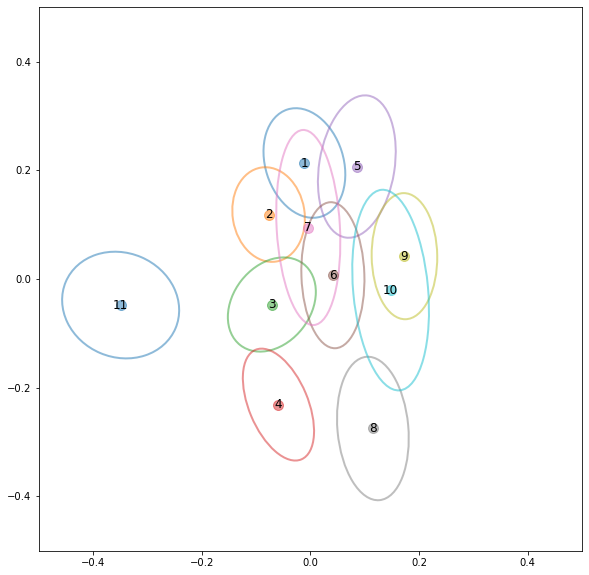

Iterating through the data set...
Iteration: 1 Delta: 0.06204384107383975


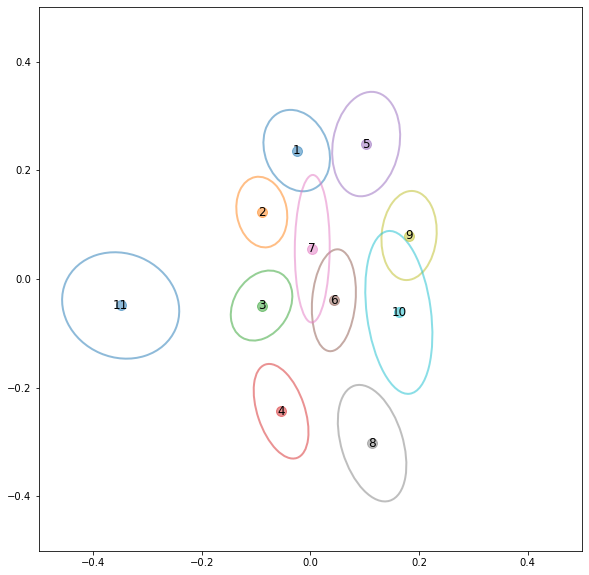

Iterating through the data set...
Iteration: 2 Delta: 0.00904210469147728


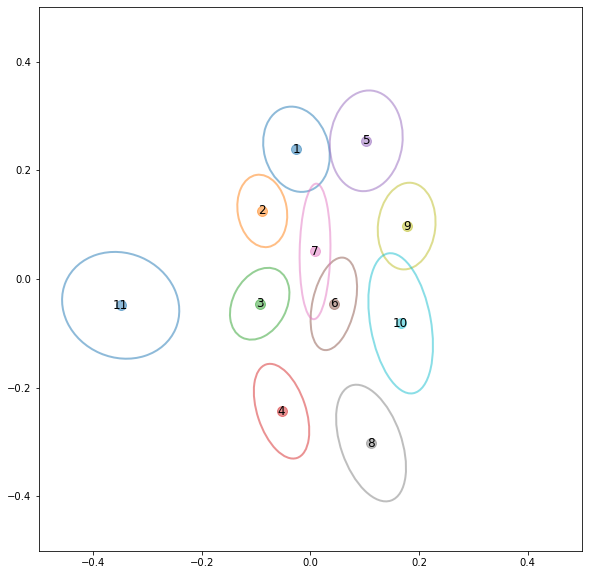

Iterating through the data set...
Iteration: 3 Delta: 0.003688151640302222


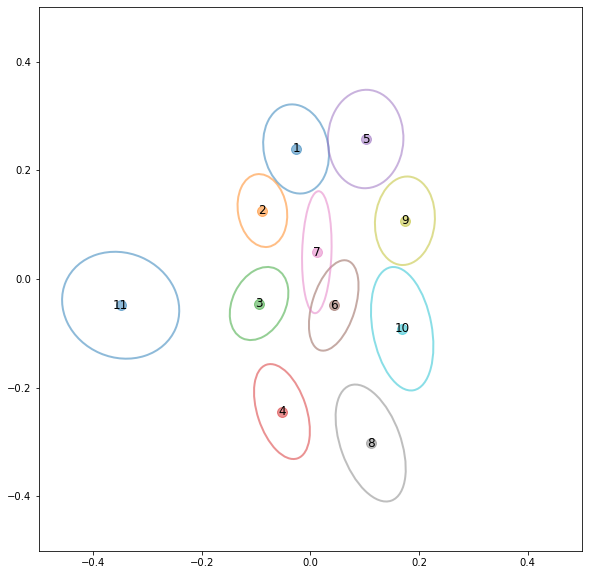

Iterating through the data set...
Iteration: 4 Delta: 0.0013111083112748237


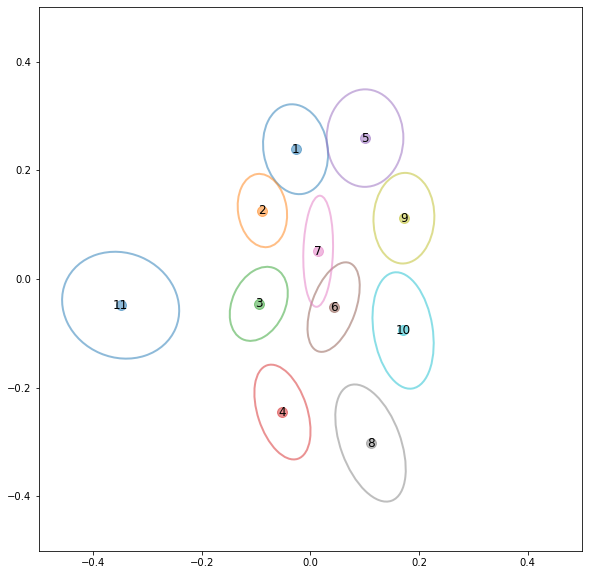

Iterating through the data set...
Iteration: 5 Delta: 0.000900408145616067


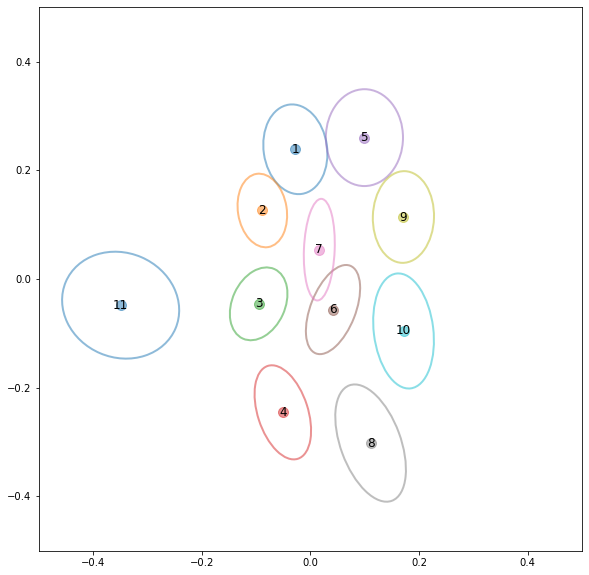

Iterating through the data set...
Iteration: 6 Delta: 0.002046912674473331


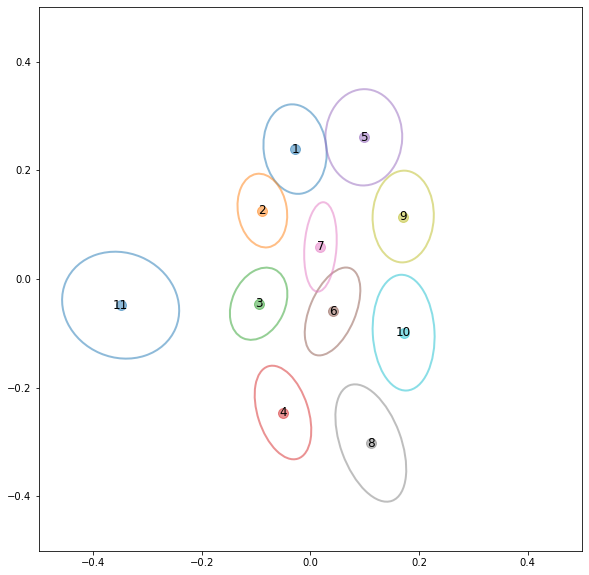

Iterating through the data set...
Iteration: 7 Delta: 0.0003804139721919909


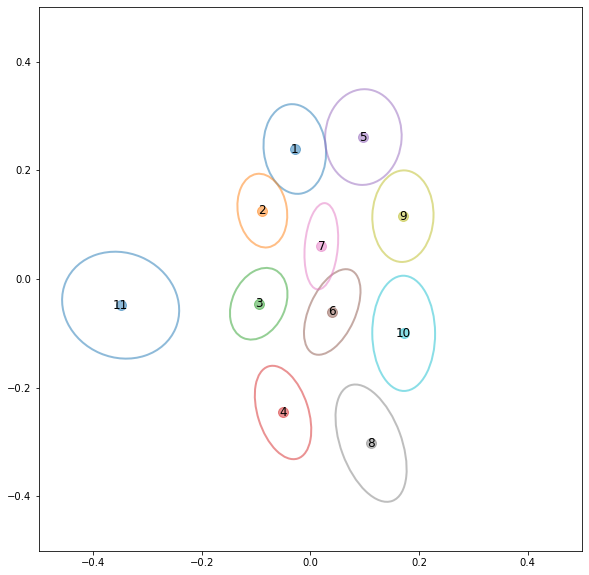

Iterating through the data set...
Iteration: 8 Delta: 0.0003322461404653943


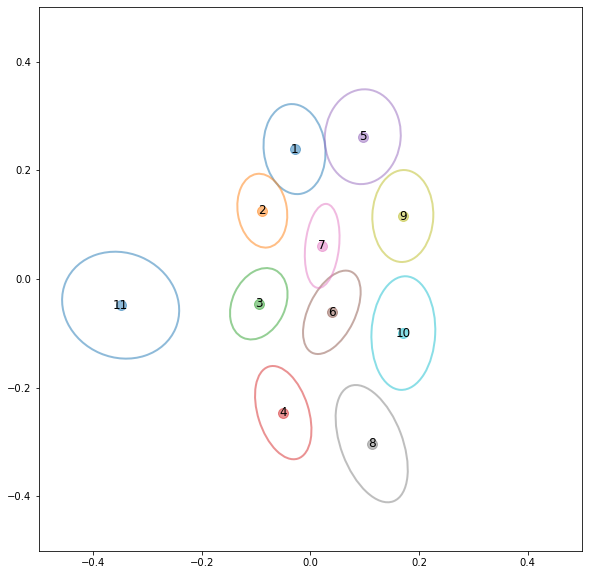

Iterating through the data set...
Iteration: 9 Delta: 0.0002675862605130911


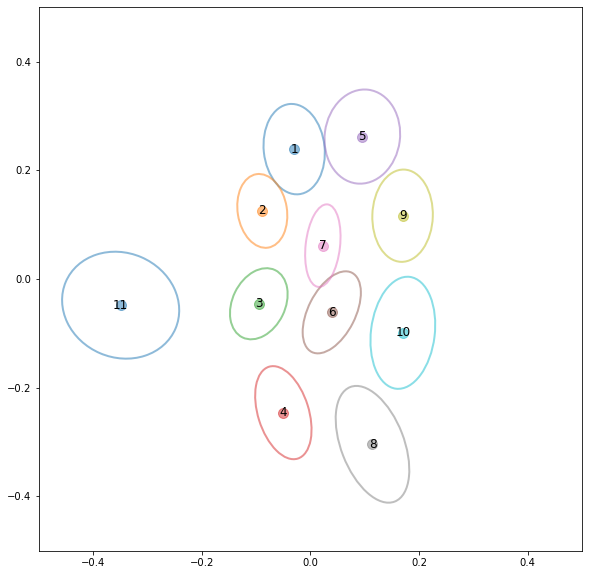

Iterating through the data set...
Iteration: 10 Delta: 0.00029732368101204596


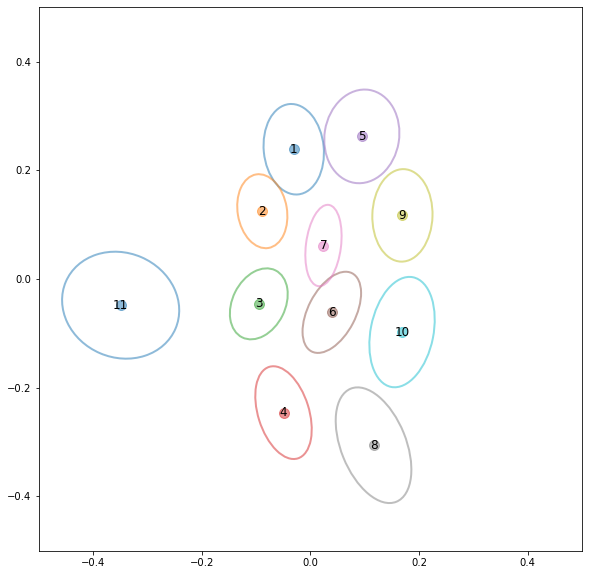

Iterating through the data set...
Iteration: 11 Delta: 0.00010251265582225536


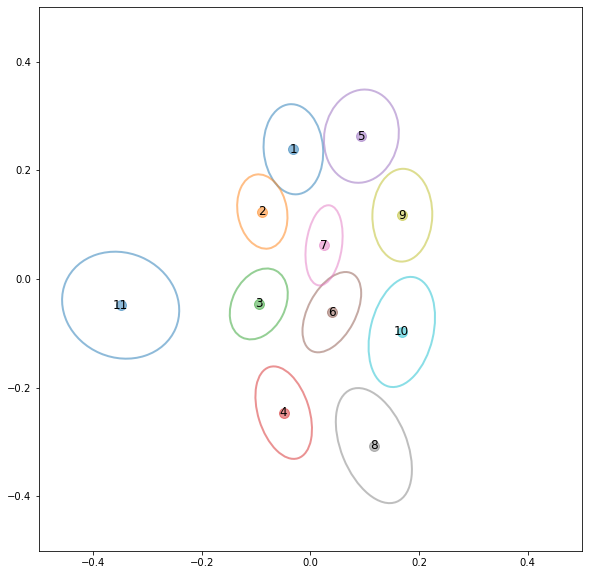

Iterating through the data set...
Iteration: 12 Delta: 7.826409975961858e-05


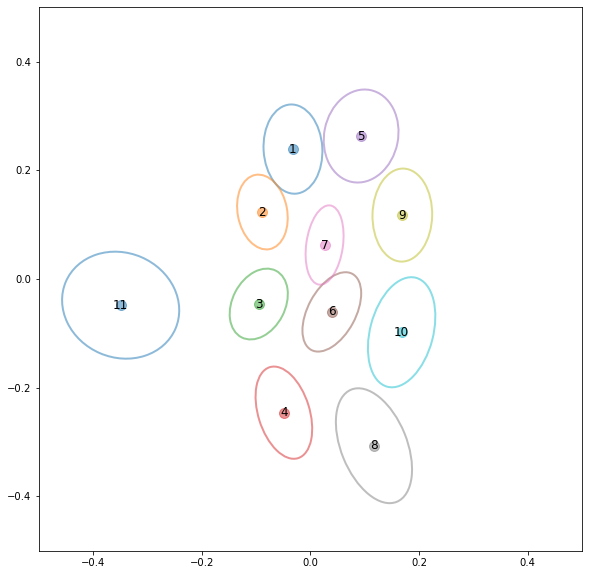

In [17]:
main_data_for_new_pdfs, main_formation = home.expectation_maximization(norm_home_player_positions, num_roles, num_players, entropy_method_threshold)

### Plot a single player's continuous pdf along with their discrete data

In [ ]:
# Set up the figure
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_aspect('equal')



# Grab data from 1st player
matched_coords = main_data_for_new_pdfs['Role 1']
 
# individual_template = np.zeros((1, 2))
# individual_cluster_covs = np.zeros((1, 2, 2))

# Convert matched_coords to a NumPy array
matched_coords = np.array(matched_coords)
# Compute the centroid of the matched coordinates
mean = matched_coords.mean(axis=0)
x, y = mean

# Compute the covariance matrix of the matched coordinates
cov = np.cov(matched_coords, rowvar=False)

# Get the eigenvalues and eigenvectors of the covariance matrix
eigenvalues, eigenvectors = np.linalg.eigh(cov)
              

ax.plot(x, y, 'o', markersize=10, alpha=0.5, label=f'Player 1', color="green")

# Plot the Gaussian as an ellipse
ellipse = Ellipse(xy=mean, width=2*np.sqrt(eigenvalues[0]), height=2*np.sqrt(eigenvalues[1]), 
              angle=np.degrees(np.arctan2(*eigenvectors[:, 0][::-1])), edgecolor='green', lw=2, fill=False, alpha=0.5)
ax.add_artist(ellipse)

# Plot the player number at the centroid of the ellipse
ax.annotate(str(1), xy=mean, ha='center', va='center', fontsize=12)

# Scatter plot of individual data points
ax.scatter(matched_coords[::125, 0], matched_coords[::125, 1], marker='.', color="green", alpha=0.5)

# Set the axis limits and add a legend
ax.set_xlim([-0.25, 0.15])
ax.set_ylim([0, 0.45])



# Analysis III.a Short duration team formations (Home vs Away)

Initial Formation


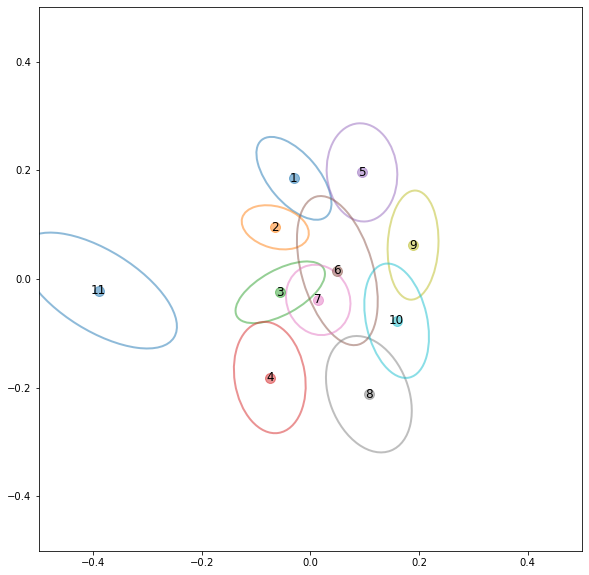

Iterating through the data set...
Iteration: 1 Delta: 0.04287281190267249


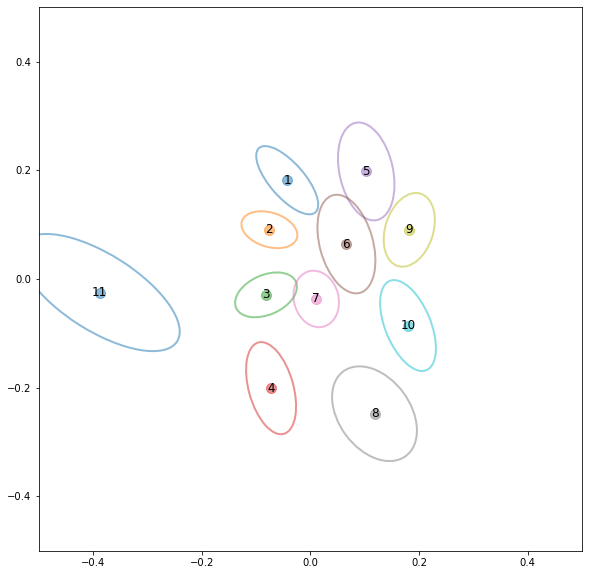

Iterating through the data set...
Iteration: 2 Delta: 0.002873685427088146


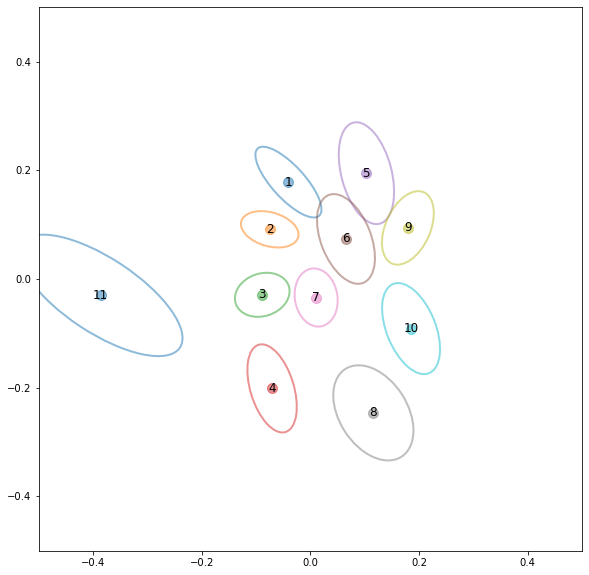

Iterating through the data set...
Iteration: 3 Delta: 0.0017150174889641915


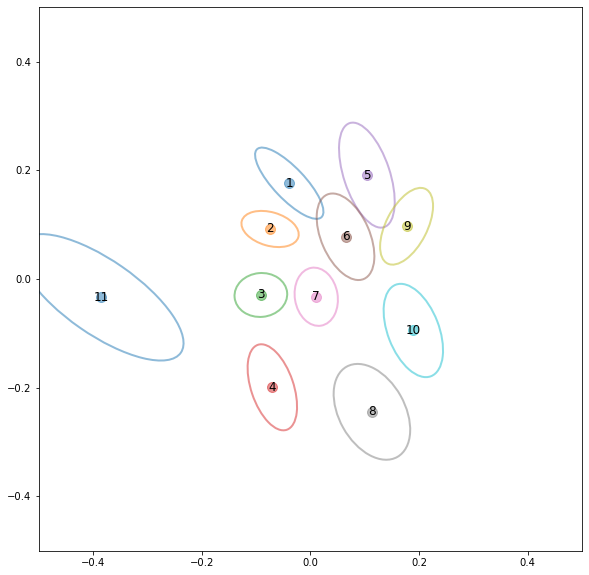

Iterating through the data set...
Iteration: 4 Delta: 0.0006476626734192355


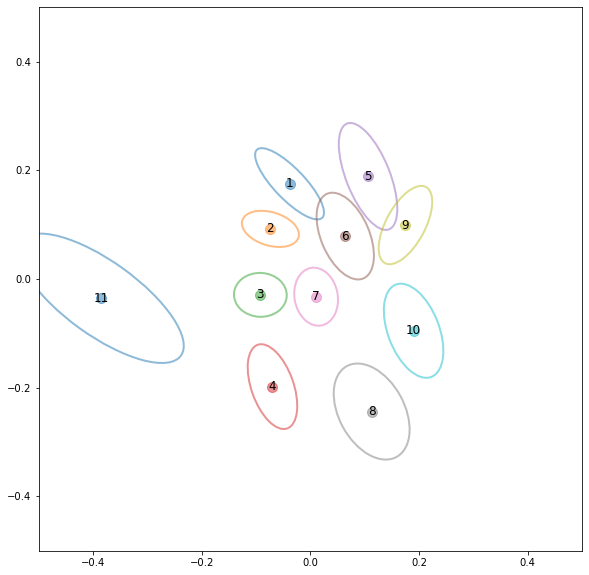

Iterating through the data set...
Iteration: 5 Delta: 5.222118322868897e-05


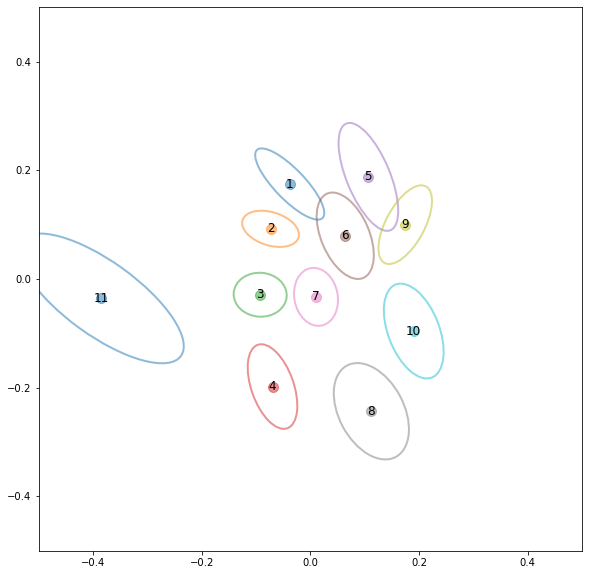

Initial Formation


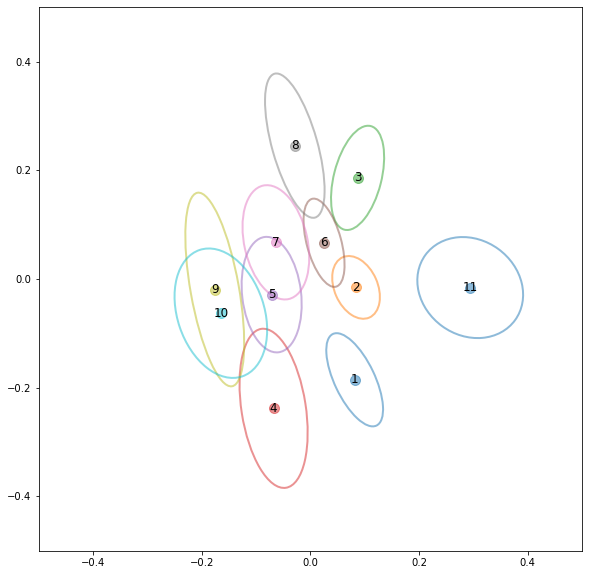

Iterating through the data set...
Iteration: 1 Delta: 0.02946921191257821


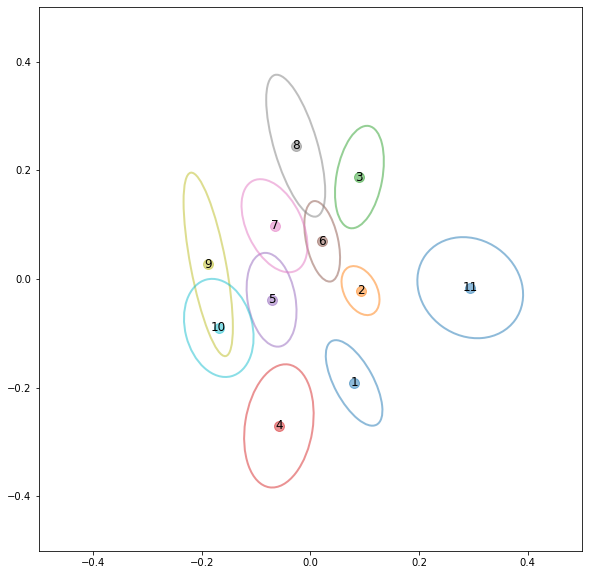

Iterating through the data set...
Iteration: 2 Delta: 0.004919435599986753


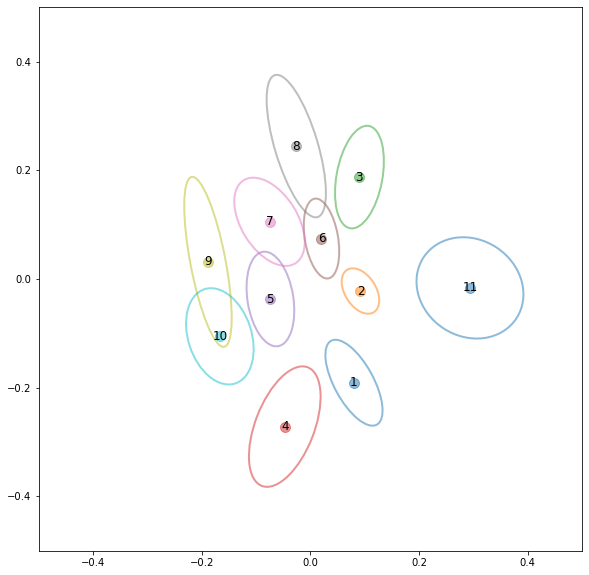

Iterating through the data set...
Iteration: 3 Delta: 0.0017389645880743446


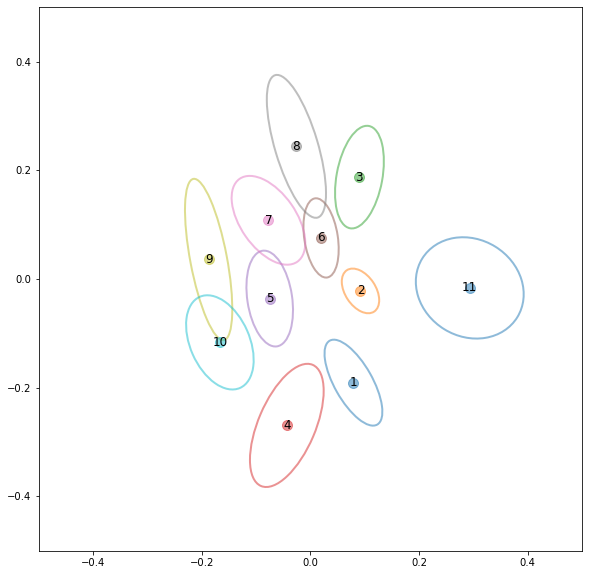

Iterating through the data set...
Iteration: 4 Delta: 0.0012510395591592495


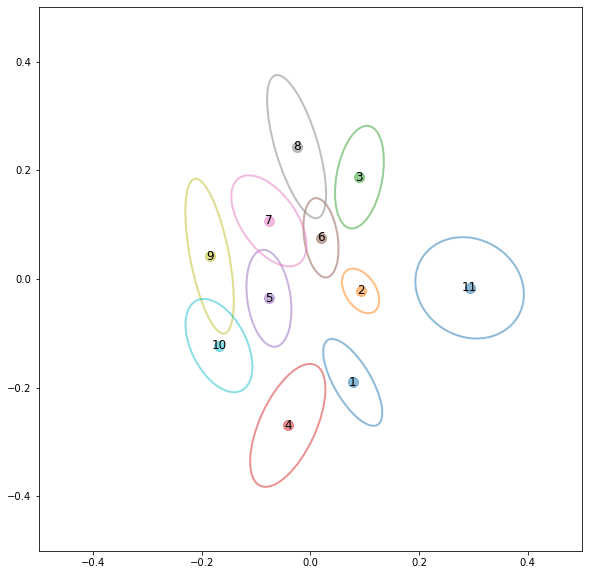

Iterating through the data set...
Iteration: 5 Delta: 0.00018841581210482066


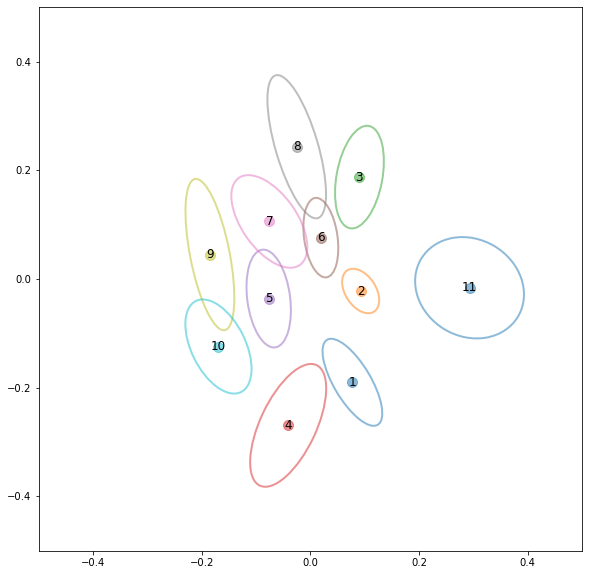

Iterating through the data set...
Iteration: 6 Delta: 3.454829447870302e-05


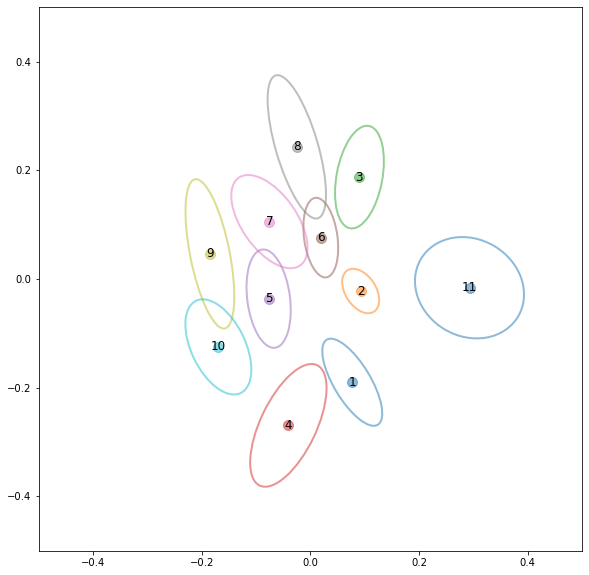

5-min Interval: 1


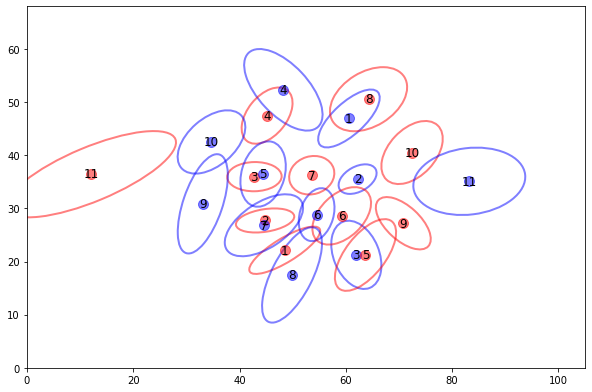

Initial Formation


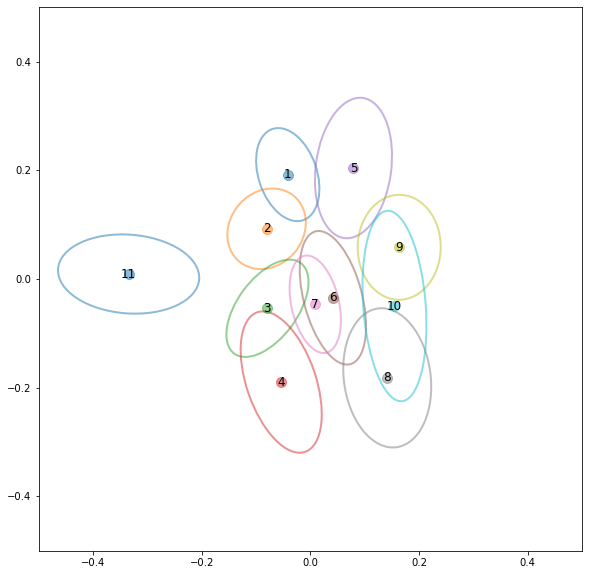

Iterating through the data set...
Iteration: 1 Delta: 0.07204001398096781


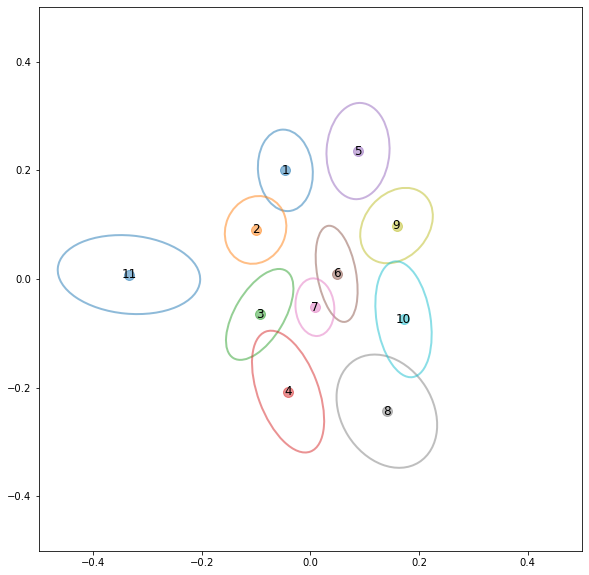

Iterating through the data set...
Iteration: 2 Delta: 0.008901851062720019


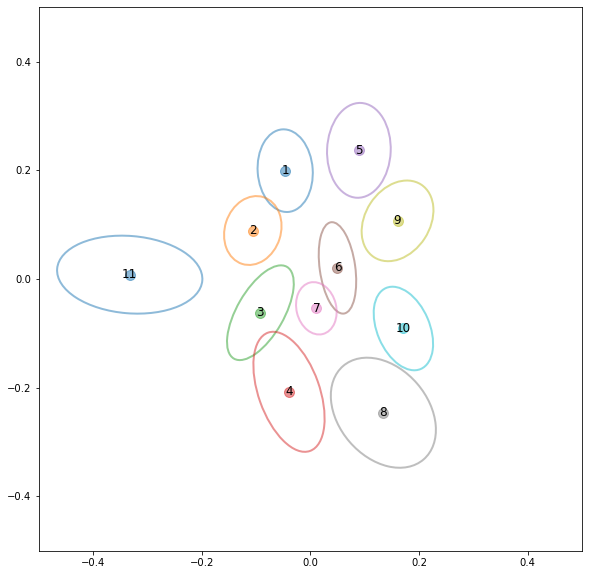

Iterating through the data set...
Iteration: 3 Delta: 0.0019457802329641708


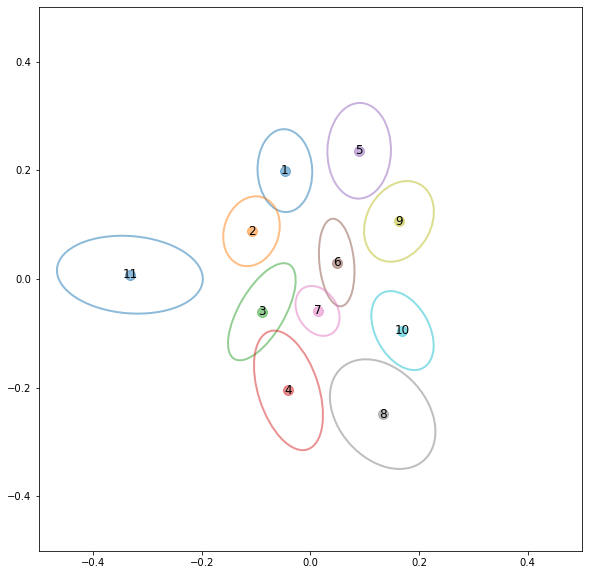

Iterating through the data set...
Iteration: 4 Delta: 0.0013688361610092559


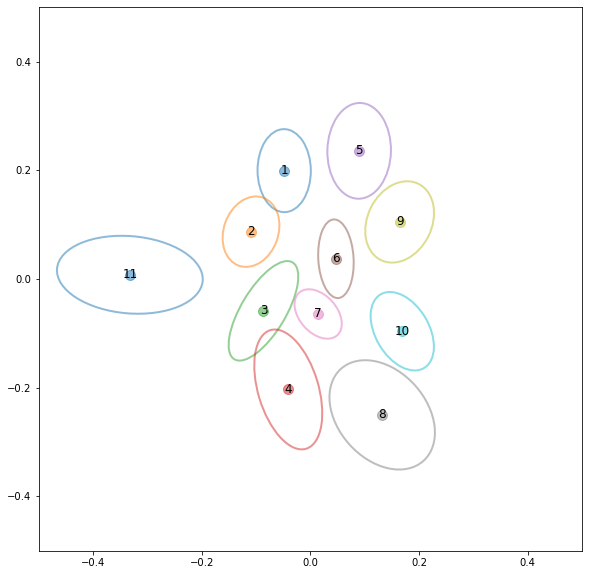

Iterating through the data set...
Iteration: 5 Delta: 0.003888156724463317


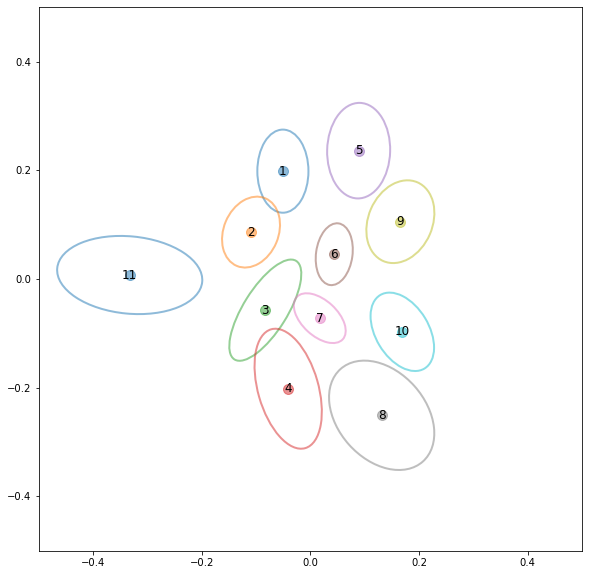

Iterating through the data set...
Iteration: 6 Delta: 0.0015698843583508667


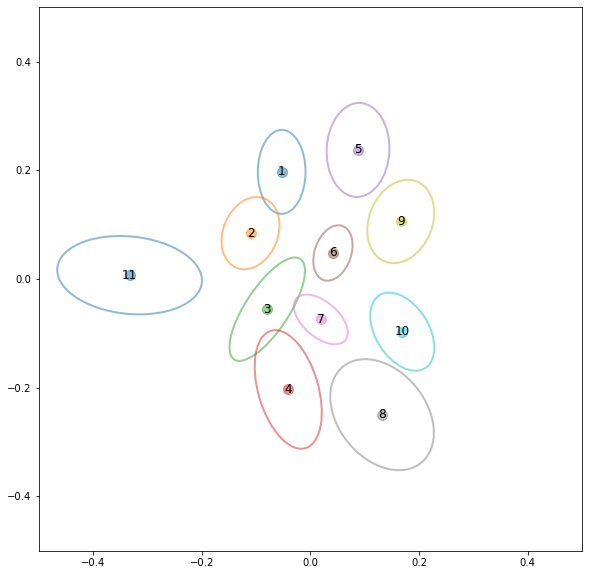

Iterating through the data set...
Iteration: 7 Delta: 0.0001330180855315026


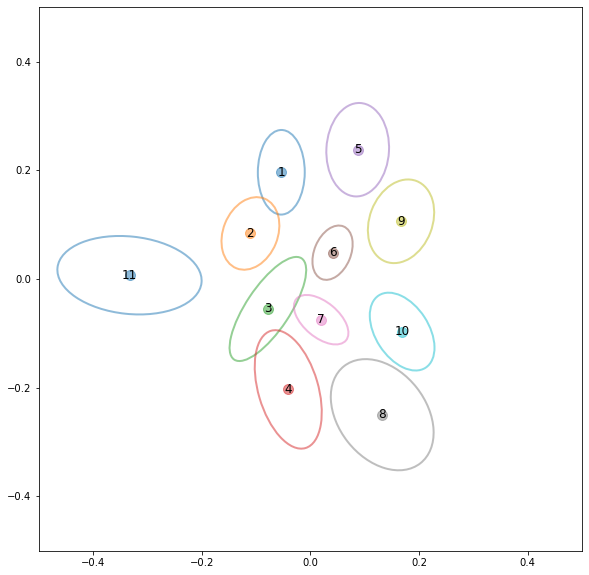

Iterating through the data set...
Iteration: 8 Delta: 1.491092136004773e-05


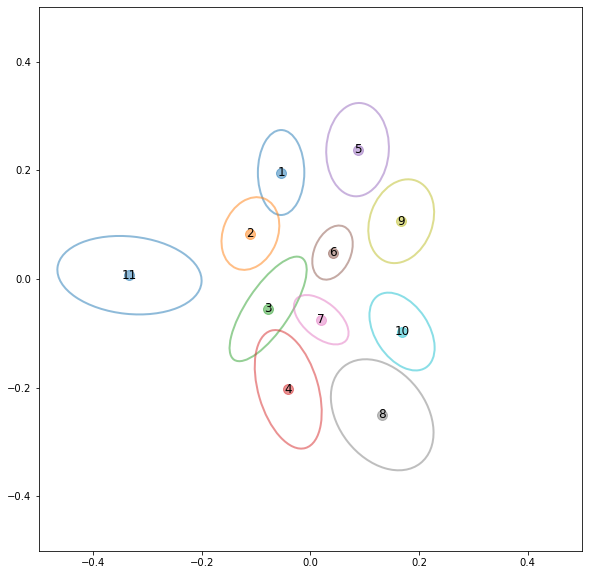

Initial Formation


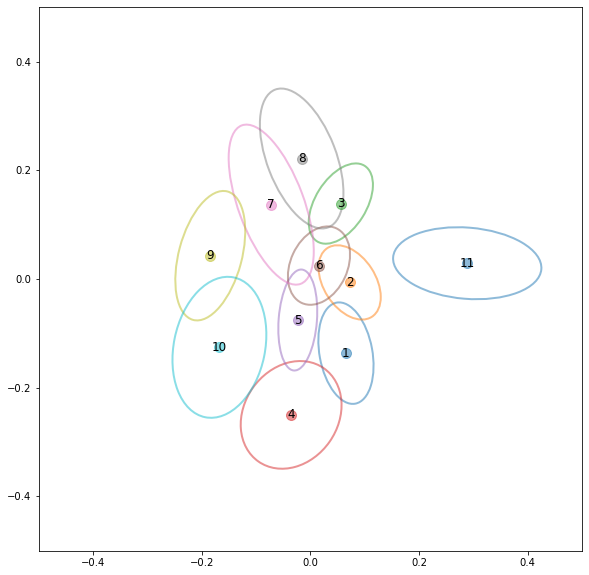

Iterating through the data set...
Iteration: 1 Delta: 0.05107104101621595


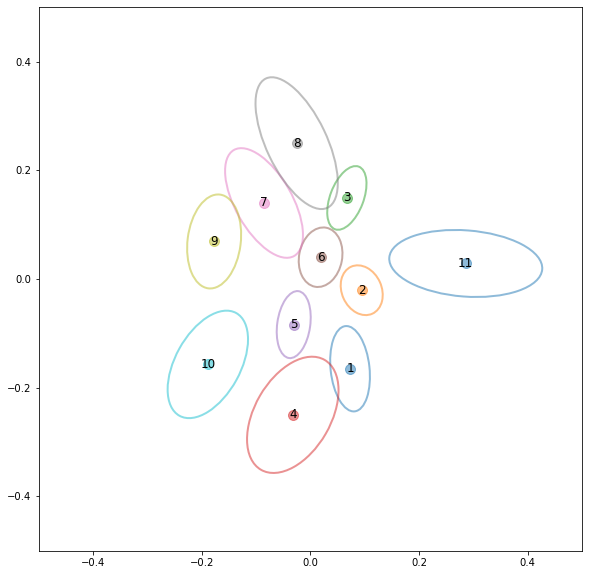

Iterating through the data set...
Iteration: 2 Delta: 0.003420078413830616


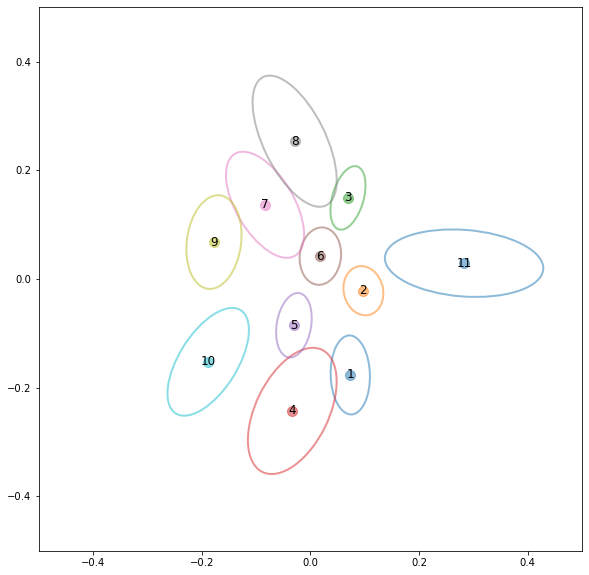

Iterating through the data set...
Iteration: 3 Delta: 0.0008042166141820417


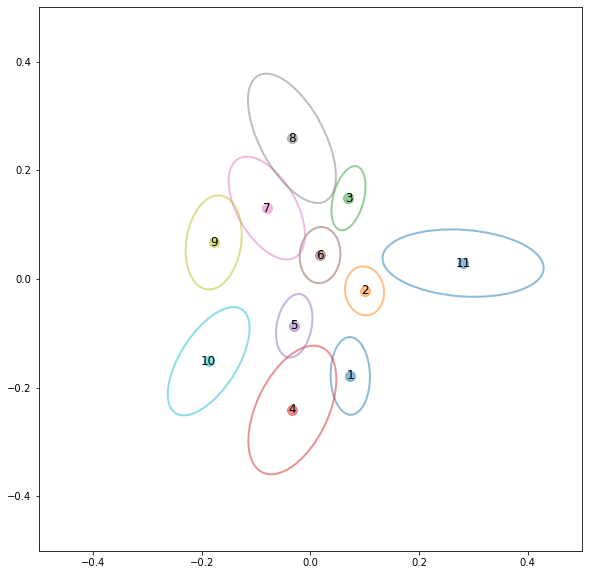

Iterating through the data set...
Iteration: 4 Delta: 0.00017000310164725355


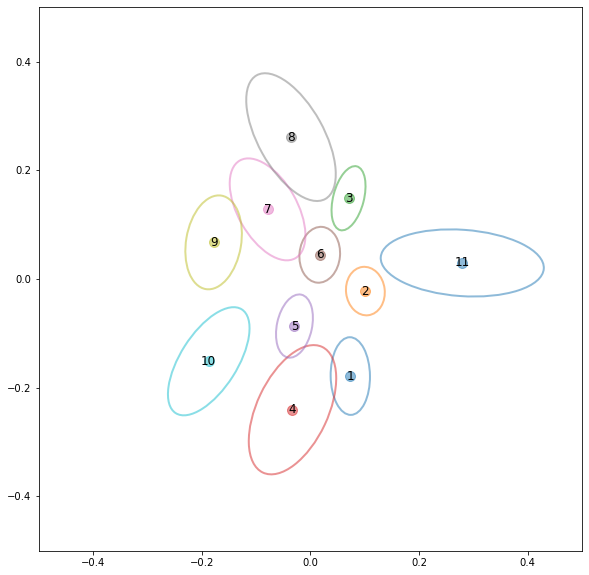

Iterating through the data set...
Iteration: 5 Delta: 3.770484788155933e-05


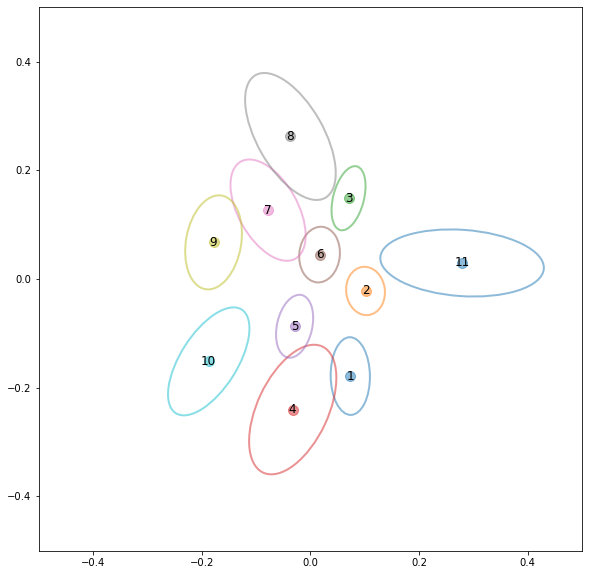

5-min Interval: 2


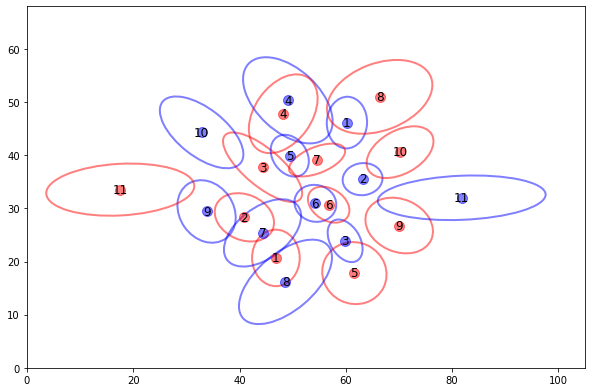

In [10]:
#max_intervals = norm_interval_home_player_positions.shape[0]
#for interval in range(max_intervals):
for interval in range(2):
    home_data = norm_interval_home_player_positions[interval] # select the player position data for only this interval
    away_data = norm_interval_away_player_positions[interval]
    
    home_pdf_data, home_formation = home.expectation_maximization(home_data, num_roles, num_players, entropy_method_threshold)
    away_pdf_data, away_formation = away.expectation_maximization(away_data, num_roles, num_players, entropy_method_threshold)

     
    # Transform the [x,y] coordinate pairs from a range of 0 to 1 to the actual dimensions of a soccer field (105x68 meters)
    away_pdf_data = linear_transform(away_pdf_data)
    home_pdf_data = linear_transform(home_pdf_data)
    
    # Recompute probability density functions for each role with transformed data and plot
    transformed_templates_away, transformed_cluster_covs_away = away_formation.compute_mean_and_cov(num_roles, away_pdf_data)
    transformed_templates_home, transformed_cluster_covs_home = home_formation.compute_mean_and_cov(num_roles, home_pdf_data)

    print(f'5-min Interval: {interval+1}')
    away_formation.plot_clusters(transformed_templates_home, transformed_cluster_covs_home,
                                 template2=transformed_templates_away, cluster_covs2=transformed_cluster_covs_away,
                                 method='adversarial', norm = False)  

# Analysis III.b Classify Ball Events by player identity

In [8]:
'''The paper defines ball events as one of 43 possible events (e.g.
passes, shots, crosses, tackles etc.) Since our data only includes ball-x 
and ball-y coordinates, we identify a ball event for each frame by determining 

1) the subset of players who are wihtin a 0.011 radius of the ball. This radius was 
qualitatively determined to indicate contact with the ball and was defined to negate frames 
where the ball is simply in transit through open space (i.e., an ongoing pass)

2) the one player in this subset who is closest to the ball. This player is making contact with the ball'''

from scipy.spatial.distance import cdist

def determine_ball_events(unnormalized_ball_positions, unnormalized_player_positions, normalized_player_positions, threshold=0.011):
    ball_events = np.zeros(unnormalized_ball_positions.shape)
    for frame, ball_position in enumerate(unnormalized_ball_positions):
        if (ball_position == [0.0, 0.0]).all(): 
            # We skip the frames where the ball's position is not tracked (i.e., out of bounds)
            ball_events[frame] = [None, None]
            
        else:
            # Compute distances between ball position and all player positions
            distances = cdist([ball_position], unnormalized_player_positions[frame])
            # Filter player positions below threshold
            below_threshold = normalized_player_positions[frame][distances[0] <= threshold]

            # Select player position with minimum distance
            if below_threshold.size > 0:
                idx = np.argmin(distances[0][distances[0] <= threshold])
                normalized_player_position = below_threshold[idx]
            else:
                # If no player positions below threshold, append [NaN, NaN] for this frame
                normalized_player_position = [None, None]
        
            ball_events[frame] = normalized_player_position
            
    return ball_events



home_ball_events = determine_ball_events(home_unnormalized_ball_positions, home_unnormalized_player_positions, norm_home_player_positions)
away_ball_events = determine_ball_events(away_unnormalized_ball_positions, away_unnormalized_player_positions, norm_away_player_positions)

In [92]:
def plot_ball_events_by_role(ball_events, pdf_data):
    # Create a dictionary to store the colors corresponding to each key
    color_dict = {"Role 1": 'green', "Role 2": 'cyan', "Role 3": 'orange', "Role 4": 'blue', "Role 5": 'purple', 
                  "Role 6": 'red', "Role 7": 'black', "Role 8": 'pink', "Role 9": 'olive', "Role 10": 'lawngreen', 
                  "Role 11": 'lightcoral'}
    
    # Create a dictionary to store the x and y coordinates for each key
    coords_dict = {role: [] for role in pdf_data}

    
    # Iterate through the ball_events array
    for i in range(len(ball_events)):
        if not np.isnan(ball_events[i][0]):
            # Check if the [x, y] coordinates in ball_events match any of the keys in pdf_data
            for role, coord_list in pdf_data.items():
                if list(ball_events[i]) in coord_list:
                    # Store the x and y coordinates for the current key
                    coords_dict[role].append(ball_events[i])
                    break
    
    coords_dict = linear_transform(coords_dict)
    
    # Create a dictionary to store the colors corresponding to each key
    color_dict = {"Role 1": 'green', "Role 2": 'cyan', "Role 3": 'orange', "Role 4": 'blue', "Role 5": 'purple', 
                  "Role 6": 'red', "Role 7": 'black', "Role 8": 'pink', "Role 9": 'olive', "Role 10": 'lawngreen', 
                  "Role 11": 'lightcoral'}

    # Iterate over the keys in pdf_data and plot the corresponding scatter plot
    for i, role in enumerate(coords_dict):
        fig, ax = plt.subplots()
        ax.set_xlim([0, 105])
        ax.set_ylim([0, 68])
        x_coords, y_coords = zip(*coords_dict[role])
        ax.scatter(x_coords, y_coords, color=color_dict[role])
        ax.set_title(role)

        plt.show()
        # Save the plot to a file
        fig.savefig(f"{role}.png", dpi=300)
        plt.close(fig)  # Close the figure to free memory

Role 1 [0.18439091 0.00148455] 3
Role 2 [0.18439091 0.00148455] 3
Role 3 [0.18439091 0.00148455] 3
Role 4 [0.18439091 0.00148455] 3
Role 5 [0.18439091 0.00148455] 3
Role 6 [0.18439091 0.00148455] 3
Role 7 [0.18439091 0.00148455] 3
Role 8 [0.18439091 0.00148455] 3
Role 9 [0.18439091 0.00148455] 3
Role 1 [0.11464545 0.26859182] 352
Role 2 [0.11464545 0.26859182] 352
Role 3 [0.11464545 0.26859182] 352
Role 4 [0.11464545 0.26859182] 352
Role 5 [0.11464545 0.26859182] 352
Role 1 [0.11533909 0.26858636] 353
Role 2 [0.11533909 0.26858636] 353
Role 3 [0.11533909 0.26858636] 353
Role 4 [0.11533909 0.26858636] 353
Role 5 [0.11533909 0.26858636] 353
Role 1 [-0.07018727  0.12537545] 377
Role 2 [-0.07018727  0.12537545] 377
Role 1 [-0.07025091  0.12458545] 378
Role 2 [-0.07025091  0.12458545] 378
Role 1 [-0.07027636  0.12383273] 379
Role 2 [-0.07027636  0.12383273] 379
Role 1 [0.05045455 0.09326273] 403
Role 2 [0.05045455 0.09326273] 403
Role 3 [0.05045455 0.09326273] 403
Role 4 [0.05045455 0.09326

Role 2 [0.09892909 0.05241909] 564
Role 3 [0.09892909 0.05241909] 564
Role 4 [0.09892909 0.05241909] 564
Role 5 [0.09892909 0.05241909] 564
Role 6 [0.09892909 0.05241909] 564
Role 7 [0.09892909 0.05241909] 564
Role 8 [0.09892909 0.05241909] 564
Role 9 [0.09892909 0.05241909] 564
Role 1 [0.0983     0.05277545] 565
Role 2 [0.0983     0.05277545] 565
Role 3 [0.0983     0.05277545] 565
Role 4 [0.0983     0.05277545] 565
Role 5 [0.0983     0.05277545] 565
Role 6 [0.0983     0.05277545] 565
Role 7 [0.0983     0.05277545] 565
Role 8 [0.0983     0.05277545] 565
Role 9 [0.0983     0.05277545] 565
Role 1 [0.09769182 0.05308727] 566
Role 2 [0.09769182 0.05308727] 566
Role 3 [0.09769182 0.05308727] 566
Role 4 [0.09769182 0.05308727] 566
Role 5 [0.09769182 0.05308727] 566
Role 6 [0.09769182 0.05308727] 566
Role 7 [0.09769182 0.05308727] 566
Role 8 [0.09769182 0.05308727] 566
Role 9 [0.09769182 0.05308727] 566
Role 1 [0.09707909 0.05343182] 567
Role 2 [0.09707909 0.05343182] 567
Role 3 [0.09707909 0

Role 4 [0.11318091 0.09864   ] 1190
Role 5 [0.11318091 0.09864   ] 1190
Role 6 [0.11318091 0.09864   ] 1190
Role 7 [0.11318091 0.09864   ] 1190
Role 8 [0.11318091 0.09864   ] 1190
Role 9 [0.11318091 0.09864   ] 1190
Role 1 [0.11289545 0.09847909] 1191
Role 2 [0.11289545 0.09847909] 1191
Role 3 [0.11289545 0.09847909] 1191
Role 4 [0.11289545 0.09847909] 1191
Role 5 [0.11289545 0.09847909] 1191
Role 6 [0.11289545 0.09847909] 1191
Role 7 [0.11289545 0.09847909] 1191
Role 8 [0.11289545 0.09847909] 1191
Role 9 [0.11289545 0.09847909] 1191
Role 1 [0.11260091 0.09826636] 1192
Role 2 [0.11260091 0.09826636] 1192
Role 3 [0.11260091 0.09826636] 1192
Role 4 [0.11260091 0.09826636] 1192
Role 5 [0.11260091 0.09826636] 1192
Role 6 [0.11260091 0.09826636] 1192
Role 7 [0.11260091 0.09826636] 1192
Role 8 [0.11260091 0.09826636] 1192
Role 9 [0.11260091 0.09826636] 1192
Role 1 [0.11230364 0.09798727] 1193
Role 2 [0.11230364 0.09798727] 1193
Role 3 [0.11230364 0.09798727] 1193
Role 4 [0.11230364 0.0979872

Role 5 [0.10577182 0.07205455] 1218
Role 6 [0.10577182 0.07205455] 1218
Role 7 [0.10577182 0.07205455] 1218
Role 8 [0.10577182 0.07205455] 1218
Role 9 [0.10577182 0.07205455] 1218
Role 1 [0.10560818 0.07051182] 1219
Role 2 [0.10560818 0.07051182] 1219
Role 3 [0.10560818 0.07051182] 1219
Role 4 [0.10560818 0.07051182] 1219
Role 5 [0.10560818 0.07051182] 1219
Role 6 [0.10560818 0.07051182] 1219
Role 7 [0.10560818 0.07051182] 1219
Role 8 [0.10560818 0.07051182] 1219
Role 9 [0.10560818 0.07051182] 1219
Role 1 [0.10543636 0.06898455] 1220
Role 2 [0.10543636 0.06898455] 1220
Role 3 [0.10543636 0.06898455] 1220
Role 4 [0.10543636 0.06898455] 1220
Role 5 [0.10543636 0.06898455] 1220
Role 6 [0.10543636 0.06898455] 1220
Role 7 [0.10543636 0.06898455] 1220
Role 8 [0.10543636 0.06898455] 1220
Role 9 [0.10543636 0.06898455] 1220
Role 1 [0.10527    0.06745455] 1221
Role 2 [0.10527    0.06745455] 1221
Role 3 [0.10527    0.06745455] 1221
Role 4 [0.10527    0.06745455] 1221
Role 5 [0.10527    0.0674545

Role 3 [ 0.15654364 -0.22812818] 1281
Role 4 [ 0.15654364 -0.22812818] 1281
Role 5 [ 0.15654364 -0.22812818] 1281
Role 6 [ 0.15654364 -0.22812818] 1281
Role 7 [ 0.15654364 -0.22812818] 1281
Role 8 [ 0.15654364 -0.22812818] 1281
Role 1 [ 0.15744273 -0.22746273] 1282
Role 2 [ 0.15744273 -0.22746273] 1282
Role 3 [ 0.15744273 -0.22746273] 1282
Role 4 [ 0.15744273 -0.22746273] 1282
Role 5 [ 0.15744273 -0.22746273] 1282
Role 6 [ 0.15744273 -0.22746273] 1282
Role 7 [ 0.15744273 -0.22746273] 1282
Role 8 [ 0.15744273 -0.22746273] 1282
Role 1 [ 0.15836    -0.22687727] 1283
Role 2 [ 0.15836    -0.22687727] 1283
Role 3 [ 0.15836    -0.22687727] 1283
Role 4 [ 0.15836    -0.22687727] 1283
Role 5 [ 0.15836    -0.22687727] 1283
Role 6 [ 0.15836    -0.22687727] 1283
Role 7 [ 0.15836    -0.22687727] 1283
Role 8 [ 0.15836    -0.22687727] 1283
Role 1 [ 0.15929364 -0.22635636] 1284
Role 2 [ 0.15929364 -0.22635636] 1284
Role 3 [ 0.15929364 -0.22635636] 1284
Role 4 [ 0.15929364 -0.22635636] 1284
Role 5 [ 0.1

Role 6 [ 0.18943182 -0.21342545] 1313
Role 7 [ 0.18943182 -0.21342545] 1313
Role 8 [ 0.18943182 -0.21342545] 1313
Role 1 [ 0.19056545 -0.21319818] 1314
Role 2 [ 0.19056545 -0.21319818] 1314
Role 3 [ 0.19056545 -0.21319818] 1314
Role 4 [ 0.19056545 -0.21319818] 1314
Role 5 [ 0.19056545 -0.21319818] 1314
Role 6 [ 0.19056545 -0.21319818] 1314
Role 7 [ 0.19056545 -0.21319818] 1314
Role 8 [ 0.19056545 -0.21319818] 1314
Role 1 [ 0.19171364 -0.21297909] 1315
Role 2 [ 0.19171364 -0.21297909] 1315
Role 3 [ 0.19171364 -0.21297909] 1315
Role 4 [ 0.19171364 -0.21297909] 1315
Role 5 [ 0.19171364 -0.21297909] 1315
Role 6 [ 0.19171364 -0.21297909] 1315
Role 7 [ 0.19171364 -0.21297909] 1315
Role 8 [ 0.19171364 -0.21297909] 1315
Role 1 [ 0.19287545 -0.21277   ] 1316
Role 2 [ 0.19287545 -0.21277   ] 1316
Role 3 [ 0.19287545 -0.21277   ] 1316
Role 4 [ 0.19287545 -0.21277   ] 1316
Role 5 [ 0.19287545 -0.21277   ] 1316
Role 6 [ 0.19287545 -0.21277   ] 1316
Role 7 [ 0.19287545 -0.21277   ] 1316
Role 8 [ 0.1

Role 6 [ 0.23192909 -0.22389727] 1347
Role 7 [ 0.23192909 -0.22389727] 1347
Role 8 [ 0.23192909 -0.22389727] 1347
Role 1 [ 0.23326636 -0.22468727] 1348
Role 2 [ 0.23326636 -0.22468727] 1348
Role 3 [ 0.23326636 -0.22468727] 1348
Role 4 [ 0.23326636 -0.22468727] 1348
Role 5 [ 0.23326636 -0.22468727] 1348
Role 6 [ 0.23326636 -0.22468727] 1348
Role 7 [ 0.23326636 -0.22468727] 1348
Role 8 [ 0.23326636 -0.22468727] 1348
Role 1 [ 0.23459091 -0.22540091] 1349
Role 2 [ 0.23459091 -0.22540091] 1349
Role 3 [ 0.23459091 -0.22540091] 1349
Role 4 [ 0.23459091 -0.22540091] 1349
Role 5 [ 0.23459091 -0.22540091] 1349
Role 6 [ 0.23459091 -0.22540091] 1349
Role 7 [ 0.23459091 -0.22540091] 1349
Role 8 [ 0.23459091 -0.22540091] 1349
Role 1 [ 0.23591636 -0.22613   ] 1350
Role 2 [ 0.23591636 -0.22613   ] 1350
Role 3 [ 0.23591636 -0.22613   ] 1350
Role 4 [ 0.23591636 -0.22613   ] 1350
Role 5 [ 0.23591636 -0.22613   ] 1350
Role 6 [ 0.23591636 -0.22613   ] 1350
Role 7 [ 0.23591636 -0.22613   ] 1350
Role 8 [ 0.2

Role 8 [ 0.22023 -0.41433] 2144
Role 1 [ 0.21856818 -0.41397636] 2145
Role 2 [ 0.21856818 -0.41397636] 2145
Role 3 [ 0.21856818 -0.41397636] 2145
Role 4 [ 0.21856818 -0.41397636] 2145
Role 5 [ 0.21856818 -0.41397636] 2145
Role 6 [ 0.21856818 -0.41397636] 2145
Role 7 [ 0.21856818 -0.41397636] 2145
Role 8 [ 0.21856818 -0.41397636] 2145
Role 1 [ 0.21689182 -0.41368182] 2146
Role 2 [ 0.21689182 -0.41368182] 2146
Role 3 [ 0.21689182 -0.41368182] 2146
Role 4 [ 0.21689182 -0.41368182] 2146
Role 5 [ 0.21689182 -0.41368182] 2146
Role 6 [ 0.21689182 -0.41368182] 2146
Role 7 [ 0.21689182 -0.41368182] 2146
Role 8 [ 0.21689182 -0.41368182] 2146
Role 1 [ 0.21518636 -0.41342091] 2147
Role 2 [ 0.21518636 -0.41342091] 2147
Role 3 [ 0.21518636 -0.41342091] 2147
Role 4 [ 0.21518636 -0.41342091] 2147
Role 5 [ 0.21518636 -0.41342091] 2147
Role 6 [ 0.21518636 -0.41342091] 2147
Role 7 [ 0.21518636 -0.41342091] 2147
Role 8 [ 0.21518636 -0.41342091] 2147
Role 1 [ 0.21346182 -0.41308   ] 2148
Role 2 [ 0.2134618

Role 7 [ 0.11857455 -0.32313909] 2200
Role 8 [ 0.11857455 -0.32313909] 2200
Role 9 [ 0.11857455 -0.32313909] 2200
Role 10 [ 0.11857455 -0.32313909] 2200
Role 1 [ 0.11880909 -0.32222091] 2201
Role 2 [ 0.11880909 -0.32222091] 2201
Role 3 [ 0.11880909 -0.32222091] 2201
Role 4 [ 0.11880909 -0.32222091] 2201
Role 5 [ 0.11880909 -0.32222091] 2201
Role 6 [ 0.11880909 -0.32222091] 2201
Role 7 [ 0.11880909 -0.32222091] 2201
Role 8 [ 0.11880909 -0.32222091] 2201
Role 9 [ 0.11880909 -0.32222091] 2201
Role 10 [ 0.11880909 -0.32222091] 2201
Role 1 [ 0.11899182 -0.32120727] 2202
Role 2 [ 0.11899182 -0.32120727] 2202
Role 3 [ 0.11899182 -0.32120727] 2202
Role 4 [ 0.11899182 -0.32120727] 2202
Role 5 [ 0.11899182 -0.32120727] 2202
Role 6 [ 0.11899182 -0.32120727] 2202
Role 7 [ 0.11899182 -0.32120727] 2202
Role 8 [ 0.11899182 -0.32120727] 2202
Role 9 [ 0.11899182 -0.32120727] 2202
Role 10 [ 0.11899182 -0.32120727] 2202
Role 1 [ 0.11918727 -0.32020636] 2203
Role 2 [ 0.11918727 -0.32020636] 2203
Role 3 [ 

Role 7 [ 0.12014091 -0.29926091] 2226
Role 8 [ 0.12014091 -0.29926091] 2226
Role 9 [ 0.12014091 -0.29926091] 2226
Role 10 [ 0.12014091 -0.29926091] 2226
Role 1 [ 0.12006182 -0.29873455] 2227
Role 2 [ 0.12006182 -0.29873455] 2227
Role 3 [ 0.12006182 -0.29873455] 2227
Role 4 [ 0.12006182 -0.29873455] 2227
Role 5 [ 0.12006182 -0.29873455] 2227
Role 6 [ 0.12006182 -0.29873455] 2227
Role 7 [ 0.12006182 -0.29873455] 2227
Role 8 [ 0.12006182 -0.29873455] 2227
Role 9 [ 0.12006182 -0.29873455] 2227
Role 10 [ 0.12006182 -0.29873455] 2227
Role 1 [ 0.11994364 -0.29818636] 2228
Role 2 [ 0.11994364 -0.29818636] 2228
Role 3 [ 0.11994364 -0.29818636] 2228
Role 4 [ 0.11994364 -0.29818636] 2228
Role 5 [ 0.11994364 -0.29818636] 2228
Role 6 [ 0.11994364 -0.29818636] 2228
Role 7 [ 0.11994364 -0.29818636] 2228
Role 8 [ 0.11994364 -0.29818636] 2228
Role 9 [ 0.11994364 -0.29818636] 2228
Role 10 [ 0.11994364 -0.29818636] 2228
Role 1 [ 0.11979818 -0.29758455] 2229
Role 2 [ 0.11979818 -0.29758455] 2229
Role 3 [ 

Role 3 [ 0.11042364 -0.28904909] 2252
Role 4 [ 0.11042364 -0.28904909] 2252
Role 5 [ 0.11042364 -0.28904909] 2252
Role 6 [ 0.11042364 -0.28904909] 2252
Role 7 [ 0.11042364 -0.28904909] 2252
Role 8 [ 0.11042364 -0.28904909] 2252
Role 1 [ 0.10987273 -0.28895   ] 2253
Role 2 [ 0.10987273 -0.28895   ] 2253
Role 3 [ 0.10987273 -0.28895   ] 2253
Role 4 [ 0.10987273 -0.28895   ] 2253
Role 5 [ 0.10987273 -0.28895   ] 2253
Role 6 [ 0.10987273 -0.28895   ] 2253
Role 7 [ 0.10987273 -0.28895   ] 2253
Role 8 [ 0.10987273 -0.28895   ] 2253
Role 1 [ 0.10932545 -0.28882909] 2254
Role 2 [ 0.10932545 -0.28882909] 2254
Role 3 [ 0.10932545 -0.28882909] 2254
Role 4 [ 0.10932545 -0.28882909] 2254
Role 5 [ 0.10932545 -0.28882909] 2254
Role 6 [ 0.10932545 -0.28882909] 2254
Role 7 [ 0.10932545 -0.28882909] 2254
Role 8 [ 0.10932545 -0.28882909] 2254
Role 1 [ 0.10878364 -0.28878   ] 2255
Role 2 [ 0.10878364 -0.28878   ] 2255
Role 3 [ 0.10878364 -0.28878   ] 2255
Role 4 [ 0.10878364 -0.28878   ] 2255
Role 5 [ 0.1

Role 4 [0.07783636 0.13721545] 4781
Role 5 [0.07783636 0.13721545] 4781
Role 6 [0.07783636 0.13721545] 4781
Role 1 [0.07759818 0.13774545] 4782
Role 2 [0.07759818 0.13774545] 4782
Role 3 [0.07759818 0.13774545] 4782
Role 4 [0.07759818 0.13774545] 4782
Role 5 [0.07759818 0.13774545] 4782
Role 6 [0.07759818 0.13774545] 4782
Role 1 [0.07737091 0.13827091] 4783
Role 2 [0.07737091 0.13827091] 4783
Role 3 [0.07737091 0.13827091] 4783
Role 4 [0.07737091 0.13827091] 4783
Role 5 [0.07737091 0.13827091] 4783
Role 6 [0.07737091 0.13827091] 4783
Role 1 [0.07713727 0.13877455] 4784
Role 2 [0.07713727 0.13877455] 4784
Role 3 [0.07713727 0.13877455] 4784
Role 4 [0.07713727 0.13877455] 4784
Role 5 [0.07713727 0.13877455] 4784
Role 6 [0.07713727 0.13877455] 4784
Role 1 [-0.13745818  0.08686091] 5148
Role 2 [-0.13745818  0.08686091] 5148
Role 1 [-0.13806364  0.08746455] 5149
Role 2 [-0.13806364  0.08746455] 5149
Role 1 [-0.13863273  0.08809727] 5150
Role 2 [-0.13863273  0.08809727] 5150
Role 1 [-0.13920

Role 7 [-0.01467727 -0.14919727] 5507
Role 8 [-0.01467727 -0.14919727] 5507
Role 1 [-0.07052182 -0.17090455] 5512
Role 2 [-0.07052182 -0.17090455] 5512
Role 3 [-0.07052182 -0.17090455] 5512
Role 4 [-0.07052182 -0.17090455] 5512
Role 1 [-0.07085273 -0.17038   ] 5513
Role 2 [-0.07085273 -0.17038   ] 5513
Role 3 [-0.07085273 -0.17038   ] 5513
Role 4 [-0.07085273 -0.17038   ] 5513
Role 1 [-0.07305364 -0.16797273] 5519
Role 2 [-0.07305364 -0.16797273] 5519
Role 3 [-0.07305364 -0.16797273] 5519
Role 4 [-0.07305364 -0.16797273] 5519
Role 1 [-0.07343091 -0.16779182] 5520
Role 2 [-0.07343091 -0.16779182] 5520
Role 3 [-0.07343091 -0.16779182] 5520
Role 4 [-0.07343091 -0.16779182] 5520
Role 1 [-0.07378273 -0.16751818] 5521
Role 2 [-0.07378273 -0.16751818] 5521
Role 3 [-0.07378273 -0.16751818] 5521
Role 4 [-0.07378273 -0.16751818] 5521
Role 1 [-0.07412909 -0.16716818] 5522
Role 2 [-0.07412909 -0.16716818] 5522
Role 3 [-0.07412909 -0.16716818] 5522
Role 4 [-0.07412909 -0.16716818] 5522
Role 1 [-0.0

Role 4 [ 0.00309818 -0.14885455] 5692
Role 5 [ 0.00309818 -0.14885455] 5692
Role 6 [ 0.00309818 -0.14885455] 5692
Role 7 [ 0.00309818 -0.14885455] 5692
Role 8 [ 0.00309818 -0.14885455] 5692
Role 1 [ 0.00388182 -0.14852182] 5693
Role 2 [ 0.00388182 -0.14852182] 5693
Role 3 [ 0.00388182 -0.14852182] 5693
Role 4 [ 0.00388182 -0.14852182] 5693
Role 5 [ 0.00388182 -0.14852182] 5693
Role 6 [ 0.00388182 -0.14852182] 5693
Role 7 [ 0.00388182 -0.14852182] 5693
Role 8 [ 0.00388182 -0.14852182] 5693
Role 1 [ 0.00469455 -0.14823455] 5694
Role 2 [ 0.00469455 -0.14823455] 5694
Role 3 [ 0.00469455 -0.14823455] 5694
Role 4 [ 0.00469455 -0.14823455] 5694
Role 5 [ 0.00469455 -0.14823455] 5694
Role 6 [ 0.00469455 -0.14823455] 5694
Role 7 [ 0.00469455 -0.14823455] 5694
Role 8 [ 0.00469455 -0.14823455] 5694
Role 1 [ 0.00551182 -0.14787545] 5695
Role 2 [ 0.00551182 -0.14787545] 5695
Role 3 [ 0.00551182 -0.14787545] 5695
Role 4 [ 0.00551182 -0.14787545] 5695
Role 5 [ 0.00551182 -0.14787545] 5695
Role 6 [ 0.0

Role 7 [ 0.02794727 -0.15675   ] 5721
Role 8 [ 0.02794727 -0.15675   ] 5721
Role 9 [ 0.02794727 -0.15675   ] 5721
Role 10 [ 0.02794727 -0.15675   ] 5721
Role 1 [ 0.02885455 -0.15765636] 5722
Role 2 [ 0.02885455 -0.15765636] 5722
Role 3 [ 0.02885455 -0.15765636] 5722
Role 4 [ 0.02885455 -0.15765636] 5722
Role 5 [ 0.02885455 -0.15765636] 5722
Role 6 [ 0.02885455 -0.15765636] 5722
Role 7 [ 0.02885455 -0.15765636] 5722
Role 8 [ 0.02885455 -0.15765636] 5722
Role 9 [ 0.02885455 -0.15765636] 5722
Role 10 [ 0.02885455 -0.15765636] 5722
Role 1 [ 0.02976091 -0.15864909] 5723
Role 2 [ 0.02976091 -0.15864909] 5723
Role 3 [ 0.02976091 -0.15864909] 5723
Role 4 [ 0.02976091 -0.15864909] 5723
Role 5 [ 0.02976091 -0.15864909] 5723
Role 6 [ 0.02976091 -0.15864909] 5723
Role 7 [ 0.02976091 -0.15864909] 5723
Role 8 [ 0.02976091 -0.15864909] 5723
Role 9 [ 0.02976091 -0.15864909] 5723
Role 10 [ 0.02976091 -0.15864909] 5723
Role 1 [ 0.03066727 -0.15966364] 5724
Role 2 [ 0.03066727 -0.15966364] 5724
Role 3 [ 

Role 8 [ 0.04590818 -0.18750273] 5743
Role 9 [ 0.04590818 -0.18750273] 5743
Role 10 [ 0.04590818 -0.18750273] 5743
Role 1 [ 0.04661636 -0.18926182] 5744
Role 2 [ 0.04661636 -0.18926182] 5744
Role 3 [ 0.04661636 -0.18926182] 5744
Role 4 [ 0.04661636 -0.18926182] 5744
Role 5 [ 0.04661636 -0.18926182] 5744
Role 6 [ 0.04661636 -0.18926182] 5744
Role 7 [ 0.04661636 -0.18926182] 5744
Role 8 [ 0.04661636 -0.18926182] 5744
Role 9 [ 0.04661636 -0.18926182] 5744
Role 10 [ 0.04661636 -0.18926182] 5744
Role 1 [ 0.04731636 -0.19103455] 5745
Role 2 [ 0.04731636 -0.19103455] 5745
Role 3 [ 0.04731636 -0.19103455] 5745
Role 4 [ 0.04731636 -0.19103455] 5745
Role 5 [ 0.04731636 -0.19103455] 5745
Role 6 [ 0.04731636 -0.19103455] 5745
Role 7 [ 0.04731636 -0.19103455] 5745
Role 8 [ 0.04731636 -0.19103455] 5745
Role 9 [ 0.04731636 -0.19103455] 5745
Role 10 [ 0.04731636 -0.19103455] 5745
Role 1 [ 0.04801273 -0.19274273] 5746
Role 2 [ 0.04801273 -0.19274273] 5746
Role 3 [ 0.04801273 -0.19274273] 5746
Role 4 [ 

Role 5 [ 0.18173091 -0.38829818] 5809
Role 6 [ 0.18173091 -0.38829818] 5809
Role 7 [ 0.18173091 -0.38829818] 5809
Role 8 [ 0.18173091 -0.38829818] 5809
Role 1 [ 0.18217364 -0.38756818] 5810
Role 2 [ 0.18217364 -0.38756818] 5810
Role 3 [ 0.18217364 -0.38756818] 5810
Role 4 [ 0.18217364 -0.38756818] 5810
Role 5 [ 0.18217364 -0.38756818] 5810
Role 6 [ 0.18217364 -0.38756818] 5810
Role 7 [ 0.18217364 -0.38756818] 5810
Role 8 [ 0.18217364 -0.38756818] 5810
Role 1 [ 0.18261364 -0.38684364] 5811
Role 2 [ 0.18261364 -0.38684364] 5811
Role 3 [ 0.18261364 -0.38684364] 5811
Role 4 [ 0.18261364 -0.38684364] 5811
Role 5 [ 0.18261364 -0.38684364] 5811
Role 6 [ 0.18261364 -0.38684364] 5811
Role 7 [ 0.18261364 -0.38684364] 5811
Role 8 [ 0.18261364 -0.38684364] 5811
Role 1 [ 0.18307182 -0.38612182] 5812
Role 2 [ 0.18307182 -0.38612182] 5812
Role 3 [ 0.18307182 -0.38612182] 5812
Role 4 [ 0.18307182 -0.38612182] 5812
Role 5 [ 0.18307182 -0.38612182] 5812
Role 6 [ 0.18307182 -0.38612182] 5812
Role 7 [ 0.1

Role 6 [ 0.19730818 -0.36138455] 5838
Role 7 [ 0.19730818 -0.36138455] 5838
Role 8 [ 0.19730818 -0.36138455] 5838
Role 1 [ 0.19792273 -0.35990091] 5839
Role 2 [ 0.19792273 -0.35990091] 5839
Role 3 [ 0.19792273 -0.35990091] 5839
Role 4 [ 0.19792273 -0.35990091] 5839
Role 5 [ 0.19792273 -0.35990091] 5839
Role 6 [ 0.19792273 -0.35990091] 5839
Role 7 [ 0.19792273 -0.35990091] 5839
Role 8 [ 0.19792273 -0.35990091] 5839
Role 1 [ 0.19854364 -0.35834636] 5840
Role 2 [ 0.19854364 -0.35834636] 5840
Role 3 [ 0.19854364 -0.35834636] 5840
Role 4 [ 0.19854364 -0.35834636] 5840
Role 5 [ 0.19854364 -0.35834636] 5840
Role 6 [ 0.19854364 -0.35834636] 5840
Role 7 [ 0.19854364 -0.35834636] 5840
Role 8 [ 0.19854364 -0.35834636] 5840
Role 1 [ 0.19916091 -0.35681182] 5841
Role 2 [ 0.19916091 -0.35681182] 5841
Role 3 [ 0.19916091 -0.35681182] 5841
Role 4 [ 0.19916091 -0.35681182] 5841
Role 5 [ 0.19916091 -0.35681182] 5841
Role 6 [ 0.19916091 -0.35681182] 5841
Role 7 [ 0.19916091 -0.35681182] 5841
Role 8 [ 0.1

Role 6 [ 0.21698818 -0.31253   ] 5868
Role 7 [ 0.21698818 -0.31253   ] 5868
Role 8 [ 0.21698818 -0.31253   ] 5868
Role 1 [ 0.21763455 -0.31074727] 5869
Role 2 [ 0.21763455 -0.31074727] 5869
Role 3 [ 0.21763455 -0.31074727] 5869
Role 4 [ 0.21763455 -0.31074727] 5869
Role 5 [ 0.21763455 -0.31074727] 5869
Role 6 [ 0.21763455 -0.31074727] 5869
Role 7 [ 0.21763455 -0.31074727] 5869
Role 8 [ 0.21763455 -0.31074727] 5869
Role 1 [ 0.21827455 -0.30895545] 5870
Role 2 [ 0.21827455 -0.30895545] 5870
Role 3 [ 0.21827455 -0.30895545] 5870
Role 4 [ 0.21827455 -0.30895545] 5870
Role 5 [ 0.21827455 -0.30895545] 5870
Role 6 [ 0.21827455 -0.30895545] 5870
Role 7 [ 0.21827455 -0.30895545] 5870
Role 8 [ 0.21827455 -0.30895545] 5870
Role 1 [ 0.21888636 -0.30714091] 5871
Role 2 [ 0.21888636 -0.30714091] 5871
Role 3 [ 0.21888636 -0.30714091] 5871
Role 4 [ 0.21888636 -0.30714091] 5871
Role 5 [ 0.21888636 -0.30714091] 5871
Role 6 [ 0.21888636 -0.30714091] 5871
Role 7 [ 0.21888636 -0.30714091] 5871
Role 8 [ 0.2

Role 7 [ 0.22360727 -0.24076636] 5900
Role 8 [ 0.22360727 -0.24076636] 5900
Role 1 [ 0.22325091 -0.23834545] 5901
Role 2 [ 0.22325091 -0.23834545] 5901
Role 3 [ 0.22325091 -0.23834545] 5901
Role 4 [ 0.22325091 -0.23834545] 5901
Role 5 [ 0.22325091 -0.23834545] 5901
Role 6 [ 0.22325091 -0.23834545] 5901
Role 7 [ 0.22325091 -0.23834545] 5901
Role 8 [ 0.22325091 -0.23834545] 5901
Role 1 [ 0.22285455 -0.23585818] 5902
Role 2 [ 0.22285455 -0.23585818] 5902
Role 3 [ 0.22285455 -0.23585818] 5902
Role 4 [ 0.22285455 -0.23585818] 5902
Role 5 [ 0.22285455 -0.23585818] 5902
Role 6 [ 0.22285455 -0.23585818] 5902
Role 7 [ 0.22285455 -0.23585818] 5902
Role 8 [ 0.22285455 -0.23585818] 5902
Role 1 [ 0.22246 -0.23354] 5903
Role 2 [ 0.22246 -0.23354] 5903
Role 3 [ 0.22246 -0.23354] 5903
Role 4 [ 0.22246 -0.23354] 5903
Role 5 [ 0.22246 -0.23354] 5903
Role 6 [ 0.22246 -0.23354] 5903
Role 7 [ 0.22246 -0.23354] 5903
Role 8 [ 0.22246 -0.23354] 5903
Role 1 [ 0.22206909 -0.23122636] 5904
Role 2 [ 0.22206909 -0

Role 5 [ 0.07739545 -0.02968636] 6844
Role 6 [ 0.07739545 -0.02968636] 6844
Role 1 [ 0.07722364 -0.03029   ] 6845
Role 2 [ 0.07722364 -0.03029   ] 6845
Role 3 [ 0.07722364 -0.03029   ] 6845
Role 4 [ 0.07722364 -0.03029   ] 6845
Role 5 [ 0.07722364 -0.03029   ] 6845
Role 6 [ 0.07722364 -0.03029   ] 6845
Role 1 [ 0.07701273 -0.03081727] 6846
Role 2 [ 0.07701273 -0.03081727] 6846
Role 3 [ 0.07701273 -0.03081727] 6846
Role 4 [ 0.07701273 -0.03081727] 6846
Role 5 [ 0.07701273 -0.03081727] 6846
Role 6 [ 0.07701273 -0.03081727] 6846
Role 1 [ 0.07678636 -0.03135636] 6847
Role 2 [ 0.07678636 -0.03135636] 6847
Role 3 [ 0.07678636 -0.03135636] 6847
Role 4 [ 0.07678636 -0.03135636] 6847
Role 5 [ 0.07678636 -0.03135636] 6847
Role 6 [ 0.07678636 -0.03135636] 6847
Role 1 [ 0.07656909 -0.03181455] 6848
Role 2 [ 0.07656909 -0.03181455] 6848
Role 3 [ 0.07656909 -0.03181455] 6848
Role 4 [ 0.07656909 -0.03181455] 6848
Role 5 [ 0.07656909 -0.03181455] 6848
Role 6 [ 0.07656909 -0.03181455] 6848
Role 1 [ 0.0

Role 2 [-0.15597455 -0.39776545] 7152
Role 3 [-0.15597455 -0.39776545] 7152
Role 4 [-0.15597455 -0.39776545] 7152
Role 1 [-0.15468455 -0.39879636] 7153
Role 2 [-0.15468455 -0.39879636] 7153
Role 3 [-0.15468455 -0.39879636] 7153
Role 4 [-0.15468455 -0.39879636] 7153
Role 1 [-0.15341364 -0.3998    ] 7154
Role 2 [-0.15341364 -0.3998    ] 7154
Role 3 [-0.15341364 -0.3998    ] 7154
Role 4 [-0.15341364 -0.3998    ] 7154
Role 1 [-0.15212545 -0.40081909] 7155
Role 2 [-0.15212545 -0.40081909] 7155
Role 3 [-0.15212545 -0.40081909] 7155
Role 4 [-0.15212545 -0.40081909] 7155
Role 1 [-0.15081727 -0.40163636] 7156
Role 2 [-0.15081727 -0.40163636] 7156
Role 3 [-0.15081727 -0.40163636] 7156
Role 4 [-0.15081727 -0.40163636] 7156
Role 1 [-0.14944    -0.40237636] 7157
Role 2 [-0.14944    -0.40237636] 7157
Role 3 [-0.14944    -0.40237636] 7157
Role 4 [-0.14944    -0.40237636] 7157
Role 1 [-0.14808727 -0.40298182] 7158
Role 2 [-0.14808727 -0.40298182] 7158
Role 3 [-0.14808727 -0.40298182] 7158
Role 4 [-0.1

Role 4 [-0.04259273 -0.29569   ] 7284
Role 1 [-0.04234273 -0.29660182] 7285
Role 2 [-0.04234273 -0.29660182] 7285
Role 3 [-0.04234273 -0.29660182] 7285
Role 4 [-0.04234273 -0.29660182] 7285
Role 1 [-0.01137909 -0.06604545] 7471
Role 2 [-0.01137909 -0.06604545] 7471
Role 3 [-0.01137909 -0.06604545] 7471
Role 1 [-0.01116364 -0.06558727] 7472
Role 2 [-0.01116364 -0.06558727] 7472
Role 3 [-0.01116364 -0.06558727] 7472
Role 1 [-0.01096091 -0.06511545] 7473
Role 2 [-0.01096091 -0.06511545] 7473
Role 3 [-0.01096091 -0.06511545] 7473
Role 1 [-0.01077545 -0.06457273] 7474
Role 2 [-0.01077545 -0.06457273] 7474
Role 3 [-0.01077545 -0.06457273] 7474
Role 1 [-0.01059727 -0.06403273] 7475
Role 2 [-0.01059727 -0.06403273] 7475
Role 3 [-0.01059727 -0.06403273] 7475
Role 1 [-0.05691182  0.02432364] 7765
Role 2 [-0.05691182  0.02432364] 7765
Role 3 [-0.05691182  0.02432364] 7765
Role 1 [-0.41792455 -0.02371455] 8481
Role 2 [-0.41792455 -0.02371455] 8481
Role 3 [-0.41792455 -0.02371455] 8481
Role 4 [-0.4

Role 5 [ 0.11332545 -0.20908545] 8748
Role 6 [ 0.11332545 -0.20908545] 8748
Role 7 [ 0.11332545 -0.20908545] 8748
Role 8 [ 0.11332545 -0.20908545] 8748
Role 1 [ 0.11383909 -0.21011273] 8749
Role 2 [ 0.11383909 -0.21011273] 8749
Role 3 [ 0.11383909 -0.21011273] 8749
Role 4 [ 0.11383909 -0.21011273] 8749
Role 5 [ 0.11383909 -0.21011273] 8749
Role 6 [ 0.11383909 -0.21011273] 8749
Role 7 [ 0.11383909 -0.21011273] 8749
Role 8 [ 0.11383909 -0.21011273] 8749
Role 1 [ 0.11434818 -0.21117727] 8750
Role 2 [ 0.11434818 -0.21117727] 8750
Role 3 [ 0.11434818 -0.21117727] 8750
Role 4 [ 0.11434818 -0.21117727] 8750
Role 5 [ 0.11434818 -0.21117727] 8750
Role 6 [ 0.11434818 -0.21117727] 8750
Role 7 [ 0.11434818 -0.21117727] 8750
Role 8 [ 0.11434818 -0.21117727] 8750
Role 1 [ 0.11487545 -0.21228091] 8751
Role 2 [ 0.11487545 -0.21228091] 8751
Role 3 [ 0.11487545 -0.21228091] 8751
Role 4 [ 0.11487545 -0.21228091] 8751
Role 5 [ 0.11487545 -0.21228091] 8751
Role 6 [ 0.11487545 -0.21228091] 8751
Role 7 [ 0.1

Role 7 [ 0.13858364 -0.27501364] 8783
Role 8 [ 0.13858364 -0.27501364] 8783
Role 1 [ 0.16720273 -0.37116455] 8867
Role 2 [ 0.16720273 -0.37116455] 8867
Role 3 [ 0.16720273 -0.37116455] 8867
Role 4 [ 0.16720273 -0.37116455] 8867
Role 5 [ 0.16720273 -0.37116455] 8867
Role 6 [ 0.16720273 -0.37116455] 8867
Role 7 [ 0.16720273 -0.37116455] 8867
Role 8 [ 0.16720273 -0.37116455] 8867
Role 1 [-0.25834091 -0.09744   ] 9056
Role 2 [-0.25834091 -0.09744   ] 9056
Role 3 [-0.25834091 -0.09744   ] 9056
Role 1 [-0.25870636 -0.09733091] 9057
Role 2 [-0.25870636 -0.09733091] 9057
Role 3 [-0.25870636 -0.09733091] 9057
Role 1 [-0.28573364 -0.13280455] 9067
Role 2 [-0.28573364 -0.13280455] 9067
Role 3 [-0.28573364 -0.13280455] 9067
Role 4 [-0.28573364 -0.13280455] 9067
Role 5 [-0.28573364 -0.13280455] 9067
Role 6 [-0.28573364 -0.13280455] 9067
Role 7 [-0.28573364 -0.13280455] 9067
Role 8 [-0.28573364 -0.13280455] 9067
Role 9 [-0.28573364 -0.13280455] 9067
Role 10 [-0.28573364 -0.13280455] 9067
Role 11 [-0

Role 6 [-0.30802455 -0.16155909] 9087
Role 7 [-0.30802455 -0.16155909] 9087
Role 8 [-0.30802455 -0.16155909] 9087
Role 9 [-0.30802455 -0.16155909] 9087
Role 10 [-0.30802455 -0.16155909] 9087
Role 11 [-0.30802455 -0.16155909] 9087
Role 1 [-0.30898273 -0.16334364] 9088
Role 2 [-0.30898273 -0.16334364] 9088
Role 3 [-0.30898273 -0.16334364] 9088
Role 4 [-0.30898273 -0.16334364] 9088
Role 5 [-0.30898273 -0.16334364] 9088
Role 6 [-0.30898273 -0.16334364] 9088
Role 7 [-0.30898273 -0.16334364] 9088
Role 8 [-0.30898273 -0.16334364] 9088
Role 9 [-0.30898273 -0.16334364] 9088
Role 10 [-0.30898273 -0.16334364] 9088
Role 11 [-0.30898273 -0.16334364] 9088
Role 1 [-0.30999909 -0.16522091] 9089
Role 2 [-0.30999909 -0.16522091] 9089
Role 3 [-0.30999909 -0.16522091] 9089
Role 4 [-0.30999909 -0.16522091] 9089
Role 5 [-0.30999909 -0.16522091] 9089
Role 6 [-0.30999909 -0.16522091] 9089
Role 7 [-0.30999909 -0.16522091] 9089
Role 8 [-0.30999909 -0.16522091] 9089
Role 9 [-0.30999909 -0.16522091] 9089
Role 10 

Role 3 [ 0.04357727 -0.01079818] 9365
Role 4 [ 0.04357727 -0.01079818] 9365
Role 5 [ 0.04357727 -0.01079818] 9365
Role 6 [ 0.04357727 -0.01079818] 9365
Role 7 [ 0.04357727 -0.01079818] 9365
Role 1 [ 0.04455091 -0.01051182] 9366
Role 2 [ 0.04455091 -0.01051182] 9366
Role 3 [ 0.04455091 -0.01051182] 9366
Role 4 [ 0.04455091 -0.01051182] 9366
Role 5 [ 0.04455091 -0.01051182] 9366
Role 6 [ 0.04455091 -0.01051182] 9366
Role 7 [ 0.04455091 -0.01051182] 9366
Role 8 [ 0.04455091 -0.01051182] 9366
Role 9 [ 0.04455091 -0.01051182] 9366
Role 1 [ 0.04552182 -0.01026   ] 9367
Role 2 [ 0.04552182 -0.01026   ] 9367
Role 3 [ 0.04552182 -0.01026   ] 9367
Role 4 [ 0.04552182 -0.01026   ] 9367
Role 5 [ 0.04552182 -0.01026   ] 9367
Role 6 [ 0.04552182 -0.01026   ] 9367
Role 7 [ 0.04552182 -0.01026   ] 9367
Role 8 [ 0.04552182 -0.01026   ] 9367
Role 9 [ 0.04552182 -0.01026   ] 9367
Role 1 [ 0.04642273 -0.01001909] 9368
Role 2 [ 0.04642273 -0.01001909] 9368
Role 3 [ 0.04642273 -0.01001909] 9368
Role 4 [ 0.0

Role 7 [ 0.23848091 -0.28077455] 9440
Role 8 [ 0.23848091 -0.28077455] 9440
Role 1 [ 0.23866    -0.28294182] 9441
Role 2 [ 0.23866    -0.28294182] 9441
Role 3 [ 0.23866    -0.28294182] 9441
Role 4 [ 0.23866    -0.28294182] 9441
Role 5 [ 0.23866    -0.28294182] 9441
Role 6 [ 0.23866    -0.28294182] 9441
Role 7 [ 0.23866    -0.28294182] 9441
Role 8 [ 0.23866    -0.28294182] 9441
Role 1 [ 0.23882636 -0.28506909] 9442
Role 2 [ 0.23882636 -0.28506909] 9442
Role 3 [ 0.23882636 -0.28506909] 9442
Role 4 [ 0.23882636 -0.28506909] 9442
Role 5 [ 0.23882636 -0.28506909] 9442
Role 6 [ 0.23882636 -0.28506909] 9442
Role 7 [ 0.23882636 -0.28506909] 9442
Role 8 [ 0.23882636 -0.28506909] 9442
Role 1 [ 0.23900273 -0.2872    ] 9443
Role 2 [ 0.23900273 -0.2872    ] 9443
Role 3 [ 0.23900273 -0.2872    ] 9443
Role 4 [ 0.23900273 -0.2872    ] 9443
Role 5 [ 0.23900273 -0.2872    ] 9443
Role 6 [ 0.23900273 -0.2872    ] 9443
Role 7 [ 0.23900273 -0.2872    ] 9443
Role 8 [ 0.23900273 -0.2872    ] 9443
Role 1 [ 0.2

Role 3 [ 0.24773091 -0.32075818] 9470
Role 4 [ 0.24773091 -0.32075818] 9470
Role 5 [ 0.24773091 -0.32075818] 9470
Role 6 [ 0.24773091 -0.32075818] 9470
Role 7 [ 0.24773091 -0.32075818] 9470
Role 8 [ 0.24773091 -0.32075818] 9470
Role 1 [ 0.24823091 -0.32115455] 9471
Role 2 [ 0.24823091 -0.32115455] 9471
Role 3 [ 0.24823091 -0.32115455] 9471
Role 4 [ 0.24823091 -0.32115455] 9471
Role 5 [ 0.24823091 -0.32115455] 9471
Role 6 [ 0.24823091 -0.32115455] 9471
Role 7 [ 0.24823091 -0.32115455] 9471
Role 8 [ 0.24823091 -0.32115455] 9471
Role 1 [ 0.24873273 -0.32153455] 9472
Role 2 [ 0.24873273 -0.32153455] 9472
Role 3 [ 0.24873273 -0.32153455] 9472
Role 4 [ 0.24873273 -0.32153455] 9472
Role 5 [ 0.24873273 -0.32153455] 9472
Role 6 [ 0.24873273 -0.32153455] 9472
Role 7 [ 0.24873273 -0.32153455] 9472
Role 8 [ 0.24873273 -0.32153455] 9472
Role 1 [ 0.24925091 -0.32183727] 9473
Role 2 [ 0.24925091 -0.32183727] 9473
Role 3 [ 0.24925091 -0.32183727] 9473
Role 4 [ 0.24925091 -0.32183727] 9473
Role 5 [ 0.2

Role 2 [ 0.26688273 -0.30957455] 9502
Role 3 [ 0.26688273 -0.30957455] 9502
Role 4 [ 0.26688273 -0.30957455] 9502
Role 5 [ 0.26688273 -0.30957455] 9502
Role 6 [ 0.26688273 -0.30957455] 9502
Role 7 [ 0.26688273 -0.30957455] 9502
Role 8 [ 0.26688273 -0.30957455] 9502
Role 1 [ 0.26747455 -0.30871727] 9503
Role 2 [ 0.26747455 -0.30871727] 9503
Role 3 [ 0.26747455 -0.30871727] 9503
Role 4 [ 0.26747455 -0.30871727] 9503
Role 5 [ 0.26747455 -0.30871727] 9503
Role 6 [ 0.26747455 -0.30871727] 9503
Role 7 [ 0.26747455 -0.30871727] 9503
Role 8 [ 0.26747455 -0.30871727] 9503
Role 1 [ 0.26808636 -0.30793455] 9504
Role 2 [ 0.26808636 -0.30793455] 9504
Role 3 [ 0.26808636 -0.30793455] 9504
Role 4 [ 0.26808636 -0.30793455] 9504
Role 5 [ 0.26808636 -0.30793455] 9504
Role 6 [ 0.26808636 -0.30793455] 9504
Role 7 [ 0.26808636 -0.30793455] 9504
Role 8 [ 0.26808636 -0.30793455] 9504
Role 1 [ 0.26869545 -0.30708273] 9505
Role 2 [ 0.26869545 -0.30708273] 9505
Role 3 [ 0.26869545 -0.30708273] 9505
Role 4 [ 0.2

Role 7 [ 0.28143091 -0.277     ] 9531
Role 8 [ 0.28143091 -0.277     ] 9531
Role 1 [ 0.28169455 -0.27536182] 9532
Role 2 [ 0.28169455 -0.27536182] 9532
Role 3 [ 0.28169455 -0.27536182] 9532
Role 4 [ 0.28169455 -0.27536182] 9532
Role 5 [ 0.28169455 -0.27536182] 9532
Role 6 [ 0.28169455 -0.27536182] 9532
Role 7 [ 0.28169455 -0.27536182] 9532
Role 8 [ 0.28169455 -0.27536182] 9532
Role 1 [ 0.28197091 -0.27372636] 9533
Role 2 [ 0.28197091 -0.27372636] 9533
Role 3 [ 0.28197091 -0.27372636] 9533
Role 4 [ 0.28197091 -0.27372636] 9533
Role 5 [ 0.28197091 -0.27372636] 9533
Role 6 [ 0.28197091 -0.27372636] 9533
Role 7 [ 0.28197091 -0.27372636] 9533
Role 8 [ 0.28197091 -0.27372636] 9533
Role 1 [ 0.28223545 -0.27216273] 9534
Role 2 [ 0.28223545 -0.27216273] 9534
Role 3 [ 0.28223545 -0.27216273] 9534
Role 4 [ 0.28223545 -0.27216273] 9534
Role 5 [ 0.28223545 -0.27216273] 9534
Role 6 [ 0.28223545 -0.27216273] 9534
Role 7 [ 0.28223545 -0.27216273] 9534
Role 8 [ 0.28223545 -0.27216273] 9534
Role 1 [ 0.2

Role 8 [ 0.28029    -0.22173909] 9564
Role 1 [ 0.27990727 -0.22005818] 9565
Role 2 [ 0.27990727 -0.22005818] 9565
Role 3 [ 0.27990727 -0.22005818] 9565
Role 4 [ 0.27990727 -0.22005818] 9565
Role 5 [ 0.27990727 -0.22005818] 9565
Role 6 [ 0.27990727 -0.22005818] 9565
Role 7 [ 0.27990727 -0.22005818] 9565
Role 8 [ 0.27990727 -0.22005818] 9565
Role 1 [ 0.27950636 -0.21852091] 9566
Role 2 [ 0.27950636 -0.21852091] 9566
Role 3 [ 0.27950636 -0.21852091] 9566
Role 4 [ 0.27950636 -0.21852091] 9566
Role 5 [ 0.27950636 -0.21852091] 9566
Role 6 [ 0.27950636 -0.21852091] 9566
Role 7 [ 0.27950636 -0.21852091] 9566
Role 8 [ 0.27950636 -0.21852091] 9566
Role 1 [ 0.27906909 -0.21688182] 9567
Role 2 [ 0.27906909 -0.21688182] 9567
Role 3 [ 0.27906909 -0.21688182] 9567
Role 4 [ 0.27906909 -0.21688182] 9567
Role 5 [ 0.27906909 -0.21688182] 9567
Role 6 [ 0.27906909 -0.21688182] 9567
Role 7 [ 0.27906909 -0.21688182] 9567
Role 8 [ 0.27906909 -0.21688182] 9567
Role 1 [ 0.27859273 -0.21522   ] 9568
Role 2 [ 0.2

Role 7 [ 0.25622909 -0.17584091] 9596
Role 8 [ 0.25622909 -0.17584091] 9596
Role 1 [ 0.25498 -0.17463] 9597
Role 2 [ 0.25498 -0.17463] 9597
Role 3 [ 0.25498 -0.17463] 9597
Role 4 [ 0.25498 -0.17463] 9597
Role 5 [ 0.25498 -0.17463] 9597
Role 6 [ 0.25498 -0.17463] 9597
Role 7 [ 0.25498 -0.17463] 9597
Role 8 [ 0.25498 -0.17463] 9597
Role 1 [ 0.25374091 -0.17349545] 9598
Role 2 [ 0.25374091 -0.17349545] 9598
Role 3 [ 0.25374091 -0.17349545] 9598
Role 4 [ 0.25374091 -0.17349545] 9598
Role 5 [ 0.25374091 -0.17349545] 9598
Role 6 [ 0.25374091 -0.17349545] 9598
Role 7 [ 0.25374091 -0.17349545] 9598
Role 8 [ 0.25374091 -0.17349545] 9598
Role 1 [ 0.25246909 -0.17237273] 9599
Role 2 [ 0.25246909 -0.17237273] 9599
Role 3 [ 0.25246909 -0.17237273] 9599
Role 4 [ 0.25246909 -0.17237273] 9599
Role 5 [ 0.25246909 -0.17237273] 9599
Role 6 [ 0.25246909 -0.17237273] 9599
Role 7 [ 0.25246909 -0.17237273] 9599
Role 8 [ 0.25246909 -0.17237273] 9599
Role 1 [ 0.25115636 -0.17119909] 9600
Role 2 [ 0.25115636 -0

Role 7 [ 0.14779091 -0.35542   ] 10423
Role 8 [ 0.14779091 -0.35542   ] 10423
Role 1 [ 0.14787364 -0.35590455] 10424
Role 2 [ 0.14787364 -0.35590455] 10424
Role 3 [ 0.14787364 -0.35590455] 10424
Role 4 [ 0.14787364 -0.35590455] 10424
Role 5 [ 0.14787364 -0.35590455] 10424
Role 6 [ 0.14787364 -0.35590455] 10424
Role 7 [ 0.14787364 -0.35590455] 10424
Role 8 [ 0.14787364 -0.35590455] 10424
Role 1 [ 0.14794455 -0.35637818] 10425
Role 2 [ 0.14794455 -0.35637818] 10425
Role 3 [ 0.14794455 -0.35637818] 10425
Role 4 [ 0.14794455 -0.35637818] 10425
Role 5 [ 0.14794455 -0.35637818] 10425
Role 6 [ 0.14794455 -0.35637818] 10425
Role 7 [ 0.14794455 -0.35637818] 10425
Role 8 [ 0.14794455 -0.35637818] 10425
Role 1 [ 0.14800182 -0.35681273] 10426
Role 2 [ 0.14800182 -0.35681273] 10426
Role 3 [ 0.14800182 -0.35681273] 10426
Role 4 [ 0.14800182 -0.35681273] 10426
Role 5 [ 0.14800182 -0.35681273] 10426
Role 6 [ 0.14800182 -0.35681273] 10426
Role 7 [ 0.14800182 -0.35681273] 10426
Role 8 [ 0.14800182 -0.35

Role 2 [ 0.14630818 -0.36029818] 10455
Role 3 [ 0.14630818 -0.36029818] 10455
Role 4 [ 0.14630818 -0.36029818] 10455
Role 5 [ 0.14630818 -0.36029818] 10455
Role 6 [ 0.14630818 -0.36029818] 10455
Role 7 [ 0.14630818 -0.36029818] 10455
Role 8 [ 0.14630818 -0.36029818] 10455
Role 1 [ 0.14601455 -0.36035455] 10456
Role 2 [ 0.14601455 -0.36035455] 10456
Role 3 [ 0.14601455 -0.36035455] 10456
Role 4 [ 0.14601455 -0.36035455] 10456
Role 5 [ 0.14601455 -0.36035455] 10456
Role 6 [ 0.14601455 -0.36035455] 10456
Role 7 [ 0.14601455 -0.36035455] 10456
Role 8 [ 0.14601455 -0.36035455] 10456
Role 1 [ 0.07936 -0.34607] 10472
Role 2 [ 0.07936 -0.34607] 10472
Role 3 [ 0.07936 -0.34607] 10472
Role 4 [ 0.07936 -0.34607] 10472
Role 1 [ 0.07867364 -0.34543273] 10473
Role 2 [ 0.07867364 -0.34543273] 10473
Role 3 [ 0.07867364 -0.34543273] 10473
Role 4 [ 0.07867364 -0.34543273] 10473
Role 1 [ 0.07803636 -0.34486727] 10474
Role 2 [ 0.07803636 -0.34486727] 10474
Role 3 [ 0.07803636 -0.34486727] 10474
Role 4 [ 0

Role 6 [ 0.00928636 -0.08970091] 10543
Role 1 [ 0.00980818 -0.08976545] 10544
Role 2 [ 0.00980818 -0.08976545] 10544
Role 3 [ 0.00980818 -0.08976545] 10544
Role 4 [ 0.00980818 -0.08976545] 10544
Role 5 [ 0.00980818 -0.08976545] 10544
Role 6 [ 0.00980818 -0.08976545] 10544
Role 1 [ 0.01030455 -0.08977091] 10545
Role 2 [ 0.01030455 -0.08977091] 10545
Role 3 [ 0.01030455 -0.08977091] 10545
Role 4 [ 0.01030455 -0.08977091] 10545
Role 5 [ 0.01030455 -0.08977091] 10545
Role 6 [ 0.01030455 -0.08977091] 10545
Role 1 [ 0.01080909 -0.08981727] 10546
Role 2 [ 0.01080909 -0.08981727] 10546
Role 3 [ 0.01080909 -0.08981727] 10546
Role 4 [ 0.01080909 -0.08981727] 10546
Role 5 [ 0.01080909 -0.08981727] 10546
Role 6 [ 0.01080909 -0.08981727] 10546
Role 1 [ 0.01127273 -0.08979545] 10547
Role 2 [ 0.01127273 -0.08979545] 10547
Role 3 [ 0.01127273 -0.08979545] 10547
Role 4 [ 0.01127273 -0.08979545] 10547
Role 5 [ 0.01127273 -0.08979545] 10547
Role 6 [ 0.01127273 -0.08979545] 10547
Role 1 [ 0.01172364 -0.08

Role 5 [0.09374545 0.05202364] 10739
Role 6 [0.09374545 0.05202364] 10739
Role 7 [0.09374545 0.05202364] 10739
Role 8 [0.09374545 0.05202364] 10739
Role 9 [0.09374545 0.05202364] 10739
Role 1 [0.09371727 0.05121182] 10740
Role 2 [0.09371727 0.05121182] 10740
Role 3 [0.09371727 0.05121182] 10740
Role 4 [0.09371727 0.05121182] 10740
Role 5 [0.09371727 0.05121182] 10740
Role 6 [0.09371727 0.05121182] 10740
Role 7 [0.09371727 0.05121182] 10740
Role 8 [0.09371727 0.05121182] 10740
Role 9 [0.09371727 0.05121182] 10740
Role 1 [0.09364273 0.05040455] 10741
Role 2 [0.09364273 0.05040455] 10741
Role 3 [0.09364273 0.05040455] 10741
Role 4 [0.09364273 0.05040455] 10741
Role 5 [0.09364273 0.05040455] 10741
Role 6 [0.09364273 0.05040455] 10741
Role 7 [0.09364273 0.05040455] 10741
Role 8 [0.09364273 0.05040455] 10741
Role 9 [0.09364273 0.05040455] 10741
Role 1 [0.09358636 0.04966818] 10742
Role 2 [0.09358636 0.04966818] 10742
Role 3 [0.09358636 0.04966818] 10742
Role 4 [0.09358636 0.04966818] 10742
R

Role 6 [ 0.21731909 -0.05331091] 13817
Role 7 [ 0.21731909 -0.05331091] 13817
Role 8 [ 0.21731909 -0.05331091] 13817
Role 9 [ 0.21731909 -0.05331091] 13817
Role 10 [ 0.21731909 -0.05331091] 13817
Role 1 [ 0.21842273 -0.05414545] 13818
Role 2 [ 0.21842273 -0.05414545] 13818
Role 3 [ 0.21842273 -0.05414545] 13818
Role 4 [ 0.21842273 -0.05414545] 13818
Role 5 [ 0.21842273 -0.05414545] 13818
Role 6 [ 0.21842273 -0.05414545] 13818
Role 7 [ 0.21842273 -0.05414545] 13818
Role 8 [ 0.21842273 -0.05414545] 13818
Role 9 [ 0.21842273 -0.05414545] 13818
Role 10 [ 0.21842273 -0.05414545] 13818
Role 1 [ 0.21952818 -0.05500909] 13819
Role 2 [ 0.21952818 -0.05500909] 13819
Role 3 [ 0.21952818 -0.05500909] 13819
Role 4 [ 0.21952818 -0.05500909] 13819
Role 5 [ 0.21952818 -0.05500909] 13819
Role 6 [ 0.21952818 -0.05500909] 13819
Role 7 [ 0.21952818 -0.05500909] 13819
Role 8 [ 0.21952818 -0.05500909] 13819
Role 9 [ 0.21952818 -0.05500909] 13819
Role 10 [ 0.21952818 -0.05500909] 13819
Role 1 [ 0.22063091 -0

Role 10 [ 0.23868636 -0.06395091] 13839
Role 1 [ 0.23943636 -0.06404182] 13840
Role 2 [ 0.23943636 -0.06404182] 13840
Role 3 [ 0.23943636 -0.06404182] 13840
Role 4 [ 0.23943636 -0.06404182] 13840
Role 5 [ 0.23943636 -0.06404182] 13840
Role 6 [ 0.23943636 -0.06404182] 13840
Role 7 [ 0.23943636 -0.06404182] 13840
Role 8 [ 0.23943636 -0.06404182] 13840
Role 9 [ 0.23943636 -0.06404182] 13840
Role 10 [ 0.23943636 -0.06404182] 13840
Role 1 [ 0.24016545 -0.06414727] 13841
Role 2 [ 0.24016545 -0.06414727] 13841
Role 3 [ 0.24016545 -0.06414727] 13841
Role 4 [ 0.24016545 -0.06414727] 13841
Role 5 [ 0.24016545 -0.06414727] 13841
Role 6 [ 0.24016545 -0.06414727] 13841
Role 7 [ 0.24016545 -0.06414727] 13841
Role 8 [ 0.24016545 -0.06414727] 13841
Role 9 [ 0.24016545 -0.06414727] 13841
Role 10 [ 0.24016545 -0.06414727] 13841
Role 1 [ 0.24088455 -0.06426273] 13842
Role 2 [ 0.24088455 -0.06426273] 13842
Role 3 [ 0.24088455 -0.06426273] 13842
Role 4 [ 0.24088455 -0.06426273] 13842
Role 5 [ 0.24088455 -0

Role 2 [ 0.21709636 -0.08617636] 14668
Role 3 [ 0.21709636 -0.08617636] 14668
Role 4 [ 0.21709636 -0.08617636] 14668
Role 5 [ 0.21709636 -0.08617636] 14668
Role 6 [ 0.21709636 -0.08617636] 14668
Role 7 [ 0.21709636 -0.08617636] 14668
Role 8 [ 0.21709636 -0.08617636] 14668
Role 9 [ 0.21709636 -0.08617636] 14668
Role 1 [ 0.21786545 -0.08620273] 14669
Role 2 [ 0.21786545 -0.08620273] 14669
Role 3 [ 0.21786545 -0.08620273] 14669
Role 4 [ 0.21786545 -0.08620273] 14669
Role 5 [ 0.21786545 -0.08620273] 14669
Role 6 [ 0.21786545 -0.08620273] 14669
Role 7 [ 0.21786545 -0.08620273] 14669
Role 8 [ 0.21786545 -0.08620273] 14669
Role 9 [ 0.21786545 -0.08620273] 14669
Role 1 [ 0.21855909 -0.08600364] 14670
Role 2 [ 0.21855909 -0.08600364] 14670
Role 3 [ 0.21855909 -0.08600364] 14670
Role 4 [ 0.21855909 -0.08600364] 14670
Role 5 [ 0.21855909 -0.08600364] 14670
Role 6 [ 0.21855909 -0.08600364] 14670
Role 7 [ 0.21855909 -0.08600364] 14670
Role 8 [ 0.21855909 -0.08600364] 14670
Role 9 [ 0.21855909 -0.08

Role 3 [ 0.24101182 -0.08127909] 14693
Role 4 [ 0.24101182 -0.08127909] 14693
Role 5 [ 0.24101182 -0.08127909] 14693
Role 6 [ 0.24101182 -0.08127909] 14693
Role 7 [ 0.24101182 -0.08127909] 14693
Role 8 [ 0.24101182 -0.08127909] 14693
Role 9 [ 0.24101182 -0.08127909] 14693
Role 1 [ 0.24205727 -0.08104727] 14694
Role 2 [ 0.24205727 -0.08104727] 14694
Role 3 [ 0.24205727 -0.08104727] 14694
Role 4 [ 0.24205727 -0.08104727] 14694
Role 5 [ 0.24205727 -0.08104727] 14694
Role 6 [ 0.24205727 -0.08104727] 14694
Role 7 [ 0.24205727 -0.08104727] 14694
Role 8 [ 0.24205727 -0.08104727] 14694
Role 9 [ 0.24205727 -0.08104727] 14694
Role 10 [ 0.24205727 -0.08104727] 14694
Role 1 [ 0.24302091 -0.08065636] 14695
Role 2 [ 0.24302091 -0.08065636] 14695
Role 3 [ 0.24302091 -0.08065636] 14695
Role 4 [ 0.24302091 -0.08065636] 14695
Role 5 [ 0.24302091 -0.08065636] 14695
Role 6 [ 0.24302091 -0.08065636] 14695
Role 7 [ 0.24302091 -0.08065636] 14695
Role 8 [ 0.24302091 -0.08065636] 14695
Role 9 [ 0.24302091 -0.0

Role 5 [ 0.25367091 -0.08568909] 14719
Role 6 [ 0.25367091 -0.08568909] 14719
Role 7 [ 0.25367091 -0.08568909] 14719
Role 8 [ 0.25367091 -0.08568909] 14719
Role 9 [ 0.25367091 -0.08568909] 14719
Role 10 [ 0.25367091 -0.08568909] 14719
Role 1 [ 0.25362273 -0.08631727] 14720
Role 2 [ 0.25362273 -0.08631727] 14720
Role 3 [ 0.25362273 -0.08631727] 14720
Role 4 [ 0.25362273 -0.08631727] 14720
Role 5 [ 0.25362273 -0.08631727] 14720
Role 6 [ 0.25362273 -0.08631727] 14720
Role 7 [ 0.25362273 -0.08631727] 14720
Role 8 [ 0.25362273 -0.08631727] 14720
Role 9 [ 0.25362273 -0.08631727] 14720
Role 10 [ 0.25362273 -0.08631727] 14720
Role 1 [ 0.25353909 -0.08697455] 14721
Role 2 [ 0.25353909 -0.08697455] 14721
Role 3 [ 0.25353909 -0.08697455] 14721
Role 4 [ 0.25353909 -0.08697455] 14721
Role 5 [ 0.25353909 -0.08697455] 14721
Role 6 [ 0.25353909 -0.08697455] 14721
Role 7 [ 0.25353909 -0.08697455] 14721
Role 8 [ 0.25353909 -0.08697455] 14721
Role 9 [ 0.25353909 -0.08697455] 14721
Role 10 [ 0.25353909 -0

Role 2 [-0.25352455  0.08666182] 15116
Role 3 [-0.25352455  0.08666182] 15116
Role 4 [-0.25352455  0.08666182] 15116
Role 5 [-0.25352455  0.08666182] 15116
Role 6 [-0.25352455  0.08666182] 15116
Role 7 [-0.25352455  0.08666182] 15116
Role 8 [-0.25352455  0.08666182] 15116
Role 9 [-0.25352455  0.08666182] 15116
Role 10 [-0.25352455  0.08666182] 15116
Role 11 [-0.25352455  0.08666182] 15116
Role 1 [-0.25272727  0.08747091] 15117
Role 2 [-0.25272727  0.08747091] 15117
Role 3 [-0.25272727  0.08747091] 15117
Role 4 [-0.25272727  0.08747091] 15117
Role 5 [-0.25272727  0.08747091] 15117
Role 6 [-0.25272727  0.08747091] 15117
Role 7 [-0.25272727  0.08747091] 15117
Role 8 [-0.25272727  0.08747091] 15117
Role 9 [-0.25272727  0.08747091] 15117
Role 10 [-0.25272727  0.08747091] 15117
Role 11 [-0.25272727  0.08747091] 15117
Role 1 [-0.25194727  0.08815091] 15118
Role 2 [-0.25194727  0.08815091] 15118
Role 3 [-0.25194727  0.08815091] 15118
Role 4 [-0.25194727  0.08815091] 15118
Role 5 [-0.25194727  

Role 10 [-0.24118     0.10710455] 15136
Role 11 [-0.24118     0.10710455] 15136
Role 1 [-0.24081     0.10811727] 15137
Role 2 [-0.24081     0.10811727] 15137
Role 3 [-0.24081     0.10811727] 15137
Role 4 [-0.24081     0.10811727] 15137
Role 5 [-0.24081     0.10811727] 15137
Role 6 [-0.24081     0.10811727] 15137
Role 7 [-0.24081     0.10811727] 15137
Role 8 [-0.24081     0.10811727] 15137
Role 9 [-0.24081     0.10811727] 15137
Role 10 [-0.24081     0.10811727] 15137
Role 11 [-0.24081     0.10811727] 15137
Role 1 [-0.24047364  0.10909   ] 15138
Role 2 [-0.24047364  0.10909   ] 15138
Role 3 [-0.24047364  0.10909   ] 15138
Role 4 [-0.24047364  0.10909   ] 15138
Role 5 [-0.24047364  0.10909   ] 15138
Role 6 [-0.24047364  0.10909   ] 15138
Role 7 [-0.24047364  0.10909   ] 15138
Role 8 [-0.24047364  0.10909   ] 15138
Role 9 [-0.24047364  0.10909   ] 15138
Role 10 [-0.24047364  0.10909   ] 15138
Role 11 [-0.24047364  0.10909   ] 15138
Role 1 [-0.24018545  0.11005   ] 15139
Role 2 [-0.24018545

Role 5 [0.07881545 0.30378182] 15335
Role 1 [0.07935636 0.30432364] 15336
Role 2 [0.07935636 0.30432364] 15336
Role 3 [0.07935636 0.30432364] 15336
Role 4 [0.07935636 0.30432364] 15336
Role 5 [0.07935636 0.30432364] 15336
Role 1 [0.07990909 0.30488636] 15337
Role 2 [0.07990909 0.30488636] 15337
Role 3 [0.07990909 0.30488636] 15337
Role 4 [0.07990909 0.30488636] 15337
Role 5 [0.07990909 0.30488636] 15337
Role 1 [0.08048182 0.30545455] 15338
Role 2 [0.08048182 0.30545455] 15338
Role 3 [0.08048182 0.30545455] 15338
Role 4 [0.08048182 0.30545455] 15338
Role 5 [0.08048182 0.30545455] 15338
Role 1 [0.08108091 0.30599364] 15339
Role 2 [0.08108091 0.30599364] 15339
Role 3 [0.08108091 0.30599364] 15339
Role 4 [0.08108091 0.30599364] 15339
Role 5 [0.08108091 0.30599364] 15339
Role 1 [0.08170455 0.30651818] 15340
Role 2 [0.08170455 0.30651818] 15340
Role 3 [0.08170455 0.30651818] 15340
Role 4 [0.08170455 0.30651818] 15340
Role 5 [0.08170455 0.30651818] 15340
Role 1 [0.08234818 0.30699182] 15341
R

Role 5 [0.11742909 0.22110091] 15387
Role 6 [0.11742909 0.22110091] 15387
Role 7 [0.11742909 0.22110091] 15387
Role 8 [0.11742909 0.22110091] 15387
Role 9 [0.11742909 0.22110091] 15387
Role 1 [0.11730364 0.2209    ] 15388
Role 2 [0.11730364 0.2209    ] 15388
Role 3 [0.11730364 0.2209    ] 15388
Role 4 [0.11730364 0.2209    ] 15388
Role 5 [0.11730364 0.2209    ] 15388
Role 6 [0.11730364 0.2209    ] 15388
Role 7 [0.11730364 0.2209    ] 15388
Role 8 [0.11730364 0.2209    ] 15388
Role 9 [0.11730364 0.2209    ] 15388
Role 1 [0.11718909 0.22072364] 15389
Role 2 [0.11718909 0.22072364] 15389
Role 3 [0.11718909 0.22072364] 15389
Role 4 [0.11718909 0.22072364] 15389
Role 5 [0.11718909 0.22072364] 15389
Role 6 [0.11718909 0.22072364] 15389
Role 7 [0.11718909 0.22072364] 15389
Role 1 [0.11709455 0.22053273] 15390
Role 2 [0.11709455 0.22053273] 15390
Role 3 [0.11709455 0.22053273] 15390
Role 4 [0.11709455 0.22053273] 15390
Role 5 [0.11709455 0.22053273] 15390
Role 6 [0.11709455 0.22053273] 15390
R

Role 3 [0.16593909 0.22450636] 15432
Role 4 [0.16593909 0.22450636] 15432
Role 5 [0.16593909 0.22450636] 15432
Role 6 [0.16593909 0.22450636] 15432
Role 7 [0.16593909 0.22450636] 15432
Role 8 [0.16593909 0.22450636] 15432
Role 9 [0.16593909 0.22450636] 15432
Role 1 [0.16674182 0.22203091] 15433
Role 2 [0.16674182 0.22203091] 15433
Role 3 [0.16674182 0.22203091] 15433
Role 4 [0.16674182 0.22203091] 15433
Role 5 [0.16674182 0.22203091] 15433
Role 6 [0.16674182 0.22203091] 15433
Role 7 [0.16674182 0.22203091] 15433
Role 8 [0.16674182 0.22203091] 15433
Role 9 [0.16674182 0.22203091] 15433
Role 1 [ 0.17806455 -0.08336182] 15564
Role 2 [ 0.17806455 -0.08336182] 15564
Role 3 [ 0.17806455 -0.08336182] 15564
Role 4 [ 0.17806455 -0.08336182] 15564
Role 5 [ 0.17806455 -0.08336182] 15564
Role 6 [ 0.17806455 -0.08336182] 15564
Role 7 [ 0.17806455 -0.08336182] 15564
Role 8 [ 0.17806455 -0.08336182] 15564
Role 9 [ 0.17806455 -0.08336182] 15564
Role 10 [ 0.17806455 -0.08336182] 15564
Role 1 [ 0.177879

Role 2 [-0.13421091  0.20209818] 16148
Role 1 [-0.13357182  0.20166727] 16149
Role 2 [-0.13357182  0.20166727] 16149
Role 1 [-0.13292727  0.20121182] 16150
Role 2 [-0.13292727  0.20121182] 16150
Role 1 [-0.13229455  0.20075818] 16151
Role 2 [-0.13229455  0.20075818] 16151
Role 1 [-0.13164636  0.20029909] 16152
Role 2 [-0.13164636  0.20029909] 16152
Role 1 [-0.13098  0.19985] 16153
Role 2 [-0.13098  0.19985] 16153
Role 1 [-0.13032818  0.19940364] 16154
Role 2 [-0.13032818  0.19940364] 16154
Role 1 [-0.12966455  0.19893273] 16155
Role 2 [-0.12966455  0.19893273] 16155
Role 1 [-0.12898818  0.19851636] 16156
Role 2 [-0.12898818  0.19851636] 16156
Role 1 [-0.12831091  0.19808091] 16157
Role 2 [-0.12831091  0.19808091] 16157
Role 1 [-0.12763273  0.19765909] 16158
Role 2 [-0.12763273  0.19765909] 16158
Role 1 [-0.12693273  0.19726636] 16159
Role 2 [-0.12693273  0.19726636] 16159
Role 1 [-0.12624364  0.19688273] 16160
Role 2 [-0.12624364  0.19688273] 16160
Role 1 [-0.12553364  0.19654182] 1616

Role 3 [-0.00570909 -0.30222273] 16325
Role 4 [-0.00570909 -0.30222273] 16325
Role 1 [-0.00519636 -0.30136545] 16326
Role 2 [-0.00519636 -0.30136545] 16326
Role 3 [-0.00519636 -0.30136545] 16326
Role 4 [-0.00519636 -0.30136545] 16326
Role 1 [-0.00469727 -0.30044909] 16327
Role 2 [-0.00469727 -0.30044909] 16327
Role 3 [-0.00469727 -0.30044909] 16327
Role 4 [-0.00469727 -0.30044909] 16327
Role 1 [-0.00421273 -0.29956364] 16328
Role 2 [-0.00421273 -0.29956364] 16328
Role 3 [-0.00421273 -0.29956364] 16328
Role 4 [-0.00421273 -0.29956364] 16328
Role 1 [-0.00374545 -0.29869455] 16329
Role 2 [-0.00374545 -0.29869455] 16329
Role 3 [-0.00374545 -0.29869455] 16329
Role 4 [-0.00374545 -0.29869455] 16329
Role 1 [-0.00329091 -0.29783545] 16330
Role 2 [-0.00329091 -0.29783545] 16330
Role 3 [-0.00329091 -0.29783545] 16330
Role 4 [-0.00329091 -0.29783545] 16330
Role 1 [-0.00283091 -0.29705636] 16331
Role 2 [-0.00283091 -0.29705636] 16331
Role 3 [-0.00283091 -0.29705636] 16331
Role 4 [-0.00283091 -0.29

Role 3 [ 0.06928091 -0.23003   ] 16373
Role 4 [ 0.06928091 -0.23003   ] 16373
Role 5 [ 0.06928091 -0.23003   ] 16373
Role 6 [ 0.06928091 -0.23003   ] 16373
Role 7 [ 0.06928091 -0.23003   ] 16373
Role 8 [ 0.06928091 -0.23003   ] 16373
Role 9 [ 0.06928091 -0.23003   ] 16373
Role 10 [ 0.06928091 -0.23003   ] 16373
Role 1 [ 0.06945818 -0.23037727] 16374
Role 2 [ 0.06945818 -0.23037727] 16374
Role 3 [ 0.06945818 -0.23037727] 16374
Role 4 [ 0.06945818 -0.23037727] 16374
Role 5 [ 0.06945818 -0.23037727] 16374
Role 6 [ 0.06945818 -0.23037727] 16374
Role 7 [ 0.06945818 -0.23037727] 16374
Role 8 [ 0.06945818 -0.23037727] 16374
Role 9 [ 0.06945818 -0.23037727] 16374
Role 10 [ 0.06945818 -0.23037727] 16374
Role 1 [ 0.06967182 -0.23063091] 16375
Role 2 [ 0.06967182 -0.23063091] 16375
Role 3 [ 0.06967182 -0.23063091] 16375
Role 4 [ 0.06967182 -0.23063091] 16375
Role 5 [ 0.06967182 -0.23063091] 16375
Role 6 [ 0.06967182 -0.23063091] 16375
Role 7 [ 0.06967182 -0.23063091] 16375
Role 8 [ 0.06967182 -0.

Role 3 [ 0.14644091 -0.40626727] 16437
Role 4 [ 0.14644091 -0.40626727] 16437
Role 5 [ 0.14644091 -0.40626727] 16437
Role 6 [ 0.14644091 -0.40626727] 16437
Role 7 [ 0.14644091 -0.40626727] 16437
Role 8 [ 0.14644091 -0.40626727] 16437
Role 1 [ 0.14660455 -0.40509273] 16438
Role 2 [ 0.14660455 -0.40509273] 16438
Role 3 [ 0.14660455 -0.40509273] 16438
Role 4 [ 0.14660455 -0.40509273] 16438
Role 5 [ 0.14660455 -0.40509273] 16438
Role 6 [ 0.14660455 -0.40509273] 16438
Role 7 [ 0.14660455 -0.40509273] 16438
Role 8 [ 0.14660455 -0.40509273] 16438
Role 1 [ 0.14681455 -0.40401818] 16439
Role 2 [ 0.14681455 -0.40401818] 16439
Role 3 [ 0.14681455 -0.40401818] 16439
Role 4 [ 0.14681455 -0.40401818] 16439
Role 5 [ 0.14681455 -0.40401818] 16439
Role 6 [ 0.14681455 -0.40401818] 16439
Role 7 [ 0.14681455 -0.40401818] 16439
Role 8 [ 0.14681455 -0.40401818] 16439
Role 1 [ 0.14702    -0.40289455] 16440
Role 2 [ 0.14702    -0.40289455] 16440
Role 3 [ 0.14702    -0.40289455] 16440
Role 4 [ 0.14702    -0.40

Role 4 [ 0.15500091 -0.35284   ] 16465
Role 5 [ 0.15500091 -0.35284   ] 16465
Role 6 [ 0.15500091 -0.35284   ] 16465
Role 7 [ 0.15500091 -0.35284   ] 16465
Role 8 [ 0.15500091 -0.35284   ] 16465
Role 1 [ 0.19281636 -0.40212909] 17275
Role 2 [ 0.19281636 -0.40212909] 17275
Role 3 [ 0.19281636 -0.40212909] 17275
Role 4 [ 0.19281636 -0.40212909] 17275
Role 5 [ 0.19281636 -0.40212909] 17275
Role 6 [ 0.19281636 -0.40212909] 17275
Role 7 [ 0.19281636 -0.40212909] 17275
Role 8 [ 0.19281636 -0.40212909] 17275
Role 1 [ 0.19190091 -0.40151727] 17276
Role 2 [ 0.19190091 -0.40151727] 17276
Role 3 [ 0.19190091 -0.40151727] 17276
Role 4 [ 0.19190091 -0.40151727] 17276
Role 5 [ 0.19190091 -0.40151727] 17276
Role 6 [ 0.19190091 -0.40151727] 17276
Role 7 [ 0.19190091 -0.40151727] 17276
Role 8 [ 0.19190091 -0.40151727] 17276
Role 1 [ 0.14447818 -0.05585818] 17303
Role 2 [ 0.14447818 -0.05585818] 17303
Role 3 [ 0.14447818 -0.05585818] 17303
Role 4 [ 0.14447818 -0.05585818] 17303
Role 5 [ 0.14447818 -0.05

Role 4 [0.19597273 0.23650727] 18862
Role 5 [0.19597273 0.23650727] 18862
Role 6 [0.19597273 0.23650727] 18862
Role 7 [0.19597273 0.23650727] 18862
Role 8 [0.19597273 0.23650727] 18862
Role 9 [0.19597273 0.23650727] 18862
Role 1 [0.19638    0.23660636] 18863
Role 2 [0.19638    0.23660636] 18863
Role 3 [0.19638    0.23660636] 18863
Role 4 [0.19638    0.23660636] 18863
Role 5 [0.19638    0.23660636] 18863
Role 6 [0.19638    0.23660636] 18863
Role 7 [0.19638    0.23660636] 18863
Role 8 [0.19638    0.23660636] 18863
Role 9 [0.19638    0.23660636] 18863
Role 1 [0.19680909 0.23664636] 18864
Role 2 [0.19680909 0.23664636] 18864
Role 3 [0.19680909 0.23664636] 18864
Role 4 [0.19680909 0.23664636] 18864
Role 5 [0.19680909 0.23664636] 18864
Role 6 [0.19680909 0.23664636] 18864
Role 7 [0.19680909 0.23664636] 18864
Role 8 [0.19680909 0.23664636] 18864
Role 9 [0.19680909 0.23664636] 18864
Role 1 [0.19728182 0.23662182] 18865
Role 2 [0.19728182 0.23662182] 18865
Role 3 [0.19728182 0.23662182] 18865
R

Role 6 [-0.19071182  0.03359182] 19482
Role 7 [-0.19071182  0.03359182] 19482
Role 8 [-0.19071182  0.03359182] 19482
Role 9 [-0.19071182  0.03359182] 19482
Role 10 [-0.19071182  0.03359182] 19482
Role 11 [-0.19071182  0.03359182] 19482
Role 1 [-0.18949818  0.03404273] 19483
Role 2 [-0.18949818  0.03404273] 19483
Role 3 [-0.18949818  0.03404273] 19483
Role 4 [-0.18949818  0.03404273] 19483
Role 5 [-0.18949818  0.03404273] 19483
Role 6 [-0.18949818  0.03404273] 19483
Role 7 [-0.18949818  0.03404273] 19483
Role 8 [-0.18949818  0.03404273] 19483
Role 9 [-0.18949818  0.03404273] 19483
Role 10 [-0.18949818  0.03404273] 19483
Role 11 [-0.18949818  0.03404273] 19483
Role 1 [-0.18827545  0.03451727] 19484
Role 2 [-0.18827545  0.03451727] 19484
Role 3 [-0.18827545  0.03451727] 19484
Role 4 [-0.18827545  0.03451727] 19484
Role 5 [-0.18827545  0.03451727] 19484
Role 6 [-0.18827545  0.03451727] 19484
Role 7 [-0.18827545  0.03451727] 19484
Role 8 [-0.18827545  0.03451727] 19484
Role 9 [-0.18827545  

Role 7 [ 0.16345    -0.19583273] 19634
Role 8 [ 0.16345    -0.19583273] 19634
Role 9 [ 0.16345    -0.19583273] 19634
Role 10 [ 0.16345    -0.19583273] 19634
Role 1 [ 0.16211909 -0.19915818] 19635
Role 2 [ 0.16211909 -0.19915818] 19635
Role 3 [ 0.16211909 -0.19915818] 19635
Role 4 [ 0.16211909 -0.19915818] 19635
Role 5 [ 0.16211909 -0.19915818] 19635
Role 6 [ 0.16211909 -0.19915818] 19635
Role 7 [ 0.16211909 -0.19915818] 19635
Role 8 [ 0.16211909 -0.19915818] 19635
Role 9 [ 0.16211909 -0.19915818] 19635
Role 10 [ 0.16211909 -0.19915818] 19635
Role 1 [ 0.16081455 -0.20243909] 19636
Role 2 [ 0.16081455 -0.20243909] 19636
Role 3 [ 0.16081455 -0.20243909] 19636
Role 4 [ 0.16081455 -0.20243909] 19636
Role 5 [ 0.16081455 -0.20243909] 19636
Role 6 [ 0.16081455 -0.20243909] 19636
Role 7 [ 0.16081455 -0.20243909] 19636
Role 8 [ 0.16081455 -0.20243909] 19636
Role 9 [ 0.16081455 -0.20243909] 19636
Role 10 [ 0.16081455 -0.20243909] 19636
Role 1 [ 0.15954545 -0.20561273] 19637
Role 2 [ 0.15954545 -0

Role 2 [-0.04607091 -0.23447091] 20404
Role 3 [-0.04607091 -0.23447091] 20404
Role 4 [-0.04607091 -0.23447091] 20404
Role 1 [-0.04564909 -0.23541364] 20405
Role 2 [-0.04564909 -0.23541364] 20405
Role 3 [-0.04564909 -0.23541364] 20405
Role 4 [-0.04564909 -0.23541364] 20405
Role 1 [-0.04527091 -0.23644   ] 20406
Role 2 [-0.04527091 -0.23644   ] 20406
Role 3 [-0.04527091 -0.23644   ] 20406
Role 4 [-0.04527091 -0.23644   ] 20406
Role 1 [-0.04480455 -0.23752   ] 20407
Role 2 [-0.04480455 -0.23752   ] 20407
Role 3 [-0.04480455 -0.23752   ] 20407
Role 4 [-0.04480455 -0.23752   ] 20407
Role 1 [-0.04433455 -0.23861818] 20408
Role 2 [-0.04433455 -0.23861818] 20408
Role 3 [-0.04433455 -0.23861818] 20408
Role 4 [-0.04433455 -0.23861818] 20408
Role 1 [-0.04384818 -0.24010364] 20409
Role 2 [-0.04384818 -0.24010364] 20409
Role 3 [-0.04384818 -0.24010364] 20409
Role 4 [-0.04384818 -0.24010364] 20409
Role 1 [-0.04339091 -0.24143091] 20410
Role 2 [-0.04339091 -0.24143091] 20410
Role 3 [-0.04339091 -0.24

Role 7 [-0.00215    -0.29932091] 20453
Role 8 [-0.00215    -0.29932091] 20453
Role 1 [-0.00101727 -0.29942727] 20454
Role 2 [-0.00101727 -0.29942727] 20454
Role 3 [-0.00101727 -0.29942727] 20454
Role 4 [-0.00101727 -0.29942727] 20454
Role 5 [-0.00101727 -0.29942727] 20454
Role 6 [-0.00101727 -0.29942727] 20454
Role 7 [-0.00101727 -0.29942727] 20454
Role 8 [-0.00101727 -0.29942727] 20454
Role 1 [ 1.20000000e-04 -2.99548182e-01] 20455
Role 2 [ 1.20000000e-04 -2.99548182e-01] 20455
Role 3 [ 1.20000000e-04 -2.99548182e-01] 20455
Role 4 [ 1.20000000e-04 -2.99548182e-01] 20455
Role 5 [ 1.20000000e-04 -2.99548182e-01] 20455
Role 6 [ 1.20000000e-04 -2.99548182e-01] 20455
Role 7 [ 1.20000000e-04 -2.99548182e-01] 20455
Role 8 [ 1.20000000e-04 -2.99548182e-01] 20455
Role 1 [ 0.00114364 -0.29973273] 20456
Role 2 [ 0.00114364 -0.29973273] 20456
Role 3 [ 0.00114364 -0.29973273] 20456
Role 4 [ 0.00114364 -0.29973273] 20456
Role 5 [ 0.00114364 -0.29973273] 20456
Role 6 [ 0.00114364 -0.29973273] 20456


Role 6 [0.10557273 0.12325   ] 20538
Role 7 [0.10557273 0.12325   ] 20538
Role 8 [0.10557273 0.12325   ] 20538
Role 9 [0.10557273 0.12325   ] 20538
Role 1 [0.10359545 0.12287364] 20539
Role 2 [0.10359545 0.12287364] 20539
Role 3 [0.10359545 0.12287364] 20539
Role 4 [0.10359545 0.12287364] 20539
Role 5 [0.10359545 0.12287364] 20539
Role 6 [0.10359545 0.12287364] 20539
Role 7 [0.10359545 0.12287364] 20539
Role 8 [0.10359545 0.12287364] 20539
Role 9 [0.10359545 0.12287364] 20539
Role 1 [0.10163545 0.12250636] 20540
Role 2 [0.10163545 0.12250636] 20540
Role 3 [0.10163545 0.12250636] 20540
Role 4 [0.10163545 0.12250636] 20540
Role 5 [0.10163545 0.12250636] 20540
Role 6 [0.10163545 0.12250636] 20540
Role 7 [0.10163545 0.12250636] 20540
Role 8 [0.10163545 0.12250636] 20540
Role 9 [0.10163545 0.12250636] 20540
Role 1 [0.09968545 0.12220182] 20541
Role 2 [0.09968545 0.12220182] 20541
Role 3 [0.09968545 0.12220182] 20541
Role 4 [0.09968545 0.12220182] 20541
Role 5 [0.09968545 0.12220182] 20541
R

Role 8 [ 0.04530818 -0.20307182] 21188
Role 1 [ 0.04566818 -0.20311   ] 21189
Role 2 [ 0.04566818 -0.20311   ] 21189
Role 3 [ 0.04566818 -0.20311   ] 21189
Role 4 [ 0.04566818 -0.20311   ] 21189
Role 5 [ 0.04566818 -0.20311   ] 21189
Role 6 [ 0.04566818 -0.20311   ] 21189
Role 7 [ 0.04566818 -0.20311   ] 21189
Role 8 [ 0.04566818 -0.20311   ] 21189
Role 1 [ 0.04599818 -0.20323273] 21190
Role 2 [ 0.04599818 -0.20323273] 21190
Role 3 [ 0.04599818 -0.20323273] 21190
Role 4 [ 0.04599818 -0.20323273] 21190
Role 5 [ 0.04599818 -0.20323273] 21190
Role 6 [ 0.04599818 -0.20323273] 21190
Role 7 [ 0.04599818 -0.20323273] 21190
Role 8 [ 0.04599818 -0.20323273] 21190
Role 1 [ 0.04629455 -0.20350636] 21191
Role 2 [ 0.04629455 -0.20350636] 21191
Role 3 [ 0.04629455 -0.20350636] 21191
Role 4 [ 0.04629455 -0.20350636] 21191
Role 5 [ 0.04629455 -0.20350636] 21191
Role 6 [ 0.04629455 -0.20350636] 21191
Role 7 [ 0.04629455 -0.20350636] 21191
Role 8 [ 0.04629455 -0.20350636] 21191
Role 1 [ 0.06589909 -0.21

Role 8 [ 0.05709091 -0.10942   ] 23799
Role 9 [ 0.05709091 -0.10942   ] 23799
Role 10 [ 0.05709091 -0.10942   ] 23799
Role 1 [ 0.05813273 -0.10844364] 23800
Role 2 [ 0.05813273 -0.10844364] 23800
Role 3 [ 0.05813273 -0.10844364] 23800
Role 4 [ 0.05813273 -0.10844364] 23800
Role 5 [ 0.05813273 -0.10844364] 23800
Role 6 [ 0.05813273 -0.10844364] 23800
Role 7 [ 0.05813273 -0.10844364] 23800
Role 8 [ 0.05813273 -0.10844364] 23800
Role 9 [ 0.05813273 -0.10844364] 23800
Role 10 [ 0.05813273 -0.10844364] 23800
Role 1 [ 0.05902455 -0.10770273] 23801
Role 2 [ 0.05902455 -0.10770273] 23801
Role 3 [ 0.05902455 -0.10770273] 23801
Role 4 [ 0.05902455 -0.10770273] 23801
Role 5 [ 0.05902455 -0.10770273] 23801
Role 6 [ 0.05902455 -0.10770273] 23801
Role 7 [ 0.05902455 -0.10770273] 23801
Role 8 [ 0.05902455 -0.10770273] 23801
Role 9 [ 0.05902455 -0.10770273] 23801
Role 10 [ 0.05902455 -0.10770273] 23801
Role 1 [ 0.05982273 -0.10711909] 23802
Role 2 [ 0.05982273 -0.10711909] 23802
Role 3 [ 0.05982273 -0

Role 5 [ 0.06759    -0.09589182] 23824
Role 6 [ 0.06759    -0.09589182] 23824
Role 7 [ 0.06759    -0.09589182] 23824
Role 8 [ 0.06759    -0.09589182] 23824
Role 9 [ 0.06759    -0.09589182] 23824
Role 10 [ 0.06759    -0.09589182] 23824
Role 1 [ 0.06770364 -0.09546818] 23825
Role 2 [ 0.06770364 -0.09546818] 23825
Role 3 [ 0.06770364 -0.09546818] 23825
Role 4 [ 0.06770364 -0.09546818] 23825
Role 5 [ 0.06770364 -0.09546818] 23825
Role 6 [ 0.06770364 -0.09546818] 23825
Role 7 [ 0.06770364 -0.09546818] 23825
Role 8 [ 0.06770364 -0.09546818] 23825
Role 9 [ 0.06770364 -0.09546818] 23825
Role 10 [ 0.06770364 -0.09546818] 23825
Role 1 [ 0.06778091 -0.09510091] 23826
Role 2 [ 0.06778091 -0.09510091] 23826
Role 3 [ 0.06778091 -0.09510091] 23826
Role 4 [ 0.06778091 -0.09510091] 23826
Role 5 [ 0.06778091 -0.09510091] 23826
Role 6 [ 0.06778091 -0.09510091] 23826
Role 7 [ 0.06778091 -0.09510091] 23826
Role 8 [ 0.06778091 -0.09510091] 23826
Role 9 [ 0.06778091 -0.09510091] 23826
Role 10 [ 0.06778091 -0

Role 7 [0.05857727 0.02236909] 23896
Role 1 [0.05810273 0.023     ] 23897
Role 2 [0.05810273 0.023     ] 23897
Role 3 [0.05810273 0.023     ] 23897
Role 4 [0.05810273 0.023     ] 23897
Role 5 [0.05810273 0.023     ] 23897
Role 6 [0.05810273 0.023     ] 23897
Role 7 [0.05810273 0.023     ] 23897
Role 1 [0.05761818 0.02368636] 23898
Role 2 [0.05761818 0.02368636] 23898
Role 3 [0.05761818 0.02368636] 23898
Role 4 [0.05761818 0.02368636] 23898
Role 5 [0.05761818 0.02368636] 23898
Role 6 [0.05761818 0.02368636] 23898
Role 7 [0.05761818 0.02368636] 23898
Role 1 [0.05711636 0.02446273] 23899
Role 2 [0.05711636 0.02446273] 23899
Role 3 [0.05711636 0.02446273] 23899
Role 4 [0.05711636 0.02446273] 23899
Role 5 [0.05711636 0.02446273] 23899
Role 6 [0.05711636 0.02446273] 23899
Role 7 [0.05711636 0.02446273] 23899
Role 1 [0.05661364 0.02535909] 23900
Role 2 [0.05661364 0.02535909] 23900
Role 3 [0.05661364 0.02535909] 23900
Role 4 [0.05661364 0.02535909] 23900
Role 5 [0.05661364 0.02535909] 23900
R

Role 2 [-0.05801    -0.33354182] 24500
Role 3 [-0.05801    -0.33354182] 24500
Role 4 [-0.05801    -0.33354182] 24500
Role 1 [-0.05724273 -0.33450455] 24501
Role 2 [-0.05724273 -0.33450455] 24501
Role 3 [-0.05724273 -0.33450455] 24501
Role 4 [-0.05724273 -0.33450455] 24501
Role 5 [-0.05724273 -0.33450455] 24501
Role 6 [-0.05724273 -0.33450455] 24501
Role 7 [-0.05724273 -0.33450455] 24501
Role 8 [-0.05724273 -0.33450455] 24501
Role 1 [-0.05647727 -0.33545   ] 24502
Role 2 [-0.05647727 -0.33545   ] 24502
Role 3 [-0.05647727 -0.33545   ] 24502
Role 4 [-0.05647727 -0.33545   ] 24502
Role 5 [-0.05647727 -0.33545   ] 24502
Role 6 [-0.05647727 -0.33545   ] 24502
Role 7 [-0.05647727 -0.33545   ] 24502
Role 8 [-0.05647727 -0.33545   ] 24502
Role 1 [-0.05568727 -0.33639273] 24503
Role 2 [-0.05568727 -0.33639273] 24503
Role 3 [-0.05568727 -0.33639273] 24503
Role 4 [-0.05568727 -0.33639273] 24503
Role 5 [-0.05568727 -0.33639273] 24503
Role 6 [-0.05568727 -0.33639273] 24503
Role 7 [-0.05568727 -0.33

Role 6 [-0.03109 -0.35691] 24528
Role 7 [-0.03109 -0.35691] 24528
Role 8 [-0.03109 -0.35691] 24528
Role 1 [-0.02990545 -0.35717909] 24529
Role 2 [-0.02990545 -0.35717909] 24529
Role 3 [-0.02990545 -0.35717909] 24529
Role 4 [-0.02990545 -0.35717909] 24529
Role 5 [-0.02990545 -0.35717909] 24529
Role 6 [-0.02990545 -0.35717909] 24529
Role 7 [-0.02990545 -0.35717909] 24529
Role 8 [-0.02990545 -0.35717909] 24529
Role 1 [-0.02856273 -0.35752909] 24530
Role 2 [-0.02856273 -0.35752909] 24530
Role 3 [-0.02856273 -0.35752909] 24530
Role 4 [-0.02856273 -0.35752909] 24530
Role 5 [-0.02856273 -0.35752909] 24530
Role 6 [-0.02856273 -0.35752909] 24530
Role 7 [-0.02856273 -0.35752909] 24530
Role 8 [-0.02856273 -0.35752909] 24530
Role 1 [-0.02723182 -0.35788273] 24531
Role 2 [-0.02723182 -0.35788273] 24531
Role 3 [-0.02723182 -0.35788273] 24531
Role 4 [-0.02723182 -0.35788273] 24531
Role 5 [-0.02723182 -0.35788273] 24531
Role 6 [-0.02723182 -0.35788273] 24531
Role 7 [-0.02723182 -0.35788273] 24531
Role

Role 7 [ 0.07671182 -0.17926727] 25025
Role 8 [ 0.07671182 -0.17926727] 25025
Role 9 [ 0.07671182 -0.17926727] 25025
Role 10 [ 0.07671182 -0.17926727] 25025
Role 1 [ 0.07743182 -0.17815909] 25026
Role 2 [ 0.07743182 -0.17815909] 25026
Role 3 [ 0.07743182 -0.17815909] 25026
Role 4 [ 0.07743182 -0.17815909] 25026
Role 5 [ 0.07743182 -0.17815909] 25026
Role 6 [ 0.07743182 -0.17815909] 25026
Role 7 [ 0.07743182 -0.17815909] 25026
Role 8 [ 0.07743182 -0.17815909] 25026
Role 9 [ 0.07743182 -0.17815909] 25026
Role 10 [ 0.07743182 -0.17815909] 25026
Role 1 [ 0.07797636 -0.17691   ] 25027
Role 2 [ 0.07797636 -0.17691   ] 25027
Role 3 [ 0.07797636 -0.17691   ] 25027
Role 4 [ 0.07797636 -0.17691   ] 25027
Role 5 [ 0.07797636 -0.17691   ] 25027
Role 6 [ 0.07797636 -0.17691   ] 25027
Role 7 [ 0.07797636 -0.17691   ] 25027
Role 8 [ 0.07797636 -0.17691   ] 25027
Role 9 [ 0.07797636 -0.17691   ] 25027
Role 10 [ 0.07797636 -0.17691   ] 25027
Role 1 [ 0.07850636 -0.17563545] 25028
Role 2 [ 0.07850636 -0

Role 3 [ 0.08303455 -0.13762909] 25050
Role 4 [ 0.08303455 -0.13762909] 25050
Role 5 [ 0.08303455 -0.13762909] 25050
Role 6 [ 0.08303455 -0.13762909] 25050
Role 7 [ 0.08303455 -0.13762909] 25050
Role 8 [ 0.08303455 -0.13762909] 25050
Role 9 [ 0.08303455 -0.13762909] 25050
Role 10 [ 0.08303455 -0.13762909] 25050
Role 1 [ 0.08272636 -0.13554091] 25051
Role 2 [ 0.08272636 -0.13554091] 25051
Role 3 [ 0.08272636 -0.13554091] 25051
Role 4 [ 0.08272636 -0.13554091] 25051
Role 5 [ 0.08272636 -0.13554091] 25051
Role 6 [ 0.08272636 -0.13554091] 25051
Role 7 [ 0.08272636 -0.13554091] 25051
Role 8 [ 0.08272636 -0.13554091] 25051
Role 9 [ 0.08272636 -0.13554091] 25051
Role 10 [ 0.08272636 -0.13554091] 25051
Role 1 [ 0.08240455 -0.13373182] 25052
Role 2 [ 0.08240455 -0.13373182] 25052
Role 3 [ 0.08240455 -0.13373182] 25052
Role 4 [ 0.08240455 -0.13373182] 25052
Role 5 [ 0.08240455 -0.13373182] 25052
Role 6 [ 0.08240455 -0.13373182] 25052
Role 7 [ 0.08240455 -0.13373182] 25052
Role 8 [ 0.08240455 -0.

Role 1 [ 0.07738091 -0.08707909] 25076
Role 2 [ 0.07738091 -0.08707909] 25076
Role 3 [ 0.07738091 -0.08707909] 25076
Role 4 [ 0.07738091 -0.08707909] 25076
Role 5 [ 0.07738091 -0.08707909] 25076
Role 6 [ 0.07738091 -0.08707909] 25076
Role 7 [ 0.07738091 -0.08707909] 25076
Role 8 [ 0.07738091 -0.08707909] 25076
Role 9 [ 0.07738091 -0.08707909] 25076
Role 10 [ 0.07738091 -0.08707909] 25076
Role 1 [ 0.07719091 -0.08519091] 25077
Role 2 [ 0.07719091 -0.08519091] 25077
Role 3 [ 0.07719091 -0.08519091] 25077
Role 4 [ 0.07719091 -0.08519091] 25077
Role 5 [ 0.07719091 -0.08519091] 25077
Role 6 [ 0.07719091 -0.08519091] 25077
Role 7 [ 0.07719091 -0.08519091] 25077
Role 8 [ 0.07719091 -0.08519091] 25077
Role 9 [ 0.07719091 -0.08519091] 25077
Role 10 [ 0.07719091 -0.08519091] 25077
Role 1 [ 0.07696    -0.08333545] 25078
Role 2 [ 0.07696    -0.08333545] 25078
Role 3 [ 0.07696    -0.08333545] 25078
Role 4 [ 0.07696    -0.08333545] 25078
Role 5 [ 0.07696    -0.08333545] 25078
Role 6 [ 0.07696    -0.

Role 5 [-0.03925182  0.14132273] 25528
Role 6 [-0.03925182  0.14132273] 25528
Role 7 [-0.03925182  0.14132273] 25528
Role 1 [-0.03936818  0.1418    ] 25529
Role 2 [-0.03936818  0.1418    ] 25529
Role 3 [-0.03936818  0.1418    ] 25529
Role 4 [-0.03936818  0.1418    ] 25529
Role 5 [-0.03936818  0.1418    ] 25529
Role 6 [-0.03936818  0.1418    ] 25529
Role 7 [-0.03936818  0.1418    ] 25529
Role 1 [-0.03947273  0.14224455] 25530
Role 2 [-0.03947273  0.14224455] 25530
Role 3 [-0.03947273  0.14224455] 25530
Role 4 [-0.03947273  0.14224455] 25530
Role 5 [-0.03947273  0.14224455] 25530
Role 6 [-0.03947273  0.14224455] 25530
Role 7 [-0.03947273  0.14224455] 25530
Role 1 [-0.03959     0.14264818] 25531
Role 2 [-0.03959     0.14264818] 25531
Role 3 [-0.03959     0.14264818] 25531
Role 4 [-0.03959     0.14264818] 25531
Role 5 [-0.03959     0.14264818] 25531
Role 6 [-0.03959     0.14264818] 25531
Role 7 [-0.03959     0.14264818] 25531
Role 1 [-0.0397      0.14310273] 25532
Role 2 [-0.0397      0.14

Role 1 [0.05446364 0.40639455] 25604
Role 2 [0.05446364 0.40639455] 25604
Role 3 [0.05446364 0.40639455] 25604
Role 4 [0.05446364 0.40639455] 25604
Role 5 [0.05446364 0.40639455] 25604
Role 1 [0.05531455 0.40655818] 25605
Role 2 [0.05531455 0.40655818] 25605
Role 3 [0.05531455 0.40655818] 25605
Role 4 [0.05531455 0.40655818] 25605
Role 5 [0.05531455 0.40655818] 25605
Role 1 [0.05618364 0.40674545] 25606
Role 2 [0.05618364 0.40674545] 25606
Role 3 [0.05618364 0.40674545] 25606
Role 4 [0.05618364 0.40674545] 25606
Role 5 [0.05618364 0.40674545] 25606
Role 1 [0.05707545 0.40699727] 25607
Role 2 [0.05707545 0.40699727] 25607
Role 3 [0.05707545 0.40699727] 25607
Role 4 [0.05707545 0.40699727] 25607
Role 5 [0.05707545 0.40699727] 25607
Role 1 [0.05798182 0.40727364] 25608
Role 2 [0.05798182 0.40727364] 25608
Role 3 [0.05798182 0.40727364] 25608
Role 4 [0.05798182 0.40727364] 25608
Role 5 [0.05798182 0.40727364] 25608
Role 1 [0.05891182 0.40758909] 25609
Role 2 [0.05891182 0.40758909] 25609
R

Role 2 [0.11394545 0.42914727] 25654
Role 3 [0.11394545 0.42914727] 25654
Role 4 [0.11394545 0.42914727] 25654
Role 5 [0.11394545 0.42914727] 25654
Role 1 [0.11513636 0.42873545] 25655
Role 2 [0.11513636 0.42873545] 25655
Role 3 [0.11513636 0.42873545] 25655
Role 4 [0.11513636 0.42873545] 25655
Role 5 [0.11513636 0.42873545] 25655
Role 1 [0.11633    0.42827909] 25656
Role 2 [0.11633    0.42827909] 25656
Role 3 [0.11633    0.42827909] 25656
Role 4 [0.11633    0.42827909] 25656
Role 5 [0.11633    0.42827909] 25656
Role 1 [0.11752273 0.42777   ] 25657
Role 2 [0.11752273 0.42777   ] 25657
Role 3 [0.11752273 0.42777   ] 25657
Role 4 [0.11752273 0.42777   ] 25657
Role 5 [0.11752273 0.42777   ] 25657
Role 1 [0.11869727 0.42726636] 25658
Role 2 [0.11869727 0.42726636] 25658
Role 3 [0.11869727 0.42726636] 25658
Role 4 [0.11869727 0.42726636] 25658
Role 5 [0.11869727 0.42726636] 25658
Role 1 [0.11983909 0.42671273] 25659
Role 2 [0.11983909 0.42671273] 25659
Role 3 [0.11983909 0.42671273] 25659
R

Role 3 [0.14721091 0.39035545] 25701
Role 4 [0.14721091 0.39035545] 25701
Role 5 [0.14721091 0.39035545] 25701
Role 1 [0.14718273 0.38985364] 25702
Role 2 [0.14718273 0.38985364] 25702
Role 3 [0.14718273 0.38985364] 25702
Role 4 [0.14718273 0.38985364] 25702
Role 5 [0.14718273 0.38985364] 25702
Role 1 [0.14712091 0.38939273] 25703
Role 2 [0.14712091 0.38939273] 25703
Role 3 [0.14712091 0.38939273] 25703
Role 4 [0.14712091 0.38939273] 25703
Role 5 [0.14712091 0.38939273] 25703
Role 1 [0.17934273 0.43203273] 26543
Role 2 [0.17934273 0.43203273] 26543
Role 3 [0.17934273 0.43203273] 26543
Role 4 [0.17934273 0.43203273] 26543
Role 5 [0.17934273 0.43203273] 26543
Role 1 [0.17885818 0.43207182] 26544
Role 2 [0.17885818 0.43207182] 26544
Role 3 [0.17885818 0.43207182] 26544
Role 4 [0.17885818 0.43207182] 26544
Role 5 [0.17885818 0.43207182] 26544
Role 1 [0.06247273 0.10576182] 26589
Role 1 [0.06311455 0.10791273] 26590
Role 1 [ 0.14268455 -0.03250818] 26607
Role 2 [ 0.14268455 -0.03250818] 266

Role 3 [0.08432727 0.29707727] 27871
Role 4 [0.08432727 0.29707727] 27871
Role 5 [0.08432727 0.29707727] 27871
Role 1 [0.08554545 0.29621545] 27872
Role 2 [0.08554545 0.29621545] 27872
Role 3 [0.08554545 0.29621545] 27872
Role 4 [0.08554545 0.29621545] 27872
Role 5 [0.08554545 0.29621545] 27872
Role 1 [0.08675273 0.29529909] 27873
Role 2 [0.08675273 0.29529909] 27873
Role 3 [0.08675273 0.29529909] 27873
Role 4 [0.08675273 0.29529909] 27873
Role 5 [0.08675273 0.29529909] 27873
Role 1 [0.08797727 0.29436364] 27874
Role 2 [0.08797727 0.29436364] 27874
Role 3 [0.08797727 0.29436364] 27874
Role 4 [0.08797727 0.29436364] 27874
Role 5 [0.08797727 0.29436364] 27874
Role 1 [0.08917    0.29336364] 27875
Role 2 [0.08917    0.29336364] 27875
Role 3 [0.08917    0.29336364] 27875
Role 4 [0.08917    0.29336364] 27875
Role 5 [0.08917    0.29336364] 27875
Role 1 [0.09035455 0.29227091] 27876
Role 2 [0.09035455 0.29227091] 27876
Role 3 [0.09035455 0.29227091] 27876
Role 4 [0.09035455 0.29227091] 27876
R

Role 2 [0.12435182 0.20517273] 27917
Role 3 [0.12435182 0.20517273] 27917
Role 4 [0.12435182 0.20517273] 27917
Role 5 [0.12435182 0.20517273] 27917
Role 1 [0.12474727 0.20235818] 27918
Role 2 [0.12474727 0.20235818] 27918
Role 3 [0.12474727 0.20235818] 27918
Role 4 [0.12474727 0.20235818] 27918
Role 5 [0.12474727 0.20235818] 27918
Role 1 [0.12508727 0.19955364] 27919
Role 2 [0.12508727 0.19955364] 27919
Role 3 [0.12508727 0.19955364] 27919
Role 4 [0.12508727 0.19955364] 27919
Role 5 [0.12508727 0.19955364] 27919
Role 1 [0.12540727 0.19674   ] 27920
Role 2 [0.12540727 0.19674   ] 27920
Role 3 [0.12540727 0.19674   ] 27920
Role 4 [0.12540727 0.19674   ] 27920
Role 5 [0.12540727 0.19674   ] 27920
Role 1 [0.12570364 0.19392273] 27921
Role 2 [0.12570364 0.19392273] 27921
Role 3 [0.12570364 0.19392273] 27921
Role 4 [0.12570364 0.19392273] 27921
Role 5 [0.12570364 0.19392273] 27921
Role 1 [0.12597091 0.19108636] 27922
Role 2 [0.12597091 0.19108636] 27922
Role 3 [0.12597091 0.19108636] 27922
R

Role 8 [ 0.13520636 -0.25902455] 27991
Role 1 [ 0.13453273 -0.25910727] 27992
Role 2 [ 0.13453273 -0.25910727] 27992
Role 3 [ 0.13453273 -0.25910727] 27992
Role 4 [ 0.13453273 -0.25910727] 27992
Role 5 [ 0.13453273 -0.25910727] 27992
Role 6 [ 0.13453273 -0.25910727] 27992
Role 7 [ 0.13453273 -0.25910727] 27992
Role 8 [ 0.13453273 -0.25910727] 27992
Role 1 [ 0.13388    -0.25923091] 27993
Role 2 [ 0.13388    -0.25923091] 27993
Role 3 [ 0.13388    -0.25923091] 27993
Role 4 [ 0.13388    -0.25923091] 27993
Role 5 [ 0.13388    -0.25923091] 27993
Role 6 [ 0.13388    -0.25923091] 27993
Role 7 [ 0.13388    -0.25923091] 27993
Role 8 [ 0.13388    -0.25923091] 27993
Role 1 [ 0.13324091 -0.25928091] 27994
Role 2 [ 0.13324091 -0.25928091] 27994
Role 3 [ 0.13324091 -0.25928091] 27994
Role 4 [ 0.13324091 -0.25928091] 27994
Role 5 [ 0.13324091 -0.25928091] 27994
Role 6 [ 0.13324091 -0.25928091] 27994
Role 7 [ 0.13324091 -0.25928091] 27994
Role 8 [ 0.13324091 -0.25928091] 27994
Role 1 [ 0.1326     -0.25

Role 7 [ 0.13379818 -0.27010182] 28025
Role 8 [ 0.13379818 -0.27010182] 28025
Role 1 [ 0.13456455 -0.27028909] 28026
Role 2 [ 0.13456455 -0.27028909] 28026
Role 3 [ 0.13456455 -0.27028909] 28026
Role 4 [ 0.13456455 -0.27028909] 28026
Role 5 [ 0.13456455 -0.27028909] 28026
Role 6 [ 0.13456455 -0.27028909] 28026
Role 7 [ 0.13456455 -0.27028909] 28026
Role 8 [ 0.13456455 -0.27028909] 28026
Role 1 [ 0.13536818 -0.27041273] 28027
Role 2 [ 0.13536818 -0.27041273] 28027
Role 3 [ 0.13536818 -0.27041273] 28027
Role 4 [ 0.13536818 -0.27041273] 28027
Role 5 [ 0.13536818 -0.27041273] 28027
Role 6 [ 0.13536818 -0.27041273] 28027
Role 7 [ 0.13536818 -0.27041273] 28027
Role 8 [ 0.13536818 -0.27041273] 28027
Role 1 [ 0.13619455 -0.27052182] 28028
Role 2 [ 0.13619455 -0.27052182] 28028
Role 3 [ 0.13619455 -0.27052182] 28028
Role 4 [ 0.13619455 -0.27052182] 28028
Role 5 [ 0.13619455 -0.27052182] 28028
Role 6 [ 0.13619455 -0.27052182] 28028
Role 7 [ 0.13619455 -0.27052182] 28028
Role 8 [ 0.13619455 -0.27

Role 6 [ 0.16820727 -0.26592818] 28056
Role 7 [ 0.16820727 -0.26592818] 28056
Role 8 [ 0.16820727 -0.26592818] 28056
Role 1 [ 0.16954545 -0.26545   ] 28057
Role 2 [ 0.16954545 -0.26545   ] 28057
Role 3 [ 0.16954545 -0.26545   ] 28057
Role 4 [ 0.16954545 -0.26545   ] 28057
Role 5 [ 0.16954545 -0.26545   ] 28057
Role 6 [ 0.16954545 -0.26545   ] 28057
Role 7 [ 0.16954545 -0.26545   ] 28057
Role 8 [ 0.16954545 -0.26545   ] 28057
Role 1 [ 0.17088909 -0.26495182] 28058
Role 2 [ 0.17088909 -0.26495182] 28058
Role 3 [ 0.17088909 -0.26495182] 28058
Role 4 [ 0.17088909 -0.26495182] 28058
Role 5 [ 0.17088909 -0.26495182] 28058
Role 6 [ 0.17088909 -0.26495182] 28058
Role 7 [ 0.17088909 -0.26495182] 28058
Role 8 [ 0.17088909 -0.26495182] 28058
Role 1 [ 0.17220909 -0.26446364] 28059
Role 2 [ 0.17220909 -0.26446364] 28059
Role 3 [ 0.17220909 -0.26446364] 28059
Role 4 [ 0.17220909 -0.26446364] 28059
Role 5 [ 0.17220909 -0.26446364] 28059
Role 6 [ 0.17220909 -0.26446364] 28059
Role 7 [ 0.17220909 -0.26

Role 7 [0.26170636 0.01500273] 28178
Role 8 [0.26170636 0.01500273] 28178
Role 9 [0.26170636 0.01500273] 28178
Role 1 [0.26164636 0.01531909] 28179
Role 2 [0.26164636 0.01531909] 28179
Role 3 [0.26164636 0.01531909] 28179
Role 4 [0.26164636 0.01531909] 28179
Role 5 [0.26164636 0.01531909] 28179
Role 6 [0.26164636 0.01531909] 28179
Role 7 [0.26164636 0.01531909] 28179
Role 8 [0.26164636 0.01531909] 28179
Role 9 [0.26164636 0.01531909] 28179
Role 1 [0.26157636 0.01561091] 28180
Role 2 [0.26157636 0.01561091] 28180
Role 3 [0.26157636 0.01561091] 28180
Role 4 [0.26157636 0.01561091] 28180
Role 5 [0.26157636 0.01561091] 28180
Role 6 [0.26157636 0.01561091] 28180
Role 7 [0.26157636 0.01561091] 28180
Role 8 [0.26157636 0.01561091] 28180
Role 9 [0.26157636 0.01561091] 28180
Role 1 [0.2615     0.01590364] 28181
Role 2 [0.2615     0.01590364] 28181
Role 3 [0.2615     0.01590364] 28181
Role 4 [0.2615     0.01590364] 28181
Role 5 [0.2615     0.01590364] 28181
Role 6 [0.2615     0.01590364] 28181
R

Role 6 [ 0.01994    -0.06933091] 29121
Role 1 [ 0.01993727 -0.06963091] 29122
Role 2 [ 0.01993727 -0.06963091] 29122
Role 3 [ 0.01993727 -0.06963091] 29122
Role 4 [ 0.01993727 -0.06963091] 29122
Role 5 [ 0.01993727 -0.06963091] 29122
Role 6 [ 0.01993727 -0.06963091] 29122
Role 1 [ 0.01990273 -0.06994182] 29123
Role 2 [ 0.01990273 -0.06994182] 29123
Role 3 [ 0.01990273 -0.06994182] 29123
Role 4 [ 0.01990273 -0.06994182] 29123
Role 5 [ 0.01990273 -0.06994182] 29123
Role 6 [ 0.01990273 -0.06994182] 29123
Role 1 [ 0.01986818 -0.07020909] 29124
Role 2 [ 0.01986818 -0.07020909] 29124
Role 3 [ 0.01986818 -0.07020909] 29124
Role 4 [ 0.01986818 -0.07020909] 29124
Role 5 [ 0.01986818 -0.07020909] 29124
Role 6 [ 0.01986818 -0.07020909] 29124
Role 1 [ 0.01980091 -0.07047   ] 29125
Role 2 [ 0.01980091 -0.07047   ] 29125
Role 3 [ 0.01980091 -0.07047   ] 29125
Role 4 [ 0.01980091 -0.07047   ] 29125
Role 5 [ 0.01980091 -0.07047   ] 29125
Role 6 [ 0.01980091 -0.07047   ] 29125
Role 1 [ 0.01971636 -0.07

Role 2 [ 0.00263455 -0.06464727] 29162
Role 3 [ 0.00263455 -0.06464727] 29162
Role 4 [ 0.00263455 -0.06464727] 29162
Role 5 [ 0.00263455 -0.06464727] 29162
Role 6 [ 0.00263455 -0.06464727] 29162
Role 1 [ 0.00172273 -0.06401455] 29163
Role 2 [ 0.00172273 -0.06401455] 29163
Role 3 [ 0.00172273 -0.06401455] 29163
Role 4 [ 0.00172273 -0.06401455] 29163
Role 5 [ 0.00172273 -0.06401455] 29163
Role 6 [ 0.00172273 -0.06401455] 29163
Role 1 [ 0.00076455 -0.06341909] 29164
Role 2 [ 0.00076455 -0.06341909] 29164
Role 3 [ 0.00076455 -0.06341909] 29164
Role 4 [ 0.00076455 -0.06341909] 29164
Role 5 [ 0.00076455 -0.06341909] 29164
Role 6 [ 0.00076455 -0.06341909] 29164
Role 1 [-0.00018818 -0.06278455] 29165
Role 2 [-0.00018818 -0.06278455] 29165
Role 3 [-0.00018818 -0.06278455] 29165
Role 4 [-0.00018818 -0.06278455] 29165
Role 5 [-0.00018818 -0.06278455] 29165
Role 6 [-0.00018818 -0.06278455] 29165
Role 1 [-0.00117455 -0.06214818] 29166
Role 2 [-0.00117455 -0.06214818] 29166
Role 3 [-0.00117455 -0.06

Role 3 [-0.03757182 -0.05517636] 29199
Role 4 [-0.03757182 -0.05517636] 29199
Role 5 [-0.03757182 -0.05517636] 29199
Role 6 [-0.03757182 -0.05517636] 29199
Role 1 [-0.03842182 -0.05536273] 29200
Role 2 [-0.03842182 -0.05536273] 29200
Role 3 [-0.03842182 -0.05536273] 29200
Role 4 [-0.03842182 -0.05536273] 29200
Role 5 [-0.03842182 -0.05536273] 29200
Role 6 [-0.03842182 -0.05536273] 29200
Role 1 [-0.03923545 -0.05557182] 29201
Role 2 [-0.03923545 -0.05557182] 29201
Role 3 [-0.03923545 -0.05557182] 29201
Role 4 [-0.03923545 -0.05557182] 29201
Role 5 [-0.03923545 -0.05557182] 29201
Role 6 [-0.03923545 -0.05557182] 29201
Role 1 [-0.04001    -0.05577636] 29202
Role 2 [-0.04001    -0.05577636] 29202
Role 3 [-0.04001    -0.05577636] 29202
Role 4 [-0.04001    -0.05577636] 29202
Role 5 [-0.04001    -0.05577636] 29202
Role 6 [-0.04001    -0.05577636] 29202
Role 1 [-0.04072    -0.05596182] 29203
Role 2 [-0.04072    -0.05596182] 29203
Role 3 [-0.04072    -0.05596182] 29203
Role 4 [-0.04072    -0.05

Role 3 [ 0.00574909 -0.40577   ] 29330
Role 4 [ 0.00574909 -0.40577   ] 29330
Role 1 [ 0.00409273 -0.40486545] 29331
Role 2 [ 0.00409273 -0.40486545] 29331
Role 3 [ 0.00409273 -0.40486545] 29331
Role 4 [ 0.00409273 -0.40486545] 29331
Role 1 [ 0.00241727 -0.40393727] 29332
Role 2 [ 0.00241727 -0.40393727] 29332
Role 3 [ 0.00241727 -0.40393727] 29332
Role 4 [ 0.00241727 -0.40393727] 29332
Role 1 [ 0.00072091 -0.40300182] 29333
Role 2 [ 0.00072091 -0.40300182] 29333
Role 3 [ 0.00072091 -0.40300182] 29333
Role 4 [ 0.00072091 -0.40300182] 29333
Role 1 [-0.00098727 -0.40214727] 29334
Role 2 [-0.00098727 -0.40214727] 29334
Role 3 [-0.00098727 -0.40214727] 29334
Role 4 [-0.00098727 -0.40214727] 29334
Role 1 [-0.00270455 -0.40127455] 29335
Role 2 [-0.00270455 -0.40127455] 29335
Role 3 [-0.00270455 -0.40127455] 29335
Role 4 [-0.00270455 -0.40127455] 29335
Role 1 [-0.00443091 -0.40038   ] 29336
Role 2 [-0.00443091 -0.40038   ] 29336
Role 3 [-0.00443091 -0.40038   ] 29336
Role 4 [-0.00443091 -0.40

Role 2 [ 0.09605182 -0.00067364] 30540
Role 3 [ 0.09605182 -0.00067364] 30540
Role 4 [ 0.09605182 -0.00067364] 30540
Role 5 [ 0.09605182 -0.00067364] 30540
Role 6 [ 0.09605182 -0.00067364] 30540
Role 1 [0.09591818 0.00140909] 30541
Role 2 [0.09591818 0.00140909] 30541
Role 3 [0.09591818 0.00140909] 30541
Role 4 [0.09591818 0.00140909] 30541
Role 5 [0.09591818 0.00140909] 30541
Role 6 [0.09591818 0.00140909] 30541
Role 1 [0.09576364 0.00349   ] 30542
Role 2 [0.09576364 0.00349   ] 30542
Role 3 [0.09576364 0.00349   ] 30542
Role 4 [0.09576364 0.00349   ] 30542
Role 5 [0.09576364 0.00349   ] 30542
Role 6 [0.09576364 0.00349   ] 30542
Role 1 [0.09557    0.00558727] 30543
Role 2 [0.09557    0.00558727] 30543
Role 3 [0.09557    0.00558727] 30543
Role 4 [0.09557    0.00558727] 30543
Role 5 [0.09557    0.00558727] 30543
Role 6 [0.09557    0.00558727] 30543
Role 1 [0.09533    0.00771545] 30544
Role 2 [0.09533    0.00771545] 30544
Role 3 [0.09533    0.00771545] 30544
Role 4 [0.09533    0.0077154

Role 3 [0.07346182 0.07594455] 30580
Role 4 [0.07346182 0.07594455] 30580
Role 5 [0.07346182 0.07594455] 30580
Role 6 [0.07346182 0.07594455] 30580
Role 7 [0.07346182 0.07594455] 30580
Role 1 [0.07264818 0.07742636] 30581
Role 2 [0.07264818 0.07742636] 30581
Role 3 [0.07264818 0.07742636] 30581
Role 4 [0.07264818 0.07742636] 30581
Role 5 [0.07264818 0.07742636] 30581
Role 6 [0.07264818 0.07742636] 30581
Role 7 [0.07264818 0.07742636] 30581
Role 1 [0.07182091 0.07885818] 30582
Role 2 [0.07182091 0.07885818] 30582
Role 3 [0.07182091 0.07885818] 30582
Role 4 [0.07182091 0.07885818] 30582
Role 5 [0.07182091 0.07885818] 30582
Role 6 [0.07182091 0.07885818] 30582
Role 7 [0.07182091 0.07885818] 30582
Role 1 [0.07097091 0.08032273] 30583
Role 2 [0.07097091 0.08032273] 30583
Role 3 [0.07097091 0.08032273] 30583
Role 4 [0.07097091 0.08032273] 30583
Role 5 [0.07097091 0.08032273] 30583
Role 6 [0.07097091 0.08032273] 30583
Role 7 [0.07097091 0.08032273] 30583
Role 1 [0.07010545 0.08179091] 30584
R

Role 6 [0.08262364 0.19808727] 30635
Role 7 [0.08262364 0.19808727] 30635
Role 8 [0.08262364 0.19808727] 30635
Role 9 [0.08262364 0.19808727] 30635
Role 1 [0.08289455 0.19811545] 30636
Role 2 [0.08289455 0.19811545] 30636
Role 3 [0.08289455 0.19811545] 30636
Role 4 [0.08289455 0.19811545] 30636
Role 5 [0.08289455 0.19811545] 30636
Role 6 [0.08289455 0.19811545] 30636
Role 7 [0.08289455 0.19811545] 30636
Role 8 [0.08289455 0.19811545] 30636
Role 9 [0.08289455 0.19811545] 30636
Role 1 [0.08316545 0.19817273] 30637
Role 2 [0.08316545 0.19817273] 30637
Role 3 [0.08316545 0.19817273] 30637
Role 4 [0.08316545 0.19817273] 30637
Role 5 [0.08316545 0.19817273] 30637
Role 6 [0.08316545 0.19817273] 30637
Role 7 [0.08316545 0.19817273] 30637
Role 8 [0.08316545 0.19817273] 30637
Role 9 [0.08316545 0.19817273] 30637
Role 1 [0.08343455 0.19819455] 30638
Role 2 [0.08343455 0.19819455] 30638
Role 3 [0.08343455 0.19819455] 30638
Role 4 [0.08343455 0.19819455] 30638
Role 5 [0.08343455 0.19819455] 30638
R

Role 4 [0.10965909 0.33435182] 30701
Role 5 [0.10965909 0.33435182] 30701
Role 1 [0.10921727 0.33331182] 30702
Role 2 [0.10921727 0.33331182] 30702
Role 3 [0.10921727 0.33331182] 30702
Role 4 [0.10921727 0.33331182] 30702
Role 5 [0.10921727 0.33331182] 30702
Role 1 [0.10878364 0.33229636] 30703
Role 2 [0.10878364 0.33229636] 30703
Role 3 [0.10878364 0.33229636] 30703
Role 4 [0.10878364 0.33229636] 30703
Role 5 [0.10878364 0.33229636] 30703
Role 1 [0.10836091 0.33130545] 30704
Role 2 [0.10836091 0.33130545] 30704
Role 3 [0.10836091 0.33130545] 30704
Role 4 [0.10836091 0.33130545] 30704
Role 5 [0.10836091 0.33130545] 30704
Role 1 [0.10794727 0.33035727] 30705
Role 2 [0.10794727 0.33035727] 30705
Role 3 [0.10794727 0.33035727] 30705
Role 4 [0.10794727 0.33035727] 30705
Role 5 [0.10794727 0.33035727] 30705
Role 1 [0.10754727 0.32945   ] 30706
Role 2 [0.10754727 0.32945   ] 30706
Role 3 [0.10754727 0.32945   ] 30706
Role 4 [0.10754727 0.32945   ] 30706
Role 5 [0.10754727 0.32945   ] 30706
R

Role 4 [0.11188545 0.07746818] 30773
Role 5 [0.11188545 0.07746818] 30773
Role 6 [0.11188545 0.07746818] 30773
Role 7 [0.11188545 0.07746818] 30773
Role 8 [0.11188545 0.07746818] 30773
Role 9 [0.11188545 0.07746818] 30773
Role 1 [0.11259727 0.07669   ] 30774
Role 2 [0.11259727 0.07669   ] 30774
Role 3 [0.11259727 0.07669   ] 30774
Role 4 [0.11259727 0.07669   ] 30774
Role 5 [0.11259727 0.07669   ] 30774
Role 6 [0.11259727 0.07669   ] 30774
Role 7 [0.11259727 0.07669   ] 30774
Role 8 [0.11259727 0.07669   ] 30774
Role 9 [0.11259727 0.07669   ] 30774
Role 1 [0.11338455 0.07586909] 30775
Role 2 [0.11338455 0.07586909] 30775
Role 3 [0.11338455 0.07586909] 30775
Role 4 [0.11338455 0.07586909] 30775
Role 5 [0.11338455 0.07586909] 30775
Role 6 [0.11338455 0.07586909] 30775
Role 7 [0.11338455 0.07586909] 30775
Role 8 [0.11338455 0.07586909] 30775
Role 9 [0.11338455 0.07586909] 30775
Role 1 [0.11419545 0.07508091] 30776
Role 2 [0.11419545 0.07508091] 30776
Role 3 [0.11419545 0.07508091] 30776
R

Role 9 [0.13921909 0.06452182] 30799
Role 1 [0.14038727 0.06462182] 30800
Role 2 [0.14038727 0.06462182] 30800
Role 3 [0.14038727 0.06462182] 30800
Role 4 [0.14038727 0.06462182] 30800
Role 5 [0.14038727 0.06462182] 30800
Role 6 [0.14038727 0.06462182] 30800
Role 7 [0.14038727 0.06462182] 30800
Role 8 [0.14038727 0.06462182] 30800
Role 9 [0.14038727 0.06462182] 30800
Role 1 [0.14153727 0.06474636] 30801
Role 2 [0.14153727 0.06474636] 30801
Role 3 [0.14153727 0.06474636] 30801
Role 4 [0.14153727 0.06474636] 30801
Role 5 [0.14153727 0.06474636] 30801
Role 6 [0.14153727 0.06474636] 30801
Role 7 [0.14153727 0.06474636] 30801
Role 8 [0.14153727 0.06474636] 30801
Role 9 [0.14153727 0.06474636] 30801
Role 1 [0.14268    0.06487727] 30802
Role 2 [0.14268    0.06487727] 30802
Role 3 [0.14268    0.06487727] 30802
Role 4 [0.14268    0.06487727] 30802
Role 5 [0.14268    0.06487727] 30802
Role 6 [0.14268    0.06487727] 30802
Role 7 [0.14268    0.06487727] 30802
Role 8 [0.14268    0.06487727] 30802
R

Role 4 [0.00820545 0.04608909] 30973
Role 5 [0.00820545 0.04608909] 30973
Role 6 [0.00820545 0.04608909] 30973
Role 1 [0.00909364 0.04590545] 30974
Role 2 [0.00909364 0.04590545] 30974
Role 3 [0.00909364 0.04590545] 30974
Role 4 [0.00909364 0.04590545] 30974
Role 5 [0.00909364 0.04590545] 30974
Role 6 [0.00909364 0.04590545] 30974
Role 1 [0.00999545 0.04573727] 30975
Role 2 [0.00999545 0.04573727] 30975
Role 3 [0.00999545 0.04573727] 30975
Role 4 [0.00999545 0.04573727] 30975
Role 5 [0.00999545 0.04573727] 30975
Role 6 [0.00999545 0.04573727] 30975
Role 1 [0.01092364 0.04558364] 30976
Role 2 [0.01092364 0.04558364] 30976
Role 3 [0.01092364 0.04558364] 30976
Role 4 [0.01092364 0.04558364] 30976
Role 5 [0.01092364 0.04558364] 30976
Role 6 [0.01092364 0.04558364] 30976
Role 1 [0.01186727 0.04540273] 30977
Role 2 [0.01186727 0.04540273] 30977
Role 3 [0.01186727 0.04540273] 30977
Role 4 [0.01186727 0.04540273] 30977
Role 5 [0.01186727 0.04540273] 30977
Role 6 [0.01186727 0.04540273] 30977
R

Role 3 [ 0.06759273 -0.07378455] 31024
Role 4 [ 0.06759273 -0.07378455] 31024
Role 5 [ 0.06759273 -0.07378455] 31024
Role 6 [ 0.06759273 -0.07378455] 31024
Role 7 [ 0.06759273 -0.07378455] 31024
Role 8 [ 0.06759273 -0.07378455] 31024
Role 9 [ 0.06759273 -0.07378455] 31024
Role 10 [ 0.06759273 -0.07378455] 31024
Role 1 [ 0.06785545 -0.07530273] 31025
Role 2 [ 0.06785545 -0.07530273] 31025
Role 3 [ 0.06785545 -0.07530273] 31025
Role 4 [ 0.06785545 -0.07530273] 31025
Role 5 [ 0.06785545 -0.07530273] 31025
Role 6 [ 0.06785545 -0.07530273] 31025
Role 7 [ 0.06785545 -0.07530273] 31025
Role 8 [ 0.06785545 -0.07530273] 31025
Role 9 [ 0.06785545 -0.07530273] 31025
Role 10 [ 0.06785545 -0.07530273] 31025
Role 1 [ 0.06813273 -0.07682545] 31026
Role 2 [ 0.06813273 -0.07682545] 31026
Role 3 [ 0.06813273 -0.07682545] 31026
Role 4 [ 0.06813273 -0.07682545] 31026
Role 5 [ 0.06813273 -0.07682545] 31026
Role 6 [ 0.06813273 -0.07682545] 31026
Role 7 [ 0.06813273 -0.07682545] 31026
Role 8 [ 0.06813273 -0.

Role 4 [ 0.07375091 -0.28128091] 31096
Role 1 [ 0.07446364 -0.28018455] 31097
Role 2 [ 0.07446364 -0.28018455] 31097
Role 3 [ 0.07446364 -0.28018455] 31097
Role 4 [ 0.07446364 -0.28018455] 31097
Role 1 [ 0.07517636 -0.27904545] 31098
Role 2 [ 0.07517636 -0.27904545] 31098
Role 3 [ 0.07517636 -0.27904545] 31098
Role 4 [ 0.07517636 -0.27904545] 31098
Role 1 [ 0.0759     -0.27799909] 31099
Role 2 [ 0.0759     -0.27799909] 31099
Role 3 [ 0.0759     -0.27799909] 31099
Role 4 [ 0.0759     -0.27799909] 31099
Role 1 [ 0.07663818 -0.27695364] 31100
Role 2 [ 0.07663818 -0.27695364] 31100
Role 3 [ 0.07663818 -0.27695364] 31100
Role 4 [ 0.07663818 -0.27695364] 31100
Role 1 [ 0.07736182 -0.27592273] 31101
Role 2 [ 0.07736182 -0.27592273] 31101
Role 3 [ 0.07736182 -0.27592273] 31101
Role 4 [ 0.07736182 -0.27592273] 31101
Role 1 [ 0.07809727 -0.27496364] 31102
Role 2 [ 0.07809727 -0.27496364] 31102
Role 3 [ 0.07809727 -0.27496364] 31102
Role 4 [ 0.07809727 -0.27496364] 31102
Role 1 [ 0.07885364 -0.27

Role 5 [ 0.11854545 -0.20679545] 31150
Role 6 [ 0.11854545 -0.20679545] 31150
Role 7 [ 0.11854545 -0.20679545] 31150
Role 8 [ 0.11854545 -0.20679545] 31150
Role 9 [ 0.11854545 -0.20679545] 31150
Role 10 [ 0.11854545 -0.20679545] 31150
Role 1 [ 0.11942545 -0.20501   ] 31151
Role 2 [ 0.11942545 -0.20501   ] 31151
Role 3 [ 0.11942545 -0.20501   ] 31151
Role 4 [ 0.11942545 -0.20501   ] 31151
Role 5 [ 0.11942545 -0.20501   ] 31151
Role 6 [ 0.11942545 -0.20501   ] 31151
Role 7 [ 0.11942545 -0.20501   ] 31151
Role 8 [ 0.11942545 -0.20501   ] 31151
Role 9 [ 0.11942545 -0.20501   ] 31151
Role 10 [ 0.11942545 -0.20501   ] 31151
Role 1 [ 0.12029    -0.20317364] 31152
Role 2 [ 0.12029    -0.20317364] 31152
Role 3 [ 0.12029    -0.20317364] 31152
Role 4 [ 0.12029    -0.20317364] 31152
Role 5 [ 0.12029    -0.20317364] 31152
Role 6 [ 0.12029    -0.20317364] 31152
Role 7 [ 0.12029    -0.20317364] 31152
Role 8 [ 0.12029    -0.20317364] 31152
Role 9 [ 0.12029    -0.20317364] 31152
Role 10 [ 0.12029    -0

Role 3 [0.05682    0.29902182] 33792
Role 4 [0.05682    0.29902182] 33792
Role 5 [0.05682    0.29902182] 33792
Role 1 [0.05796818 0.29982636] 33793
Role 2 [0.05796818 0.29982636] 33793
Role 3 [0.05796818 0.29982636] 33793
Role 4 [0.05796818 0.29982636] 33793
Role 5 [0.05796818 0.29982636] 33793
Role 1 [0.05911727 0.30061273] 33794
Role 2 [0.05911727 0.30061273] 33794
Role 3 [0.05911727 0.30061273] 33794
Role 4 [0.05911727 0.30061273] 33794
Role 5 [0.05911727 0.30061273] 33794
Role 1 [0.06024273 0.30140545] 33795
Role 2 [0.06024273 0.30140545] 33795
Role 3 [0.06024273 0.30140545] 33795
Role 4 [0.06024273 0.30140545] 33795
Role 5 [0.06024273 0.30140545] 33795
Role 1 [0.06136    0.30220727] 33796
Role 2 [0.06136    0.30220727] 33796
Role 3 [0.06136    0.30220727] 33796
Role 4 [0.06136    0.30220727] 33796
Role 5 [0.06136    0.30220727] 33796
Role 1 [0.06246273 0.30301182] 33797
Role 2 [0.06246273 0.30301182] 33797
Role 3 [0.06246273 0.30301182] 33797
Role 4 [0.06246273 0.30301182] 33797
R

Role 3 [-0.11138909 -0.06425818] 34649
Role 1 [-0.11174182 -0.06372091] 34650
Role 2 [-0.11174182 -0.06372091] 34650
Role 3 [-0.11174182 -0.06372091] 34650
Role 1 [-0.11207273 -0.06305364] 34651
Role 2 [-0.11207273 -0.06305364] 34651
Role 3 [-0.11207273 -0.06305364] 34651
Role 1 [-0.10248273 -0.09139   ] 34705
Role 2 [-0.10248273 -0.09139   ] 34705
Role 3 [-0.10248273 -0.09139   ] 34705
Role 1 [-0.10072818 -0.09225091] 34706
Role 2 [-0.10072818 -0.09225091] 34706
Role 3 [-0.10072818 -0.09225091] 34706
Role 1 [-0.09900182 -0.09316909] 34707
Role 2 [-0.09900182 -0.09316909] 34707
Role 3 [-0.09900182 -0.09316909] 34707
Role 1 [-0.09727818 -0.09408364] 34708
Role 2 [-0.09727818 -0.09408364] 34708
Role 3 [-0.09727818 -0.09408364] 34708
Role 1 [-0.09556    -0.09501273] 34709
Role 2 [-0.09556    -0.09501273] 34709
Role 3 [-0.09556    -0.09501273] 34709
Role 1 [-0.09406273 -0.09728273] 34710
Role 2 [-0.09406273 -0.09728273] 34710
Role 3 [-0.09406273 -0.09728273] 34710
Role 1 [-0.09322182 -0.10

Role 2 [-0.09554091 -0.09595364] 34757
Role 3 [-0.09554091 -0.09595364] 34757
Role 4 [-0.09554091 -0.09595364] 34757
Role 5 [-0.09554091 -0.09595364] 34757
Role 6 [-0.09554091 -0.09595364] 34757
Role 7 [-0.09554091 -0.09595364] 34757
Role 8 [-0.09554091 -0.09595364] 34757
Role 9 [-0.09554091 -0.09595364] 34757
Role 10 [-0.09554091 -0.09595364] 34757
Role 11 [-0.09554091 -0.09595364] 34757
Role 1 [-0.09639182 -0.09556091] 34758
Role 2 [-0.09639182 -0.09556091] 34758
Role 3 [-0.09639182 -0.09556091] 34758
Role 4 [-0.09639182 -0.09556091] 34758
Role 5 [-0.09639182 -0.09556091] 34758
Role 6 [-0.09639182 -0.09556091] 34758
Role 7 [-0.09639182 -0.09556091] 34758
Role 8 [-0.09639182 -0.09556091] 34758
Role 9 [-0.09639182 -0.09556091] 34758
Role 10 [-0.09639182 -0.09556091] 34758
Role 11 [-0.09639182 -0.09556091] 34758
Role 1 [-0.09725182 -0.09518727] 34759
Role 2 [-0.09725182 -0.09518727] 34759
Role 3 [-0.09725182 -0.09518727] 34759
Role 4 [-0.09725182 -0.09518727] 34759
Role 5 [-0.09725182 -

Role 3 [-0.11290636 -0.08957   ] 34779
Role 4 [-0.11290636 -0.08957   ] 34779
Role 5 [-0.11290636 -0.08957   ] 34779
Role 6 [-0.11290636 -0.08957   ] 34779
Role 7 [-0.11290636 -0.08957   ] 34779
Role 8 [-0.11290636 -0.08957   ] 34779
Role 9 [-0.11290636 -0.08957   ] 34779
Role 10 [-0.11290636 -0.08957   ] 34779
Role 11 [-0.11290636 -0.08957   ] 34779
Role 1 [-0.11356909 -0.08917818] 34780
Role 2 [-0.11356909 -0.08917818] 34780
Role 3 [-0.11356909 -0.08917818] 34780
Role 4 [-0.11356909 -0.08917818] 34780
Role 5 [-0.11356909 -0.08917818] 34780
Role 6 [-0.11356909 -0.08917818] 34780
Role 7 [-0.11356909 -0.08917818] 34780
Role 8 [-0.11356909 -0.08917818] 34780
Role 9 [-0.11356909 -0.08917818] 34780
Role 10 [-0.11356909 -0.08917818] 34780
Role 11 [-0.11356909 -0.08917818] 34780
Role 1 [-0.11421545 -0.08878455] 34781
Role 2 [-0.11421545 -0.08878455] 34781
Role 3 [-0.11421545 -0.08878455] 34781
Role 4 [-0.11421545 -0.08878455] 34781
Role 5 [-0.11421545 -0.08878455] 34781
Role 6 [-0.11421545 -

Role 7 [-0.12385455 -0.08413545] 34798
Role 8 [-0.12385455 -0.08413545] 34798
Role 9 [-0.12385455 -0.08413545] 34798
Role 10 [-0.12385455 -0.08413545] 34798
Role 11 [-0.12385455 -0.08413545] 34798
Role 1 [-0.12435    -0.08396273] 34799
Role 2 [-0.12435    -0.08396273] 34799
Role 3 [-0.12435    -0.08396273] 34799
Role 4 [-0.12435    -0.08396273] 34799
Role 5 [-0.12435    -0.08396273] 34799
Role 6 [-0.12435    -0.08396273] 34799
Role 7 [-0.12435    -0.08396273] 34799
Role 8 [-0.12435    -0.08396273] 34799
Role 9 [-0.12435    -0.08396273] 34799
Role 10 [-0.12435    -0.08396273] 34799
Role 11 [-0.12435    -0.08396273] 34799
Role 1 [-0.12481273 -0.08390182] 34800
Role 2 [-0.12481273 -0.08390182] 34800
Role 3 [-0.12481273 -0.08390182] 34800
Role 4 [-0.12481273 -0.08390182] 34800
Role 5 [-0.12481273 -0.08390182] 34800
Role 6 [-0.12481273 -0.08390182] 34800
Role 7 [-0.12481273 -0.08390182] 34800
Role 8 [-0.12481273 -0.08390182] 34800
Role 9 [-0.12481273 -0.08390182] 34800
Role 10 [-0.12481273 

Role 4 [-0.13554091 -0.07936636] 34819
Role 5 [-0.13554091 -0.07936636] 34819
Role 6 [-0.13554091 -0.07936636] 34819
Role 7 [-0.13554091 -0.07936636] 34819
Role 8 [-0.13554091 -0.07936636] 34819
Role 9 [-0.13554091 -0.07936636] 34819
Role 10 [-0.13554091 -0.07936636] 34819
Role 11 [-0.13554091 -0.07936636] 34819
Role 1 [-0.13615273 -0.07930818] 34820
Role 2 [-0.13615273 -0.07930818] 34820
Role 3 [-0.13615273 -0.07930818] 34820
Role 4 [-0.13615273 -0.07930818] 34820
Role 5 [-0.13615273 -0.07930818] 34820
Role 6 [-0.13615273 -0.07930818] 34820
Role 7 [-0.13615273 -0.07930818] 34820
Role 8 [-0.13615273 -0.07930818] 34820
Role 9 [-0.13615273 -0.07930818] 34820
Role 10 [-0.13615273 -0.07930818] 34820
Role 11 [-0.13615273 -0.07930818] 34820
Role 1 [-0.13676091 -0.07924545] 34821
Role 2 [-0.13676091 -0.07924545] 34821
Role 3 [-0.13676091 -0.07924545] 34821
Role 4 [-0.13676091 -0.07924545] 34821
Role 5 [-0.13676091 -0.07924545] 34821
Role 6 [-0.13676091 -0.07924545] 34821
Role 7 [-0.13676091 -

Role 3 [-0.07769636 -0.29630909] 34905
Role 4 [-0.07769636 -0.29630909] 34905
Role 1 [-0.07735636 -0.29636727] 34906
Role 2 [-0.07735636 -0.29636727] 34906
Role 3 [-0.07735636 -0.29636727] 34906
Role 4 [-0.07735636 -0.29636727] 34906
Role 1 [-0.07704273 -0.29658455] 34907
Role 2 [-0.07704273 -0.29658455] 34907
Role 3 [-0.07704273 -0.29658455] 34907
Role 4 [-0.07704273 -0.29658455] 34907
Role 1 [-0.07674727 -0.29680273] 34908
Role 2 [-0.07674727 -0.29680273] 34908
Role 3 [-0.07674727 -0.29680273] 34908
Role 4 [-0.07674727 -0.29680273] 34908
Role 1 [-0.07645545 -0.29709727] 34909
Role 2 [-0.07645545 -0.29709727] 34909
Role 3 [-0.07645545 -0.29709727] 34909
Role 4 [-0.07645545 -0.29709727] 34909
Role 1 [-0.07616455 -0.29739636] 34910
Role 2 [-0.07616455 -0.29739636] 34910
Role 3 [-0.07616455 -0.29739636] 34910
Role 4 [-0.07616455 -0.29739636] 34910
Role 1 [-0.07589    -0.29778909] 34911
Role 2 [-0.07589    -0.29778909] 34911
Role 3 [-0.07589    -0.29778909] 34911
Role 4 [-0.07589    -0.29

Role 1 [-0.04623091 -0.36426727] 34961
Role 2 [-0.04623091 -0.36426727] 34961
Role 3 [-0.04623091 -0.36426727] 34961
Role 4 [-0.04623091 -0.36426727] 34961
Role 1 [-0.04506727 -0.36577273] 34962
Role 2 [-0.04506727 -0.36577273] 34962
Role 3 [-0.04506727 -0.36577273] 34962
Role 4 [-0.04506727 -0.36577273] 34962
Role 1 [-0.04384 -0.36728] 34963
Role 2 [-0.04384 -0.36728] 34963
Role 3 [-0.04384 -0.36728] 34963
Role 4 [-0.04384 -0.36728] 34963
Role 1 [-0.04258727 -0.36862818] 34964
Role 2 [-0.04258727 -0.36862818] 34964
Role 3 [-0.04258727 -0.36862818] 34964
Role 4 [-0.04258727 -0.36862818] 34964
Role 1 [-0.04130727 -0.37005909] 34965
Role 2 [-0.04130727 -0.37005909] 34965
Role 3 [-0.04130727 -0.37005909] 34965
Role 4 [-0.04130727 -0.37005909] 34965
Role 1 [-0.04003727 -0.37148727] 34966
Role 2 [-0.04003727 -0.37148727] 34966
Role 3 [-0.04003727 -0.37148727] 34966
Role 4 [-0.04003727 -0.37148727] 34966
Role 1 [-0.03873    -0.37283909] 34967
Role 2 [-0.03873    -0.37283909] 34967
Role 3 [-0

Role 10 [ 0.08440182 -0.13001273] 35188
Role 1 [ 0.08440545 -0.13175182] 35189
Role 2 [ 0.08440545 -0.13175182] 35189
Role 3 [ 0.08440545 -0.13175182] 35189
Role 4 [ 0.08440545 -0.13175182] 35189
Role 5 [ 0.08440545 -0.13175182] 35189
Role 6 [ 0.08440545 -0.13175182] 35189
Role 7 [ 0.08440545 -0.13175182] 35189
Role 8 [ 0.08440545 -0.13175182] 35189
Role 9 [ 0.08440545 -0.13175182] 35189
Role 10 [ 0.08440545 -0.13175182] 35189
Role 1 [ 0.08444727 -0.13348545] 35190
Role 2 [ 0.08444727 -0.13348545] 35190
Role 3 [ 0.08444727 -0.13348545] 35190
Role 4 [ 0.08444727 -0.13348545] 35190
Role 5 [ 0.08444727 -0.13348545] 35190
Role 6 [ 0.08444727 -0.13348545] 35190
Role 7 [ 0.08444727 -0.13348545] 35190
Role 8 [ 0.08444727 -0.13348545] 35190
Role 9 [ 0.08444727 -0.13348545] 35190
Role 10 [ 0.08444727 -0.13348545] 35190
Role 1 [-0.37099091 -0.06260727] 36211
Role 2 [-0.37099091 -0.06260727] 36211
Role 3 [-0.37099091 -0.06260727] 36211
Role 4 [-0.37099091 -0.06260727] 36211
Role 5 [-0.37099091 -0

Role 8 [ 0.12409545 -0.21355727] 36351
Role 1 [ 0.12334364 -0.21279727] 36352
Role 2 [ 0.12334364 -0.21279727] 36352
Role 3 [ 0.12334364 -0.21279727] 36352
Role 4 [ 0.12334364 -0.21279727] 36352
Role 5 [ 0.12334364 -0.21279727] 36352
Role 6 [ 0.12334364 -0.21279727] 36352
Role 7 [ 0.12334364 -0.21279727] 36352
Role 8 [ 0.12334364 -0.21279727] 36352
Role 1 [ 0.12260273 -0.21210636] 36353
Role 2 [ 0.12260273 -0.21210636] 36353
Role 3 [ 0.12260273 -0.21210636] 36353
Role 4 [ 0.12260273 -0.21210636] 36353
Role 5 [ 0.12260273 -0.21210636] 36353
Role 6 [ 0.12260273 -0.21210636] 36353
Role 7 [ 0.12260273 -0.21210636] 36353
Role 8 [ 0.12260273 -0.21210636] 36353
Role 1 [ 0.12188273 -0.21147727] 36354
Role 2 [ 0.12188273 -0.21147727] 36354
Role 3 [ 0.12188273 -0.21147727] 36354
Role 4 [ 0.12188273 -0.21147727] 36354
Role 5 [ 0.12188273 -0.21147727] 36354
Role 6 [ 0.12188273 -0.21147727] 36354
Role 7 [ 0.12188273 -0.21147727] 36354
Role 8 [ 0.12188273 -0.21147727] 36354
Role 1 [ 0.12115909 -0.21

Role 2 [ 0.10982182 -0.23527727] 36386
Role 3 [ 0.10982182 -0.23527727] 36386
Role 4 [ 0.10982182 -0.23527727] 36386
Role 5 [ 0.10982182 -0.23527727] 36386
Role 6 [ 0.10982182 -0.23527727] 36386
Role 7 [ 0.10982182 -0.23527727] 36386
Role 8 [ 0.10982182 -0.23527727] 36386
Role 1 [ 0.11004273 -0.23718545] 36387
Role 2 [ 0.11004273 -0.23718545] 36387
Role 3 [ 0.11004273 -0.23718545] 36387
Role 4 [ 0.11004273 -0.23718545] 36387
Role 5 [ 0.11004273 -0.23718545] 36387
Role 6 [ 0.11004273 -0.23718545] 36387
Role 7 [ 0.11004273 -0.23718545] 36387
Role 8 [ 0.11004273 -0.23718545] 36387
Role 1 [ 0.11032    -0.23913455] 36388
Role 2 [ 0.11032    -0.23913455] 36388
Role 3 [ 0.11032    -0.23913455] 36388
Role 4 [ 0.11032    -0.23913455] 36388
Role 5 [ 0.11032    -0.23913455] 36388
Role 6 [ 0.11032    -0.23913455] 36388
Role 7 [ 0.11032    -0.23913455] 36388
Role 8 [ 0.11032    -0.23913455] 36388
Role 1 [ 0.11063    -0.24113818] 36389
Role 2 [ 0.11063    -0.24113818] 36389
Role 3 [ 0.11063    -0.24

Role 1 [-0.02043182  0.29335455] 36690
Role 1 [-0.02037909  0.29033455] 36691
Role 1 [-0.02029727  0.28736636] 36692
Role 1 [-0.02017273  0.28442727] 36693
Role 1 [0.07806091 0.18626818] 36716
Role 2 [0.07806091 0.18626818] 36716
Role 3 [0.07806091 0.18626818] 36716
Role 4 [0.07806091 0.18626818] 36716
Role 5 [0.07806091 0.18626818] 36716
Role 6 [0.07806091 0.18626818] 36716
Role 7 [0.07806091 0.18626818] 36716
Role 8 [0.07806091 0.18626818] 36716
Role 9 [0.07806091 0.18626818] 36716
Role 1 [0.07770182 0.18594909] 36717
Role 2 [0.07770182 0.18594909] 36717
Role 3 [0.07770182 0.18594909] 36717
Role 4 [0.07770182 0.18594909] 36717
Role 5 [0.07770182 0.18594909] 36717
Role 6 [0.07770182 0.18594909] 36717
Role 7 [0.07770182 0.18594909] 36717
Role 8 [0.07770182 0.18594909] 36717
Role 9 [0.07770182 0.18594909] 36717
Role 1 [0.07737091 0.18558182] 36718
Role 2 [0.07737091 0.18558182] 36718
Role 3 [0.07737091 0.18558182] 36718
Role 4 [0.07737091 0.18558182] 36718
Role 5 [0.07737091 0.18558182]

Role 4 [ 0.18670909 -0.01925273] 38236
Role 5 [ 0.18670909 -0.01925273] 38236
Role 6 [ 0.18670909 -0.01925273] 38236
Role 7 [ 0.18670909 -0.01925273] 38236
Role 8 [ 0.18670909 -0.01925273] 38236
Role 9 [ 0.18670909 -0.01925273] 38236
Role 10 [ 0.18670909 -0.01925273] 38236
Role 1 [ 0.18684182 -0.02083455] 38237
Role 2 [ 0.18684182 -0.02083455] 38237
Role 3 [ 0.18684182 -0.02083455] 38237
Role 4 [ 0.18684182 -0.02083455] 38237
Role 5 [ 0.18684182 -0.02083455] 38237
Role 6 [ 0.18684182 -0.02083455] 38237
Role 7 [ 0.18684182 -0.02083455] 38237
Role 8 [ 0.18684182 -0.02083455] 38237
Role 9 [ 0.18684182 -0.02083455] 38237
Role 10 [ 0.18684182 -0.02083455] 38237
Role 1 [ 0.18693636 -0.02236455] 38238
Role 2 [ 0.18693636 -0.02236455] 38238
Role 3 [ 0.18693636 -0.02236455] 38238
Role 4 [ 0.18693636 -0.02236455] 38238
Role 5 [ 0.18693636 -0.02236455] 38238
Role 6 [ 0.18693636 -0.02236455] 38238
Role 7 [ 0.18693636 -0.02236455] 38238
Role 8 [ 0.18693636 -0.02236455] 38238
Role 9 [ 0.18693636 -0.

Role 10 [ 0.12018    -0.03153364] 38340
Role 1 [ 0.12032273 -0.03214727] 38341
Role 2 [ 0.12032273 -0.03214727] 38341
Role 3 [ 0.12032273 -0.03214727] 38341
Role 4 [ 0.12032273 -0.03214727] 38341
Role 5 [ 0.12032273 -0.03214727] 38341
Role 6 [ 0.12032273 -0.03214727] 38341
Role 7 [ 0.12032273 -0.03214727] 38341
Role 8 [ 0.12032273 -0.03214727] 38341
Role 9 [ 0.12032273 -0.03214727] 38341
Role 10 [ 0.12032273 -0.03214727] 38341
Role 1 [ 0.12046727 -0.03278   ] 38342
Role 2 [ 0.12046727 -0.03278   ] 38342
Role 3 [ 0.12046727 -0.03278   ] 38342
Role 4 [ 0.12046727 -0.03278   ] 38342
Role 5 [ 0.12046727 -0.03278   ] 38342
Role 6 [ 0.12046727 -0.03278   ] 38342
Role 7 [ 0.12046727 -0.03278   ] 38342
Role 8 [ 0.12046727 -0.03278   ] 38342
Role 9 [ 0.12046727 -0.03278   ] 38342
Role 10 [ 0.12046727 -0.03278   ] 38342
Role 1 [ 0.12060909 -0.03344818] 38343
Role 2 [ 0.12060909 -0.03344818] 38343
Role 3 [ 0.12060909 -0.03344818] 38343
Role 4 [ 0.12060909 -0.03344818] 38343
Role 5 [ 0.12060909 -0

Role 5 [ 0.12061091 -0.05607364] 38363
Role 6 [ 0.12061091 -0.05607364] 38363
Role 7 [ 0.12061091 -0.05607364] 38363
Role 8 [ 0.12061091 -0.05607364] 38363
Role 9 [ 0.12061091 -0.05607364] 38363
Role 10 [ 0.12061091 -0.05607364] 38363
Role 1 [ 0.12044273 -0.05766727] 38364
Role 2 [ 0.12044273 -0.05766727] 38364
Role 3 [ 0.12044273 -0.05766727] 38364
Role 4 [ 0.12044273 -0.05766727] 38364
Role 5 [ 0.12044273 -0.05766727] 38364
Role 6 [ 0.12044273 -0.05766727] 38364
Role 7 [ 0.12044273 -0.05766727] 38364
Role 8 [ 0.12044273 -0.05766727] 38364
Role 9 [ 0.12044273 -0.05766727] 38364
Role 10 [ 0.12044273 -0.05766727] 38364
Role 1 [ 0.12026727 -0.05928091] 38365
Role 2 [ 0.12026727 -0.05928091] 38365
Role 3 [ 0.12026727 -0.05928091] 38365
Role 4 [ 0.12026727 -0.05928091] 38365
Role 5 [ 0.12026727 -0.05928091] 38365
Role 6 [ 0.12026727 -0.05928091] 38365
Role 7 [ 0.12026727 -0.05928091] 38365
Role 8 [ 0.12026727 -0.05928091] 38365
Role 9 [ 0.12026727 -0.05928091] 38365
Role 10 [ 0.12026727 -0

Role 1 [ 0.02378818 -0.02431091] 38410
Role 2 [ 0.02378818 -0.02431091] 38410
Role 3 [ 0.02378818 -0.02431091] 38410
Role 4 [ 0.02378818 -0.02431091] 38410
Role 5 [ 0.02378818 -0.02431091] 38410
Role 6 [ 0.02378818 -0.02431091] 38410
Role 1 [ 0.02340364 -0.02390818] 38411
Role 2 [ 0.02340364 -0.02390818] 38411
Role 3 [ 0.02340364 -0.02390818] 38411
Role 4 [ 0.02340364 -0.02390818] 38411
Role 5 [ 0.02340364 -0.02390818] 38411
Role 6 [ 0.02340364 -0.02390818] 38411
Role 1 [ 0.02301182 -0.02355727] 38412
Role 2 [ 0.02301182 -0.02355727] 38412
Role 3 [ 0.02301182 -0.02355727] 38412
Role 4 [ 0.02301182 -0.02355727] 38412
Role 5 [ 0.02301182 -0.02355727] 38412
Role 6 [ 0.02301182 -0.02355727] 38412
Role 1 [ 0.02261636 -0.02322273] 38413
Role 2 [ 0.02261636 -0.02322273] 38413
Role 3 [ 0.02261636 -0.02322273] 38413
Role 4 [ 0.02261636 -0.02322273] 38413
Role 5 [ 0.02261636 -0.02322273] 38413
Role 6 [ 0.02261636 -0.02322273] 38413
Role 1 [ 0.02221182 -0.02285   ] 38414
Role 2 [ 0.02221182 -0.02

Role 3 [0.08335273 0.25517909] 43112
Role 4 [0.08335273 0.25517909] 43112
Role 5 [0.08335273 0.25517909] 43112
Role 1 [0.08356727 0.25489818] 43113
Role 2 [0.08356727 0.25489818] 43113
Role 3 [0.08356727 0.25489818] 43113
Role 4 [0.08356727 0.25489818] 43113
Role 5 [0.08356727 0.25489818] 43113
Role 1 [0.08378    0.25460364] 43114
Role 2 [0.08378    0.25460364] 43114
Role 3 [0.08378    0.25460364] 43114
Role 4 [0.08378    0.25460364] 43114
Role 5 [0.08378    0.25460364] 43114
Role 1 [0.08397364 0.25431818] 43115
Role 2 [0.08397364 0.25431818] 43115
Role 3 [0.08397364 0.25431818] 43115
Role 4 [0.08397364 0.25431818] 43115
Role 5 [0.08397364 0.25431818] 43115
Role 1 [0.14686727 0.20416273] 43130
Role 2 [0.14686727 0.20416273] 43130
Role 3 [0.14686727 0.20416273] 43130
Role 4 [0.14686727 0.20416273] 43130
Role 5 [0.14686727 0.20416273] 43130
Role 6 [0.14686727 0.20416273] 43130
Role 7 [0.14686727 0.20416273] 43130
Role 8 [0.14686727 0.20416273] 43130
Role 9 [0.14686727 0.20416273] 43130
R

Role 1 [-0.06324636  0.24528364] 43251
Role 2 [-0.06324636  0.24528364] 43251
Role 1 [-0.06264455  0.24556455] 43252
Role 2 [-0.06264455  0.24556455] 43252
Role 1 [-0.06202364  0.24586909] 43253
Role 2 [-0.06202364  0.24586909] 43253
Role 1 [-0.0614      0.24616909] 43254
Role 2 [-0.0614      0.24616909] 43254
Role 1 [-0.06078364  0.24647545] 43255
Role 2 [-0.06078364  0.24647545] 43255
Role 1 [-0.06016545  0.24677   ] 43256
Role 2 [-0.06016545  0.24677   ] 43256
Role 1 [-0.05956455  0.24704273] 43257
Role 2 [-0.05956455  0.24704273] 43257
Role 1 [-0.05895182  0.24730545] 43258
Role 2 [-0.05895182  0.24730545] 43258
Role 1 [-0.05835455  0.24753455] 43259
Role 2 [-0.05835455  0.24753455] 43259
Role 1 [-0.05777     0.24775455] 43260
Role 2 [-0.05777     0.24775455] 43260
Role 1 [-0.05720636  0.24795727] 43261
Role 2 [-0.05720636  0.24795727] 43261
Role 1 [-0.05666455  0.24814818] 43262
Role 2 [-0.05666455  0.24814818] 43262
Role 1 [-0.05614455  0.24830091] 43263
Role 2 [-0.05614455  0.24

Role 8 [0.10065    0.18615455] 43443
Role 9 [0.10065    0.18615455] 43443
Role 1 [0.09978909 0.18613364] 43444
Role 2 [0.09978909 0.18613364] 43444
Role 3 [0.09978909 0.18613364] 43444
Role 4 [0.09978909 0.18613364] 43444
Role 5 [0.09978909 0.18613364] 43444
Role 6 [0.09978909 0.18613364] 43444
Role 7 [0.09978909 0.18613364] 43444
Role 8 [0.09978909 0.18613364] 43444
Role 9 [0.09978909 0.18613364] 43444
Role 1 [0.09893455 0.18608818] 43445
Role 2 [0.09893455 0.18608818] 43445
Role 3 [0.09893455 0.18608818] 43445
Role 4 [0.09893455 0.18608818] 43445
Role 5 [0.09893455 0.18608818] 43445
Role 6 [0.09893455 0.18608818] 43445
Role 7 [0.09893455 0.18608818] 43445
Role 8 [0.09893455 0.18608818] 43445
Role 9 [0.09893455 0.18608818] 43445
Role 1 [0.09812636 0.18658182] 43446
Role 2 [0.09812636 0.18658182] 43446
Role 3 [0.09812636 0.18658182] 43446
Role 4 [0.09812636 0.18658182] 43446
Role 5 [0.09812636 0.18658182] 43446
Role 6 [0.09812636 0.18658182] 43446
Role 7 [0.09812636 0.18658182] 43446
R

Role 2 [ 0.19877909 -0.18890818] 44416
Role 3 [ 0.19877909 -0.18890818] 44416
Role 4 [ 0.19877909 -0.18890818] 44416
Role 5 [ 0.19877909 -0.18890818] 44416
Role 6 [ 0.19877909 -0.18890818] 44416
Role 7 [ 0.19877909 -0.18890818] 44416
Role 8 [ 0.19877909 -0.18890818] 44416
Role 9 [ 0.19877909 -0.18890818] 44416
Role 10 [ 0.19877909 -0.18890818] 44416
Role 1 [ 0.20062091 -0.18897818] 44417
Role 2 [ 0.20062091 -0.18897818] 44417
Role 3 [ 0.20062091 -0.18897818] 44417
Role 4 [ 0.20062091 -0.18897818] 44417
Role 5 [ 0.20062091 -0.18897818] 44417
Role 6 [ 0.20062091 -0.18897818] 44417
Role 7 [ 0.20062091 -0.18897818] 44417
Role 8 [ 0.20062091 -0.18897818] 44417
Role 9 [ 0.20062091 -0.18897818] 44417
Role 10 [ 0.20062091 -0.18897818] 44417
Role 1 [ 0.20240182 -0.18905909] 44418
Role 2 [ 0.20240182 -0.18905909] 44418
Role 3 [ 0.20240182 -0.18905909] 44418
Role 4 [ 0.20240182 -0.18905909] 44418
Role 5 [ 0.20240182 -0.18905909] 44418
Role 6 [ 0.20240182 -0.18905909] 44418
Role 7 [ 0.20240182 -0.

Role 4 [ 0.05803273 -0.25336727] 44528
Role 1 [ 0.05898364 -0.25221727] 44529
Role 2 [ 0.05898364 -0.25221727] 44529
Role 3 [ 0.05898364 -0.25221727] 44529
Role 4 [ 0.05898364 -0.25221727] 44529
Role 1 [ 0.05990909 -0.25104909] 44530
Role 2 [ 0.05990909 -0.25104909] 44530
Role 3 [ 0.05990909 -0.25104909] 44530
Role 4 [ 0.05990909 -0.25104909] 44530
Role 1 [ 0.06080909 -0.24987818] 44531
Role 2 [ 0.06080909 -0.24987818] 44531
Role 3 [ 0.06080909 -0.24987818] 44531
Role 4 [ 0.06080909 -0.24987818] 44531
Role 1 [ 0.06171636 -0.24882091] 44532
Role 2 [ 0.06171636 -0.24882091] 44532
Role 3 [ 0.06171636 -0.24882091] 44532
Role 4 [ 0.06171636 -0.24882091] 44532
Role 1 [ 0.06260545 -0.24776818] 44533
Role 2 [ 0.06260545 -0.24776818] 44533
Role 3 [ 0.06260545 -0.24776818] 44533
Role 4 [ 0.06260545 -0.24776818] 44533
Role 1 [ 0.06346545 -0.24681182] 44534
Role 2 [ 0.06346545 -0.24681182] 44534
Role 3 [ 0.06346545 -0.24681182] 44534
Role 4 [ 0.06346545 -0.24681182] 44534
Role 1 [ 0.06436273 -0.24

Role 2 [ 0.14733182 -0.39717364] 44594
Role 3 [ 0.14733182 -0.39717364] 44594
Role 4 [ 0.14733182 -0.39717364] 44594
Role 5 [ 0.14733182 -0.39717364] 44594
Role 6 [ 0.14733182 -0.39717364] 44594
Role 7 [ 0.14733182 -0.39717364] 44594
Role 8 [ 0.14733182 -0.39717364] 44594
Role 1 [ 0.14678455 -0.39687364] 44595
Role 2 [ 0.14678455 -0.39687364] 44595
Role 3 [ 0.14678455 -0.39687364] 44595
Role 4 [ 0.14678455 -0.39687364] 44595
Role 5 [ 0.14678455 -0.39687364] 44595
Role 6 [ 0.14678455 -0.39687364] 44595
Role 7 [ 0.14678455 -0.39687364] 44595
Role 8 [ 0.14678455 -0.39687364] 44595
Role 1 [ 0.14624909 -0.39657273] 44596
Role 2 [ 0.14624909 -0.39657273] 44596
Role 3 [ 0.14624909 -0.39657273] 44596
Role 4 [ 0.14624909 -0.39657273] 44596
Role 5 [ 0.14624909 -0.39657273] 44596
Role 6 [ 0.14624909 -0.39657273] 44596
Role 7 [ 0.14624909 -0.39657273] 44596
Role 8 [ 0.14624909 -0.39657273] 44596
Role 1 [ 0.14572545 -0.39637364] 44597
Role 2 [ 0.14572545 -0.39637364] 44597
Role 3 [ 0.14572545 -0.39

Role 3 [ 0.05577273 -0.28647091] 44646
Role 4 [ 0.05577273 -0.28647091] 44646
Role 1 [ 0.05546545 -0.28709636] 44647
Role 2 [ 0.05546545 -0.28709636] 44647
Role 3 [ 0.05546545 -0.28709636] 44647
Role 4 [ 0.05546545 -0.28709636] 44647
Role 1 [ 0.05512182 -0.28763545] 44648
Role 2 [ 0.05512182 -0.28763545] 44648
Role 3 [ 0.05512182 -0.28763545] 44648
Role 4 [ 0.05512182 -0.28763545] 44648
Role 1 [ 0.05478545 -0.28817273] 44649
Role 2 [ 0.05478545 -0.28817273] 44649
Role 3 [ 0.05478545 -0.28817273] 44649
Role 4 [ 0.05478545 -0.28817273] 44649
Role 1 [ 0.05444636 -0.28873636] 44650
Role 2 [ 0.05444636 -0.28873636] 44650
Role 3 [ 0.05444636 -0.28873636] 44650
Role 4 [ 0.05444636 -0.28873636] 44650
Role 1 [ 0.05409818 -0.28931636] 44651
Role 2 [ 0.05409818 -0.28931636] 44651
Role 3 [ 0.05409818 -0.28931636] 44651
Role 4 [ 0.05409818 -0.28931636] 44651
Role 1 [ 0.05375455 -0.28989455] 44652
Role 2 [ 0.05375455 -0.28989455] 44652
Role 3 [ 0.05375455 -0.28989455] 44652
Role 4 [ 0.05375455 -0.28

Role 2 [-0.09084727  0.23988091] 44821
Role 1 [-0.09077091  0.24036182] 44822
Role 2 [-0.09077091  0.24036182] 44822
Role 1 [-0.09077455  0.24076273] 44823
Role 2 [-0.09077455  0.24076273] 44823
Role 1 [-0.09082273  0.24113909] 44824
Role 2 [-0.09082273  0.24113909] 44824
Role 1 [-0.06075727  0.39635545] 44840
Role 1 [-0.06053455  0.39569909] 44841
Role 1 [-0.06030727  0.39501273] 44842
Role 1 [-0.06006727  0.39430182] 44843
Role 1 [-0.05981909  0.39357545] 44844
Role 1 [-0.05957727  0.39284182] 44845
Role 1 [-0.05932364  0.39210273] 44846
Role 1 [-0.05906727  0.39139182] 44847
Role 1 [-0.05881727  0.39068182] 44848
Role 1 [-0.05856182  0.38996091] 44849
Role 1 [-0.05832     0.38924636] 44850
Role 1 [-0.05806818  0.38855273] 44851
Role 1 [-0.05780909  0.38789636] 44852
Role 1 [-0.05755273  0.38725   ] 44853
Role 1 [-0.05728909  0.38663818] 44854
Role 1 [-0.05704273  0.38604091] 44855
Role 1 [-0.05678     0.38546364] 44856
Role 1 [-0.05652727  0.38490818] 44857
Role 1 [-0.05627636  0.38

Role 2 [0.23094091 0.13426182] 46512
Role 3 [0.23094091 0.13426182] 46512
Role 4 [0.23094091 0.13426182] 46512
Role 5 [0.23094091 0.13426182] 46512
Role 6 [0.23094091 0.13426182] 46512
Role 7 [0.23094091 0.13426182] 46512
Role 8 [0.23094091 0.13426182] 46512
Role 9 [0.23094091 0.13426182] 46512
Role 10 [0.23094091 0.13426182] 46512
Role 1 [ 0.00725091 -0.28921818] 47688
Role 2 [ 0.00725091 -0.28921818] 47688
Role 3 [ 0.00725091 -0.28921818] 47688
Role 4 [ 0.00725091 -0.28921818] 47688
Role 5 [ 0.00725091 -0.28921818] 47688
Role 6 [ 0.00725091 -0.28921818] 47688
Role 7 [ 0.00725091 -0.28921818] 47688
Role 8 [ 0.00725091 -0.28921818] 47688
Role 1 [ 0.00681091 -0.29029727] 47689
Role 2 [ 0.00681091 -0.29029727] 47689
Role 3 [ 0.00681091 -0.29029727] 47689
Role 4 [ 0.00681091 -0.29029727] 47689
Role 5 [ 0.00681091 -0.29029727] 47689
Role 6 [ 0.00681091 -0.29029727] 47689
Role 7 [ 0.00681091 -0.29029727] 47689
Role 8 [ 0.00681091 -0.29029727] 47689
Role 1 [ 0.00638727 -0.29138636] 47690
Rol

Role 3 [-0.07447545 -0.13371818] 48541
Role 4 [-0.07447545 -0.13371818] 48541
Role 1 [-0.07438545 -0.13342091] 48542
Role 2 [-0.07438545 -0.13342091] 48542
Role 3 [-0.07438545 -0.13342091] 48542
Role 4 [-0.07438545 -0.13342091] 48542
Role 1 [-0.07428545 -0.13323545] 48543
Role 2 [-0.07428545 -0.13323545] 48543
Role 3 [-0.07428545 -0.13323545] 48543
Role 4 [-0.07428545 -0.13323545] 48543
Role 1 [-0.07418364 -0.13309909] 48544
Role 2 [-0.07418364 -0.13309909] 48544
Role 3 [-0.07418364 -0.13309909] 48544
Role 4 [-0.07418364 -0.13309909] 48544
Role 1 [-0.0742     -0.13341091] 48545
Role 2 [-0.0742     -0.13341091] 48545
Role 3 [-0.0742     -0.13341091] 48545
Role 4 [-0.0742     -0.13341091] 48545
Role 1 [-0.07424182 -0.13381273] 48546
Role 2 [-0.07424182 -0.13381273] 48546
Role 3 [-0.07424182 -0.13381273] 48546
Role 4 [-0.07424182 -0.13381273] 48546
Role 1 [-0.07428455 -0.13425091] 48547
Role 2 [-0.07428455 -0.13425091] 48547
Role 3 [-0.07428455 -0.13425091] 48547
Role 4 [-0.07428455 -0.13

Role 1 [-0.00620091 -0.08369909] 48595
Role 2 [-0.00620091 -0.08369909] 48595
Role 3 [-0.00620091 -0.08369909] 48595
Role 4 [-0.00620091 -0.08369909] 48595
Role 5 [-0.00620091 -0.08369909] 48595
Role 6 [-0.00620091 -0.08369909] 48595
Role 1 [-0.00622818 -0.08339182] 48596
Role 2 [-0.00622818 -0.08339182] 48596
Role 3 [-0.00622818 -0.08339182] 48596
Role 4 [-0.00622818 -0.08339182] 48596
Role 5 [-0.00622818 -0.08339182] 48596
Role 6 [-0.00622818 -0.08339182] 48596
Role 1 [-0.00627182 -0.08322909] 48597
Role 2 [-0.00627182 -0.08322909] 48597
Role 3 [-0.00627182 -0.08322909] 48597
Role 4 [-0.00627182 -0.08322909] 48597
Role 5 [-0.00627182 -0.08322909] 48597
Role 6 [-0.00627182 -0.08322909] 48597
Role 1 [-0.00628545 -0.08309909] 48598
Role 2 [-0.00628545 -0.08309909] 48598
Role 3 [-0.00628545 -0.08309909] 48598
Role 4 [-0.00628545 -0.08309909] 48598
Role 5 [-0.00628545 -0.08309909] 48598
Role 6 [-0.00628545 -0.08309909] 48598
Role 1 [-0.00631182 -0.08302455] 48599
Role 2 [-0.00631182 -0.08

Role 3 [0.01295091 0.0593    ] 48648
Role 4 [0.01295091 0.0593    ] 48648
Role 5 [0.01295091 0.0593    ] 48648
Role 6 [0.01295091 0.0593    ] 48648
Role 7 [0.01295091 0.0593    ] 48648
Role 1 [0.01275364 0.05897909] 48649
Role 2 [0.01275364 0.05897909] 48649
Role 3 [0.01275364 0.05897909] 48649
Role 4 [0.01275364 0.05897909] 48649
Role 5 [0.01275364 0.05897909] 48649
Role 6 [0.01275364 0.05897909] 48649
Role 7 [0.01275364 0.05897909] 48649
Role 1 [0.01257636 0.05871909] 48650
Role 2 [0.01257636 0.05871909] 48650
Role 3 [0.01257636 0.05871909] 48650
Role 4 [0.01257636 0.05871909] 48650
Role 5 [0.01257636 0.05871909] 48650
Role 6 [0.01257636 0.05871909] 48650
Role 7 [0.01257636 0.05871909] 48650
Role 1 [0.01241091 0.05841273] 48651
Role 2 [0.01241091 0.05841273] 48651
Role 3 [0.01241091 0.05841273] 48651
Role 4 [0.01241091 0.05841273] 48651
Role 5 [0.01241091 0.05841273] 48651
Role 6 [0.01241091 0.05841273] 48651
Role 7 [0.01241091 0.05841273] 48651
Role 1 [0.01225545 0.05805636] 48652
R

Role 6 [0.06953636 0.02519455] 48709
Role 1 [0.06929727 0.02759455] 48710
Role 2 [0.06929727 0.02759455] 48710
Role 3 [0.06929727 0.02759455] 48710
Role 4 [0.06929727 0.02759455] 48710
Role 5 [0.06929727 0.02759455] 48710
Role 6 [0.06929727 0.02759455] 48710
Role 1 [0.06902818 0.03000455] 48711
Role 2 [0.06902818 0.03000455] 48711
Role 3 [0.06902818 0.03000455] 48711
Role 4 [0.06902818 0.03000455] 48711
Role 5 [0.06902818 0.03000455] 48711
Role 6 [0.06902818 0.03000455] 48711
Role 1 [0.06871091 0.03240909] 48712
Role 2 [0.06871091 0.03240909] 48712
Role 3 [0.06871091 0.03240909] 48712
Role 4 [0.06871091 0.03240909] 48712
Role 5 [0.06871091 0.03240909] 48712
Role 6 [0.06871091 0.03240909] 48712
Role 1 [0.06837    0.03487545] 48713
Role 2 [0.06837    0.03487545] 48713
Role 3 [0.06837    0.03487545] 48713
Role 4 [0.06837    0.03487545] 48713
Role 5 [0.06837    0.03487545] 48713
Role 6 [0.06837    0.03487545] 48713
Role 1 [0.06798727 0.03738545] 48714
Role 2 [0.06798727 0.03738545] 48714
R

Role 6 [0.04264909 0.13100091] 48748
Role 7 [0.04264909 0.13100091] 48748
Role 1 [0.04167273 0.13379273] 48749
Role 2 [0.04167273 0.13379273] 48749
Role 3 [0.04167273 0.13379273] 48749
Role 4 [0.04167273 0.13379273] 48749
Role 5 [0.04167273 0.13379273] 48749
Role 6 [0.04167273 0.13379273] 48749
Role 7 [0.04167273 0.13379273] 48749
Role 1 [0.04069    0.13660091] 48750
Role 2 [0.04069    0.13660091] 48750
Role 3 [0.04069    0.13660091] 48750
Role 4 [0.04069    0.13660091] 48750
Role 5 [0.04069    0.13660091] 48750
Role 6 [0.04069    0.13660091] 48750
Role 7 [0.04069    0.13660091] 48750
Role 1 [0.03971091 0.13941909] 48751
Role 2 [0.03971091 0.13941909] 48751
Role 3 [0.03971091 0.13941909] 48751
Role 4 [0.03971091 0.13941909] 48751
Role 5 [0.03971091 0.13941909] 48751
Role 6 [0.03971091 0.13941909] 48751
Role 7 [0.03971091 0.13941909] 48751
Role 1 [0.03871182 0.14218091] 48752
Role 2 [0.03871182 0.14218091] 48752
Role 3 [0.03871182 0.14218091] 48752
Role 4 [0.03871182 0.14218091] 48752
R

Role 4 [0.05737182 0.34084182] 48822
Role 5 [0.05737182 0.34084182] 48822
Role 1 [0.05795182 0.34013364] 48823
Role 2 [0.05795182 0.34013364] 48823
Role 3 [0.05795182 0.34013364] 48823
Role 4 [0.05795182 0.34013364] 48823
Role 5 [0.05795182 0.34013364] 48823
Role 1 [0.05852545 0.33947273] 48824
Role 2 [0.05852545 0.33947273] 48824
Role 3 [0.05852545 0.33947273] 48824
Role 4 [0.05852545 0.33947273] 48824
Role 5 [0.05852545 0.33947273] 48824
Role 1 [0.05910364 0.33881455] 48825
Role 2 [0.05910364 0.33881455] 48825
Role 3 [0.05910364 0.33881455] 48825
Role 4 [0.05910364 0.33881455] 48825
Role 5 [0.05910364 0.33881455] 48825
Role 1 [0.05967636 0.33811909] 48826
Role 2 [0.05967636 0.33811909] 48826
Role 3 [0.05967636 0.33811909] 48826
Role 4 [0.05967636 0.33811909] 48826
Role 5 [0.05967636 0.33811909] 48826
Role 1 [0.06025818 0.33744909] 48827
Role 2 [0.06025818 0.33744909] 48827
Role 3 [0.06025818 0.33744909] 48827
Role 4 [0.06025818 0.33744909] 48827
Role 5 [0.06025818 0.33744909] 48827
R

Role 2 [0.08871182 0.29491   ] 48868
Role 3 [0.08871182 0.29491   ] 48868
Role 4 [0.08871182 0.29491   ] 48868
Role 5 [0.08871182 0.29491   ] 48868
Role 6 [0.08871182 0.29491   ] 48868
Role 7 [0.08871182 0.29491   ] 48868
Role 1 [0.08956    0.29338273] 48869
Role 2 [0.08956    0.29338273] 48869
Role 3 [0.08956    0.29338273] 48869
Role 4 [0.08956    0.29338273] 48869
Role 5 [0.08956    0.29338273] 48869
Role 6 [0.08956    0.29338273] 48869
Role 7 [0.08956    0.29338273] 48869
Role 1 [0.09039727 0.2918    ] 48870
Role 2 [0.09039727 0.2918    ] 48870
Role 3 [0.09039727 0.2918    ] 48870
Role 4 [0.09039727 0.2918    ] 48870
Role 5 [0.09039727 0.2918    ] 48870
Role 6 [0.09039727 0.2918    ] 48870
Role 7 [0.09039727 0.2918    ] 48870
Role 1 [0.09123273 0.29025727] 48871
Role 2 [0.09123273 0.29025727] 48871
Role 3 [0.09123273 0.29025727] 48871
Role 4 [0.09123273 0.29025727] 48871
Role 5 [0.09123273 0.29025727] 48871
Role 6 [0.09123273 0.29025727] 48871
Role 7 [0.09123273 0.29025727] 48871
R

Role 9 [0.11903727 0.24137636] 48902
Role 1 [0.11995182 0.23995545] 48903
Role 2 [0.11995182 0.23995545] 48903
Role 3 [0.11995182 0.23995545] 48903
Role 4 [0.11995182 0.23995545] 48903
Role 5 [0.11995182 0.23995545] 48903
Role 6 [0.11995182 0.23995545] 48903
Role 7 [0.11995182 0.23995545] 48903
Role 8 [0.11995182 0.23995545] 48903
Role 9 [0.11995182 0.23995545] 48903
Role 1 [0.12088    0.23856727] 48904
Role 2 [0.12088    0.23856727] 48904
Role 3 [0.12088    0.23856727] 48904
Role 4 [0.12088    0.23856727] 48904
Role 5 [0.12088    0.23856727] 48904
Role 6 [0.12088    0.23856727] 48904
Role 7 [0.12088    0.23856727] 48904
Role 8 [0.12088    0.23856727] 48904
Role 9 [0.12088    0.23856727] 48904
Role 1 [0.12179909 0.23722182] 48905
Role 2 [0.12179909 0.23722182] 48905
Role 3 [0.12179909 0.23722182] 48905
Role 4 [0.12179909 0.23722182] 48905
Role 5 [0.12179909 0.23722182] 48905
Role 6 [0.12179909 0.23722182] 48905
Role 7 [0.12179909 0.23722182] 48905
Role 8 [0.12179909 0.23722182] 48905
R

Role 5 [0.14209364 0.20836818] 48928
Role 6 [0.14209364 0.20836818] 48928
Role 7 [0.14209364 0.20836818] 48928
Role 8 [0.14209364 0.20836818] 48928
Role 9 [0.14209364 0.20836818] 48928
Role 1 [0.14285182 0.20701182] 48929
Role 2 [0.14285182 0.20701182] 48929
Role 3 [0.14285182 0.20701182] 48929
Role 4 [0.14285182 0.20701182] 48929
Role 5 [0.14285182 0.20701182] 48929
Role 6 [0.14285182 0.20701182] 48929
Role 7 [0.14285182 0.20701182] 48929
Role 8 [0.14285182 0.20701182] 48929
Role 9 [0.14285182 0.20701182] 48929
Role 1 [0.14356455 0.20571455] 48930
Role 2 [0.14356455 0.20571455] 48930
Role 3 [0.14356455 0.20571455] 48930
Role 4 [0.14356455 0.20571455] 48930
Role 5 [0.14356455 0.20571455] 48930
Role 6 [0.14356455 0.20571455] 48930
Role 7 [0.14356455 0.20571455] 48930
Role 8 [0.14356455 0.20571455] 48930
Role 9 [0.14356455 0.20571455] 48930
Role 1 [0.14426182 0.2044    ] 48931
Role 2 [0.14426182 0.2044    ] 48931
Role 3 [0.14426182 0.2044    ] 48931
Role 4 [0.14426182 0.2044    ] 48931
R

Role 3 [0.09754    0.12161455] 51140
Role 4 [0.09754    0.12161455] 51140
Role 5 [0.09754    0.12161455] 51140
Role 1 [0.09760091 0.12077091] 51141
Role 2 [0.09760091 0.12077091] 51141
Role 3 [0.09760091 0.12077091] 51141
Role 4 [0.09760091 0.12077091] 51141
Role 5 [0.09760091 0.12077091] 51141
Role 1 [0.09764636 0.11998455] 51142
Role 2 [0.09764636 0.11998455] 51142
Role 3 [0.09764636 0.11998455] 51142
Role 4 [0.09764636 0.11998455] 51142
Role 5 [0.09764636 0.11998455] 51142
Role 1 [0.09770091 0.11926   ] 51143
Role 2 [0.09770091 0.11926   ] 51143
Role 3 [0.09770091 0.11926   ] 51143
Role 4 [0.09770091 0.11926   ] 51143
Role 5 [0.09770091 0.11926   ] 51143
Role 1 [0.09775909 0.11858273] 51144
Role 2 [0.09775909 0.11858273] 51144
Role 3 [0.09775909 0.11858273] 51144
Role 4 [0.09775909 0.11858273] 51144
Role 5 [0.09775909 0.11858273] 51144
Role 1 [0.09782364 0.11795818] 51145
Role 2 [0.09782364 0.11795818] 51145
Role 3 [0.09782364 0.11795818] 51145
Role 4 [0.09782364 0.11795818] 51145
R

Role 3 [0.10163909 0.12149091] 51172
Role 4 [0.10163909 0.12149091] 51172
Role 5 [0.10163909 0.12149091] 51172
Role 6 [0.10163909 0.12149091] 51172
Role 7 [0.10163909 0.12149091] 51172
Role 8 [0.10163909 0.12149091] 51172
Role 9 [0.10163909 0.12149091] 51172
Role 1 [0.10189182 0.12213455] 51173
Role 2 [0.10189182 0.12213455] 51173
Role 3 [0.10189182 0.12213455] 51173
Role 4 [0.10189182 0.12213455] 51173
Role 5 [0.10189182 0.12213455] 51173
Role 6 [0.10189182 0.12213455] 51173
Role 7 [0.10189182 0.12213455] 51173
Role 8 [0.10189182 0.12213455] 51173
Role 9 [0.10189182 0.12213455] 51173
Role 1 [0.10214364 0.12278818] 51174
Role 2 [0.10214364 0.12278818] 51174
Role 3 [0.10214364 0.12278818] 51174
Role 4 [0.10214364 0.12278818] 51174
Role 5 [0.10214364 0.12278818] 51174
Role 6 [0.10214364 0.12278818] 51174
Role 7 [0.10214364 0.12278818] 51174
Role 8 [0.10214364 0.12278818] 51174
Role 9 [0.10214364 0.12278818] 51174
Role 1 [0.10240818 0.12347091] 51175
Role 2 [0.10240818 0.12347091] 51175
R

Role 7 [0.10749909 0.15227364] 51198
Role 8 [0.10749909 0.15227364] 51198
Role 9 [0.10749909 0.15227364] 51198
Role 1 [0.10762818 0.15399818] 51199
Role 2 [0.10762818 0.15399818] 51199
Role 3 [0.10762818 0.15399818] 51199
Role 4 [0.10762818 0.15399818] 51199
Role 5 [0.10762818 0.15399818] 51199
Role 6 [0.10762818 0.15399818] 51199
Role 7 [0.10762818 0.15399818] 51199
Role 8 [0.10762818 0.15399818] 51199
Role 9 [0.10762818 0.15399818] 51199
Role 1 [0.10773818 0.15577636] 51200
Role 2 [0.10773818 0.15577636] 51200
Role 3 [0.10773818 0.15577636] 51200
Role 4 [0.10773818 0.15577636] 51200
Role 5 [0.10773818 0.15577636] 51200
Role 6 [0.10773818 0.15577636] 51200
Role 7 [0.10773818 0.15577636] 51200
Role 8 [0.10773818 0.15577636] 51200
Role 9 [0.10773818 0.15577636] 51200
Role 1 [0.10784909 0.15757545] 51201
Role 2 [0.10784909 0.15757545] 51201
Role 3 [0.10784909 0.15757545] 51201
Role 4 [0.10784909 0.15757545] 51201
Role 5 [0.10784909 0.15757545] 51201
Role 6 [0.10784909 0.15757545] 51201
R

Role 6 [0.10708636 0.20850182] 51225
Role 7 [0.10708636 0.20850182] 51225
Role 8 [0.10708636 0.20850182] 51225
Role 9 [0.10708636 0.20850182] 51225
Role 1 [0.10702273 0.21037455] 51226
Role 2 [0.10702273 0.21037455] 51226
Role 3 [0.10702273 0.21037455] 51226
Role 4 [0.10702273 0.21037455] 51226
Role 5 [0.10702273 0.21037455] 51226
Role 6 [0.10702273 0.21037455] 51226
Role 7 [0.10702273 0.21037455] 51226
Role 8 [0.10702273 0.21037455] 51226
Role 9 [0.10702273 0.21037455] 51226
Role 1 [0.10697182 0.21222545] 51227
Role 2 [0.10697182 0.21222545] 51227
Role 3 [0.10697182 0.21222545] 51227
Role 4 [0.10697182 0.21222545] 51227
Role 5 [0.10697182 0.21222545] 51227
Role 6 [0.10697182 0.21222545] 51227
Role 7 [0.10697182 0.21222545] 51227
Role 8 [0.10697182 0.21222545] 51227
Role 9 [0.10697182 0.21222545] 51227
Role 1 [0.10690455 0.21402909] 51228
Role 2 [0.10690455 0.21402909] 51228
Role 3 [0.10690455 0.21402909] 51228
Role 4 [0.10690455 0.21402909] 51228
Role 5 [0.10690455 0.21402909] 51228
R

Role 2 [-0.13863182  0.22682545] 51609
Role 1 [-0.13841818  0.22578   ] 51610
Role 2 [-0.13841818  0.22578   ] 51610
Role 1 [-0.13819636  0.22469909] 51611
Role 2 [-0.13819636  0.22469909] 51611
Role 1 [-0.13797  0.22367] 51612
Role 2 [-0.13797  0.22367] 51612
Role 1 [-0.13772636  0.22263182] 51613
Role 2 [-0.13772636  0.22263182] 51613
Role 1 [-0.13748182  0.22160909] 51614
Role 2 [-0.13748182  0.22160909] 51614
Role 1 [-0.13720727  0.22060182] 51615
Role 2 [-0.13720727  0.22060182] 51615
Role 1 [-0.13692818  0.21964182] 51616
Role 2 [-0.13692818  0.21964182] 51616
Role 1 [-0.13664909  0.21869364] 51617
Role 2 [-0.13664909  0.21869364] 51617
Role 1 [-0.13635182  0.21777455] 51618
Role 2 [-0.13635182  0.21777455] 51618
Role 1 [-0.13605545  0.21687364] 51619
Role 2 [-0.13605545  0.21687364] 51619
Role 1 [-0.13575273  0.21596727] 51620
Role 2 [-0.13575273  0.21596727] 51620
Role 1 [-0.13543455  0.21509909] 51621
Role 2 [-0.13543455  0.21509909] 51621
Role 1 [-0.13509727  0.21425182] 5162

Role 3 [ 0.00318    -0.13164636] 51777
Role 4 [ 0.00318    -0.13164636] 51777
Role 5 [ 0.00318    -0.13164636] 51777
Role 6 [ 0.00318    -0.13164636] 51777
Role 1 [ 0.00365273 -0.12858818] 51778
Role 2 [ 0.00365273 -0.12858818] 51778
Role 3 [ 0.00365273 -0.12858818] 51778
Role 4 [ 0.00365273 -0.12858818] 51778
Role 5 [ 0.00365273 -0.12858818] 51778
Role 6 [ 0.00365273 -0.12858818] 51778
Role 1 [ 0.00410364 -0.12553818] 51779
Role 2 [ 0.00410364 -0.12553818] 51779
Role 3 [ 0.00410364 -0.12553818] 51779
Role 4 [ 0.00410364 -0.12553818] 51779
Role 5 [ 0.00410364 -0.12553818] 51779
Role 6 [ 0.00410364 -0.12553818] 51779
Role 1 [ 0.00453818 -0.12247273] 51780
Role 2 [ 0.00453818 -0.12247273] 51780
Role 3 [ 0.00453818 -0.12247273] 51780
Role 4 [ 0.00453818 -0.12247273] 51780
Role 5 [ 0.00453818 -0.12247273] 51780
Role 6 [ 0.00453818 -0.12247273] 51780
Role 1 [ 0.00494    -0.11940909] 51781
Role 2 [ 0.00494    -0.11940909] 51781
Role 3 [ 0.00494    -0.11940909] 51781
Role 4 [ 0.00494    -0.11

Role 4 [ 0.00878    -0.02311727] 51817
Role 5 [ 0.00878    -0.02311727] 51817
Role 6 [ 0.00878    -0.02311727] 51817
Role 1 [ 0.00868818 -0.0211    ] 51818
Role 2 [ 0.00868818 -0.0211    ] 51818
Role 3 [ 0.00868818 -0.0211    ] 51818
Role 4 [ 0.00868818 -0.0211    ] 51818
Role 5 [ 0.00868818 -0.0211    ] 51818
Role 6 [ 0.00868818 -0.0211    ] 51818
Role 1 [ 0.00858818 -0.01919   ] 51819
Role 2 [ 0.00858818 -0.01919   ] 51819
Role 3 [ 0.00858818 -0.01919   ] 51819
Role 4 [ 0.00858818 -0.01919   ] 51819
Role 5 [ 0.00858818 -0.01919   ] 51819
Role 6 [ 0.00858818 -0.01919   ] 51819
Role 1 [ 0.00849727 -0.01726   ] 51820
Role 2 [ 0.00849727 -0.01726   ] 51820
Role 3 [ 0.00849727 -0.01726   ] 51820
Role 4 [ 0.00849727 -0.01726   ] 51820
Role 5 [ 0.00849727 -0.01726   ] 51820
Role 6 [ 0.00849727 -0.01726   ] 51820
Role 1 [ 0.00841    -0.01536091] 51821
Role 2 [ 0.00841    -0.01536091] 51821
Role 3 [ 0.00841    -0.01536091] 51821
Role 4 [ 0.00841    -0.01536091] 51821
Role 5 [ 0.00841    -0.01

Role 1 [-0.00863909  0.19298364] 51882
Role 1 [-0.00879455  0.19395636] 51883
Role 1 [-0.00896455  0.19493364] 51884
Role 1 [-0.00914636  0.19598909] 51885
Role 1 [-0.00935182  0.19708   ] 51886
Role 1 [-0.00957455  0.19820727] 51887
Role 1 [-0.0098      0.19941727] 51888
Role 1 [-0.01004182  0.20061182] 51889
Role 1 [-0.01030364  0.20187364] 51890
Role 1 [-0.01058273  0.20317636] 51891
Role 1 [-0.01087545  0.20448   ] 51892
Role 1 [-0.01117182  0.20587455] 51893
Role 1 [-0.01149545  0.20728455] 51894
Role 1 [-0.01183182  0.20876909] 51895
Role 1 [-0.01218     0.21026727] 51896
Role 1 [-0.01254455  0.21176636] 51897
Role 1 [-0.01291909  0.21329909] 51898
Role 1 [-0.01330909  0.21487455] 51899
Role 1 [-0.01371182  0.21649364] 51900
Role 1 [-0.01413636  0.21817   ] 51901
Role 1 [-0.01457364  0.21990909] 51902
Role 1 [-0.01501636  0.22168545] 51903
Role 1 [-0.01546818  0.22350636] 51904
Role 1 [-0.01593909  0.22538545] 51905
Role 1 [-0.01640727  0.22727727] 51906
Role 1 [-0.01689091  0.22

Role 2 [0.00176727 0.03478364] 52108
Role 3 [0.00176727 0.03478364] 52108
Role 4 [0.00176727 0.03478364] 52108
Role 5 [0.00176727 0.03478364] 52108
Role 6 [0.00176727 0.03478364] 52108
Role 7 [0.00176727 0.03478364] 52108
Role 1 [0.00185273 0.03364909] 52109
Role 2 [0.00185273 0.03364909] 52109
Role 3 [0.00185273 0.03364909] 52109
Role 4 [0.00185273 0.03364909] 52109
Role 5 [0.00185273 0.03364909] 52109
Role 6 [0.00185273 0.03364909] 52109
Role 7 [0.00185273 0.03364909] 52109
Role 1 [-0.01587909 -0.41201727] 52168
Role 2 [-0.01587909 -0.41201727] 52168
Role 3 [-0.01587909 -0.41201727] 52168
Role 4 [-0.01587909 -0.41201727] 52168
Role 1 [-0.01565    -0.41164455] 52169
Role 2 [-0.01565    -0.41164455] 52169
Role 3 [-0.01565    -0.41164455] 52169
Role 4 [-0.01565    -0.41164455] 52169
Role 1 [-0.01543364 -0.41112091] 52170
Role 2 [-0.01543364 -0.41112091] 52170
Role 3 [-0.01543364 -0.41112091] 52170
Role 4 [-0.01543364 -0.41112091] 52170
Role 1 [-0.01520273 -0.41057909] 52171
Role 2 [-0.0

Role 2 [ 0.01241727 -0.3325    ] 52222
Role 3 [ 0.01241727 -0.3325    ] 52222
Role 4 [ 0.01241727 -0.3325    ] 52222
Role 1 [ 0.01323273 -0.33072455] 52223
Role 2 [ 0.01323273 -0.33072455] 52223
Role 3 [ 0.01323273 -0.33072455] 52223
Role 4 [ 0.01323273 -0.33072455] 52223
Role 1 [ 0.01407636 -0.329     ] 52224
Role 2 [ 0.01407636 -0.329     ] 52224
Role 3 [ 0.01407636 -0.329     ] 52224
Role 4 [ 0.01407636 -0.329     ] 52224
Role 1 [ 0.01492364 -0.32728455] 52225
Role 2 [ 0.01492364 -0.32728455] 52225
Role 3 [ 0.01492364 -0.32728455] 52225
Role 4 [ 0.01492364 -0.32728455] 52225
Role 1 [ 0.01577273 -0.32558091] 52226
Role 2 [ 0.01577273 -0.32558091] 52226
Role 3 [ 0.01577273 -0.32558091] 52226
Role 4 [ 0.01577273 -0.32558091] 52226
Role 1 [ 0.01660545 -0.32381909] 52227
Role 2 [ 0.01660545 -0.32381909] 52227
Role 3 [ 0.01660545 -0.32381909] 52227
Role 4 [ 0.01660545 -0.32381909] 52227
Role 1 [ 0.01746636 -0.32221727] 52228
Role 2 [ 0.01746636 -0.32221727] 52228
Role 3 [ 0.01746636 -0.32

Role 2 [ 0.05409364 -0.28879091] 52275
Role 3 [ 0.05409364 -0.28879091] 52275
Role 4 [ 0.05409364 -0.28879091] 52275
Role 1 [ 0.05453    -0.28875455] 52276
Role 2 [ 0.05453    -0.28875455] 52276
Role 3 [ 0.05453    -0.28875455] 52276
Role 4 [ 0.05453    -0.28875455] 52276
Role 1 [ 0.05495455 -0.28876909] 52277
Role 2 [ 0.05495455 -0.28876909] 52277
Role 3 [ 0.05495455 -0.28876909] 52277
Role 4 [ 0.05495455 -0.28876909] 52277
Role 1 [ 0.05538091 -0.28882273] 52278
Role 2 [ 0.05538091 -0.28882273] 52278
Role 3 [ 0.05538091 -0.28882273] 52278
Role 4 [ 0.05538091 -0.28882273] 52278
Role 1 [ 0.05578455 -0.28894545] 52279
Role 2 [ 0.05578455 -0.28894545] 52279
Role 3 [ 0.05578455 -0.28894545] 52279
Role 4 [ 0.05578455 -0.28894545] 52279
Role 1 [ 0.05620273 -0.28904455] 52280
Role 2 [ 0.05620273 -0.28904455] 52280
Role 3 [ 0.05620273 -0.28904455] 52280
Role 4 [ 0.05620273 -0.28904455] 52280
Role 1 [ 0.05658091 -0.28919727] 52281
Role 2 [ 0.05658091 -0.28919727] 52281
Role 3 [ 0.05658091 -0.28

Role 8 [ 0.03882545 -0.28366273] 53304
Role 9 [ 0.03882545 -0.28366273] 53304
Role 10 [ 0.03882545 -0.28366273] 53304
Role 1 [ 0.03996273 -0.28307273] 53305
Role 2 [ 0.03996273 -0.28307273] 53305
Role 3 [ 0.03996273 -0.28307273] 53305
Role 4 [ 0.03996273 -0.28307273] 53305
Role 5 [ 0.03996273 -0.28307273] 53305
Role 6 [ 0.03996273 -0.28307273] 53305
Role 7 [ 0.03996273 -0.28307273] 53305
Role 8 [ 0.03996273 -0.28307273] 53305
Role 9 [ 0.03996273 -0.28307273] 53305
Role 10 [ 0.03996273 -0.28307273] 53305
Role 1 [ 0.04111455 -0.28242545] 53306
Role 2 [ 0.04111455 -0.28242545] 53306
Role 3 [ 0.04111455 -0.28242545] 53306
Role 4 [ 0.04111455 -0.28242545] 53306
Role 5 [ 0.04111455 -0.28242545] 53306
Role 6 [ 0.04111455 -0.28242545] 53306
Role 7 [ 0.04111455 -0.28242545] 53306
Role 8 [ 0.04111455 -0.28242545] 53306
Role 9 [ 0.04111455 -0.28242545] 53306
Role 10 [ 0.04111455 -0.28242545] 53306
Role 1 [ 0.04229    -0.28184636] 53307
Role 2 [ 0.04229    -0.28184636] 53307
Role 3 [ 0.04229    -0

Role 6 [ 0.15501545 -0.42409364] 53348
Role 7 [ 0.15501545 -0.42409364] 53348
Role 8 [ 0.15501545 -0.42409364] 53348
Role 1 [ 0.15469909 -0.42371909] 53349
Role 2 [ 0.15469909 -0.42371909] 53349
Role 3 [ 0.15469909 -0.42371909] 53349
Role 4 [ 0.15469909 -0.42371909] 53349
Role 5 [ 0.15469909 -0.42371909] 53349
Role 6 [ 0.15469909 -0.42371909] 53349
Role 7 [ 0.15469909 -0.42371909] 53349
Role 8 [ 0.15469909 -0.42371909] 53349
Role 1 [ 0.15433818 -0.42322091] 53350
Role 2 [ 0.15433818 -0.42322091] 53350
Role 3 [ 0.15433818 -0.42322091] 53350
Role 4 [ 0.15433818 -0.42322091] 53350
Role 5 [ 0.15433818 -0.42322091] 53350
Role 6 [ 0.15433818 -0.42322091] 53350
Role 7 [ 0.15433818 -0.42322091] 53350
Role 8 [ 0.15433818 -0.42322091] 53350
Role 1 [ 0.15395182 -0.42267273] 53351
Role 2 [ 0.15395182 -0.42267273] 53351
Role 3 [ 0.15395182 -0.42267273] 53351
Role 4 [ 0.15395182 -0.42267273] 53351
Role 5 [ 0.15395182 -0.42267273] 53351
Role 6 [ 0.15395182 -0.42267273] 53351
Role 7 [ 0.15395182 -0.42

Role 4 [ 0.14134364 -0.38664091] 53377
Role 5 [ 0.14134364 -0.38664091] 53377
Role 6 [ 0.14134364 -0.38664091] 53377
Role 7 [ 0.14134364 -0.38664091] 53377
Role 8 [ 0.14134364 -0.38664091] 53377
Role 1 [ 0.14091636 -0.38434636] 53378
Role 2 [ 0.14091636 -0.38434636] 53378
Role 3 [ 0.14091636 -0.38434636] 53378
Role 4 [ 0.14091636 -0.38434636] 53378
Role 5 [ 0.14091636 -0.38434636] 53378
Role 6 [ 0.14091636 -0.38434636] 53378
Role 7 [ 0.14091636 -0.38434636] 53378
Role 8 [ 0.14091636 -0.38434636] 53378
Role 1 [ 0.14049727 -0.38193636] 53379
Role 2 [ 0.14049727 -0.38193636] 53379
Role 3 [ 0.14049727 -0.38193636] 53379
Role 4 [ 0.14049727 -0.38193636] 53379
Role 5 [ 0.14049727 -0.38193636] 53379
Role 6 [ 0.14049727 -0.38193636] 53379
Role 7 [ 0.14049727 -0.38193636] 53379
Role 8 [ 0.14049727 -0.38193636] 53379
Role 1 [ 0.14007455 -0.37945818] 53380
Role 2 [ 0.14007455 -0.37945818] 53380
Role 3 [ 0.14007455 -0.37945818] 53380
Role 4 [ 0.14007455 -0.37945818] 53380
Role 5 [ 0.14007455 -0.37

Role 3 [ 0.13297091 -0.30521636] 53405
Role 4 [ 0.13297091 -0.30521636] 53405
Role 5 [ 0.13297091 -0.30521636] 53405
Role 6 [ 0.13297091 -0.30521636] 53405
Role 7 [ 0.13297091 -0.30521636] 53405
Role 8 [ 0.13297091 -0.30521636] 53405
Role 1 [ 0.13290727 -0.30205   ] 53406
Role 2 [ 0.13290727 -0.30205   ] 53406
Role 3 [ 0.13290727 -0.30205   ] 53406
Role 4 [ 0.13290727 -0.30205   ] 53406
Role 5 [ 0.13290727 -0.30205   ] 53406
Role 6 [ 0.13290727 -0.30205   ] 53406
Role 7 [ 0.13290727 -0.30205   ] 53406
Role 8 [ 0.13290727 -0.30205   ] 53406
Role 1 [ 0.13288273 -0.29891909] 53407
Role 2 [ 0.13288273 -0.29891909] 53407
Role 3 [ 0.13288273 -0.29891909] 53407
Role 4 [ 0.13288273 -0.29891909] 53407
Role 5 [ 0.13288273 -0.29891909] 53407
Role 6 [ 0.13288273 -0.29891909] 53407
Role 7 [ 0.13288273 -0.29891909] 53407
Role 8 [ 0.13288273 -0.29891909] 53407
Role 1 [ 0.13283636 -0.29570455] 53408
Role 2 [ 0.13283636 -0.29570455] 53408
Role 3 [ 0.13283636 -0.29570455] 53408
Role 4 [ 0.13283636 -0.29

Role 5 [ 0.13318818 -0.21291364] 53435
Role 6 [ 0.13318818 -0.21291364] 53435
Role 7 [ 0.13318818 -0.21291364] 53435
Role 8 [ 0.13318818 -0.21291364] 53435
Role 1 [ 0.13311818 -0.21021   ] 53436
Role 2 [ 0.13311818 -0.21021   ] 53436
Role 3 [ 0.13311818 -0.21021   ] 53436
Role 4 [ 0.13311818 -0.21021   ] 53436
Role 5 [ 0.13311818 -0.21021   ] 53436
Role 6 [ 0.13311818 -0.21021   ] 53436
Role 7 [ 0.13311818 -0.21021   ] 53436
Role 8 [ 0.13311818 -0.21021   ] 53436
Role 1 [ 0.13303545 -0.20748909] 53437
Role 2 [ 0.13303545 -0.20748909] 53437
Role 3 [ 0.13303545 -0.20748909] 53437
Role 4 [ 0.13303545 -0.20748909] 53437
Role 5 [ 0.13303545 -0.20748909] 53437
Role 6 [ 0.13303545 -0.20748909] 53437
Role 7 [ 0.13303545 -0.20748909] 53437
Role 8 [ 0.13303545 -0.20748909] 53437
Role 1 [ 0.13295455 -0.20484818] 53438
Role 2 [ 0.13295455 -0.20484818] 53438
Role 3 [ 0.13295455 -0.20484818] 53438
Role 4 [ 0.13295455 -0.20484818] 53438
Role 5 [ 0.13295455 -0.20484818] 53438
Role 6 [ 0.13295455 -0.20

Role 3 [0.03052818 0.022     ] 53480
Role 4 [0.03052818 0.022     ] 53480
Role 5 [0.03052818 0.022     ] 53480
Role 6 [0.03052818 0.022     ] 53480
Role 1 [0.03088182 0.02280273] 53481
Role 2 [0.03088182 0.02280273] 53481
Role 3 [0.03088182 0.02280273] 53481
Role 4 [0.03088182 0.02280273] 53481
Role 5 [0.03088182 0.02280273] 53481
Role 6 [0.03088182 0.02280273] 53481
Role 1 [0.03124364 0.02358545] 53482
Role 2 [0.03124364 0.02358545] 53482
Role 3 [0.03124364 0.02358545] 53482
Role 4 [0.03124364 0.02358545] 53482
Role 5 [0.03124364 0.02358545] 53482
Role 6 [0.03124364 0.02358545] 53482
Role 1 [0.03163455 0.02441909] 53483
Role 2 [0.03163455 0.02441909] 53483
Role 3 [0.03163455 0.02441909] 53483
Role 4 [0.03163455 0.02441909] 53483
Role 5 [0.03163455 0.02441909] 53483
Role 6 [0.03163455 0.02441909] 53483
Role 1 [0.03201818 0.0253    ] 53484
Role 2 [0.03201818 0.0253    ] 53484
Role 3 [0.03201818 0.0253    ] 53484
Role 4 [0.03201818 0.0253    ] 53484
Role 5 [0.03201818 0.0253    ] 53484
R

Role 2 [ 0.19459636 -0.03209818] 53633
Role 3 [ 0.19459636 -0.03209818] 53633
Role 4 [ 0.19459636 -0.03209818] 53633
Role 5 [ 0.19459636 -0.03209818] 53633
Role 6 [ 0.19459636 -0.03209818] 53633
Role 7 [ 0.19459636 -0.03209818] 53633
Role 8 [ 0.19459636 -0.03209818] 53633
Role 9 [ 0.19459636 -0.03209818] 53633
Role 10 [ 0.19459636 -0.03209818] 53633
Role 1 [ 0.19502909 -0.03028364] 53634
Role 2 [ 0.19502909 -0.03028364] 53634
Role 3 [ 0.19502909 -0.03028364] 53634
Role 4 [ 0.19502909 -0.03028364] 53634
Role 5 [ 0.19502909 -0.03028364] 53634
Role 6 [ 0.19502909 -0.03028364] 53634
Role 7 [ 0.19502909 -0.03028364] 53634
Role 8 [ 0.19502909 -0.03028364] 53634
Role 9 [ 0.19502909 -0.03028364] 53634
Role 10 [ 0.19502909 -0.03028364] 53634
Role 1 [ 0.19541909 -0.02849   ] 53635
Role 2 [ 0.19541909 -0.02849   ] 53635
Role 3 [ 0.19541909 -0.02849   ] 53635
Role 4 [ 0.19541909 -0.02849   ] 53635
Role 5 [ 0.19541909 -0.02849   ] 53635
Role 6 [ 0.19541909 -0.02849   ] 53635
Role 7 [ 0.19541909 -0.

Role 2 [0.09311455 0.29710636] 54327
Role 3 [0.09311455 0.29710636] 54327
Role 4 [0.09311455 0.29710636] 54327
Role 5 [0.09311455 0.29710636] 54327
Role 1 [0.09266727 0.29620091] 54328
Role 2 [0.09266727 0.29620091] 54328
Role 3 [0.09266727 0.29620091] 54328
Role 4 [0.09266727 0.29620091] 54328
Role 5 [0.09266727 0.29620091] 54328
Role 1 [0.09226273 0.29529636] 54329
Role 2 [0.09226273 0.29529636] 54329
Role 3 [0.09226273 0.29529636] 54329
Role 4 [0.09226273 0.29529636] 54329
Role 5 [0.09226273 0.29529636] 54329
Role 1 [0.09183818 0.29428   ] 54330
Role 2 [0.09183818 0.29428   ] 54330
Role 3 [0.09183818 0.29428   ] 54330
Role 4 [0.09183818 0.29428   ] 54330
Role 5 [0.09183818 0.29428   ] 54330
Role 1 [0.09140364 0.29326455] 54331
Role 2 [0.09140364 0.29326455] 54331
Role 3 [0.09140364 0.29326455] 54331
Role 4 [0.09140364 0.29326455] 54331
Role 5 [0.09140364 0.29326455] 54331
Role 1 [0.09095182 0.29221455] 54332
Role 2 [0.09095182 0.29221455] 54332
Role 3 [0.09095182 0.29221455] 54332
R

Role 3 [ 0.09113545 -0.16667545] 54603
Role 4 [ 0.09113545 -0.16667545] 54603
Role 5 [ 0.09113545 -0.16667545] 54603
Role 6 [ 0.09113545 -0.16667545] 54603
Role 7 [ 0.09113545 -0.16667545] 54603
Role 8 [ 0.09113545 -0.16667545] 54603
Role 1 [ 0.09263091 -0.16726545] 54604
Role 2 [ 0.09263091 -0.16726545] 54604
Role 3 [ 0.09263091 -0.16726545] 54604
Role 4 [ 0.09263091 -0.16726545] 54604
Role 5 [ 0.09263091 -0.16726545] 54604
Role 6 [ 0.09263091 -0.16726545] 54604
Role 7 [ 0.09263091 -0.16726545] 54604
Role 8 [ 0.09263091 -0.16726545] 54604
Role 1 [ 0.09413636 -0.16784455] 54605
Role 2 [ 0.09413636 -0.16784455] 54605
Role 3 [ 0.09413636 -0.16784455] 54605
Role 4 [ 0.09413636 -0.16784455] 54605
Role 5 [ 0.09413636 -0.16784455] 54605
Role 6 [ 0.09413636 -0.16784455] 54605
Role 7 [ 0.09413636 -0.16784455] 54605
Role 8 [ 0.09413636 -0.16784455] 54605
Role 1 [ 0.09561818 -0.16836182] 54606
Role 2 [ 0.09561818 -0.16836182] 54606
Role 3 [ 0.09561818 -0.16836182] 54606
Role 4 [ 0.09561818 -0.16

Role 6 [ 0.12915455 -0.18667636] 54633
Role 7 [ 0.12915455 -0.18667636] 54633
Role 8 [ 0.12915455 -0.18667636] 54633
Role 1 [ 0.13007273 -0.18766273] 54634
Role 2 [ 0.13007273 -0.18766273] 54634
Role 3 [ 0.13007273 -0.18766273] 54634
Role 4 [ 0.13007273 -0.18766273] 54634
Role 5 [ 0.13007273 -0.18766273] 54634
Role 6 [ 0.13007273 -0.18766273] 54634
Role 7 [ 0.13007273 -0.18766273] 54634
Role 8 [ 0.13007273 -0.18766273] 54634
Role 1 [ 0.13097818 -0.1887    ] 54635
Role 2 [ 0.13097818 -0.1887    ] 54635
Role 3 [ 0.13097818 -0.1887    ] 54635
Role 4 [ 0.13097818 -0.1887    ] 54635
Role 5 [ 0.13097818 -0.1887    ] 54635
Role 6 [ 0.13097818 -0.1887    ] 54635
Role 7 [ 0.13097818 -0.1887    ] 54635
Role 8 [ 0.13097818 -0.1887    ] 54635
Role 1 [ 0.13187    -0.18977455] 54636
Role 2 [ 0.13187    -0.18977455] 54636
Role 3 [ 0.13187    -0.18977455] 54636
Role 4 [ 0.13187    -0.18977455] 54636
Role 5 [ 0.13187    -0.18977455] 54636
Role 6 [ 0.13187    -0.18977455] 54636
Role 7 [ 0.13187    -0.18

Role 7 [ 0.26893727 -0.24909273] 54725
Role 8 [ 0.26893727 -0.24909273] 54725
Role 9 [ 0.26893727 -0.24909273] 54725
Role 10 [ 0.26893727 -0.24909273] 54725
Role 1 [ 0.26992818 -0.25157455] 54726
Role 2 [ 0.26992818 -0.25157455] 54726
Role 3 [ 0.26992818 -0.25157455] 54726
Role 4 [ 0.26992818 -0.25157455] 54726
Role 5 [ 0.26992818 -0.25157455] 54726
Role 6 [ 0.26992818 -0.25157455] 54726
Role 7 [ 0.26992818 -0.25157455] 54726
Role 8 [ 0.26992818 -0.25157455] 54726
Role 9 [ 0.26992818 -0.25157455] 54726
Role 10 [ 0.26992818 -0.25157455] 54726
Role 1 [ 0.27088455 -0.25399   ] 54727
Role 2 [ 0.27088455 -0.25399   ] 54727
Role 3 [ 0.27088455 -0.25399   ] 54727
Role 4 [ 0.27088455 -0.25399   ] 54727
Role 5 [ 0.27088455 -0.25399   ] 54727
Role 6 [ 0.27088455 -0.25399   ] 54727
Role 7 [ 0.27088455 -0.25399   ] 54727
Role 8 [ 0.27088455 -0.25399   ] 54727
Role 9 [ 0.27088455 -0.25399   ] 54727
Role 10 [ 0.27088455 -0.25399   ] 54727
Role 1 [ 0.27180364 -0.25640818] 54728
Role 2 [ 0.27180364 -0

Role 7 [ 0.28305273 -0.31582727] 54753
Role 8 [ 0.28305273 -0.31582727] 54753
Role 1 [ 0.28305545 -0.31818545] 54754
Role 2 [ 0.28305545 -0.31818545] 54754
Role 3 [ 0.28305545 -0.31818545] 54754
Role 4 [ 0.28305545 -0.31818545] 54754
Role 5 [ 0.28305545 -0.31818545] 54754
Role 6 [ 0.28305545 -0.31818545] 54754
Role 7 [ 0.28305545 -0.31818545] 54754
Role 8 [ 0.28305545 -0.31818545] 54754
Role 1 [ 0.28304    -0.32056636] 54755
Role 2 [ 0.28304    -0.32056636] 54755
Role 3 [ 0.28304    -0.32056636] 54755
Role 4 [ 0.28304    -0.32056636] 54755
Role 5 [ 0.28304    -0.32056636] 54755
Role 6 [ 0.28304    -0.32056636] 54755
Role 7 [ 0.28304    -0.32056636] 54755
Role 8 [ 0.28304    -0.32056636] 54755
Role 1 [ 0.28300909 -0.32287455] 54756
Role 2 [ 0.28300909 -0.32287455] 54756
Role 3 [ 0.28300909 -0.32287455] 54756
Role 4 [ 0.28300909 -0.32287455] 54756
Role 5 [ 0.28300909 -0.32287455] 54756
Role 6 [ 0.28300909 -0.32287455] 54756
Role 7 [ 0.28300909 -0.32287455] 54756
Role 8 [ 0.28300909 -0.32

Role 2 [ 0.27344909 -0.35984   ] 54783
Role 3 [ 0.27344909 -0.35984   ] 54783
Role 4 [ 0.27344909 -0.35984   ] 54783
Role 5 [ 0.27344909 -0.35984   ] 54783
Role 6 [ 0.27344909 -0.35984   ] 54783
Role 7 [ 0.27344909 -0.35984   ] 54783
Role 8 [ 0.27344909 -0.35984   ] 54783
Role 1 [ 0.27296182 -0.36035091] 54784
Role 2 [ 0.27296182 -0.36035091] 54784
Role 3 [ 0.27296182 -0.36035091] 54784
Role 4 [ 0.27296182 -0.36035091] 54784
Role 5 [ 0.27296182 -0.36035091] 54784
Role 6 [ 0.27296182 -0.36035091] 54784
Role 7 [ 0.27296182 -0.36035091] 54784
Role 8 [ 0.27296182 -0.36035091] 54784
Role 1 [ 0.27245909 -0.36084909] 54785
Role 2 [ 0.27245909 -0.36084909] 54785
Role 3 [ 0.27245909 -0.36084909] 54785
Role 4 [ 0.27245909 -0.36084909] 54785
Role 5 [ 0.27245909 -0.36084909] 54785
Role 6 [ 0.27245909 -0.36084909] 54785
Role 7 [ 0.27245909 -0.36084909] 54785
Role 8 [ 0.27245909 -0.36084909] 54785
Role 1 [ 0.27193455 -0.36126182] 54786
Role 2 [ 0.27193455 -0.36126182] 54786
Role 3 [ 0.27193455 -0.36

Role 7 [ 0.25485545 -0.36072   ] 54813
Role 8 [ 0.25485545 -0.36072   ] 54813
Role 1 [ 0.25400909 -0.36041545] 54814
Role 2 [ 0.25400909 -0.36041545] 54814
Role 3 [ 0.25400909 -0.36041545] 54814
Role 4 [ 0.25400909 -0.36041545] 54814
Role 5 [ 0.25400909 -0.36041545] 54814
Role 6 [ 0.25400909 -0.36041545] 54814
Role 7 [ 0.25400909 -0.36041545] 54814
Role 8 [ 0.25400909 -0.36041545] 54814
Role 1 [ 0.25313364 -0.36009909] 54815
Role 2 [ 0.25313364 -0.36009909] 54815
Role 3 [ 0.25313364 -0.36009909] 54815
Role 4 [ 0.25313364 -0.36009909] 54815
Role 5 [ 0.25313364 -0.36009909] 54815
Role 6 [ 0.25313364 -0.36009909] 54815
Role 7 [ 0.25313364 -0.36009909] 54815
Role 8 [ 0.25313364 -0.36009909] 54815
Role 1 [ 0.25229364 -0.35986727] 54816
Role 2 [ 0.25229364 -0.35986727] 54816
Role 3 [ 0.25229364 -0.35986727] 54816
Role 4 [ 0.25229364 -0.35986727] 54816
Role 5 [ 0.25229364 -0.35986727] 54816
Role 6 [ 0.25229364 -0.35986727] 54816
Role 7 [ 0.25229364 -0.35986727] 54816
Role 8 [ 0.25229364 -0.35

Role 6 [ 0.22859364 -0.35483   ] 54841
Role 7 [ 0.22859364 -0.35483   ] 54841
Role 8 [ 0.22859364 -0.35483   ] 54841
Role 1 [ 0.12359091 -0.27828091] 54864
Role 2 [ 0.12359091 -0.27828091] 54864
Role 3 [ 0.12359091 -0.27828091] 54864
Role 4 [ 0.12359091 -0.27828091] 54864
Role 5 [ 0.12359091 -0.27828091] 54864
Role 6 [ 0.12359091 -0.27828091] 54864
Role 7 [ 0.12359091 -0.27828091] 54864
Role 8 [ 0.12359091 -0.27828091] 54864
Role 9 [ 0.12359091 -0.27828091] 54864
Role 10 [ 0.12359091 -0.27828091] 54864
Role 1 [ 0.12397364 -0.27883364] 54865
Role 2 [ 0.12397364 -0.27883364] 54865
Role 3 [ 0.12397364 -0.27883364] 54865
Role 4 [ 0.12397364 -0.27883364] 54865
Role 5 [ 0.12397364 -0.27883364] 54865
Role 6 [ 0.12397364 -0.27883364] 54865
Role 7 [ 0.12397364 -0.27883364] 54865
Role 8 [ 0.12397364 -0.27883364] 54865
Role 9 [ 0.12397364 -0.27883364] 54865
Role 10 [ 0.12397364 -0.27883364] 54865
Role 1 [ 0.12429545 -0.27919636] 54866
Role 2 [ 0.12429545 -0.27919636] 54866
Role 3 [ 0.12429545 -0.

Role 4 [ 0.12815182 -0.28590909] 54886
Role 5 [ 0.12815182 -0.28590909] 54886
Role 6 [ 0.12815182 -0.28590909] 54886
Role 7 [ 0.12815182 -0.28590909] 54886
Role 8 [ 0.12815182 -0.28590909] 54886
Role 9 [ 0.12815182 -0.28590909] 54886
Role 10 [ 0.12815182 -0.28590909] 54886
Role 1 [ 0.12824    -0.28614091] 54887
Role 2 [ 0.12824    -0.28614091] 54887
Role 3 [ 0.12824    -0.28614091] 54887
Role 4 [ 0.12824    -0.28614091] 54887
Role 5 [ 0.12824    -0.28614091] 54887
Role 6 [ 0.12824    -0.28614091] 54887
Role 7 [ 0.12824    -0.28614091] 54887
Role 8 [ 0.12824    -0.28614091] 54887
Role 9 [ 0.12824    -0.28614091] 54887
Role 10 [ 0.12824    -0.28614091] 54887
Role 1 [ 0.12829545 -0.28621909] 54888
Role 2 [ 0.12829545 -0.28621909] 54888
Role 3 [ 0.12829545 -0.28621909] 54888
Role 4 [ 0.12829545 -0.28621909] 54888
Role 5 [ 0.12829545 -0.28621909] 54888
Role 6 [ 0.12829545 -0.28621909] 54888
Role 7 [ 0.12829545 -0.28621909] 54888
Role 8 [ 0.12829545 -0.28621909] 54888
Role 9 [ 0.12829545 -0.

Role 6 [ 0.02793818 -0.17745091] 54952
Role 1 [ 0.02759364 -0.17718909] 54953
Role 2 [ 0.02759364 -0.17718909] 54953
Role 3 [ 0.02759364 -0.17718909] 54953
Role 4 [ 0.02759364 -0.17718909] 54953
Role 5 [ 0.02759364 -0.17718909] 54953
Role 6 [ 0.02759364 -0.17718909] 54953
Role 1 [ 0.02725    -0.17685455] 54954
Role 2 [ 0.02725    -0.17685455] 54954
Role 3 [ 0.02725    -0.17685455] 54954
Role 4 [ 0.02725    -0.17685455] 54954
Role 5 [ 0.02725    -0.17685455] 54954
Role 6 [ 0.02725    -0.17685455] 54954
Role 1 [ 0.02691182 -0.17650364] 54955
Role 2 [ 0.02691182 -0.17650364] 54955
Role 3 [ 0.02691182 -0.17650364] 54955
Role 4 [ 0.02691182 -0.17650364] 54955
Role 5 [ 0.02691182 -0.17650364] 54955
Role 6 [ 0.02691182 -0.17650364] 54955
Role 1 [ 0.02657818 -0.17611545] 54956
Role 2 [ 0.02657818 -0.17611545] 54956
Role 3 [ 0.02657818 -0.17611545] 54956
Role 4 [ 0.02657818 -0.17611545] 54956
Role 5 [ 0.02657818 -0.17611545] 54956
Role 6 [ 0.02657818 -0.17611545] 54956
Role 1 [ 0.02625364 -0.17

Role 3 [-0.00675909  0.06173545] 55033
Role 4 [-0.00675909  0.06173545] 55033
Role 5 [-0.00675909  0.06173545] 55033
Role 6 [-0.00675909  0.06173545] 55033
Role 7 [-0.00675909  0.06173545] 55033
Role 1 [-0.00671091  0.06200455] 55034
Role 2 [-0.00671091  0.06200455] 55034
Role 3 [-0.00671091  0.06200455] 55034
Role 4 [-0.00671091  0.06200455] 55034
Role 5 [-0.00671091  0.06200455] 55034
Role 6 [-0.00671091  0.06200455] 55034
Role 7 [-0.00671091  0.06200455] 55034
Role 1 [-0.05223091  0.30386727] 55078
Role 2 [-0.05223091  0.30386727] 55078
Role 1 [-0.05231909  0.30528   ] 55079
Role 1 [-0.05248273  0.30575545] 55080
Role 1 [-0.05268727  0.30615909] 55081
Role 1 [0.06319909 0.42965091] 55106
Role 2 [0.06319909 0.42965091] 55106
Role 3 [0.06319909 0.42965091] 55106
Role 4 [0.06319909 0.42965091] 55106
Role 5 [0.06319909 0.42965091] 55106
Role 1 [0.06428818 0.42888182] 55107
Role 2 [0.06428818 0.42888182] 55107
Role 3 [0.06428818 0.42888182] 55107
Role 4 [0.06428818 0.42888182] 55107
Role

Role 4 [0.09108727 0.39365182] 55147
Role 5 [0.09108727 0.39365182] 55147
Role 1 [0.09112727 0.39283455] 55148
Role 2 [0.09112727 0.39283455] 55148
Role 3 [0.09112727 0.39283455] 55148
Role 4 [0.09112727 0.39283455] 55148
Role 5 [0.09112727 0.39283455] 55148
Role 1 [ 0.24833909 -0.02313455] 55185
Role 2 [ 0.24833909 -0.02313455] 55185
Role 3 [ 0.24833909 -0.02313455] 55185
Role 4 [ 0.24833909 -0.02313455] 55185
Role 5 [ 0.24833909 -0.02313455] 55185
Role 6 [ 0.24833909 -0.02313455] 55185
Role 7 [ 0.24833909 -0.02313455] 55185
Role 8 [ 0.24833909 -0.02313455] 55185
Role 9 [ 0.24833909 -0.02313455] 55185
Role 1 [ 0.25067273 -0.02338273] 55186
Role 2 [ 0.25067273 -0.02338273] 55186
Role 3 [ 0.25067273 -0.02338273] 55186
Role 4 [ 0.25067273 -0.02338273] 55186
Role 5 [ 0.25067273 -0.02338273] 55186
Role 6 [ 0.25067273 -0.02338273] 55186
Role 7 [ 0.25067273 -0.02338273] 55186
Role 8 [ 0.25067273 -0.02338273] 55186
Role 9 [ 0.25067273 -0.02338273] 55186
Role 1 [ 0.25302091 -0.02398818] 55187


Role 5 [0.04202909 0.16928818] 55458
Role 6 [0.04202909 0.16928818] 55458
Role 7 [0.04202909 0.16928818] 55458
Role 1 [0.04271545 0.16970909] 55459
Role 2 [0.04271545 0.16970909] 55459
Role 3 [0.04271545 0.16970909] 55459
Role 4 [0.04271545 0.16970909] 55459
Role 5 [0.04271545 0.16970909] 55459
Role 6 [0.04271545 0.16970909] 55459
Role 7 [0.04271545 0.16970909] 55459
Role 1 [0.04340818 0.17018455] 55460
Role 2 [0.04340818 0.17018455] 55460
Role 3 [0.04340818 0.17018455] 55460
Role 4 [0.04340818 0.17018455] 55460
Role 5 [0.04340818 0.17018455] 55460
Role 6 [0.04340818 0.17018455] 55460
Role 7 [0.04340818 0.17018455] 55460
Role 1 [0.04409182 0.17069   ] 55461
Role 2 [0.04409182 0.17069   ] 55461
Role 3 [0.04409182 0.17069   ] 55461
Role 4 [0.04409182 0.17069   ] 55461
Role 5 [0.04409182 0.17069   ] 55461
Role 6 [0.04409182 0.17069   ] 55461
Role 7 [0.04409182 0.17069   ] 55461
Role 1 [0.04477273 0.17120727] 55462
Role 2 [0.04477273 0.17120727] 55462
Role 3 [0.04477273 0.17120727] 55462
R

Role 4 [0.06041909 0.19126545] 55494
Role 5 [0.06041909 0.19126545] 55494
Role 6 [0.06041909 0.19126545] 55494
Role 7 [0.06041909 0.19126545] 55494
Role 1 [0.06066364 0.19175   ] 55495
Role 2 [0.06066364 0.19175   ] 55495
Role 3 [0.06066364 0.19175   ] 55495
Role 4 [0.06066364 0.19175   ] 55495
Role 5 [0.06066364 0.19175   ] 55495
Role 6 [0.06066364 0.19175   ] 55495
Role 7 [0.06066364 0.19175   ] 55495
Role 1 [0.06091273 0.19221182] 55496
Role 2 [0.06091273 0.19221182] 55496
Role 3 [0.06091273 0.19221182] 55496
Role 4 [0.06091273 0.19221182] 55496
Role 5 [0.06091273 0.19221182] 55496
Role 6 [0.06091273 0.19221182] 55496
Role 7 [0.06091273 0.19221182] 55496
Role 1 [0.06112545 0.19263909] 55497
Role 2 [0.06112545 0.19263909] 55497
Role 3 [0.06112545 0.19263909] 55497
Role 4 [0.06112545 0.19263909] 55497
Role 5 [0.06112545 0.19263909] 55497
Role 6 [0.06112545 0.19263909] 55497
Role 7 [0.06112545 0.19263909] 55497
Role 1 [0.06132182 0.19301818] 55498
Role 2 [0.06132182 0.19301818] 55498
R

Role 2 [-0.12715818 -0.03165364] 55588
Role 3 [-0.12715818 -0.03165364] 55588
Role 1 [-0.12691273 -0.03146364] 55589
Role 2 [-0.12691273 -0.03146364] 55589
Role 3 [-0.12691273 -0.03146364] 55589
Role 1 [-0.12664455 -0.03125818] 55590
Role 2 [-0.12664455 -0.03125818] 55590
Role 3 [-0.12664455 -0.03125818] 55590
Role 1 [-0.12635455 -0.03104727] 55591
Role 2 [-0.12635455 -0.03104727] 55591
Role 3 [-0.12635455 -0.03104727] 55591
Role 1 [-0.12607    -0.03083364] 55592
Role 2 [-0.12607    -0.03083364] 55592
Role 3 [-0.12607    -0.03083364] 55592
Role 1 [-0.12575818 -0.03062727] 55593
Role 2 [-0.12575818 -0.03062727] 55593
Role 3 [-0.12575818 -0.03062727] 55593
Role 1 [-0.12546455 -0.03045182] 55594
Role 2 [-0.12546455 -0.03045182] 55594
Role 3 [-0.12546455 -0.03045182] 55594
Role 1 [-0.12513909 -0.03029818] 55595
Role 2 [-0.12513909 -0.03029818] 55595
Role 3 [-0.12513909 -0.03029818] 55595
Role 1 [-0.12480727 -0.03011182] 55596
Role 2 [-0.12480727 -0.03011182] 55596
Role 3 [-0.12480727 -0.03

Role 5 [0.04941909 0.33284364] 55740
Role 1 [0.05029727 0.33289   ] 55741
Role 2 [0.05029727 0.33289   ] 55741
Role 3 [0.05029727 0.33289   ] 55741
Role 4 [0.05029727 0.33289   ] 55741
Role 5 [0.05029727 0.33289   ] 55741
Role 1 [0.05113273 0.33295818] 55742
Role 2 [0.05113273 0.33295818] 55742
Role 3 [0.05113273 0.33295818] 55742
Role 4 [0.05113273 0.33295818] 55742
Role 5 [0.05113273 0.33295818] 55742
Role 1 [0.05192727 0.33308182] 55743
Role 2 [0.05192727 0.33308182] 55743
Role 3 [0.05192727 0.33308182] 55743
Role 4 [0.05192727 0.33308182] 55743
Role 5 [0.05192727 0.33308182] 55743
Role 1 [0.05268727 0.33321091] 55744
Role 2 [0.05268727 0.33321091] 55744
Role 3 [0.05268727 0.33321091] 55744
Role 4 [0.05268727 0.33321091] 55744
Role 5 [0.05268727 0.33321091] 55744
Role 1 [0.10552091 0.22285182] 55751
Role 2 [0.10552091 0.22285182] 55751
Role 3 [0.10552091 0.22285182] 55751
Role 4 [0.10552091 0.22285182] 55751
Role 5 [0.10552091 0.22285182] 55751
Role 6 [0.10552091 0.22285182] 55751
R

Role 2 [0.10102818 0.24421636] 55779
Role 3 [0.10102818 0.24421636] 55779
Role 4 [0.10102818 0.24421636] 55779
Role 5 [0.10102818 0.24421636] 55779
Role 1 [0.10040545 0.24476273] 55780
Role 2 [0.10040545 0.24476273] 55780
Role 3 [0.10040545 0.24476273] 55780
Role 4 [0.10040545 0.24476273] 55780
Role 5 [0.10040545 0.24476273] 55780
Role 1 [0.09975455 0.24529455] 55781
Role 2 [0.09975455 0.24529455] 55781
Role 3 [0.09975455 0.24529455] 55781
Role 4 [0.09975455 0.24529455] 55781
Role 5 [0.09975455 0.24529455] 55781
Role 1 [0.09908364 0.24578182] 55782
Role 2 [0.09908364 0.24578182] 55782
Role 3 [0.09908364 0.24578182] 55782
Role 4 [0.09908364 0.24578182] 55782
Role 5 [0.09908364 0.24578182] 55782
Role 1 [0.09838182 0.24626545] 55783
Role 2 [0.09838182 0.24626545] 55783
Role 3 [0.09838182 0.24626545] 55783
Role 4 [0.09838182 0.24626545] 55783
Role 5 [0.09838182 0.24626545] 55783
Role 1 [0.09766818 0.24673818] 55784
Role 2 [0.09766818 0.24673818] 55784
Role 3 [0.09766818 0.24673818] 55784
R

Role 4 [0.11004273 0.13458636] 55849
Role 5 [0.11004273 0.13458636] 55849
Role 6 [0.11004273 0.13458636] 55849
Role 7 [0.11004273 0.13458636] 55849
Role 8 [0.11004273 0.13458636] 55849
Role 9 [0.11004273 0.13458636] 55849
Role 1 [0.11136182 0.13485636] 55850
Role 2 [0.11136182 0.13485636] 55850
Role 3 [0.11136182 0.13485636] 55850
Role 4 [0.11136182 0.13485636] 55850
Role 5 [0.11136182 0.13485636] 55850
Role 6 [0.11136182 0.13485636] 55850
Role 7 [0.11136182 0.13485636] 55850
Role 8 [0.11136182 0.13485636] 55850
Role 9 [0.11136182 0.13485636] 55850
Role 1 [0.11264364 0.13511   ] 55851
Role 2 [0.11264364 0.13511   ] 55851
Role 3 [0.11264364 0.13511   ] 55851
Role 4 [0.11264364 0.13511   ] 55851
Role 5 [0.11264364 0.13511   ] 55851
Role 6 [0.11264364 0.13511   ] 55851
Role 7 [0.11264364 0.13511   ] 55851
Role 8 [0.11264364 0.13511   ] 55851
Role 9 [0.11264364 0.13511   ] 55851
Role 1 [0.11388727 0.13534   ] 55852
Role 2 [0.11388727 0.13534   ] 55852
Role 3 [0.11388727 0.13534   ] 55852
R

Role 8 [ 0.23773273 -0.45867818] 56575
Role 1 [ 0.23818364 -0.45789636] 56576
Role 2 [ 0.23818364 -0.45789636] 56576
Role 3 [ 0.23818364 -0.45789636] 56576
Role 4 [ 0.23818364 -0.45789636] 56576
Role 5 [ 0.23818364 -0.45789636] 56576
Role 6 [ 0.23818364 -0.45789636] 56576
Role 7 [ 0.23818364 -0.45789636] 56576
Role 8 [ 0.23818364 -0.45789636] 56576
Role 1 [ 0.23864727 -0.45715909] 56577
Role 2 [ 0.23864727 -0.45715909] 56577
Role 3 [ 0.23864727 -0.45715909] 56577
Role 4 [ 0.23864727 -0.45715909] 56577
Role 5 [ 0.23864727 -0.45715909] 56577
Role 6 [ 0.23864727 -0.45715909] 56577
Role 7 [ 0.23864727 -0.45715909] 56577
Role 8 [ 0.23864727 -0.45715909] 56577
Role 1 [ 0.23908818 -0.45639091] 56578
Role 2 [ 0.23908818 -0.45639091] 56578
Role 3 [ 0.23908818 -0.45639091] 56578
Role 4 [ 0.23908818 -0.45639091] 56578
Role 5 [ 0.23908818 -0.45639091] 56578
Role 6 [ 0.23908818 -0.45639091] 56578
Role 7 [ 0.23908818 -0.45639091] 56578
Role 8 [ 0.23908818 -0.45639091] 56578
Role 1 [ 0.23949909 -0.45

Role 4 [ 0.23333636 -0.43945636] 56603
Role 5 [ 0.23333636 -0.43945636] 56603
Role 6 [ 0.23333636 -0.43945636] 56603
Role 7 [ 0.23333636 -0.43945636] 56603
Role 8 [ 0.23333636 -0.43945636] 56603
Role 1 [ 0.23245636 -0.43871091] 56604
Role 2 [ 0.23245636 -0.43871091] 56604
Role 3 [ 0.23245636 -0.43871091] 56604
Role 4 [ 0.23245636 -0.43871091] 56604
Role 5 [ 0.23245636 -0.43871091] 56604
Role 6 [ 0.23245636 -0.43871091] 56604
Role 7 [ 0.23245636 -0.43871091] 56604
Role 8 [ 0.23245636 -0.43871091] 56604
Role 1 [ 0.23139    -0.43758455] 56605
Role 2 [ 0.23139    -0.43758455] 56605
Role 3 [ 0.23139    -0.43758455] 56605
Role 4 [ 0.23139    -0.43758455] 56605
Role 5 [ 0.23139    -0.43758455] 56605
Role 6 [ 0.23139    -0.43758455] 56605
Role 7 [ 0.23139    -0.43758455] 56605
Role 8 [ 0.23139    -0.43758455] 56605
Role 1 [ 0.23037182 -0.43662455] 56606
Role 2 [ 0.23037182 -0.43662455] 56606
Role 3 [ 0.23037182 -0.43662455] 56606
Role 4 [ 0.23037182 -0.43662455] 56606
Role 5 [ 0.23037182 -0.43

Role 1 [ 0.19064727 -0.4121    ] 56631
Role 2 [ 0.19064727 -0.4121    ] 56631
Role 3 [ 0.19064727 -0.4121    ] 56631
Role 4 [ 0.19064727 -0.4121    ] 56631
Role 5 [ 0.19064727 -0.4121    ] 56631
Role 6 [ 0.19064727 -0.4121    ] 56631
Role 7 [ 0.19064727 -0.4121    ] 56631
Role 8 [ 0.19064727 -0.4121    ] 56631
Role 1 [ 0.18881818 -0.41121   ] 56632
Role 2 [ 0.18881818 -0.41121   ] 56632
Role 3 [ 0.18881818 -0.41121   ] 56632
Role 4 [ 0.18881818 -0.41121   ] 56632
Role 5 [ 0.18881818 -0.41121   ] 56632
Role 6 [ 0.18881818 -0.41121   ] 56632
Role 7 [ 0.18881818 -0.41121   ] 56632
Role 8 [ 0.18881818 -0.41121   ] 56632
Role 1 [ 0.18681636 -0.41029909] 56633
Role 2 [ 0.18681636 -0.41029909] 56633
Role 3 [ 0.18681636 -0.41029909] 56633
Role 4 [ 0.18681636 -0.41029909] 56633
Role 5 [ 0.18681636 -0.41029909] 56633
Role 6 [ 0.18681636 -0.41029909] 56633
Role 7 [ 0.18681636 -0.41029909] 56633
Role 8 [ 0.18681636 -0.41029909] 56633
Role 1 [ 0.18488273 -0.40916545] 56634
Role 2 [ 0.18488273 -0.40

Role 4 [ 0.05282727 -0.31289455] 56695
Role 1 [ 0.05336091 -0.31211273] 56696
Role 2 [ 0.05336091 -0.31211273] 56696
Role 3 [ 0.05336091 -0.31211273] 56696
Role 4 [ 0.05336091 -0.31211273] 56696
Role 1 [ 0.05392182 -0.3114    ] 56697
Role 2 [ 0.05392182 -0.3114    ] 56697
Role 3 [ 0.05392182 -0.3114    ] 56697
Role 4 [ 0.05392182 -0.3114    ] 56697
Role 1 [ 0.05449818 -0.31064091] 56698
Role 2 [ 0.05449818 -0.31064091] 56698
Role 3 [ 0.05449818 -0.31064091] 56698
Role 4 [ 0.05449818 -0.31064091] 56698
Role 1 [ 0.05509818 -0.30990545] 56699
Role 2 [ 0.05509818 -0.30990545] 56699
Role 3 [ 0.05509818 -0.30990545] 56699
Role 4 [ 0.05509818 -0.30990545] 56699
Role 1 [ 0.05571636 -0.30914455] 56700
Role 2 [ 0.05571636 -0.30914455] 56700
Role 3 [ 0.05571636 -0.30914455] 56700
Role 4 [ 0.05571636 -0.30914455] 56700
Role 1 [ 0.05633455 -0.30839091] 56701
Role 2 [ 0.05633455 -0.30839091] 56701
Role 3 [ 0.05633455 -0.30839091] 56701
Role 4 [ 0.05633455 -0.30839091] 56701
Role 1 [ 0.05698455 -0.30

Role 6 [ 0.07309909 -0.27655   ] 56726
Role 7 [ 0.07309909 -0.27655   ] 56726
Role 8 [ 0.07309909 -0.27655   ] 56726
Role 1 [ 0.07383091 -0.27458909] 56727
Role 2 [ 0.07383091 -0.27458909] 56727
Role 3 [ 0.07383091 -0.27458909] 56727
Role 4 [ 0.07383091 -0.27458909] 56727
Role 5 [ 0.07383091 -0.27458909] 56727
Role 6 [ 0.07383091 -0.27458909] 56727
Role 7 [ 0.07383091 -0.27458909] 56727
Role 8 [ 0.07383091 -0.27458909] 56727
Role 1 [ 0.07455273 -0.27258455] 56728
Role 2 [ 0.07455273 -0.27258455] 56728
Role 3 [ 0.07455273 -0.27258455] 56728
Role 4 [ 0.07455273 -0.27258455] 56728
Role 5 [ 0.07455273 -0.27258455] 56728
Role 6 [ 0.07455273 -0.27258455] 56728
Role 7 [ 0.07455273 -0.27258455] 56728
Role 8 [ 0.07455273 -0.27258455] 56728
Role 1 [ 0.07531909 -0.27056727] 56729
Role 2 [ 0.07531909 -0.27056727] 56729
Role 3 [ 0.07531909 -0.27056727] 56729
Role 4 [ 0.07531909 -0.27056727] 56729
Role 5 [ 0.07531909 -0.27056727] 56729
Role 6 [ 0.07531909 -0.27056727] 56729
Role 7 [ 0.07531909 -0.27

Role 8 [ 0.18287364 -0.21343818] 56793
Role 1 [ 0.18475364 -0.21383818] 56794
Role 2 [ 0.18475364 -0.21383818] 56794
Role 3 [ 0.18475364 -0.21383818] 56794
Role 4 [ 0.18475364 -0.21383818] 56794
Role 5 [ 0.18475364 -0.21383818] 56794
Role 6 [ 0.18475364 -0.21383818] 56794
Role 7 [ 0.18475364 -0.21383818] 56794
Role 8 [ 0.18475364 -0.21383818] 56794
Role 1 [ 0.18659636 -0.2142    ] 56795
Role 2 [ 0.18659636 -0.2142    ] 56795
Role 3 [ 0.18659636 -0.2142    ] 56795
Role 4 [ 0.18659636 -0.2142    ] 56795
Role 5 [ 0.18659636 -0.2142    ] 56795
Role 6 [ 0.18659636 -0.2142    ] 56795
Role 7 [ 0.18659636 -0.2142    ] 56795
Role 8 [ 0.18659636 -0.2142    ] 56795
Role 1 [ 0.18841818 -0.21457364] 56796
Role 2 [ 0.18841818 -0.21457364] 56796
Role 3 [ 0.18841818 -0.21457364] 56796
Role 4 [ 0.18841818 -0.21457364] 56796
Role 5 [ 0.18841818 -0.21457364] 56796
Role 6 [ 0.18841818 -0.21457364] 56796
Role 7 [ 0.18841818 -0.21457364] 56796
Role 8 [ 0.18841818 -0.21457364] 56796
Role 1 [ 0.19021636 -0.21

Role 4 [-0.00503636 -0.12314909] 59172
Role 5 [-0.00503636 -0.12314909] 59172
Role 6 [-0.00503636 -0.12314909] 59172
Role 1 [-0.00494182 -0.12395   ] 59173
Role 2 [-0.00494182 -0.12395   ] 59173
Role 3 [-0.00494182 -0.12395   ] 59173
Role 4 [-0.00494182 -0.12395   ] 59173
Role 5 [-0.00494182 -0.12395   ] 59173
Role 6 [-0.00494182 -0.12395   ] 59173
Role 1 [-0.00486    -0.12479091] 59174
Role 2 [-0.00486    -0.12479091] 59174
Role 3 [-0.00486    -0.12479091] 59174
Role 4 [-0.00486    -0.12479091] 59174
Role 5 [-0.00486    -0.12479091] 59174
Role 6 [-0.00486    -0.12479091] 59174
Role 1 [-0.00476818 -0.12564091] 59175
Role 2 [-0.00476818 -0.12564091] 59175
Role 3 [-0.00476818 -0.12564091] 59175
Role 4 [-0.00476818 -0.12564091] 59175
Role 5 [-0.00476818 -0.12564091] 59175
Role 6 [-0.00476818 -0.12564091] 59175
Role 1 [-0.00463545 -0.12642909] 59176
Role 2 [-0.00463545 -0.12642909] 59176
Role 3 [-0.00463545 -0.12642909] 59176
Role 4 [-0.00463545 -0.12642909] 59176
Role 5 [-0.00463545 -0.12

Role 6 [ 0.02299636 -0.15502364] 59211
Role 1 [ 0.02443182 -0.15547818] 59212
Role 2 [ 0.02443182 -0.15547818] 59212
Role 3 [ 0.02443182 -0.15547818] 59212
Role 4 [ 0.02443182 -0.15547818] 59212
Role 5 [ 0.02443182 -0.15547818] 59212
Role 6 [ 0.02443182 -0.15547818] 59212
Role 1 [ 0.02588273 -0.15594727] 59213
Role 2 [ 0.02588273 -0.15594727] 59213
Role 3 [ 0.02588273 -0.15594727] 59213
Role 4 [ 0.02588273 -0.15594727] 59213
Role 5 [ 0.02588273 -0.15594727] 59213
Role 6 [ 0.02588273 -0.15594727] 59213
Role 1 [ 0.02733273 -0.15642818] 59214
Role 2 [ 0.02733273 -0.15642818] 59214
Role 3 [ 0.02733273 -0.15642818] 59214
Role 4 [ 0.02733273 -0.15642818] 59214
Role 5 [ 0.02733273 -0.15642818] 59214
Role 6 [ 0.02733273 -0.15642818] 59214
Role 1 [ 0.02878    -0.15693091] 59215
Role 2 [ 0.02878    -0.15693091] 59215
Role 3 [ 0.02878    -0.15693091] 59215
Role 4 [ 0.02878    -0.15693091] 59215
Role 5 [ 0.02878    -0.15693091] 59215
Role 6 [ 0.02878    -0.15693091] 59215
Role 1 [ 0.03022182 -0.15

Role 4 [-0.04355364 -0.32184455] 59316
Role 1 [-0.04314545 -0.32200636] 59317
Role 2 [-0.04314545 -0.32200636] 59317
Role 3 [-0.04314545 -0.32200636] 59317
Role 4 [-0.04314545 -0.32200636] 59317
Role 1 [-0.04269364 -0.32221727] 59318
Role 2 [-0.04269364 -0.32221727] 59318
Role 3 [-0.04269364 -0.32221727] 59318
Role 4 [-0.04269364 -0.32221727] 59318
Role 1 [-0.04226727 -0.32246545] 59319
Role 2 [-0.04226727 -0.32246545] 59319
Role 3 [-0.04226727 -0.32246545] 59319
Role 4 [-0.04226727 -0.32246545] 59319
Role 1 [-0.04182364 -0.32262182] 59320
Role 2 [-0.04182364 -0.32262182] 59320
Role 3 [-0.04182364 -0.32262182] 59320
Role 4 [-0.04182364 -0.32262182] 59320
Role 1 [-0.04139909 -0.32280455] 59321
Role 2 [-0.04139909 -0.32280455] 59321
Role 3 [-0.04139909 -0.32280455] 59321
Role 4 [-0.04139909 -0.32280455] 59321
Role 1 [-0.04096818 -0.32301182] 59322
Role 2 [-0.04096818 -0.32301182] 59322
Role 3 [-0.04096818 -0.32301182] 59322
Role 4 [-0.04096818 -0.32301182] 59322
Role 1 [-0.04055091 -0.32

Role 8 [-0.26028545  0.05683455] 59438
Role 9 [-0.26028545  0.05683455] 59438
Role 10 [-0.26028545  0.05683455] 59438
Role 11 [-0.26028545  0.05683455] 59438
Role 1 [-0.25948091  0.05749273] 59439
Role 2 [-0.25948091  0.05749273] 59439
Role 3 [-0.25948091  0.05749273] 59439
Role 4 [-0.25948091  0.05749273] 59439
Role 5 [-0.25948091  0.05749273] 59439
Role 6 [-0.25948091  0.05749273] 59439
Role 7 [-0.25948091  0.05749273] 59439
Role 8 [-0.25948091  0.05749273] 59439
Role 9 [-0.25948091  0.05749273] 59439
Role 10 [-0.25948091  0.05749273] 59439
Role 11 [-0.25948091  0.05749273] 59439
Role 1 [-0.25866727  0.05815909] 59440
Role 2 [-0.25866727  0.05815909] 59440
Role 3 [-0.25866727  0.05815909] 59440
Role 4 [-0.25866727  0.05815909] 59440
Role 5 [-0.25866727  0.05815909] 59440
Role 6 [-0.25866727  0.05815909] 59440
Role 7 [-0.25866727  0.05815909] 59440
Role 8 [-0.25866727  0.05815909] 59440
Role 9 [-0.25866727  0.05815909] 59440
Role 10 [-0.25866727  0.05815909] 59440
Role 11 [-0.25866727

Role 11 [-0.24289182  0.07736182] 59461
Role 1 [-0.24227091  0.07811   ] 59462
Role 2 [-0.24227091  0.07811   ] 59462
Role 3 [-0.24227091  0.07811   ] 59462
Role 4 [-0.24227091  0.07811   ] 59462
Role 5 [-0.24227091  0.07811   ] 59462
Role 6 [-0.24227091  0.07811   ] 59462
Role 7 [-0.24227091  0.07811   ] 59462
Role 8 [-0.24227091  0.07811   ] 59462
Role 9 [-0.24227091  0.07811   ] 59462
Role 10 [-0.24227091  0.07811   ] 59462
Role 11 [-0.24227091  0.07811   ] 59462
Role 1 [-0.24167636  0.07881909] 59463
Role 2 [-0.24167636  0.07881909] 59463
Role 3 [-0.24167636  0.07881909] 59463
Role 4 [-0.24167636  0.07881909] 59463
Role 5 [-0.24167636  0.07881909] 59463
Role 6 [-0.24167636  0.07881909] 59463
Role 7 [-0.24167636  0.07881909] 59463
Role 8 [-0.24167636  0.07881909] 59463
Role 9 [-0.24167636  0.07881909] 59463
Role 10 [-0.24167636  0.07881909] 59463
Role 11 [-0.24167636  0.07881909] 59463
Role 1 [-0.24111182  0.07946182] 59464
Role 2 [-0.24111182  0.07946182] 59464
Role 3 [-0.24111182 

Role 3 [0.03325909 0.18448818] 59572
Role 4 [0.03325909 0.18448818] 59572
Role 5 [0.03325909 0.18448818] 59572
Role 6 [0.03325909 0.18448818] 59572
Role 7 [0.03325909 0.18448818] 59572
Role 1 [0.03283364 0.18205636] 59573
Role 2 [0.03283364 0.18205636] 59573
Role 3 [0.03283364 0.18205636] 59573
Role 4 [0.03283364 0.18205636] 59573
Role 5 [0.03283364 0.18205636] 59573
Role 6 [0.03283364 0.18205636] 59573
Role 7 [0.03283364 0.18205636] 59573
Role 1 [0.03244455 0.17969455] 59574
Role 2 [0.03244455 0.17969455] 59574
Role 3 [0.03244455 0.17969455] 59574
Role 4 [0.03244455 0.17969455] 59574
Role 5 [0.03244455 0.17969455] 59574
Role 6 [0.03244455 0.17969455] 59574
Role 7 [0.03244455 0.17969455] 59574
Role 1 [0.03209273 0.17736364] 59575
Role 2 [0.03209273 0.17736364] 59575
Role 3 [0.03209273 0.17736364] 59575
Role 4 [0.03209273 0.17736364] 59575
Role 5 [0.03209273 0.17736364] 59575
Role 6 [0.03209273 0.17736364] 59575
Role 7 [0.03209273 0.17736364] 59575
Role 1 [0.03176182 0.17501818] 59576
R

Role 1 [-0.10015909 -0.15302455] 59702
Role 2 [-0.10015909 -0.15302455] 59702
Role 3 [-0.10015909 -0.15302455] 59702
Role 1 [-0.09991545 -0.15409455] 59703
Role 2 [-0.09991545 -0.15409455] 59703
Role 3 [-0.09991545 -0.15409455] 59703
Role 1 [-0.09968545 -0.15515818] 59704
Role 2 [-0.09968545 -0.15515818] 59704
Role 3 [-0.09968545 -0.15515818] 59704
Role 1 [-0.09947636 -0.15625636] 59705
Role 2 [-0.09947636 -0.15625636] 59705
Role 3 [-0.09947636 -0.15625636] 59705
Role 1 [-0.09931545 -0.15736091] 59706
Role 2 [-0.09931545 -0.15736091] 59706
Role 3 [-0.09931545 -0.15736091] 59706
Role 1 [-0.05989545 -0.31885636] 59726
Role 2 [-0.05989545 -0.31885636] 59726
Role 3 [-0.05989545 -0.31885636] 59726
Role 4 [-0.05989545 -0.31885636] 59726
Role 1 [-0.05988727 -0.31820455] 59727
Role 2 [-0.05988727 -0.31820455] 59727
Role 3 [-0.05988727 -0.31820455] 59727
Role 4 [-0.05988727 -0.31820455] 59727
Role 1 [-0.05991091 -0.31752273] 59728
Role 2 [-0.05991091 -0.31752273] 59728
Role 3 [-0.05991091 -0.31

Role 1 [-0.00084091 -0.17550727] 59797
Role 2 [-0.00084091 -0.17550727] 59797
Role 3 [-0.00084091 -0.17550727] 59797
Role 4 [-0.00084091 -0.17550727] 59797
Role 5 [-0.00084091 -0.17550727] 59797
Role 6 [-0.00084091 -0.17550727] 59797
Role 1 [-0.00061909 -0.17468909] 59798
Role 2 [-0.00061909 -0.17468909] 59798
Role 3 [-0.00061909 -0.17468909] 59798
Role 4 [-0.00061909 -0.17468909] 59798
Role 5 [-0.00061909 -0.17468909] 59798
Role 6 [-0.00061909 -0.17468909] 59798
Role 1 [-0.00039364 -0.17384636] 59799
Role 2 [-0.00039364 -0.17384636] 59799
Role 3 [-0.00039364 -0.17384636] 59799
Role 4 [-0.00039364 -0.17384636] 59799
Role 5 [-0.00039364 -0.17384636] 59799
Role 6 [-0.00039364 -0.17384636] 59799
Role 1 [-0.00018364 -0.17298636] 59800
Role 2 [-0.00018364 -0.17298636] 59800
Role 3 [-0.00018364 -0.17298636] 59800
Role 4 [-0.00018364 -0.17298636] 59800
Role 5 [-0.00018364 -0.17298636] 59800
Role 6 [-0.00018364 -0.17298636] 59800
Role 1 [ 2.18181818e-05 -1.72100000e-01] 59801
Role 2 [ 2.181818

Role 7 [-0.03539727 -0.06087818] 59853
Role 1 [-0.03575727 -0.06167909] 59854
Role 2 [-0.03575727 -0.06167909] 59854
Role 3 [-0.03575727 -0.06167909] 59854
Role 4 [-0.03575727 -0.06167909] 59854
Role 5 [-0.03575727 -0.06167909] 59854
Role 6 [-0.03575727 -0.06167909] 59854
Role 7 [-0.03575727 -0.06167909] 59854
Role 1 [-0.03611182 -0.06243182] 59855
Role 2 [-0.03611182 -0.06243182] 59855
Role 3 [-0.03611182 -0.06243182] 59855
Role 4 [-0.03611182 -0.06243182] 59855
Role 5 [-0.03611182 -0.06243182] 59855
Role 6 [-0.03611182 -0.06243182] 59855
Role 7 [-0.03611182 -0.06243182] 59855
Role 1 [-0.03647364 -0.06318455] 59856
Role 2 [-0.03647364 -0.06318455] 59856
Role 3 [-0.03647364 -0.06318455] 59856
Role 4 [-0.03647364 -0.06318455] 59856
Role 5 [-0.03647364 -0.06318455] 59856
Role 6 [-0.03647364 -0.06318455] 59856
Role 7 [-0.03647364 -0.06318455] 59856
Role 1 [-0.03685364 -0.06392455] 59857
Role 2 [-0.03685364 -0.06392455] 59857
Role 3 [-0.03685364 -0.06392455] 59857
Role 4 [-0.03685364 -0.06

Role 10 [ 0.08555091 -0.16356273] 59915
Role 1 [ 0.08572364 -0.16437909] 59916
Role 2 [ 0.08572364 -0.16437909] 59916
Role 3 [ 0.08572364 -0.16437909] 59916
Role 4 [ 0.08572364 -0.16437909] 59916
Role 5 [ 0.08572364 -0.16437909] 59916
Role 6 [ 0.08572364 -0.16437909] 59916
Role 7 [ 0.08572364 -0.16437909] 59916
Role 8 [ 0.08572364 -0.16437909] 59916
Role 9 [ 0.08572364 -0.16437909] 59916
Role 10 [ 0.08572364 -0.16437909] 59916
Role 1 [ 0.08590909 -0.16522364] 59917
Role 2 [ 0.08590909 -0.16522364] 59917
Role 3 [ 0.08590909 -0.16522364] 59917
Role 4 [ 0.08590909 -0.16522364] 59917
Role 5 [ 0.08590909 -0.16522364] 59917
Role 6 [ 0.08590909 -0.16522364] 59917
Role 7 [ 0.08590909 -0.16522364] 59917
Role 8 [ 0.08590909 -0.16522364] 59917
Role 9 [ 0.08590909 -0.16522364] 59917
Role 10 [ 0.08590909 -0.16522364] 59917
Role 1 [ 0.08612364 -0.16620727] 59918
Role 2 [ 0.08612364 -0.16620727] 59918
Role 3 [ 0.08612364 -0.16620727] 59918
Role 4 [ 0.08612364 -0.16620727] 59918
Role 5 [ 0.08612364 -0

Role 2 [ 0.06042    -0.37728727] 59989
Role 3 [ 0.06042    -0.37728727] 59989
Role 4 [ 0.06042    -0.37728727] 59989
Role 1 [ 0.06034545 -0.37707   ] 59990
Role 2 [ 0.06034545 -0.37707   ] 59990
Role 3 [ 0.06034545 -0.37707   ] 59990
Role 4 [ 0.06034545 -0.37707   ] 59990
Role 1 [ 0.06023909 -0.37685   ] 59991
Role 2 [ 0.06023909 -0.37685   ] 59991
Role 3 [ 0.06023909 -0.37685   ] 59991
Role 4 [ 0.06023909 -0.37685   ] 59991
Role 1 [ 0.06013    -0.37656545] 59992
Role 2 [ 0.06013    -0.37656545] 59992
Role 3 [ 0.06013    -0.37656545] 59992
Role 4 [ 0.06013    -0.37656545] 59992
Role 1 [ 0.05998455 -0.37628636] 59993
Role 2 [ 0.05998455 -0.37628636] 59993
Role 3 [ 0.05998455 -0.37628636] 59993
Role 4 [ 0.05998455 -0.37628636] 59993
Role 1 [ 0.05982182 -0.37594364] 59994
Role 2 [ 0.05982182 -0.37594364] 59994
Role 3 [ 0.05982182 -0.37594364] 59994
Role 4 [ 0.05982182 -0.37594364] 59994
Role 1 [ 0.05962818 -0.37559364] 59995
Role 2 [ 0.05962818 -0.37559364] 59995
Role 3 [ 0.05962818 -0.37

Role 1 [-0.0644      0.32189364] 61162
Role 1 [-0.06390636  0.32271091] 61163
Role 1 [-0.06339636  0.32349   ] 61164
Role 1 [-0.06287273  0.32427455] 61165
Role 1 [-0.06232818  0.32504909] 61166
Role 1 [-0.06176     0.32589364] 61167
Role 1 [-0.06117     0.32673273] 61168
Role 1 [-0.06057     0.32754455] 61169
Role 1 [-0.05997818  0.32840091] 61170
Role 1 [-0.05934     0.32930909] 61171
Role 1 [-0.05871182  0.33019455] 61172
Role 1 [-0.05806364  0.33108182] 61173
Role 1 [-0.05740727  0.33196455] 61174
Role 1 [-0.05675182  0.33282727] 61175
Role 1 [-0.05609182  0.33370909] 61176
Role 1 [-0.05545182  0.33455182] 61177
Role 1 [-0.05480182  0.33538   ] 61178
Role 1 [-0.05416091  0.33618364] 61179
Role 1 [0.00322    0.18031273] 61209
Role 2 [0.00322    0.18031273] 61209
Role 3 [0.00322    0.18031273] 61209
Role 4 [0.00322    0.18031273] 61209
Role 5 [0.00322    0.18031273] 61209
Role 6 [0.00322    0.18031273] 61209
Role 7 [0.00322    0.18031273] 61209
Role 1 [0.0027     0.18069545] 61210
Ro

Role 7 [-0.00057455  0.18293091] 61239
Role 1 [-0.00031455  0.18268909] 61240
Role 2 [-0.00031455  0.18268909] 61240
Role 3 [-0.00031455  0.18268909] 61240
Role 4 [-0.00031455  0.18268909] 61240
Role 5 [-0.00031455  0.18268909] 61240
Role 6 [-0.00031455  0.18268909] 61240
Role 7 [-0.00031455  0.18268909] 61240
Role 1 [-3.63636364e-05  1.82452727e-01] 61241
Role 2 [-3.63636364e-05  1.82452727e-01] 61241
Role 3 [-3.63636364e-05  1.82452727e-01] 61241
Role 4 [-3.63636364e-05  1.82452727e-01] 61241
Role 5 [-3.63636364e-05  1.82452727e-01] 61241
Role 6 [-3.63636364e-05  1.82452727e-01] 61241
Role 7 [-3.63636364e-05  1.82452727e-01] 61241
Role 1 [0.00025364 0.18218909] 61242
Role 2 [0.00025364 0.18218909] 61242
Role 3 [0.00025364 0.18218909] 61242
Role 4 [0.00025364 0.18218909] 61242
Role 5 [0.00025364 0.18218909] 61242
Role 6 [0.00025364 0.18218909] 61242
Role 7 [0.00025364 0.18218909] 61242
Role 1 [0.00054364 0.18192364] 61243
Role 2 [0.00054364 0.18192364] 61243
Role 3 [0.00054364 0.18192

Role 3 [0.01032636 0.18052364] 61276
Role 4 [0.01032636 0.18052364] 61276
Role 5 [0.01032636 0.18052364] 61276
Role 6 [0.01032636 0.18052364] 61276
Role 7 [0.01032636 0.18052364] 61276
Role 1 [0.01041364 0.18090273] 61277
Role 2 [0.01041364 0.18090273] 61277
Role 3 [0.01041364 0.18090273] 61277
Role 4 [0.01041364 0.18090273] 61277
Role 5 [0.01041364 0.18090273] 61277
Role 6 [0.01041364 0.18090273] 61277
Role 7 [0.01041364 0.18090273] 61277
Role 1 [0.01047909 0.18125273] 61278
Role 2 [0.01047909 0.18125273] 61278
Role 3 [0.01047909 0.18125273] 61278
Role 4 [0.01047909 0.18125273] 61278
Role 5 [0.01047909 0.18125273] 61278
Role 6 [0.01047909 0.18125273] 61278
Role 7 [0.01047909 0.18125273] 61278
Role 1 [0.01053818 0.18165636] 61279
Role 2 [0.01053818 0.18165636] 61279
Role 3 [0.01053818 0.18165636] 61279
Role 4 [0.01053818 0.18165636] 61279
Role 5 [0.01053818 0.18165636] 61279
Role 6 [0.01053818 0.18165636] 61279
Role 7 [0.01053818 0.18165636] 61279
Role 1 [0.01057182 0.18204818] 61280
R

Role 2 [0.07547091 0.33819091] 61343
Role 3 [0.07547091 0.33819091] 61343
Role 4 [0.07547091 0.33819091] 61343
Role 5 [0.07547091 0.33819091] 61343
Role 1 [0.07622818 0.33710909] 61344
Role 2 [0.07622818 0.33710909] 61344
Role 3 [0.07622818 0.33710909] 61344
Role 4 [0.07622818 0.33710909] 61344
Role 5 [0.07622818 0.33710909] 61344
Role 1 [0.07698818 0.33600818] 61345
Role 2 [0.07698818 0.33600818] 61345
Role 3 [0.07698818 0.33600818] 61345
Role 4 [0.07698818 0.33600818] 61345
Role 5 [0.07698818 0.33600818] 61345
Role 1 [0.07774636 0.33486   ] 61346
Role 2 [0.07774636 0.33486   ] 61346
Role 3 [0.07774636 0.33486   ] 61346
Role 4 [0.07774636 0.33486   ] 61346
Role 5 [0.07774636 0.33486   ] 61346
Role 1 [0.07849273 0.33370636] 61347
Role 2 [0.07849273 0.33370636] 61347
Role 3 [0.07849273 0.33370636] 61347
Role 4 [0.07849273 0.33370636] 61347
Role 5 [0.07849273 0.33370636] 61347
Role 1 [0.07923364 0.33252364] 61348
Role 2 [0.07923364 0.33252364] 61348
Role 3 [0.07923364 0.33252364] 61348
R

Role 3 [0.10235364 0.28103727] 61393
Role 4 [0.10235364 0.28103727] 61393
Role 5 [0.10235364 0.28103727] 61393
Role 1 [0.10230545 0.27861091] 61394
Role 2 [0.10230545 0.27861091] 61394
Role 3 [0.10230545 0.27861091] 61394
Role 4 [0.10230545 0.27861091] 61394
Role 5 [0.10230545 0.27861091] 61394
Role 1 [0.10228545 0.27616182] 61395
Role 2 [0.10228545 0.27616182] 61395
Role 3 [0.10228545 0.27616182] 61395
Role 4 [0.10228545 0.27616182] 61395
Role 5 [0.10228545 0.27616182] 61395
Role 1 [0.10226364 0.27365091] 61396
Role 2 [0.10226364 0.27365091] 61396
Role 3 [0.10226364 0.27365091] 61396
Role 4 [0.10226364 0.27365091] 61396
Role 5 [0.10226364 0.27365091] 61396
Role 1 [0.10226818 0.27116   ] 61397
Role 2 [0.10226818 0.27116   ] 61397
Role 3 [0.10226818 0.27116   ] 61397
Role 4 [0.10226818 0.27116   ] 61397
Role 5 [0.10226818 0.27116   ] 61397
Role 1 [0.10229455 0.26864364] 61398
Role 2 [0.10229455 0.26864364] 61398
Role 3 [0.10229455 0.26864364] 61398
Role 4 [0.10229455 0.26864364] 61398
R

Role 2 [ 0.11934091 -0.39486909] 61499
Role 3 [ 0.11934091 -0.39486909] 61499
Role 4 [ 0.11934091 -0.39486909] 61499
Role 5 [ 0.11934091 -0.39486909] 61499
Role 6 [ 0.11934091 -0.39486909] 61499
Role 7 [ 0.11934091 -0.39486909] 61499
Role 8 [ 0.11934091 -0.39486909] 61499
Role 1 [ 0.11921091 -0.39566545] 61500
Role 2 [ 0.11921091 -0.39566545] 61500
Role 3 [ 0.11921091 -0.39566545] 61500
Role 4 [ 0.11921091 -0.39566545] 61500
Role 5 [ 0.11921091 -0.39566545] 61500
Role 6 [ 0.11921091 -0.39566545] 61500
Role 7 [ 0.11921091 -0.39566545] 61500
Role 8 [ 0.11921091 -0.39566545] 61500
Role 1 [ 0.11903    -0.39653636] 61501
Role 2 [ 0.11903    -0.39653636] 61501
Role 3 [ 0.11903    -0.39653636] 61501
Role 4 [ 0.11903    -0.39653636] 61501
Role 5 [ 0.11903    -0.39653636] 61501
Role 6 [ 0.11903    -0.39653636] 61501
Role 7 [ 0.11903    -0.39653636] 61501
Role 8 [ 0.11903    -0.39653636] 61501
Role 1 [ 0.11888818 -0.39729273] 61502
Role 2 [ 0.11888818 -0.39729273] 61502
Role 3 [ 0.11888818 -0.39

Role 1 [0.10463909 0.02627364] 62709
Role 2 [0.10463909 0.02627364] 62709
Role 3 [0.10463909 0.02627364] 62709
Role 4 [0.10463909 0.02627364] 62709
Role 5 [0.10463909 0.02627364] 62709
Role 6 [0.10463909 0.02627364] 62709
Role 1 [-0.04999909 -0.00778273] 62752
Role 2 [-0.04999909 -0.00778273] 62752
Role 1 [-0.04980182 -0.00572909] 62753
Role 2 [-0.04980182 -0.00572909] 62753
Role 1 [-0.04955818 -0.00371545] 62754
Role 2 [-0.04955818 -0.00371545] 62754
Role 1 [-0.04924909 -0.00175   ] 62755
Role 2 [-0.04924909 -0.00175   ] 62755
Role 1 [-0.04888727  0.00016182] 62756
Role 2 [-0.04888727  0.00016182] 62756
Role 1 [-0.04848182  0.00211091] 62757
Role 2 [-0.04848182  0.00211091] 62757
Role 1 [-0.04801182  0.00398545] 62758
Role 2 [-0.04801182  0.00398545] 62758
Role 1 [-0.04749182  0.00588727] 62759
Role 2 [-0.04749182  0.00588727] 62759
Role 1 [-0.04691727  0.00770455] 62760
Role 2 [-0.04691727  0.00770455] 62760
Role 1 [-0.04630909  0.00959545] 62761
Role 2 [-0.04630909  0.00959545] 6276

Role 5 [0.05217364 0.04044545] 63422
Role 6 [0.05217364 0.04044545] 63422
Role 1 [0.05316909 0.03719091] 63423
Role 2 [0.05316909 0.03719091] 63423
Role 3 [0.05316909 0.03719091] 63423
Role 4 [0.05316909 0.03719091] 63423
Role 5 [0.05316909 0.03719091] 63423
Role 6 [0.05316909 0.03719091] 63423
Role 1 [0.05417182 0.03398818] 63424
Role 2 [0.05417182 0.03398818] 63424
Role 3 [0.05417182 0.03398818] 63424
Role 4 [0.05417182 0.03398818] 63424
Role 5 [0.05417182 0.03398818] 63424
Role 6 [0.05417182 0.03398818] 63424
Role 1 [0.05517818 0.03076091] 63425
Role 2 [0.05517818 0.03076091] 63425
Role 3 [0.05517818 0.03076091] 63425
Role 4 [0.05517818 0.03076091] 63425
Role 5 [0.05517818 0.03076091] 63425
Role 6 [0.05517818 0.03076091] 63425
Role 1 [0.05617364 0.02758273] 63426
Role 2 [0.05617364 0.02758273] 63426
Role 3 [0.05617364 0.02758273] 63426
Role 4 [0.05617364 0.02758273] 63426
Role 5 [0.05617364 0.02758273] 63426
Role 6 [0.05617364 0.02758273] 63426
Role 1 [0.05717636 0.02438636] 63427
R

Role 5 [ 0.08465818 -0.05209909] 63462
Role 6 [ 0.08465818 -0.05209909] 63462
Role 1 [ 0.08497455 -0.05320455] 63463
Role 2 [ 0.08497455 -0.05320455] 63463
Role 3 [ 0.08497455 -0.05320455] 63463
Role 4 [ 0.08497455 -0.05320455] 63463
Role 5 [ 0.08497455 -0.05320455] 63463
Role 6 [ 0.08497455 -0.05320455] 63463
Role 1 [ 0.08525182 -0.05432818] 63464
Role 2 [ 0.08525182 -0.05432818] 63464
Role 3 [ 0.08525182 -0.05432818] 63464
Role 4 [ 0.08525182 -0.05432818] 63464
Role 5 [ 0.08525182 -0.05432818] 63464
Role 6 [ 0.08525182 -0.05432818] 63464
Role 1 [ 0.08549182 -0.05535909] 63465
Role 2 [ 0.08549182 -0.05535909] 63465
Role 3 [ 0.08549182 -0.05535909] 63465
Role 4 [ 0.08549182 -0.05535909] 63465
Role 5 [ 0.08549182 -0.05535909] 63465
Role 6 [ 0.08549182 -0.05535909] 63465
Role 1 [ 0.08572091 -0.05636545] 63466
Role 2 [ 0.08572091 -0.05636545] 63466
Role 3 [ 0.08572091 -0.05636545] 63466
Role 4 [ 0.08572091 -0.05636545] 63466
Role 5 [ 0.08572091 -0.05636545] 63466
Role 6 [ 0.08572091 -0.05

Role 2 [-0.02304    -0.25966273] 63945
Role 3 [-0.02304    -0.25966273] 63945
Role 4 [-0.02304    -0.25966273] 63945
Role 5 [-0.02304    -0.25966273] 63945
Role 6 [-0.02304    -0.25966273] 63945
Role 7 [-0.02304    -0.25966273] 63945
Role 8 [-0.02304    -0.25966273] 63945
Role 1 [-0.02292909 -0.26000909] 63946
Role 2 [-0.02292909 -0.26000909] 63946
Role 3 [-0.02292909 -0.26000909] 63946
Role 4 [-0.02292909 -0.26000909] 63946
Role 5 [-0.02292909 -0.26000909] 63946
Role 6 [-0.02292909 -0.26000909] 63946
Role 7 [-0.02292909 -0.26000909] 63946
Role 8 [-0.02292909 -0.26000909] 63946
Role 1 [-0.02283545 -0.26032   ] 63947
Role 2 [-0.02283545 -0.26032   ] 63947
Role 3 [-0.02283545 -0.26032   ] 63947
Role 4 [-0.02283545 -0.26032   ] 63947
Role 5 [-0.02283545 -0.26032   ] 63947
Role 6 [-0.02283545 -0.26032   ] 63947
Role 7 [-0.02283545 -0.26032   ] 63947
Role 8 [-0.02283545 -0.26032   ] 63947
Role 1 [-0.02276091 -0.26070364] 63948
Role 2 [-0.02276091 -0.26070364] 63948
Role 3 [-0.02276091 -0.26

Role 3 [-0.02643273 -0.26907636] 63976
Role 4 [-0.02643273 -0.26907636] 63976
Role 5 [-0.02643273 -0.26907636] 63976
Role 6 [-0.02643273 -0.26907636] 63976
Role 7 [-0.02643273 -0.26907636] 63976
Role 8 [-0.02643273 -0.26907636] 63976
Role 1 [-0.0269     -0.26957182] 63977
Role 2 [-0.0269     -0.26957182] 63977
Role 3 [-0.0269     -0.26957182] 63977
Role 4 [-0.0269     -0.26957182] 63977
Role 5 [-0.0269     -0.26957182] 63977
Role 6 [-0.0269     -0.26957182] 63977
Role 7 [-0.0269     -0.26957182] 63977
Role 8 [-0.0269     -0.26957182] 63977
Role 1 [-0.02735455 -0.27005727] 63978
Role 2 [-0.02735455 -0.27005727] 63978
Role 3 [-0.02735455 -0.27005727] 63978
Role 4 [-0.02735455 -0.27005727] 63978
Role 5 [-0.02735455 -0.27005727] 63978
Role 6 [-0.02735455 -0.27005727] 63978
Role 7 [-0.02735455 -0.27005727] 63978
Role 8 [-0.02735455 -0.27005727] 63978
Role 1 [-0.02781364 -0.27051545] 63979
Role 2 [-0.02781364 -0.27051545] 63979
Role 3 [-0.02781364 -0.27051545] 63979
Role 4 [-0.02781364 -0.27

Role 7 [-0.01537273 -0.08056727] 64358
Role 1 [-0.01570364 -0.08095273] 64359
Role 2 [-0.01570364 -0.08095273] 64359
Role 3 [-0.01570364 -0.08095273] 64359
Role 4 [-0.01570364 -0.08095273] 64359
Role 5 [-0.01570364 -0.08095273] 64359
Role 6 [-0.01570364 -0.08095273] 64359
Role 7 [-0.01570364 -0.08095273] 64359
Role 1 [-0.01604909 -0.08130455] 64360
Role 2 [-0.01604909 -0.08130455] 64360
Role 3 [-0.01604909 -0.08130455] 64360
Role 4 [-0.01604909 -0.08130455] 64360
Role 5 [-0.01604909 -0.08130455] 64360
Role 6 [-0.01604909 -0.08130455] 64360
Role 7 [-0.01604909 -0.08130455] 64360
Role 1 [-0.01636091 -0.08157818] 64361
Role 2 [-0.01636091 -0.08157818] 64361
Role 3 [-0.01636091 -0.08157818] 64361
Role 4 [-0.01636091 -0.08157818] 64361
Role 5 [-0.01636091 -0.08157818] 64361
Role 6 [-0.01636091 -0.08157818] 64361
Role 7 [-0.01636091 -0.08157818] 64361
Role 1 [-0.01667727 -0.08182455] 64362
Role 2 [-0.01667727 -0.08182455] 64362
Role 3 [-0.01667727 -0.08182455] 64362
Role 4 [-0.01667727 -0.08

Role 3 [0.13913818 0.18859455] 64445
Role 4 [0.13913818 0.18859455] 64445
Role 5 [0.13913818 0.18859455] 64445
Role 1 [0.13860182 0.19121909] 64446
Role 2 [0.13860182 0.19121909] 64446
Role 3 [0.13860182 0.19121909] 64446
Role 4 [0.13860182 0.19121909] 64446
Role 5 [0.13860182 0.19121909] 64446
Role 1 [0.13808182 0.19384727] 64447
Role 2 [0.13808182 0.19384727] 64447
Role 3 [0.13808182 0.19384727] 64447
Role 4 [0.13808182 0.19384727] 64447
Role 5 [0.13808182 0.19384727] 64447
Role 1 [0.13758091 0.19645455] 64448
Role 2 [0.13758091 0.19645455] 64448
Role 3 [0.13758091 0.19645455] 64448
Role 4 [0.13758091 0.19645455] 64448
Role 5 [0.13758091 0.19645455] 64448
Role 1 [0.1371     0.19908818] 64449
Role 2 [0.1371     0.19908818] 64449
Role 3 [0.1371     0.19908818] 64449
Role 4 [0.1371     0.19908818] 64449
Role 5 [0.1371     0.19908818] 64449
Role 1 [0.13664455 0.20174455] 64450
Role 2 [0.13664455 0.20174455] 64450
Role 3 [0.13664455 0.20174455] 64450
Role 4 [0.13664455 0.20174455] 64450
R

Role 3 [ 0.00964091 -0.23929364] 65029
Role 4 [ 0.00964091 -0.23929364] 65029
Role 5 [ 0.00964091 -0.23929364] 65029
Role 6 [ 0.00964091 -0.23929364] 65029
Role 7 [ 0.00964091 -0.23929364] 65029
Role 8 [ 0.00964091 -0.23929364] 65029
Role 1 [ 0.00893818 -0.23862   ] 65030
Role 2 [ 0.00893818 -0.23862   ] 65030
Role 3 [ 0.00893818 -0.23862   ] 65030
Role 4 [ 0.00893818 -0.23862   ] 65030
Role 5 [ 0.00893818 -0.23862   ] 65030
Role 6 [ 0.00893818 -0.23862   ] 65030
Role 7 [ 0.00893818 -0.23862   ] 65030
Role 8 [ 0.00893818 -0.23862   ] 65030
Role 1 [ 0.00827    -0.23782909] 65031
Role 2 [ 0.00827    -0.23782909] 65031
Role 3 [ 0.00827    -0.23782909] 65031
Role 4 [ 0.00827    -0.23782909] 65031
Role 5 [ 0.00827    -0.23782909] 65031
Role 6 [ 0.00827    -0.23782909] 65031
Role 7 [ 0.00827    -0.23782909] 65031
Role 8 [ 0.00827    -0.23782909] 65031
Role 1 [ 0.00760091 -0.23703818] 65032
Role 2 [ 0.00760091 -0.23703818] 65032
Role 3 [ 0.00760091 -0.23703818] 65032
Role 4 [ 0.00760091 -0.23

Role 1 [-0.00191909 -0.12222364] 65108
Role 2 [-0.00191909 -0.12222364] 65108
Role 3 [-0.00191909 -0.12222364] 65108
Role 4 [-0.00191909 -0.12222364] 65108
Role 5 [-0.00191909 -0.12222364] 65108
Role 6 [-0.00191909 -0.12222364] 65108
Role 1 [-0.00166455 -0.1214    ] 65109
Role 2 [-0.00166455 -0.1214    ] 65109
Role 3 [-0.00166455 -0.1214    ] 65109
Role 4 [-0.00166455 -0.1214    ] 65109
Role 5 [-0.00166455 -0.1214    ] 65109
Role 6 [-0.00166455 -0.1214    ] 65109
Role 1 [-0.00144182 -0.12056273] 65110
Role 2 [-0.00144182 -0.12056273] 65110
Role 3 [-0.00144182 -0.12056273] 65110
Role 4 [-0.00144182 -0.12056273] 65110
Role 5 [-0.00144182 -0.12056273] 65110
Role 6 [-0.00144182 -0.12056273] 65110
Role 1 [-0.00119273 -0.11957636] 65111
Role 2 [-0.00119273 -0.11957636] 65111
Role 3 [-0.00119273 -0.11957636] 65111
Role 4 [-0.00119273 -0.11957636] 65111
Role 5 [-0.00119273 -0.11957636] 65111
Role 6 [-0.00119273 -0.11957636] 65111
Role 1 [-0.00095455 -0.11856455] 65112
Role 2 [-0.00095455 -0.11

Role 4 [ 0.02798909 -0.20269909] 65181
Role 1 [ 0.02803818 -0.20280182] 65182
Role 2 [ 0.02803818 -0.20280182] 65182
Role 3 [ 0.02803818 -0.20280182] 65182
Role 4 [ 0.02803818 -0.20280182] 65182
Role 1 [ 0.02806455 -0.20300091] 65183
Role 2 [ 0.02806455 -0.20300091] 65183
Role 3 [ 0.02806455 -0.20300091] 65183
Role 4 [ 0.02806455 -0.20300091] 65183
Role 1 [ 0.02807909 -0.20324455] 65184
Role 2 [ 0.02807909 -0.20324455] 65184
Role 3 [ 0.02807909 -0.20324455] 65184
Role 4 [ 0.02807909 -0.20324455] 65184
Role 1 [ 0.02809273 -0.20350545] 65185
Role 2 [ 0.02809273 -0.20350545] 65185
Role 3 [ 0.02809273 -0.20350545] 65185
Role 4 [ 0.02809273 -0.20350545] 65185
Role 1 [ 0.02807909 -0.20389364] 65186
Role 2 [ 0.02807909 -0.20389364] 65186
Role 3 [ 0.02807909 -0.20389364] 65186
Role 4 [ 0.02807909 -0.20389364] 65186
Role 1 [ 0.02808636 -0.20423182] 65187
Role 2 [ 0.02808636 -0.20423182] 65187
Role 3 [ 0.02808636 -0.20423182] 65187
Role 4 [ 0.02808636 -0.20423182] 65187
Role 1 [ 0.02808182 -0.20

Role 4 [ 0.14992182 -0.38711545] 65262
Role 5 [ 0.14992182 -0.38711545] 65262
Role 6 [ 0.14992182 -0.38711545] 65262
Role 7 [ 0.14992182 -0.38711545] 65262
Role 8 [ 0.14992182 -0.38711545] 65262
Role 1 [ 0.14968091 -0.38592909] 65263
Role 2 [ 0.14968091 -0.38592909] 65263
Role 3 [ 0.14968091 -0.38592909] 65263
Role 4 [ 0.14968091 -0.38592909] 65263
Role 5 [ 0.14968091 -0.38592909] 65263
Role 6 [ 0.14968091 -0.38592909] 65263
Role 7 [ 0.14968091 -0.38592909] 65263
Role 8 [ 0.14968091 -0.38592909] 65263
Role 1 [ 0.14940455 -0.38475727] 65264
Role 2 [ 0.14940455 -0.38475727] 65264
Role 3 [ 0.14940455 -0.38475727] 65264
Role 4 [ 0.14940455 -0.38475727] 65264
Role 5 [ 0.14940455 -0.38475727] 65264
Role 6 [ 0.14940455 -0.38475727] 65264
Role 7 [ 0.14940455 -0.38475727] 65264
Role 8 [ 0.14940455 -0.38475727] 65264
Role 1 [ 0.14912182 -0.38349091] 65265
Role 2 [ 0.14912182 -0.38349091] 65265
Role 3 [ 0.14912182 -0.38349091] 65265
Role 4 [ 0.14912182 -0.38349091] 65265
Role 5 [ 0.14912182 -0.38

Role 8 [ 0.13982727 -0.34239455] 65295
Role 1 [ 0.13967545 -0.34126455] 65296
Role 2 [ 0.13967545 -0.34126455] 65296
Role 3 [ 0.13967545 -0.34126455] 65296
Role 4 [ 0.13967545 -0.34126455] 65296
Role 5 [ 0.13967545 -0.34126455] 65296
Role 6 [ 0.13967545 -0.34126455] 65296
Role 7 [ 0.13967545 -0.34126455] 65296
Role 8 [ 0.13967545 -0.34126455] 65296
Role 1 [ 0.13953545 -0.34013818] 65297
Role 2 [ 0.13953545 -0.34013818] 65297
Role 3 [ 0.13953545 -0.34013818] 65297
Role 4 [ 0.13953545 -0.34013818] 65297
Role 5 [ 0.13953545 -0.34013818] 65297
Role 6 [ 0.13953545 -0.34013818] 65297
Role 7 [ 0.13953545 -0.34013818] 65297
Role 8 [ 0.13953545 -0.34013818] 65297
Role 1 [ 0.13942273 -0.33908818] 65298
Role 2 [ 0.13942273 -0.33908818] 65298
Role 3 [ 0.13942273 -0.33908818] 65298
Role 4 [ 0.13942273 -0.33908818] 65298
Role 5 [ 0.13942273 -0.33908818] 65298
Role 6 [ 0.13942273 -0.33908818] 65298
Role 7 [ 0.13942273 -0.33908818] 65298
Role 8 [ 0.13942273 -0.33908818] 65298
Role 1 [ 0.13934091 -0.33

Role 6 [ 0.13918818 -0.30878727] 65324
Role 7 [ 0.13918818 -0.30878727] 65324
Role 8 [ 0.13918818 -0.30878727] 65324
Role 1 [ 0.13926455 -0.30750455] 65325
Role 2 [ 0.13926455 -0.30750455] 65325
Role 3 [ 0.13926455 -0.30750455] 65325
Role 4 [ 0.13926455 -0.30750455] 65325
Role 5 [ 0.13926455 -0.30750455] 65325
Role 6 [ 0.13926455 -0.30750455] 65325
Role 7 [ 0.13926455 -0.30750455] 65325
Role 8 [ 0.13926455 -0.30750455] 65325
Role 1 [ 0.13934636 -0.30613818] 65326
Role 2 [ 0.13934636 -0.30613818] 65326
Role 3 [ 0.13934636 -0.30613818] 65326
Role 4 [ 0.13934636 -0.30613818] 65326
Role 5 [ 0.13934636 -0.30613818] 65326
Role 6 [ 0.13934636 -0.30613818] 65326
Role 7 [ 0.13934636 -0.30613818] 65326
Role 8 [ 0.13934636 -0.30613818] 65326
Role 1 [ 0.13944    -0.30492091] 65327
Role 2 [ 0.13944    -0.30492091] 65327
Role 3 [ 0.13944    -0.30492091] 65327
Role 4 [ 0.13944    -0.30492091] 65327
Role 5 [ 0.13944    -0.30492091] 65327
Role 6 [ 0.13944    -0.30492091] 65327
Role 7 [ 0.13944    -0.30

Role 3 [ 0.14947    -0.26987909] 65359
Role 4 [ 0.14947    -0.26987909] 65359
Role 5 [ 0.14947    -0.26987909] 65359
Role 6 [ 0.14947    -0.26987909] 65359
Role 7 [ 0.14947    -0.26987909] 65359
Role 8 [ 0.14947    -0.26987909] 65359
Role 1 [ 0.14998727 -0.26904545] 65360
Role 2 [ 0.14998727 -0.26904545] 65360
Role 3 [ 0.14998727 -0.26904545] 65360
Role 4 [ 0.14998727 -0.26904545] 65360
Role 5 [ 0.14998727 -0.26904545] 65360
Role 6 [ 0.14998727 -0.26904545] 65360
Role 7 [ 0.14998727 -0.26904545] 65360
Role 8 [ 0.14998727 -0.26904545] 65360
Role 1 [ 0.1505     -0.26823455] 65361
Role 2 [ 0.1505     -0.26823455] 65361
Role 3 [ 0.1505     -0.26823455] 65361
Role 4 [ 0.1505     -0.26823455] 65361
Role 5 [ 0.1505     -0.26823455] 65361
Role 6 [ 0.1505     -0.26823455] 65361
Role 7 [ 0.1505     -0.26823455] 65361
Role 8 [ 0.1505     -0.26823455] 65361
Role 1 [ 0.15102545 -0.26751   ] 65362
Role 2 [ 0.15102545 -0.26751   ] 65362
Role 3 [ 0.15102545 -0.26751   ] 65362
Role 4 [ 0.15102545 -0.26

Role 7 [ 0.19266    -0.11690364] 65404
Role 8 [ 0.19266    -0.11690364] 65404
Role 9 [ 0.19266    -0.11690364] 65404
Role 10 [ 0.19266    -0.11690364] 65404
Role 1 [ 0.19209364 -0.11610545] 65405
Role 2 [ 0.19209364 -0.11610545] 65405
Role 3 [ 0.19209364 -0.11610545] 65405
Role 4 [ 0.19209364 -0.11610545] 65405
Role 5 [ 0.19209364 -0.11610545] 65405
Role 6 [ 0.19209364 -0.11610545] 65405
Role 7 [ 0.19209364 -0.11610545] 65405
Role 8 [ 0.19209364 -0.11610545] 65405
Role 9 [ 0.19209364 -0.11610545] 65405
Role 10 [ 0.19209364 -0.11610545] 65405
Role 1 [ 0.19151091 -0.11527909] 65406
Role 2 [ 0.19151091 -0.11527909] 65406
Role 3 [ 0.19151091 -0.11527909] 65406
Role 4 [ 0.19151091 -0.11527909] 65406
Role 5 [ 0.19151091 -0.11527909] 65406
Role 6 [ 0.19151091 -0.11527909] 65406
Role 7 [ 0.19151091 -0.11527909] 65406
Role 8 [ 0.19151091 -0.11527909] 65406
Role 9 [ 0.19151091 -0.11527909] 65406
Role 10 [ 0.19151091 -0.11527909] 65406
Role 1 [ 0.19089818 -0.11444545] 65407
Role 2 [ 0.19089818 -0

Role 6 [ 0.17734545 -0.11104727] 65426
Role 7 [ 0.17734545 -0.11104727] 65426
Role 8 [ 0.17734545 -0.11104727] 65426
Role 9 [ 0.17734545 -0.11104727] 65426
Role 10 [ 0.17734545 -0.11104727] 65426
Role 1 [ 0.17662818 -0.11158727] 65427
Role 2 [ 0.17662818 -0.11158727] 65427
Role 3 [ 0.17662818 -0.11158727] 65427
Role 4 [ 0.17662818 -0.11158727] 65427
Role 5 [ 0.17662818 -0.11158727] 65427
Role 6 [ 0.17662818 -0.11158727] 65427
Role 7 [ 0.17662818 -0.11158727] 65427
Role 8 [ 0.17662818 -0.11158727] 65427
Role 9 [ 0.17662818 -0.11158727] 65427
Role 10 [ 0.17662818 -0.11158727] 65427
Role 1 [ 0.17591091 -0.11216   ] 65428
Role 2 [ 0.17591091 -0.11216   ] 65428
Role 3 [ 0.17591091 -0.11216   ] 65428
Role 4 [ 0.17591091 -0.11216   ] 65428
Role 5 [ 0.17591091 -0.11216   ] 65428
Role 6 [ 0.17591091 -0.11216   ] 65428
Role 7 [ 0.17591091 -0.11216   ] 65428
Role 8 [ 0.17591091 -0.11216   ] 65428
Role 9 [ 0.17591091 -0.11216   ] 65428
Role 10 [ 0.17591091 -0.11216   ] 65428
Role 1 [ 0.17518909 -0

Role 6 [ 0.16335818 -0.12846727] 65451
Role 7 [ 0.16335818 -0.12846727] 65451
Role 8 [ 0.16335818 -0.12846727] 65451
Role 9 [ 0.16335818 -0.12846727] 65451
Role 10 [ 0.16335818 -0.12846727] 65451
Role 1 [ 0.16315909 -0.12893   ] 65452
Role 2 [ 0.16315909 -0.12893   ] 65452
Role 3 [ 0.16315909 -0.12893   ] 65452
Role 4 [ 0.16315909 -0.12893   ] 65452
Role 5 [ 0.16315909 -0.12893   ] 65452
Role 6 [ 0.16315909 -0.12893   ] 65452
Role 7 [ 0.16315909 -0.12893   ] 65452
Role 8 [ 0.16315909 -0.12893   ] 65452
Role 9 [ 0.16315909 -0.12893   ] 65452
Role 10 [ 0.16315909 -0.12893   ] 65452
Role 1 [ 0.16298364 -0.12930545] 65453
Role 2 [ 0.16298364 -0.12930545] 65453
Role 3 [ 0.16298364 -0.12930545] 65453
Role 4 [ 0.16298364 -0.12930545] 65453
Role 5 [ 0.16298364 -0.12930545] 65453
Role 6 [ 0.16298364 -0.12930545] 65453
Role 7 [ 0.16298364 -0.12930545] 65453
Role 8 [ 0.16298364 -0.12930545] 65453
Role 9 [ 0.16298364 -0.12930545] 65453
Role 10 [ 0.16298364 -0.12930545] 65453
Role 1 [ 0.16282182 -0

Role 5 [ 0.24291455 -0.28372727] 65496
Role 6 [ 0.24291455 -0.28372727] 65496
Role 7 [ 0.24291455 -0.28372727] 65496
Role 8 [ 0.24291455 -0.28372727] 65496
Role 1 [ 0.24274091 -0.28293818] 65497
Role 2 [ 0.24274091 -0.28293818] 65497
Role 3 [ 0.24274091 -0.28293818] 65497
Role 4 [ 0.24274091 -0.28293818] 65497
Role 5 [ 0.24274091 -0.28293818] 65497
Role 6 [ 0.24274091 -0.28293818] 65497
Role 7 [ 0.24274091 -0.28293818] 65497
Role 8 [ 0.24274091 -0.28293818] 65497
Role 1 [ 0.24248909 -0.28207545] 65498
Role 2 [ 0.24248909 -0.28207545] 65498
Role 3 [ 0.24248909 -0.28207545] 65498
Role 4 [ 0.24248909 -0.28207545] 65498
Role 5 [ 0.24248909 -0.28207545] 65498
Role 6 [ 0.24248909 -0.28207545] 65498
Role 7 [ 0.24248909 -0.28207545] 65498
Role 8 [ 0.24248909 -0.28207545] 65498
Role 1 [ 0.24220455 -0.28118182] 65499
Role 2 [ 0.24220455 -0.28118182] 65499
Role 3 [ 0.24220455 -0.28118182] 65499
Role 4 [ 0.24220455 -0.28118182] 65499
Role 5 [ 0.24220455 -0.28118182] 65499
Role 6 [ 0.24220455 -0.28

Role 4 [0.20778818 0.36448455] 65666
Role 5 [0.20778818 0.36448455] 65666
Role 1 [0.20640909 0.36355727] 65667
Role 2 [0.20640909 0.36355727] 65667
Role 3 [0.20640909 0.36355727] 65667
Role 4 [0.20640909 0.36355727] 65667
Role 5 [0.20640909 0.36355727] 65667
Role 1 [0.20501    0.36261455] 65668
Role 2 [0.20501    0.36261455] 65668
Role 3 [0.20501    0.36261455] 65668
Role 4 [0.20501    0.36261455] 65668
Role 5 [0.20501    0.36261455] 65668
Role 1 [0.20363182 0.36160909] 65669
Role 2 [0.20363182 0.36160909] 65669
Role 3 [0.20363182 0.36160909] 65669
Role 4 [0.20363182 0.36160909] 65669
Role 5 [0.20363182 0.36160909] 65669
Role 1 [0.20225455 0.36059091] 65670
Role 2 [0.20225455 0.36059091] 65670
Role 3 [0.20225455 0.36059091] 65670
Role 4 [0.20225455 0.36059091] 65670
Role 5 [0.20225455 0.36059091] 65670
Role 1 [0.20083273 0.35963727] 65671
Role 2 [0.20083273 0.35963727] 65671
Role 3 [0.20083273 0.35963727] 65671
Role 4 [0.20083273 0.35963727] 65671
Role 5 [0.20083273 0.35963727] 65671
R

Role 1 [0.01692    0.30208727] 65936
Role 1 [-0.18961364 -0.06206455] 65994
Role 2 [-0.18961364 -0.06206455] 65994
Role 3 [-0.18961364 -0.06206455] 65994
Role 1 [-0.19013    -0.06154455] 65995
Role 2 [-0.19013    -0.06154455] 65995
Role 3 [-0.19013    -0.06154455] 65995
Role 1 [-0.19063273 -0.06103909] 65996
Role 2 [-0.19063273 -0.06103909] 65996
Role 3 [-0.19063273 -0.06103909] 65996
Role 1 [-0.19110636 -0.06052818] 65997
Role 2 [-0.19110636 -0.06052818] 65997
Role 3 [-0.19110636 -0.06052818] 65997
Role 1 [-0.19155273 -0.06009   ] 65998
Role 2 [-0.19155273 -0.06009   ] 65998
Role 3 [-0.19155273 -0.06009   ] 65998
Role 1 [-0.19196818 -0.05963091] 65999
Role 2 [-0.19196818 -0.05963091] 65999
Role 3 [-0.19196818 -0.05963091] 65999
Role 1 [-0.19234727 -0.05917545] 66000
Role 2 [-0.19234727 -0.05917545] 66000
Role 3 [-0.19234727 -0.05917545] 66000
Role 1 [-0.19270636 -0.05877   ] 66001
Role 2 [-0.19270636 -0.05877   ] 66001
Role 3 [-0.19270636 -0.05877   ] 66001
Role 1 [-0.19303455 -0.0583

Role 3 [-0.16666818 -0.04906909] 66069
Role 1 [-0.16615818 -0.04880545] 66070
Role 2 [-0.16615818 -0.04880545] 66070
Role 3 [-0.16615818 -0.04880545] 66070
Role 1 [-0.16565182 -0.04853909] 66071
Role 2 [-0.16565182 -0.04853909] 66071
Role 3 [-0.16565182 -0.04853909] 66071
Role 1 [-0.16514091 -0.04822636] 66072
Role 2 [-0.16514091 -0.04822636] 66072
Role 3 [-0.16514091 -0.04822636] 66072
Role 1 [-0.16462818 -0.04792727] 66073
Role 2 [-0.16462818 -0.04792727] 66073
Role 3 [-0.16462818 -0.04792727] 66073
Role 1 [-0.16411182 -0.04759364] 66074
Role 2 [-0.16411182 -0.04759364] 66074
Role 3 [-0.16411182 -0.04759364] 66074
Role 1 [-0.16358636 -0.04725273] 66075
Role 2 [-0.16358636 -0.04725273] 66075
Role 3 [-0.16358636 -0.04725273] 66075
Role 1 [-0.16306273 -0.04687545] 66076
Role 2 [-0.16306273 -0.04687545] 66076
Role 3 [-0.16306273 -0.04687545] 66076
Role 1 [-0.16254818 -0.04649909] 66077
Role 2 [-0.16254818 -0.04649909] 66077
Role 3 [-0.16254818 -0.04649909] 66077
Role 1 [-0.16202091 -0.04

Role 1 [-0.11847818 -0.00162545] 66148
Role 2 [-0.11847818 -0.00162545] 66148
Role 3 [-0.11847818 -0.00162545] 66148
Role 1 [-0.11767182 -0.00169   ] 66149
Role 2 [-0.11767182 -0.00169   ] 66149
Role 3 [-0.11767182 -0.00169   ] 66149
Role 1 [-0.11687909 -0.00179273] 66150
Role 2 [-0.11687909 -0.00179273] 66150
Role 3 [-0.11687909 -0.00179273] 66150
Role 1 [-0.11609364 -0.00195091] 66151
Role 2 [-0.11609364 -0.00195091] 66151
Role 3 [-0.11609364 -0.00195091] 66151
Role 1 [-0.11532727 -0.00210364] 66152
Role 2 [-0.11532727 -0.00210364] 66152
Role 3 [-0.11532727 -0.00210364] 66152
Role 1 [-0.11458273 -0.00233545] 66153
Role 2 [-0.11458273 -0.00233545] 66153
Role 3 [-0.11458273 -0.00233545] 66153
Role 1 [-0.11385909 -0.00265182] 66154
Role 2 [-0.11385909 -0.00265182] 66154
Role 3 [-0.11385909 -0.00265182] 66154
Role 1 [-0.11316    -0.00302545] 66155
Role 2 [-0.11316    -0.00302545] 66155
Role 3 [-0.11316    -0.00302545] 66155
Role 1 [-0.11246818 -0.00340182] 66156
Role 2 [-0.11246818 -0.00

Role 4 [ 0.00200273 -0.36895818] 67224
Role 1 [ 0.00334545 -0.37069455] 67225
Role 2 [ 0.00334545 -0.37069455] 67225
Role 3 [ 0.00334545 -0.37069455] 67225
Role 4 [ 0.00334545 -0.37069455] 67225
Role 1 [ 0.00473909 -0.37232545] 67226
Role 2 [ 0.00473909 -0.37232545] 67226
Role 3 [ 0.00473909 -0.37232545] 67226
Role 4 [ 0.00473909 -0.37232545] 67226
Role 1 [ 0.00613727 -0.37384273] 67227
Role 2 [ 0.00613727 -0.37384273] 67227
Role 3 [ 0.00613727 -0.37384273] 67227
Role 4 [ 0.00613727 -0.37384273] 67227
Role 1 [ 0.00756909 -0.37541273] 67228
Role 2 [ 0.00756909 -0.37541273] 67228
Role 3 [ 0.00756909 -0.37541273] 67228
Role 4 [ 0.00756909 -0.37541273] 67228
Role 1 [ 0.00901909 -0.37687182] 67229
Role 2 [ 0.00901909 -0.37687182] 67229
Role 3 [ 0.00901909 -0.37687182] 67229
Role 4 [ 0.00901909 -0.37687182] 67229
Role 1 [ 0.01051273 -0.37829182] 67230
Role 2 [ 0.01051273 -0.37829182] 67230
Role 3 [ 0.01051273 -0.37829182] 67230
Role 4 [ 0.01051273 -0.37829182] 67230
Role 1 [ 0.01207273 -0.37

Role 1 [ 0.09419455 -0.38302909] 67282
Role 2 [ 0.09419455 -0.38302909] 67282
Role 3 [ 0.09419455 -0.38302909] 67282
Role 4 [ 0.09419455 -0.38302909] 67282
Role 1 [ 0.09552364 -0.38168   ] 67283
Role 2 [ 0.09552364 -0.38168   ] 67283
Role 3 [ 0.09552364 -0.38168   ] 67283
Role 4 [ 0.09552364 -0.38168   ] 67283
Role 1 [ 0.09682364 -0.38049455] 67284
Role 2 [ 0.09682364 -0.38049455] 67284
Role 3 [ 0.09682364 -0.38049455] 67284
Role 4 [ 0.09682364 -0.38049455] 67284
Role 1 [ 0.09813818 -0.37932818] 67285
Role 2 [ 0.09813818 -0.37932818] 67285
Role 3 [ 0.09813818 -0.37932818] 67285
Role 4 [ 0.09813818 -0.37932818] 67285
Role 1 [ 0.09942182 -0.37822545] 67286
Role 2 [ 0.09942182 -0.37822545] 67286
Role 3 [ 0.09942182 -0.37822545] 67286
Role 4 [ 0.09942182 -0.37822545] 67286
Role 1 [ 0.10071    -0.37702636] 67287
Role 2 [ 0.10071    -0.37702636] 67287
Role 3 [ 0.10071    -0.37702636] 67287
Role 4 [ 0.10071    -0.37702636] 67287
Role 1 [ 0.10193636 -0.37595818] 67288
Role 2 [ 0.10193636 -0.37

Role 10 [ 0.14740273 -0.31407636] 67333
Role 1 [ 0.14827727 -0.31257364] 67334
Role 2 [ 0.14827727 -0.31257364] 67334
Role 3 [ 0.14827727 -0.31257364] 67334
Role 4 [ 0.14827727 -0.31257364] 67334
Role 5 [ 0.14827727 -0.31257364] 67334
Role 6 [ 0.14827727 -0.31257364] 67334
Role 7 [ 0.14827727 -0.31257364] 67334
Role 8 [ 0.14827727 -0.31257364] 67334
Role 9 [ 0.14827727 -0.31257364] 67334
Role 10 [ 0.14827727 -0.31257364] 67334
Role 1 [ 0.14914636 -0.31102091] 67335
Role 2 [ 0.14914636 -0.31102091] 67335
Role 3 [ 0.14914636 -0.31102091] 67335
Role 4 [ 0.14914636 -0.31102091] 67335
Role 5 [ 0.14914636 -0.31102091] 67335
Role 6 [ 0.14914636 -0.31102091] 67335
Role 7 [ 0.14914636 -0.31102091] 67335
Role 8 [ 0.14914636 -0.31102091] 67335
Role 9 [ 0.14914636 -0.31102091] 67335
Role 10 [ 0.14914636 -0.31102091] 67335
Role 1 [ 0.15001364 -0.30963364] 67336
Role 2 [ 0.15001364 -0.30963364] 67336
Role 3 [ 0.15001364 -0.30963364] 67336
Role 4 [ 0.15001364 -0.30963364] 67336
Role 5 [ 0.15001364 -0

Role 3 [ 0.16422364 -0.27981636] 67356
Role 4 [ 0.16422364 -0.27981636] 67356
Role 5 [ 0.16422364 -0.27981636] 67356
Role 6 [ 0.16422364 -0.27981636] 67356
Role 7 [ 0.16422364 -0.27981636] 67356
Role 8 [ 0.16422364 -0.27981636] 67356
Role 9 [ 0.16422364 -0.27981636] 67356
Role 10 [ 0.16422364 -0.27981636] 67356
Role 1 [ 0.16478818 -0.27844818] 67357
Role 2 [ 0.16478818 -0.27844818] 67357
Role 3 [ 0.16478818 -0.27844818] 67357
Role 4 [ 0.16478818 -0.27844818] 67357
Role 5 [ 0.16478818 -0.27844818] 67357
Role 6 [ 0.16478818 -0.27844818] 67357
Role 7 [ 0.16478818 -0.27844818] 67357
Role 8 [ 0.16478818 -0.27844818] 67357
Role 9 [ 0.16478818 -0.27844818] 67357
Role 10 [ 0.16478818 -0.27844818] 67357
Role 1 [ 0.16532182 -0.27700091] 67358
Role 2 [ 0.16532182 -0.27700091] 67358
Role 3 [ 0.16532182 -0.27700091] 67358
Role 4 [ 0.16532182 -0.27700091] 67358
Role 5 [ 0.16532182 -0.27700091] 67358
Role 6 [ 0.16532182 -0.27700091] 67358
Role 7 [ 0.16532182 -0.27700091] 67358
Role 8 [ 0.16532182 -0.

Role 7 [ 0.17421636 -0.25186   ] 67379
Role 8 [ 0.17421636 -0.25186   ] 67379
Role 9 [ 0.17421636 -0.25186   ] 67379
Role 10 [ 0.17421636 -0.25186   ] 67379
Role 1 [ 0.17448    -0.25065909] 67380
Role 2 [ 0.17448    -0.25065909] 67380
Role 3 [ 0.17448    -0.25065909] 67380
Role 4 [ 0.17448    -0.25065909] 67380
Role 5 [ 0.17448    -0.25065909] 67380
Role 6 [ 0.17448    -0.25065909] 67380
Role 7 [ 0.17448    -0.25065909] 67380
Role 8 [ 0.17448    -0.25065909] 67380
Role 9 [ 0.17448    -0.25065909] 67380
Role 10 [ 0.17448    -0.25065909] 67380
Role 1 [ 0.17471545 -0.24940455] 67381
Role 2 [ 0.17471545 -0.24940455] 67381
Role 3 [ 0.17471545 -0.24940455] 67381
Role 4 [ 0.17471545 -0.24940455] 67381
Role 5 [ 0.17471545 -0.24940455] 67381
Role 6 [ 0.17471545 -0.24940455] 67381
Role 7 [ 0.17471545 -0.24940455] 67381
Role 8 [ 0.17471545 -0.24940455] 67381
Role 9 [ 0.17471545 -0.24940455] 67381
Role 10 [ 0.17471545 -0.24940455] 67381
Role 1 [ 0.17493    -0.24809091] 67382
Role 2 [ 0.17493    -0

Role 6 [ 0.26268455 -0.29051818] 67441
Role 7 [ 0.26268455 -0.29051818] 67441
Role 8 [ 0.26268455 -0.29051818] 67441
Role 1 [ 0.26323727 -0.28921818] 67442
Role 2 [ 0.26323727 -0.28921818] 67442
Role 3 [ 0.26323727 -0.28921818] 67442
Role 4 [ 0.26323727 -0.28921818] 67442
Role 5 [ 0.26323727 -0.28921818] 67442
Role 6 [ 0.26323727 -0.28921818] 67442
Role 7 [ 0.26323727 -0.28921818] 67442
Role 8 [ 0.26323727 -0.28921818] 67442
Role 1 [ 0.26383545 -0.28768909] 67443
Role 2 [ 0.26383545 -0.28768909] 67443
Role 3 [ 0.26383545 -0.28768909] 67443
Role 4 [ 0.26383545 -0.28768909] 67443
Role 5 [ 0.26383545 -0.28768909] 67443
Role 6 [ 0.26383545 -0.28768909] 67443
Role 7 [ 0.26383545 -0.28768909] 67443
Role 8 [ 0.26383545 -0.28768909] 67443
Role 1 [ 0.26439909 -0.28617909] 67444
Role 2 [ 0.26439909 -0.28617909] 67444
Role 3 [ 0.26439909 -0.28617909] 67444
Role 4 [ 0.26439909 -0.28617909] 67444
Role 5 [ 0.26439909 -0.28617909] 67444
Role 6 [ 0.26439909 -0.28617909] 67444
Role 7 [ 0.26439909 -0.28

Role 3 [0.24316545 0.26913273] 67642
Role 4 [0.24316545 0.26913273] 67642
Role 5 [0.24316545 0.26913273] 67642
Role 1 [0.24499273 0.26846636] 67643
Role 2 [0.24499273 0.26846636] 67643
Role 3 [0.24499273 0.26846636] 67643
Role 4 [0.24499273 0.26846636] 67643
Role 5 [0.24499273 0.26846636] 67643
Role 1 [0.24685818 0.26799727] 67644
Role 2 [0.24685818 0.26799727] 67644
Role 3 [0.24685818 0.26799727] 67644
Role 4 [0.24685818 0.26799727] 67644
Role 5 [0.24685818 0.26799727] 67644
Role 1 [0.24880727 0.26788818] 67645
Role 2 [0.24880727 0.26788818] 67645
Role 3 [0.24880727 0.26788818] 67645
Role 4 [0.24880727 0.26788818] 67645
Role 5 [0.24880727 0.26788818] 67645
Role 1 [-0.15311273 -0.07540091] 67751
Role 2 [-0.15311273 -0.07540091] 67751
Role 3 [-0.15311273 -0.07540091] 67751
Role 1 [-0.15212273 -0.07425455] 67752
Role 2 [-0.15212273 -0.07425455] 67752
Role 3 [-0.15212273 -0.07425455] 67752
Role 1 [-0.15116182 -0.07319545] 67753
Role 2 [-0.15116182 -0.07319545] 67753
Role 3 [-0.15116182 -0

Role 3 [-0.06484364  0.04162091] 68045
Role 4 [-0.06484364  0.04162091] 68045
Role 5 [-0.06484364  0.04162091] 68045
Role 6 [-0.06484364  0.04162091] 68045
Role 7 [-0.06484364  0.04162091] 68045
Role 1 [-0.06482909  0.04165273] 68046
Role 2 [-0.06482909  0.04165273] 68046
Role 3 [-0.06482909  0.04165273] 68046
Role 4 [-0.06482909  0.04165273] 68046
Role 5 [-0.06482909  0.04165273] 68046
Role 6 [-0.06482909  0.04165273] 68046
Role 7 [-0.06482909  0.04165273] 68046
Role 1 [-0.06476     0.04178909] 68047
Role 2 [-0.06476     0.04178909] 68047
Role 3 [-0.06476     0.04178909] 68047
Role 4 [-0.06476     0.04178909] 68047
Role 5 [-0.06476     0.04178909] 68047
Role 6 [-0.06476     0.04178909] 68047
Role 7 [-0.06476     0.04178909] 68047
Role 1 [-0.06465727  0.04187   ] 68048
Role 2 [-0.06465727  0.04187   ] 68048
Role 3 [-0.06465727  0.04187   ] 68048
Role 4 [-0.06465727  0.04187   ] 68048
Role 5 [-0.06465727  0.04187   ] 68048
Role 6 [-0.06465727  0.04187   ] 68048
Role 7 [-0.06465727  0.04

Role 7 [-0.04572636  0.04779727] 68081
Role 1 [-0.04499182  0.04812636] 68082
Role 2 [-0.04499182  0.04812636] 68082
Role 3 [-0.04499182  0.04812636] 68082
Role 4 [-0.04499182  0.04812636] 68082
Role 5 [-0.04499182  0.04812636] 68082
Role 6 [-0.04499182  0.04812636] 68082
Role 7 [-0.04499182  0.04812636] 68082
Role 1 [-0.04426     0.04848636] 68083
Role 2 [-0.04426     0.04848636] 68083
Role 3 [-0.04426     0.04848636] 68083
Role 4 [-0.04426     0.04848636] 68083
Role 5 [-0.04426     0.04848636] 68083
Role 6 [-0.04426     0.04848636] 68083
Role 7 [-0.04426     0.04848636] 68083
Role 1 [-0.04354091  0.04893455] 68084
Role 2 [-0.04354091  0.04893455] 68084
Role 3 [-0.04354091  0.04893455] 68084
Role 4 [-0.04354091  0.04893455] 68084
Role 5 [-0.04354091  0.04893455] 68084
Role 6 [-0.04354091  0.04893455] 68084
Role 7 [-0.04354091  0.04893455] 68084
Role 1 [-0.04283455  0.04938455] 68085
Role 2 [-0.04283455  0.04938455] 68085
Role 3 [-0.04283455  0.04938455] 68085
Role 4 [-0.04283455  0.04

Role 7 [-0.03080909  0.06720545] 68113
Role 1 [-0.03070091  0.06779636] 68114
Role 2 [-0.03070091  0.06779636] 68114
Role 3 [-0.03070091  0.06779636] 68114
Role 4 [-0.03070091  0.06779636] 68114
Role 5 [-0.03070091  0.06779636] 68114
Role 6 [-0.03070091  0.06779636] 68114
Role 7 [-0.03070091  0.06779636] 68114
Role 1 [-0.03061273  0.06837091] 68115
Role 2 [-0.03061273  0.06837091] 68115
Role 3 [-0.03061273  0.06837091] 68115
Role 4 [-0.03061273  0.06837091] 68115
Role 5 [-0.03061273  0.06837091] 68115
Role 6 [-0.03061273  0.06837091] 68115
Role 7 [-0.03061273  0.06837091] 68115
Role 1 [-0.03053182  0.06886909] 68116
Role 2 [-0.03053182  0.06886909] 68116
Role 3 [-0.03053182  0.06886909] 68116
Role 4 [-0.03053182  0.06886909] 68116
Role 5 [-0.03053182  0.06886909] 68116
Role 6 [-0.03053182  0.06886909] 68116
Role 7 [-0.03053182  0.06886909] 68116
Role 1 [-0.03047273  0.06939545] 68117
Role 2 [-0.03047273  0.06939545] 68117
Role 3 [-0.03047273  0.06939545] 68117
Role 4 [-0.03047273  0.06

Role 6 [ 0.05130182 -0.08351727] 68431
Role 1 [ 0.05168636 -0.08258909] 68432
Role 2 [ 0.05168636 -0.08258909] 68432
Role 3 [ 0.05168636 -0.08258909] 68432
Role 4 [ 0.05168636 -0.08258909] 68432
Role 5 [ 0.05168636 -0.08258909] 68432
Role 6 [ 0.05168636 -0.08258909] 68432
Role 1 [ 0.05206636 -0.08169273] 68433
Role 2 [ 0.05206636 -0.08169273] 68433
Role 3 [ 0.05206636 -0.08169273] 68433
Role 4 [ 0.05206636 -0.08169273] 68433
Role 5 [ 0.05206636 -0.08169273] 68433
Role 6 [ 0.05206636 -0.08169273] 68433
Role 1 [ 0.05244 -0.08087] 68434
Role 2 [ 0.05244 -0.08087] 68434
Role 3 [ 0.05244 -0.08087] 68434
Role 4 [ 0.05244 -0.08087] 68434
Role 5 [ 0.05244 -0.08087] 68434
Role 6 [ 0.05244 -0.08087] 68434
Role 1 [ 0.05279636 -0.08008182] 68435
Role 2 [ 0.05279636 -0.08008182] 68435
Role 3 [ 0.05279636 -0.08008182] 68435
Role 4 [ 0.05279636 -0.08008182] 68435
Role 5 [ 0.05279636 -0.08008182] 68435
Role 6 [ 0.05279636 -0.08008182] 68435
Role 1 [ 0.05316727 -0.07926909] 68436
Role 2 [ 0.05316727 -0

Role 6 [ 0.05643182 -0.07945909] 68474
Role 1 [ 0.05627    -0.07972273] 68475
Role 2 [ 0.05627    -0.07972273] 68475
Role 3 [ 0.05627    -0.07972273] 68475
Role 4 [ 0.05627    -0.07972273] 68475
Role 5 [ 0.05627    -0.07972273] 68475
Role 6 [ 0.05627    -0.07972273] 68475
Role 1 [ 0.05611091 -0.07995545] 68476
Role 2 [ 0.05611091 -0.07995545] 68476
Role 3 [ 0.05611091 -0.07995545] 68476
Role 4 [ 0.05611091 -0.07995545] 68476
Role 5 [ 0.05611091 -0.07995545] 68476
Role 6 [ 0.05611091 -0.07995545] 68476
Role 1 [ 0.05595455 -0.08016364] 68477
Role 2 [ 0.05595455 -0.08016364] 68477
Role 3 [ 0.05595455 -0.08016364] 68477
Role 4 [ 0.05595455 -0.08016364] 68477
Role 5 [ 0.05595455 -0.08016364] 68477
Role 6 [ 0.05595455 -0.08016364] 68477
Role 1 [ 0.05578909 -0.08032909] 68478
Role 2 [ 0.05578909 -0.08032909] 68478
Role 3 [ 0.05578909 -0.08032909] 68478
Role 4 [ 0.05578909 -0.08032909] 68478
Role 5 [ 0.05578909 -0.08032909] 68478
Role 6 [ 0.05578909 -0.08032909] 68478
Role 1 [ 0.05561636 -0.08

Role 5 [ 0.04809182 -0.06130364] 68518
Role 6 [ 0.04809182 -0.06130364] 68518
Role 1 [ 0.04782091 -0.06042909] 68519
Role 2 [ 0.04782091 -0.06042909] 68519
Role 3 [ 0.04782091 -0.06042909] 68519
Role 4 [ 0.04782091 -0.06042909] 68519
Role 5 [ 0.04782091 -0.06042909] 68519
Role 6 [ 0.04782091 -0.06042909] 68519
Role 1 [ 0.04753727 -0.05958364] 68520
Role 2 [ 0.04753727 -0.05958364] 68520
Role 3 [ 0.04753727 -0.05958364] 68520
Role 4 [ 0.04753727 -0.05958364] 68520
Role 5 [ 0.04753727 -0.05958364] 68520
Role 6 [ 0.04753727 -0.05958364] 68520
Role 1 [ 0.04724818 -0.0587    ] 68521
Role 2 [ 0.04724818 -0.0587    ] 68521
Role 3 [ 0.04724818 -0.0587    ] 68521
Role 4 [ 0.04724818 -0.0587    ] 68521
Role 5 [ 0.04724818 -0.0587    ] 68521
Role 6 [ 0.04724818 -0.0587    ] 68521
Role 1 [ 0.04695091 -0.05782   ] 68522
Role 2 [ 0.04695091 -0.05782   ] 68522
Role 3 [ 0.04695091 -0.05782   ] 68522
Role 4 [ 0.04695091 -0.05782   ] 68522
Role 5 [ 0.04695091 -0.05782   ] 68522
Role 6 [ 0.04695091 -0.05

Role 6 [ 0.02935636 -0.06112818] 68559
Role 1 [ 0.02870364 -0.06212455] 68560
Role 2 [ 0.02870364 -0.06212455] 68560
Role 3 [ 0.02870364 -0.06212455] 68560
Role 4 [ 0.02870364 -0.06212455] 68560
Role 5 [ 0.02870364 -0.06212455] 68560
Role 6 [ 0.02870364 -0.06212455] 68560
Role 1 [ 0.02805455 -0.06304182] 68561
Role 2 [ 0.02805455 -0.06304182] 68561
Role 3 [ 0.02805455 -0.06304182] 68561
Role 4 [ 0.02805455 -0.06304182] 68561
Role 5 [ 0.02805455 -0.06304182] 68561
Role 6 [ 0.02805455 -0.06304182] 68561
Role 1 [ 0.02739545 -0.06404545] 68562
Role 2 [ 0.02739545 -0.06404545] 68562
Role 3 [ 0.02739545 -0.06404545] 68562
Role 4 [ 0.02739545 -0.06404545] 68562
Role 5 [ 0.02739545 -0.06404545] 68562
Role 6 [ 0.02739545 -0.06404545] 68562
Role 1 [ 0.02673    -0.06505455] 68563
Role 2 [ 0.02673    -0.06505455] 68563
Role 3 [ 0.02673    -0.06505455] 68563
Role 4 [ 0.02673    -0.06505455] 68563
Role 5 [ 0.02673    -0.06505455] 68563
Role 6 [ 0.02673    -0.06505455] 68563
Role 1 [ 0.02606636 -0.06

Role 4 [-0.00924636  0.08834182] 68757
Role 5 [-0.00924636  0.08834182] 68757
Role 6 [-0.00924636  0.08834182] 68757
Role 7 [-0.00924636  0.08834182] 68757
Role 1 [-0.00968     0.08878909] 68758
Role 2 [-0.00968     0.08878909] 68758
Role 3 [-0.00968     0.08878909] 68758
Role 4 [-0.00968     0.08878909] 68758
Role 5 [-0.00968     0.08878909] 68758
Role 6 [-0.00968     0.08878909] 68758
Role 7 [-0.00968     0.08878909] 68758
Role 1 [-0.01012818  0.08928182] 68759
Role 2 [-0.01012818  0.08928182] 68759
Role 3 [-0.01012818  0.08928182] 68759
Role 4 [-0.01012818  0.08928182] 68759
Role 5 [-0.01012818  0.08928182] 68759
Role 6 [-0.01012818  0.08928182] 68759
Role 7 [-0.01012818  0.08928182] 68759
Role 1 [-0.01055091  0.08978364] 68760
Role 2 [-0.01055091  0.08978364] 68760
Role 3 [-0.01055091  0.08978364] 68760
Role 4 [-0.01055091  0.08978364] 68760
Role 5 [-0.01055091  0.08978364] 68760
Role 6 [-0.01055091  0.08978364] 68760
Role 7 [-0.01055091  0.08978364] 68760
Role 1 [-0.01097455  0.09

Role 2 [-0.08589364  0.33961455] 68865
Role 1 [-0.08524636  0.34106909] 68866
Role 2 [-0.08524636  0.34106909] 68866
Role 1 [-0.08460818  0.34246545] 68867
Role 2 [-0.08460818  0.34246545] 68867
Role 1 [-0.08396909  0.34383455] 68868
Role 2 [-0.08396909  0.34383455] 68868
Role 1 [-0.08332364  0.34517   ] 68869
Role 2 [-0.08332364  0.34517   ] 68869
Role 1 [-0.08269     0.34649636] 68870
Role 2 [-0.08269     0.34649636] 68870
Role 1 [-0.08205818  0.34779636] 68871
Role 2 [-0.08205818  0.34779636] 68871
Role 1 [-0.08143455  0.34906636] 68872
Role 2 [-0.08143455  0.34906636] 68872
Role 1 [-0.08082455  0.35031273] 68873
Role 2 [-0.08082455  0.35031273] 68873
Role 1 [-0.08020727  0.35155   ] 68874
Role 2 [-0.08020727  0.35155   ] 68874
Role 1 [-0.07962364  0.35273182] 68875
Role 2 [-0.07962364  0.35273182] 68875
Role 1 [-0.07904     0.35391727] 68876
Role 2 [-0.07904     0.35391727] 68876
Role 1 [-0.07847455  0.35506545] 68877
Role 2 [-0.07847455  0.35506545] 68877
Role 1 [-0.07793636  0.35

Role 7 [0.27974455 0.23613636] 68970
Role 8 [0.27974455 0.23613636] 68970
Role 9 [0.27974455 0.23613636] 68970
Role 1 [0.27908364 0.23594364] 68971
Role 2 [0.27908364 0.23594364] 68971
Role 3 [0.27908364 0.23594364] 68971
Role 4 [0.27908364 0.23594364] 68971
Role 5 [0.27908364 0.23594364] 68971
Role 6 [0.27908364 0.23594364] 68971
Role 7 [0.27908364 0.23594364] 68971
Role 8 [0.27908364 0.23594364] 68971
Role 9 [0.27908364 0.23594364] 68971
Role 1 [0.27836182 0.23573364] 68972
Role 2 [0.27836182 0.23573364] 68972
Role 3 [0.27836182 0.23573364] 68972
Role 4 [0.27836182 0.23573364] 68972
Role 5 [0.27836182 0.23573364] 68972
Role 6 [0.27836182 0.23573364] 68972
Role 7 [0.27836182 0.23573364] 68972
Role 8 [0.27836182 0.23573364] 68972
Role 9 [0.27836182 0.23573364] 68972
Role 1 [0.27753818 0.23556364] 68973
Role 2 [0.27753818 0.23556364] 68973
Role 3 [0.27753818 0.23556364] 68973
Role 4 [0.27753818 0.23556364] 68973
Role 5 [0.27753818 0.23556364] 68973
Role 6 [0.27753818 0.23556364] 68973
R

Role 6 [0.24114091 0.23812364] 68997
Role 7 [0.24114091 0.23812364] 68997
Role 8 [0.24114091 0.23812364] 68997
Role 9 [0.24114091 0.23812364] 68997
Role 1 [0.23923727 0.23819636] 68998
Role 2 [0.23923727 0.23819636] 68998
Role 3 [0.23923727 0.23819636] 68998
Role 4 [0.23923727 0.23819636] 68998
Role 5 [0.23923727 0.23819636] 68998
Role 6 [0.23923727 0.23819636] 68998
Role 7 [0.23923727 0.23819636] 68998
Role 8 [0.23923727 0.23819636] 68998
Role 9 [0.23923727 0.23819636] 68998
Role 1 [0.23732364 0.23827545] 68999
Role 2 [0.23732364 0.23827545] 68999
Role 3 [0.23732364 0.23827545] 68999
Role 4 [0.23732364 0.23827545] 68999
Role 5 [0.23732364 0.23827545] 68999
Role 6 [0.23732364 0.23827545] 68999
Role 7 [0.23732364 0.23827545] 68999
Role 8 [0.23732364 0.23827545] 68999
Role 9 [0.23732364 0.23827545] 68999
Role 1 [0.23540909 0.23832636] 69000
Role 2 [0.23540909 0.23832636] 69000
Role 3 [0.23540909 0.23832636] 69000
Role 4 [0.23540909 0.23832636] 69000
Role 5 [0.23540909 0.23832636] 69000
R

Role 8 [ 0.10323636 -0.19527182] 69127
Role 9 [ 0.10323636 -0.19527182] 69127
Role 10 [ 0.10323636 -0.19527182] 69127
Role 1 [ 0.10296455 -0.19636   ] 69128
Role 2 [ 0.10296455 -0.19636   ] 69128
Role 3 [ 0.10296455 -0.19636   ] 69128
Role 4 [ 0.10296455 -0.19636   ] 69128
Role 5 [ 0.10296455 -0.19636   ] 69128
Role 6 [ 0.10296455 -0.19636   ] 69128
Role 7 [ 0.10296455 -0.19636   ] 69128
Role 8 [ 0.10296455 -0.19636   ] 69128
Role 9 [ 0.10296455 -0.19636   ] 69128
Role 10 [ 0.10296455 -0.19636   ] 69128
Role 1 [ 0.10272727 -0.19743455] 69129
Role 2 [ 0.10272727 -0.19743455] 69129
Role 3 [ 0.10272727 -0.19743455] 69129
Role 4 [ 0.10272727 -0.19743455] 69129
Role 5 [ 0.10272727 -0.19743455] 69129
Role 6 [ 0.10272727 -0.19743455] 69129
Role 7 [ 0.10272727 -0.19743455] 69129
Role 8 [ 0.10272727 -0.19743455] 69129
Role 9 [ 0.10272727 -0.19743455] 69129
Role 10 [ 0.10272727 -0.19743455] 69129
Role 1 [ 0.10254182 -0.19852091] 69130
Role 2 [ 0.10254182 -0.19852091] 69130
Role 3 [ 0.10254182 -0

Role 7 [ 0.11368818 -0.21840182] 69155
Role 8 [ 0.11368818 -0.21840182] 69155
Role 9 [ 0.11368818 -0.21840182] 69155
Role 10 [ 0.11368818 -0.21840182] 69155
Role 1 [ 0.11471636 -0.21864909] 69156
Role 2 [ 0.11471636 -0.21864909] 69156
Role 3 [ 0.11471636 -0.21864909] 69156
Role 4 [ 0.11471636 -0.21864909] 69156
Role 5 [ 0.11471636 -0.21864909] 69156
Role 6 [ 0.11471636 -0.21864909] 69156
Role 7 [ 0.11471636 -0.21864909] 69156
Role 8 [ 0.11471636 -0.21864909] 69156
Role 9 [ 0.11471636 -0.21864909] 69156
Role 10 [ 0.11471636 -0.21864909] 69156
Role 1 [ 0.11579545 -0.21887182] 69157
Role 2 [ 0.11579545 -0.21887182] 69157
Role 3 [ 0.11579545 -0.21887182] 69157
Role 4 [ 0.11579545 -0.21887182] 69157
Role 5 [ 0.11579545 -0.21887182] 69157
Role 6 [ 0.11579545 -0.21887182] 69157
Role 7 [ 0.11579545 -0.21887182] 69157
Role 8 [ 0.11579545 -0.21887182] 69157
Role 9 [ 0.11579545 -0.21887182] 69157
Role 10 [ 0.11579545 -0.21887182] 69157
Role 1 [ 0.11690273 -0.21902818] 69158
Role 2 [ 0.11690273 -0

Role 7 [ 0.14105455 -0.21349455] 69176
Role 8 [ 0.14105455 -0.21349455] 69176
Role 9 [ 0.14105455 -0.21349455] 69176
Role 10 [ 0.14105455 -0.21349455] 69176
Role 1 [ 0.14254455 -0.21283545] 69177
Role 2 [ 0.14254455 -0.21283545] 69177
Role 3 [ 0.14254455 -0.21283545] 69177
Role 4 [ 0.14254455 -0.21283545] 69177
Role 5 [ 0.14254455 -0.21283545] 69177
Role 6 [ 0.14254455 -0.21283545] 69177
Role 7 [ 0.14254455 -0.21283545] 69177
Role 8 [ 0.14254455 -0.21283545] 69177
Role 9 [ 0.14254455 -0.21283545] 69177
Role 10 [ 0.14254455 -0.21283545] 69177
Role 1 [ 0.14405636 -0.21219364] 69178
Role 2 [ 0.14405636 -0.21219364] 69178
Role 3 [ 0.14405636 -0.21219364] 69178
Role 4 [ 0.14405636 -0.21219364] 69178
Role 5 [ 0.14405636 -0.21219364] 69178
Role 6 [ 0.14405636 -0.21219364] 69178
Role 7 [ 0.14405636 -0.21219364] 69178
Role 8 [ 0.14405636 -0.21219364] 69178
Role 9 [ 0.14405636 -0.21219364] 69178
Role 10 [ 0.14405636 -0.21219364] 69178
Role 1 [ 0.14556455 -0.21155   ] 69179
Role 2 [ 0.14556455 -0

Role 4 [ 0.17463818 -0.19574636] 69199
Role 5 [ 0.17463818 -0.19574636] 69199
Role 6 [ 0.17463818 -0.19574636] 69199
Role 7 [ 0.17463818 -0.19574636] 69199
Role 8 [ 0.17463818 -0.19574636] 69199
Role 9 [ 0.17463818 -0.19574636] 69199
Role 10 [ 0.17463818 -0.19574636] 69199
Role 1 [ 0.17596636 -0.19502   ] 69200
Role 2 [ 0.17596636 -0.19502   ] 69200
Role 3 [ 0.17596636 -0.19502   ] 69200
Role 4 [ 0.17596636 -0.19502   ] 69200
Role 5 [ 0.17596636 -0.19502   ] 69200
Role 6 [ 0.17596636 -0.19502   ] 69200
Role 7 [ 0.17596636 -0.19502   ] 69200
Role 8 [ 0.17596636 -0.19502   ] 69200
Role 9 [ 0.17596636 -0.19502   ] 69200
Role 10 [ 0.17596636 -0.19502   ] 69200
Role 1 [ 0.17728727 -0.19446455] 69201
Role 2 [ 0.17728727 -0.19446455] 69201
Role 3 [ 0.17728727 -0.19446455] 69201
Role 4 [ 0.17728727 -0.19446455] 69201
Role 5 [ 0.17728727 -0.19446455] 69201
Role 6 [ 0.17728727 -0.19446455] 69201
Role 7 [ 0.17728727 -0.19446455] 69201
Role 8 [ 0.17728727 -0.19446455] 69201
Role 9 [ 0.17728727 -0.

Role 4 [ 0.19747    -0.18423909] 69220
Role 5 [ 0.19747    -0.18423909] 69220
Role 6 [ 0.19747    -0.18423909] 69220
Role 7 [ 0.19747    -0.18423909] 69220
Role 8 [ 0.19747    -0.18423909] 69220
Role 9 [ 0.19747    -0.18423909] 69220
Role 10 [ 0.19747    -0.18423909] 69220
Role 1 [ 0.19816727 -0.18386   ] 69221
Role 2 [ 0.19816727 -0.18386   ] 69221
Role 3 [ 0.19816727 -0.18386   ] 69221
Role 4 [ 0.19816727 -0.18386   ] 69221
Role 5 [ 0.19816727 -0.18386   ] 69221
Role 6 [ 0.19816727 -0.18386   ] 69221
Role 7 [ 0.19816727 -0.18386   ] 69221
Role 8 [ 0.19816727 -0.18386   ] 69221
Role 9 [ 0.19816727 -0.18386   ] 69221
Role 10 [ 0.19816727 -0.18386   ] 69221
Role 1 [ 0.19879727 -0.18347909] 69222
Role 2 [ 0.19879727 -0.18347909] 69222
Role 3 [ 0.19879727 -0.18347909] 69222
Role 4 [ 0.19879727 -0.18347909] 69222
Role 5 [ 0.19879727 -0.18347909] 69222
Role 6 [ 0.19879727 -0.18347909] 69222
Role 7 [ 0.19879727 -0.18347909] 69222
Role 8 [ 0.19879727 -0.18347909] 69222
Role 9 [ 0.19879727 -0.

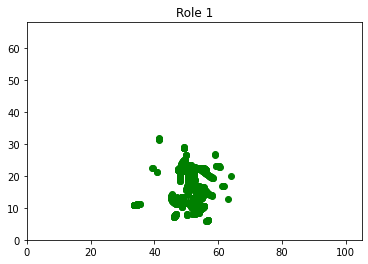

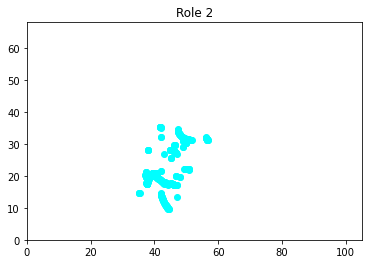

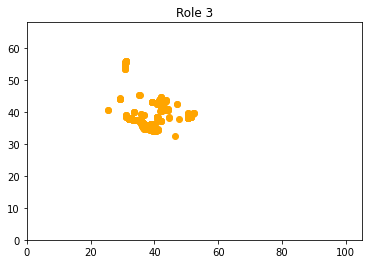

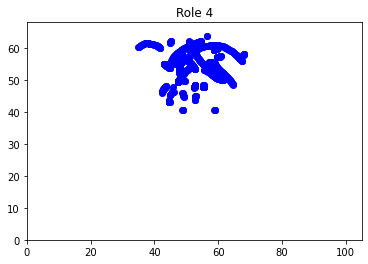

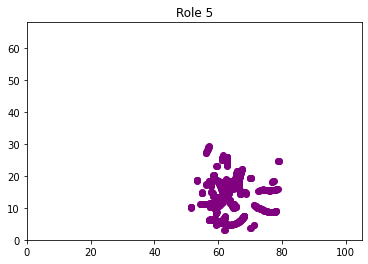

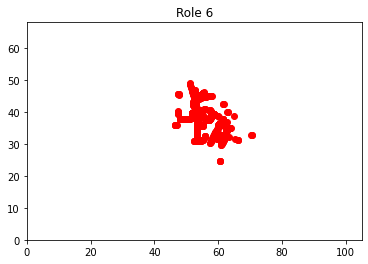

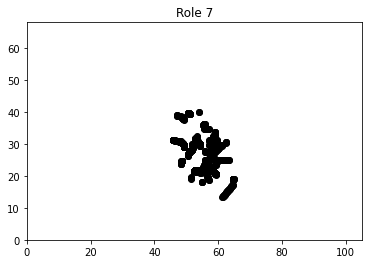

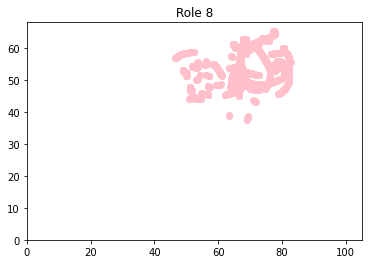

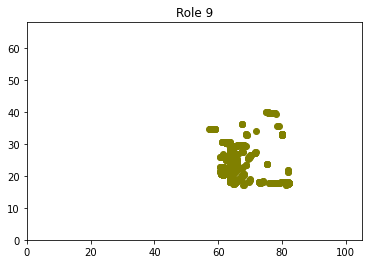

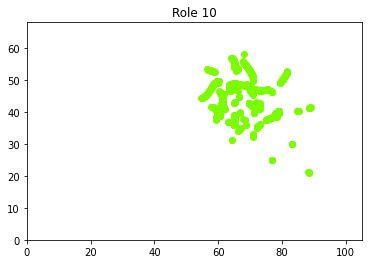

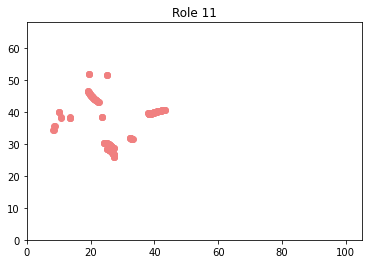

In [93]:
plot_ball_events_by_role(home_ball_events, main_data_for_new_pdfs)